<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [51]</a>'.</span>

In [1]:
# Parameters
var_list = ["cape", "crr", "ie", "ishf", "lsrr", "sp", "tcw", "tcwv", "ttr"]
plevel_list = [False, False, False, False, False, False, False, False, False]
aew_subset = "12hr_before"
model_save_name = "best_model12_300.keras"
tuner_project_name = "tuner_runmodel12_300"


In [2]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner



import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

2025-07-21 19:28:51.365644: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 19:28:51.369736: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 19:28:51.489130: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 19:28:51.542999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753147731.602275   75442 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753147731.61

In [3]:
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss for binary classification."""
    def loss_fn(y_true, y_pred):
        # Clip to prevent NaNs 
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_factor * modulating_factor * bce
    return loss_fn


In [4]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [5]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [6]:
import re


def add_dim(ds):
    # Extract the source file name from the dataset's encoding.
    fname = ds.encoding.get('source', '')
    # Use a regex to capture the central latitude and longitude from the filename.
    m = re.search(r'_(\-?\d+\.\d+)_(-?\d+\.\d+)\.nc$', fname)
    if m:
        lat_center = float(m.group(1))
        lon_center = float(m.group(2))
        # Assign the central coordinates and the file name as new coordinates.
        ds = ds.assign_coords(lat_center=lat_center, lon_center=lon_center, file_name=fname)
    else:
        print("File name does not match expected pattern:", fname)
    
    # Expand dims to add the 'sample' dimension and drop unnecessary variables.
    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars("utc_date")




    

In [7]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="12hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [8]:
def transpose_load_concat(data_dictionary):
    # Dictionary to hold processed variables
    transposed = {}

    # Use first dataset to extract lat/lon and metadata
    first_key = next(iter(data_dictionary))
    ds_first = data_dictionary[first_key]

    # --- Step 1: Extract 2D lat/lon grids ---
    lat_vals = ds_first['latitude'].values  # shape (32, 32)
    lon_vals = ds_first['longitude'].values

    # --- Step 2: Broadcast lat/lon to (samples, 32, 32) ---
    num_samples = ds_first.sizes['sample']  # typically N = 2750
    lat_grid = np.broadcast_to(lat_vals, (num_samples, 32, 32))
    lon_grid = np.broadcast_to(lon_vals, (num_samples, 32, 32))

    # --- Step 3: Wrap as xarray DataArrays with new 'features' dim ---
    lat_da = xr.DataArray(lat_grid, dims=('sample', 'latitude', 'longitude'))
    lat_da = lat_da.expand_dims('features')  # shape: (sample, latitude, longitude, 1)

    lon_da = xr.DataArray(lon_grid, dims=('sample', 'latitude', 'longitude'))
    lon_da = lon_da.expand_dims('features')

    # --- Step 4: Process each variable (reshape and align dims) ---
    for key, ds in data_dictionary.items():
        var_name = key.split('_')[0].upper()
        transposed[key] = ds[var_name].expand_dims('features').transpose('sample', 'latitude', 'longitude', 'features')

    # --- Step 5: Concatenate all features along 'features' dimension ---
    all_vars = list(transposed.values()) + [lat_da, lon_da]
    data = xr.concat(all_vars, dim='features', coords='minimal', compat='override')

    # --- Step 6: Return label and metadata from one dataset ---
    lat_center = data_dictionary[first_key]['lat_center']
    lon_center = data_dictionary[first_key]['lon_center']
    label = data_dictionary[first_key]['label']

    return data, label, lat_center, lon_center




In [9]:
def omit_nans(data, label, lat, lon):
    # If data is an xarray DataArray, convert it to a NumPy array
    if hasattr(data, 'values'):
        data = data.values
    maskarray = np.full(data.shape[0], True)
    # Find indices where NaNs occur
    masker = np.unique(np.argwhere(np.isnan(data))[:, 0])
    maskarray[masker] = False

    traindata = data[maskarray, ...]
    trainlabel = label[maskarray]
    lat_filtered = lat[maskarray]
    lon_filtered = lon[maskarray]
    return traindata, trainlabel, lat_filtered, lon_filtered



In [10]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [11]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [12]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [13]:
def pick_loss(loss_string):
    

    lossdict = {
        "relu": tf.nn.relu,
        "tanh": tf.nn.tanh,
        "selu": tf.nn.selu,
        "sigmoid": tf.nn.sigmoid,
        "relu6": tf.nn.relu6,
        "silu": tf.nn.silu,
        "gelu": tf.nn.gelu,
        "lrelu": tf.nn.leaky_relu,
    }

    return lossdict[loss_string]

In [14]:
def compute_saliency_map(model, input_sample):
    """
    Compute a saliency map for a given input sample using a gradient-based approach.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample of shape (1, height, width, channels).
    
    Returns:
        saliency (numpy array): The saliency map of shape (height, width).
    """
    # Ensure the model is in inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor
        tape.watch(input_tensor)
        # Get the model's prediction
        prediction = model(input_tensor)
    
    # Compute gradients of the prediction with respect to the input
    grads = tape.gradient(prediction, input_tensor)
    
    # If there are multiple channels, take the maximum absolute gradient across channels
    saliency = np.max(np.abs(grads.numpy()), axis=-1)[0]
    return saliency

In [15]:
def compute_saliency_per_channel(model, input_sample):
    """
    Computes the saliency map for each channel of a given input sample.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample with shape (1, H, W, C).
        
    Returns:
        saliency_maps (numpy array): Absolute gradients with shape (H, W, C) for each channel.
        channel_importance (numpy array): Mean saliency per channel (shape: (C,)).
    """
    # Set the model to inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Compute gradients with respect to the input sample using GradientTape
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)
    
    # Calculate gradients: shape (1, H, W, C)
    grads = tape.gradient(prediction, input_tensor)
    
    # Remove the batch dimension: shape becomes (H, W, C)
    grads = grads.numpy()[0]
    
    # Take absolute value to measure importance (magnitude of sensitivity)
    saliency_maps = np.abs(grads)
    
    # Aggregate saliency per channel (e.g., using the mean over spatial dimensions)
    channel_importance = np.mean(saliency_maps, axis=(0, 1))
    
    return saliency_maps, channel_importance

In [16]:
number_of_features = len(var_list)



In [17]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset=aew_subset,
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/Project1/zarr"
)






Loading cape from Zarr store.


Loading crr from Zarr store.
Loading ie from Zarr store.
Loading ishf from Zarr store.
Loading lsrr from Zarr store.


Loading sp from Zarr store.
Loading tcw from Zarr store.
Loading tcwv from Zarr store.


Loading ttr from Zarr store.


In [18]:
# transpose the data and concat variables

#data_, labels_ = transpose_load_concat(data)
data_, labels_, sample_lat, sample_lon = transpose_load_concat(data)

print(np.shape(data_))

(2750, 32, 32, 11)


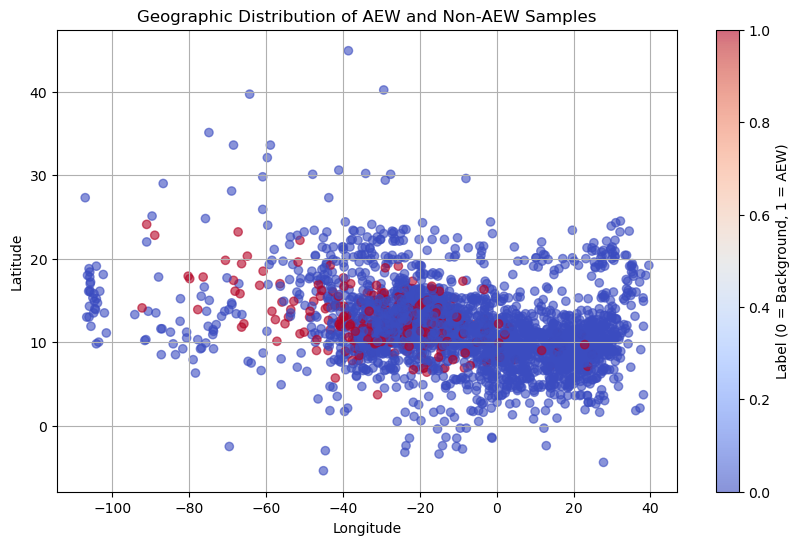

In [19]:
import matplotlib.pyplot as plt

# Scatter plot: where are the samples located, colored by label (AEW or not)
plt.figure(figsize=(10, 6))
sc = plt.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', alpha=0.6)
plt.colorbar(sc, label="Label (0 = Background, 1 = AEW)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of AEW and Non-AEW Samples")
plt.grid(True)
plt.show()


In [20]:
print(var_list)


['cape', 'crr', 'ie', 'ishf', 'lsrr', 'sp', 'tcw', 'tcwv', 'ttr']


In [21]:
# check / remove nans

data_, labels_, sample_lat, sample_lon = omit_nans(data_, labels_, sample_lat, sample_lon)






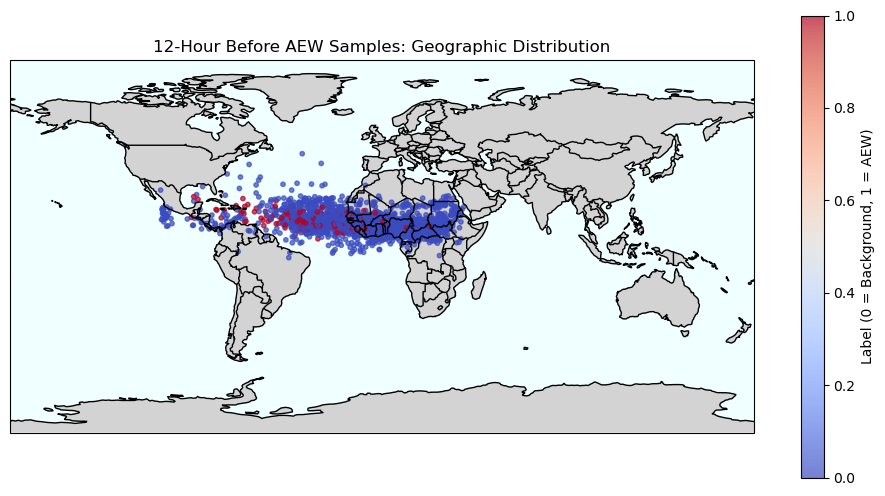

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(12, 6))

# Set up map projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')

# Plot sample locations colored by label
sc = ax.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', s=10, alpha=0.7, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label="Label (0 = Background, 1 = AEW)")
plt.title("12-Hour Before AEW Samples: Geographic Distribution")
plt.show()

In [23]:
print("Total samples:", len(sample_lat))


Total samples: 2750


In [24]:
print("Latitude Range:", float(sample_lat.min().compute()), "to", float(sample_lat.max().compute()))
print("Longitude Range:", float(sample_lon.min().compute()), "to", float(sample_lon.max().compute()))


Latitude Range: -5.4 to 44.9
Longitude Range: -107.1 to 39.6


In [25]:
#split train and test set
X_train, X_test, y_train, y_test, lat_train, lat_test, lon_train, lon_test = sklearn.model_selection.train_test_split(
    data_, labels_, sample_lat, sample_lon, test_size=0.2, random_state=42)



print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(2200, 32, 32, 11) (550, 32, 32, 11) (2200,) (550,)


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 412 times more chunks
  return self.array[key]
/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 109 times more chunks
  return self.array[key]


In [26]:
# [21]: Scaling code (fixed to prevent data leakage)

# Create the scaler object
scaler_input = sklearn.preprocessing.StandardScaler()

# Reshape training data to 2D (samples, features)
X_train_tmp = X_train.reshape((-1, X_train.shape[-1]))


# Fit the scaler ONLY on the training data
scaler_input.fit(X_train_tmp)  # <-- Key change: Learn mean/std from training data

# Transform BOTH training and test data using the SAME scaler
input_train_scaled = scaler_input.transform(X_train_tmp)          # Train: transform only
X_test_tmp = X_test.reshape((-1, X_test.shape[-1]))
input_test_scaled = scaler_input.transform(X_test_tmp)
input_test_scaled = input_test_scaled.reshape(X_test.shape)


# Reshape back to original dimensions (samples, height, width, features)
input_train_scaled = np.reshape(input_train_scaled, X_train.shape)
input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# Labels remain unchanged
label_train_scaled = y_train
label_test_scaled = y_test

In [27]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(2200, 32, 32, 11) (2200, 1) (550, 32, 32, 11) (550, 1)


In [28]:
number_of_features = input_train_scaled.shape[-1]

In [29]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 204 (9.27% of total)


In [30]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.09272727272727273, 1: 0.9072727272727272}


In [31]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

2025-07-21 19:30:09.389180: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [32]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        model.add(keras.Input(shape=(32, 32, number_of_features)))

        # Data augmentation
        model.add(layers.RandomFlip("horizontal_and_vertical"))
        model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

        # CNN layers (same tuning as before)
        featmaps1 = hp.Int('units_1', min_value=10, max_value=60)
        featmaps2 = hp.Int('units_2', min_value=10, max_value=64)
        featmaps3 = hp.Int('units_3', min_value=10, max_value=128)
        featmaps4 = hp.Int('units_4', min_value=10, max_value=80)
        learning_rate = hp.Float('lr', min_value=0.00001, max_value=0.01, sampling="linear")
        act_func = hp.Choice('activation', ["relu", "tanh", "selu", "sigmoid", "relu6", "silu", "gelu"])

        model.add(layers.Conv2D(featmaps1, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps2, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps3, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.GlobalMaxPooling2D())
        model.add(layers.Dense(featmaps4))
        model.add(layers.Dense(1, activation="sigmoid"))

        
        

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=focal_loss(gamma=2.0, alpha=0.25),  # pass tuned gamma and alpha!
            metrics=METRICS
        )

        return model



In [33]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [34]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_f1_score", direction="max"),
    max_trials=150,
    project_name=tuner_project_name,
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True,
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu'], 'ordered': False}


In [35]:
import numpy as np

labels_np = np.array(labels_)

total = len(labels_np)
positives = np.sum(labels_np == 1)
negatives = np.sum(labels_np == 0)

print("Total samples:", total)
print("AEW-positive samples (label=1):", positives)
print("Background samples (label=0):", negatives)


Total samples: 2750
AEW-positive samples (label=1): 258
Background samples (label=0): 2492


In [36]:
# Begin the search
EPOCHS = 100

tuner.search(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1
)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 150 Complete [00h 01m 23s]
val_f1_score: 0.0

Best val_f1_score So Far: 0.6666666269302368
Total elapsed time: 03h 28m 12s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 11)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 32, 32, 11)     │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 25)     │         2,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 19)     │         4,294 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 19)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 19)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 95)       │        16,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 95)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 95)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 95)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 43)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,306 (106.66 KB)

 Trainable params: 27,306 (106.66 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - auc: 0.5008 - binary_accuracy: 0.9405 - cross entropy: 3.4465 - f1_score: 0.0000e+00 - fn: 15.0000 - fp: 0.0000e+00 - loss: 0.0123 - mean_squared_error: 0.0650 - prc: 0.0583 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2549 - tn: 237.0000 - tp: 0.0000e+00

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.5116 - binary_accuracy: 0.8613 - cross entropy: 2.9089 - f1_score: 0.0303 - fn: 19.8333 - fp: 27.1667 - loss: 0.0454 - mean_squared_error: 0.1220 - prc: 0.0626 - precision: 0.0248 - recall: 0.0394 - root_mean_squared_error: 0.3468 - tn: 284.1667 - tp: 0.8333                   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.5331 - binary_accuracy: 0.8510 - cross entropy: 2.5053 - f1_score: 0.0594 - fn: 24.3636 - fp: 38.9091 - loss: 0.0401 - mean_squared_error: 0.1249 - prc: 0.0712 - precision: 0.0472 - recall: 0.0809 - root_mean_squared_error: 0.3520 - tn: 346.0000 - tp: 2.7273

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.5615 - binary_accuracy: 0.8408 - cross entropy: 2.1963 - f1_score: 0.1065 - fn: 29.8824 - fp: 53.8824 - loss: 0.0351 - mean_squared_error: 0.1297 - prc: 0.0864 - precision: 0.0839 - recall: 0.1466 - root_mean_squared_error: 0.3590 - tn: 417.3529 - tp: 6.8824

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.5739 - binary_accuracy: 0.8310 - cross entropy: 2.0168 - f1_score: 0.1260 - fn: 34.8636 - fp: 69.5000 - loss: 0.0324 - mean_squared_error: 0.1339 - prc: 0.0936 - precision: 0.0978 - recall: 0.1784 - root_mean_squared_error: 0.3650 - tn: 473.5909 - tp: 10.0455

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.5841 - binary_accuracy: 0.8210 - cross entropy: 1.8797 - f1_score: 0.1409 - fn: 40.4815 - fp: 86.7037 - loss: 0.0305 - mean_squared_error: 0.1381 - prc: 0.1016 - precision: 0.1083 - recall: 0.2031 - root_mean_squared_error: 0.3706 - tn: 527.1111 - tp: 13.7037

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.5931 - binary_accuracy: 0.8141 - cross entropy: 1.7675 - f1_score: 0.1527 - fn: 45.5625 - fp: 102.8750 - loss: 0.0290 - mean_squared_error: 0.1406 - prc: 0.1083 - precision: 0.1165 - recall: 0.2234 - root_mean_squared_error: 0.3741 - tn: 582.3125 - tp: 17.2500

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6024 - binary_accuracy: 0.8102 - cross entropy: 1.6721 - f1_score: 0.1630 - fn: 50.1892 - fp: 117.1351 - loss: 0.0278 - mean_squared_error: 0.1416 - prc: 0.1143 - precision: 0.1237 - recall: 0.2403 - root_mean_squared_error: 0.3755 - tn: 639.9730 - tp: 20.7027

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6113 - binary_accuracy: 0.8070 - cross entropy: 1.5914 - f1_score: 0.1725 - fn: 54.7381 - fp: 131.3810 - loss: 0.0267 - mean_squared_error: 0.1423 - prc: 0.1203 - precision: 0.1305 - recall: 0.2559 - root_mean_squared_error: 0.3765 - tn: 697.4286 - tp: 24.4524

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6202 - binary_accuracy: 0.8048 - cross entropy: 1.5224 - f1_score: 0.1832 - fn: 58.8936 - fp: 145.1702 - loss: 0.0258 - mean_squared_error: 0.1429 - prc: 0.1266 - precision: 0.1383 - recall: 0.2729 - root_mean_squared_error: 0.3773 - tn: 754.9787 - tp: 28.9574

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6278 - binary_accuracy: 0.8039 - cross entropy: 1.4615 - f1_score: 0.1919 - fn: 62.8846 - fp: 157.3077 - loss: 0.0249 - mean_squared_error: 0.1428 - prc: 0.1318 - precision: 0.1447 - recall: 0.2862 - root_mean_squared_error: 0.3774 - tn: 814.9039 - tp: 32.9038

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6342 - binary_accuracy: 0.8032 - cross entropy: 1.4082 - f1_score: 0.1990 - fn: 66.7719 - fp: 169.4737 - loss: 0.0242 - mean_squared_error: 0.1428 - prc: 0.1359 - precision: 0.1498 - recall: 0.2973 - root_mean_squared_error: 0.3774 - tn: 875.1228 - tp: 36.6316

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6397 - binary_accuracy: 0.8032 - cross entropy: 1.3609 - f1_score: 0.2054 - fn: 70.6613 - fp: 180.5484 - loss: 0.0235 - mean_squared_error: 0.1427 - prc: 0.1395 - precision: 0.1546 - recall: 0.3067 - root_mean_squared_error: 0.3773 - tn: 936.4839 - tp: 40.2419

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - auc: 0.6407 - binary_accuracy: 0.8032 - cross entropy: 1.3522 - f1_score: 0.2066 - fn: 71.4286 - fp: 182.5873 - loss: 0.0234 - mean_squared_error: 0.1427 - prc: 0.1402 - precision: 0.1556 - recall: 0.3085 - root_mean_squared_error: 0.3773 - tn: 948.3969 - tp: 40.9524 - val_auc: 0.8874 - val_binary_accuracy: 0.5364 - val_cross entropy: 0.6393 - val_f1_score: 0.2031 - val_fn: 0.0000e+00 - val_fp: 102.0000 - val_loss: 0.1200 - val_mean_squared_error: 0.2253 - val_prc: 0.3554 - val_precision: 0.1130 - val_recall: 1.0000 - val_root_mean_squared_error: 0.4746 - val_tn: 105.0000 - val_tp: 13.0000


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9000 - binary_accuracy: 0.4688 - cross entropy: 0.6962 - f1_score: 0.1905 - fn: 0.0000e+00 - fp: 17.0000 - loss: 0.0147 - mean_squared_error: 0.2524 - prc: 0.2680 - precision: 0.1053 - recall: 1.0000 - root_mean_squared_error: 0.5024 - tn: 13.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8059 - binary_accuracy: 0.5579 - cross entropy: 0.6360 - f1_score: 0.2114 - fn: 1.5000 - fp: 42.5000 - loss: 0.0134 - mean_squared_error: 0.2245 - prc: 0.2797 - precision: 0.1219 - recall: 0.8831 - root_mean_squared_error: 0.4727 - tn: 61.8333 - tp: 6.1667    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7605 - binary_accuracy: 0.6546 - cross entropy: 0.5585 - f1_score: 0.2083 - fn: 6.9091 - fp: 46.8182 - loss: 0.0126 - mean_squared_error: 0.1900 - prc: 0.2340 - precision: 0.1296 - recall: 0.6660 - root_mean_squared_error: 0.4330 - tn: 131.0909 - tp: 7.1818

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7479 - binary_accuracy: 0.6839 - cross entropy: 0.5382 - f1_score: 0.2212 - fn: 11.3750 - fp: 61.0000 - loss: 0.0127 - mean_squared_error: 0.1810 - prc: 0.2294 - precision: 0.1426 - recall: 0.6038 - root_mean_squared_error: 0.4231 - tn: 188.8125 - tp: 10.8125

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7389 - binary_accuracy: 0.7033 - cross entropy: 0.5249 - f1_score: 0.2308 - fn: 15.9048 - fp: 73.1429 - loss: 0.0129 - mean_squared_error: 0.1751 - prc: 0.2220 - precision: 0.1524 - recall: 0.5687 - root_mean_squared_error: 0.4165 - tn: 248.7143 - tp: 14.2381

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7339 - binary_accuracy: 0.7138 - cross entropy: 0.5185 - f1_score: 0.2431 - fn: 20.3846 - fp: 87.3846 - loss: 0.0132 - mean_squared_error: 0.1723 - prc: 0.2204 - precision: 0.1634 - recall: 0.5549 - root_mean_squared_error: 0.4134 - tn: 305.2308 - tp: 19.0000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7315 - binary_accuracy: 0.7189 - cross entropy: 0.5161 - f1_score: 0.2514 - fn: 24.2903 - fp: 104.1290 - loss: 0.0134 - mean_squared_error: 0.1712 - prc: 0.2198 - precision: 0.1700 - recall: 0.5500 - root_mean_squared_error: 0.4123 - tn: 359.7097 - tp: 23.8710

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7314 - binary_accuracy: 0.7262 - cross entropy: 0.5105 - f1_score: 0.2569 - fn: 28.6389 - fp: 116.4722 - loss: 0.0134 - mean_squared_error: 0.1687 - prc: 0.2191 - precision: 0.1754 - recall: 0.5401 - root_mean_squared_error: 0.4094 - tn: 419.2500 - tp: 27.6389

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7335 - binary_accuracy: 0.7328 - cross entropy: 0.5049 - f1_score: 0.2634 - fn: 32.6829 - fp: 128.1463 - loss: 0.0133 - mean_squared_error: 0.1663 - prc: 0.2199 - precision: 0.1815 - recall: 0.5352 - root_mean_squared_error: 0.4066 - tn: 479.3658 - tp: 31.8049

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7382 - binary_accuracy: 0.7395 - cross entropy: 0.4991 - f1_score: 0.2724 - fn: 37.2979 - fp: 142.0638 - loss: 0.0132 - mean_squared_error: 0.1639 - prc: 0.2254 - precision: 0.1896 - recall: 0.5342 - root_mean_squared_error: 0.4037 - tn: 551.0851 - tp: 37.5532

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7422 - binary_accuracy: 0.7451 - cross entropy: 0.4941 - f1_score: 0.2782 - fn: 41.0769 - fp: 152.1923 - loss: 0.0131 - mean_squared_error: 0.1617 - prc: 0.2292 - precision: 0.1950 - recall: 0.5322 - root_mean_squared_error: 0.4010 - tn: 613.0192 - tp: 41.7115

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7455 - binary_accuracy: 0.7501 - cross entropy: 0.4898 - f1_score: 0.2828 - fn: 44.8772 - fp: 161.8246 - loss: 0.0130 - mean_squared_error: 0.1599 - prc: 0.2320 - precision: 0.1994 - recall: 0.5296 - root_mean_squared_error: 0.3987 - tn: 675.7719 - tp: 45.5263

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7484 - binary_accuracy: 0.7550 - cross entropy: 0.4861 - f1_score: 0.2865 - fn: 48.8387 - fp: 170.5645 - loss: 0.0128 - mean_squared_error: 0.1582 - prc: 0.2343 - precision: 0.2034 - recall: 0.5262 - root_mean_squared_error: 0.3967 - tn: 739.4677 - tp: 49.0645

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7489 - binary_accuracy: 0.7559 - cross entropy: 0.4854 - f1_score: 0.2873 - fn: 49.6190 - fp: 172.1746 - loss: 0.0128 - mean_squared_error: 0.1579 - prc: 0.2348 - precision: 0.2042 - recall: 0.5256 - root_mean_squared_error: 0.3963 - tn: 751.8095 - tp: 49.7619 - val_auc: 0.8554 - val_binary_accuracy: 0.7045 - val_cross entropy: 0.5654 - val_f1_score: 0.2529 - val_fn: 2.0000 - val_fp: 63.0000 - val_loss: 0.0957 - val_mean_squared_error: 0.1918 - val_prc: 0.2791 - val_precision: 0.1486 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4380 - val_tn: 144.0000 - val_tp: 11.0000


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.7750 - binary_accuracy: 0.6250 - cross entropy: 0.6361 - f1_score: 0.2500 - fn: 0.0000e+00 - fp: 12.0000 - loss: 0.0136 - mean_squared_error: 0.2246 - prc: 0.1234 - precision: 0.1429 - recall: 1.0000 - root_mean_squared_error: 0.4739 - tn: 18.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8159 - binary_accuracy: 0.6775 - cross entropy: 0.5606 - f1_score: 0.2498 - fn: 2.1667 - fp: 30.1667 - loss: 0.0113 - mean_squared_error: 0.1905 - prc: 0.1920 - precision: 0.1507 - recall: 0.8144 - root_mean_squared_error: 0.4353 - tn: 74.1667 - tp: 5.5000    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7960 - binary_accuracy: 0.7428 - cross entropy: 0.4990 - f1_score: 0.2423 - fn: 7.5455 - fp: 33.3636 - loss: 0.0107 - mean_squared_error: 0.1633 - prc: 0.1915 - precision: 0.1606 - recall: 0.6128 - root_mean_squared_error: 0.4018 - tn: 144.5455 - tp: 6.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7877 - binary_accuracy: 0.7568 - cross entropy: 0.4856 - f1_score: 0.2550 - fn: 11.8125 - fp: 46.3125 - loss: 0.0108 - mean_squared_error: 0.1575 - prc: 0.2065 - precision: 0.1745 - recall: 0.5672 - root_mean_squared_error: 0.3950 - tn: 203.5000 - tp: 10.3750

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7814 - binary_accuracy: 0.7653 - cross entropy: 0.4791 - f1_score: 0.2654 - fn: 15.8571 - fp: 58.4286 - loss: 0.0110 - mean_squared_error: 0.1546 - prc: 0.2142 - precision: 0.1844 - recall: 0.5476 - root_mean_squared_error: 0.3917 - tn: 263.4286 - tp: 14.2857

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7772 - binary_accuracy: 0.7701 - cross entropy: 0.4755 - f1_score: 0.2769 - fn: 20.3462 - fp: 70.6923 - loss: 0.0113 - mean_squared_error: 0.1529 - prc: 0.2243 - precision: 0.1954 - recall: 0.5378 - root_mean_squared_error: 0.3899 - tn: 321.9231 - tp: 19.0385

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7750 - binary_accuracy: 0.7702 - cross entropy: 0.4760 - f1_score: 0.2851 - fn: 23.8387 - fp: 86.7742 - loss: 0.0114 - mean_squared_error: 0.1531 - prc: 0.2359 - precision: 0.2015 - recall: 0.5401 - root_mean_squared_error: 0.3902 - tn: 377.0645 - tp: 24.3226

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7738 - binary_accuracy: 0.7733 - cross entropy: 0.4736 - f1_score: 0.2905 - fn: 27.8333 - fp: 98.7500 - loss: 0.0115 - mean_squared_error: 0.1520 - prc: 0.2430 - precision: 0.2065 - recall: 0.5356 - root_mean_squared_error: 0.3890 - tn: 436.9722 - tp: 28.4444

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7737 - binary_accuracy: 0.7768 - cross entropy: 0.4705 - f1_score: 0.2953 - fn: 32.0732 - fp: 109.1707 - loss: 0.0115 - mean_squared_error: 0.1507 - prc: 0.2483 - precision: 0.2117 - recall: 0.5303 - root_mean_squared_error: 0.3874 - tn: 498.3415 - tp: 32.4146

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7752 - binary_accuracy: 0.7797 - cross entropy: 0.4687 - f1_score: 0.3026 - fn: 35.6957 - fp: 120.3696 - loss: 0.0115 - mean_squared_error: 0.1499 - prc: 0.2560 - precision: 0.2181 - recall: 0.5321 - root_mean_squared_error: 0.3864 - tn: 558.4565 - tp: 37.4783

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7771 - binary_accuracy: 0.7825 - cross entropy: 0.4664 - f1_score: 0.3083 - fn: 39.0980 - fp: 131.0784 - loss: 0.0114 - mean_squared_error: 0.1489 - prc: 0.2625 - precision: 0.2231 - recall: 0.5335 - root_mean_squared_error: 0.3852 - tn: 619.7255 - tp: 42.0980

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7789 - binary_accuracy: 0.7854 - cross entropy: 0.4635 - f1_score: 0.3129 - fn: 42.5357 - fp: 141.0357 - loss: 0.0114 - mean_squared_error: 0.1477 - prc: 0.2672 - precision: 0.2273 - recall: 0.5337 - root_mean_squared_error: 0.3836 - tn: 682.0714 - tp: 46.3571

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7806 - binary_accuracy: 0.7882 - cross entropy: 0.4608 - f1_score: 0.3168 - fn: 45.9344 - fp: 150.4754 - loss: 0.0113 - mean_squared_error: 0.1465 - prc: 0.2710 - precision: 0.2311 - recall: 0.5338 - root_mean_squared_error: 0.3821 - tn: 745.1475 - tp: 50.4426

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7813 - binary_accuracy: 0.7893 - cross entropy: 0.4599 - f1_score: 0.3185 - fn: 47.2698 - fp: 154.0794 - loss: 0.0113 - mean_squared_error: 0.1461 - prc: 0.2724 - precision: 0.2326 - recall: 0.5339 - root_mean_squared_error: 0.3816 - tn: 769.9048 - tp: 52.1111 - val_auc: 0.8592 - val_binary_accuracy: 0.8227 - val_cross entropy: 0.5220 - val_f1_score: 0.2909 - val_fn: 5.0000 - val_fp: 34.0000 - val_loss: 0.0769 - val_mean_squared_error: 0.1707 - val_prc: 0.3756 - val_precision: 0.1905 - val_recall: 0.6154 - val_root_mean_squared_error: 0.4132 - val_tn: 173.0000 - val_tp: 8.0000


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8333 - binary_accuracy: 0.6875 - cross entropy: 0.5644 - f1_score: 0.1667 - fn: 1.0000 - fp: 9.0000 - loss: 0.0104 - mean_squared_error: 0.1902 - prc: 0.3177 - precision: 0.1000 - recall: 0.5000 - root_mean_squared_error: 0.4362 - tn: 21.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8392 - binary_accuracy: 0.7615 - cross entropy: 0.5245 - f1_score: 0.2585 - fn: 3.1667 - fp: 20.3333 - loss: 0.0094 - mean_squared_error: 0.1719 - prc: 0.2652 - precision: 0.1689 - recall: 0.6068 - root_mean_squared_error: 0.4141 - tn: 84.0000 - tp: 4.5000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8249 - binary_accuracy: 0.8055 - cross entropy: 0.4861 - f1_score: 0.2528 - fn: 8.6364 - fp: 22.6364 - loss: 0.0091 - mean_squared_error: 0.1545 - prc: 0.2473 - precision: 0.1856 - recall: 0.4743 - root_mean_squared_error: 0.3921 - tn: 155.2727 - tp: 5.4545

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8172 - binary_accuracy: 0.8159 - cross entropy: 0.4750 - f1_score: 0.2683 - fn: 13.5000 - fp: 30.8125 - loss: 0.0093 - mean_squared_error: 0.1497 - prc: 0.2511 - precision: 0.2057 - recall: 0.4484 - root_mean_squared_error: 0.3860 - tn: 219.0000 - tp: 8.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8108 - binary_accuracy: 0.8202 - cross entropy: 0.4714 - f1_score: 0.2842 - fn: 17.4762 - fp: 40.2857 - loss: 0.0095 - mean_squared_error: 0.1481 - prc: 0.2566 - precision: 0.2197 - recall: 0.4508 - root_mean_squared_error: 0.3842 - tn: 281.5714 - tp: 12.6667

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8062 - binary_accuracy: 0.8225 - cross entropy: 0.4693 - f1_score: 0.2960 - fn: 22.5769 - fp: 48.9231 - loss: 0.0098 - mean_squared_error: 0.1472 - prc: 0.2659 - precision: 0.2325 - recall: 0.4480 - root_mean_squared_error: 0.3831 - tn: 343.6923 - tp: 16.8077

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8035 - binary_accuracy: 0.8212 - cross entropy: 0.4700 - f1_score: 0.3038 - fn: 26.7742 - fp: 60.9355 - loss: 0.0099 - mean_squared_error: 0.1475 - prc: 0.2738 - precision: 0.2382 - recall: 0.4534 - root_mean_squared_error: 0.3836 - tn: 402.9032 - tp: 21.3871

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8020 - binary_accuracy: 0.8222 - cross entropy: 0.4688 - f1_score: 0.3090 - fn: 31.1667 - fp: 70.2500 - loss: 0.0100 - mean_squared_error: 0.1470 - prc: 0.2787 - precision: 0.2431 - recall: 0.4533 - root_mean_squared_error: 0.3830 - tn: 465.4722 - tp: 25.1111

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8017 - binary_accuracy: 0.8234 - cross entropy: 0.4668 - f1_score: 0.3123 - fn: 35.9268 - fp: 78.7561 - loss: 0.0100 - mean_squared_error: 0.1462 - prc: 0.2827 - precision: 0.2471 - recall: 0.4506 - root_mean_squared_error: 0.3820 - tn: 528.7561 - tp: 28.5610

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8034 - binary_accuracy: 0.8242 - cross entropy: 0.4652 - f1_score: 0.3187 - fn: 40.1087 - fp: 87.8913 - loss: 0.0100 - mean_squared_error: 0.1455 - prc: 0.2929 - precision: 0.2529 - recall: 0.4543 - root_mean_squared_error: 0.3811 - tn: 590.9348 - tp: 33.0652

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8053 - binary_accuracy: 0.8256 - cross entropy: 0.4629 - f1_score: 0.3243 - fn: 43.8627 - fp: 96.5098 - loss: 0.0100 - mean_squared_error: 0.1446 - prc: 0.3019 - precision: 0.2579 - recall: 0.4582 - root_mean_squared_error: 0.3800 - tn: 654.2941 - tp: 37.3333

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8071 - binary_accuracy: 0.8271 - cross entropy: 0.4601 - f1_score: 0.3287 - fn: 47.6429 - fp: 104.5179 - loss: 0.0100 - mean_squared_error: 0.1435 - prc: 0.3086 - precision: 0.2620 - recall: 0.4606 - root_mean_squared_error: 0.3785 - tn: 718.5893 - tp: 41.2500

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8088 - binary_accuracy: 0.8285 - cross entropy: 0.4572 - f1_score: 0.3324 - fn: 51.3279 - fp: 112.4754 - loss: 0.0099 - mean_squared_error: 0.1424 - prc: 0.3141 - precision: 0.2653 - recall: 0.4627 - root_mean_squared_error: 0.3770 - tn: 783.1475 - tp: 45.0492

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8094 - binary_accuracy: 0.8290 - cross entropy: 0.4561 - f1_score: 0.3338 - fn: 52.8095 - fp: 115.4762 - loss: 0.0099 - mean_squared_error: 0.1419 - prc: 0.3162 - precision: 0.2667 - recall: 0.4635 - root_mean_squared_error: 0.3764 - tn: 808.5079 - tp: 46.5714 - val_auc: 0.8527 - val_binary_accuracy: 0.7727 - val_cross entropy: 0.5222 - val_f1_score: 0.2647 - val_fn: 4.0000 - val_fp: 46.0000 - val_loss: 0.0863 - val_mean_squared_error: 0.1718 - val_prc: 0.3373 - val_precision: 0.1636 - val_recall: 0.6923 - val_root_mean_squared_error: 0.4145 - val_tn: 161.0000 - val_tp: 9.0000


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8500 - binary_accuracy: 0.7500 - cross entropy: 0.5751 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0111 - mean_squared_error: 0.1955 - prc: 0.1823 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.4422 - tn: 22.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8771 - binary_accuracy: 0.7420 - cross entropy: 0.5420 - f1_score: 0.3119 - fn: 1.3333 - fp: 25.8333 - loss: 0.0099 - mean_squared_error: 0.1806 - prc: 0.3077 - precision: 0.1922 - recall: 0.8804 - root_mean_squared_error: 0.4246 - tn: 78.5000 - tp: 6.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8452 - binary_accuracy: 0.7913 - cross entropy: 0.4946 - f1_score: 0.3074 - fn: 7.5833 - fp: 30.0833 - loss: 0.0096 - mean_squared_error: 0.1591 - prc: 0.2919 - precision: 0.2116 - recall: 0.6725 - root_mean_squared_error: 0.3978 - tn: 162.0000 - tp: 8.3333

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8307 - binary_accuracy: 0.8030 - cross entropy: 0.4833 - f1_score: 0.3043 - fn: 12.7647 - fp: 37.7059 - loss: 0.0097 - mean_squared_error: 0.1540 - prc: 0.2878 - precision: 0.2186 - recall: 0.5933 - root_mean_squared_error: 0.3914 - tn: 226.5294 - tp: 11.0000

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8238 - binary_accuracy: 0.8103 - cross entropy: 0.4788 - f1_score: 0.3159 - fn: 16.7727 - fp: 46.2727 - loss: 0.0098 - mean_squared_error: 0.1518 - prc: 0.2919 - precision: 0.2323 - recall: 0.5700 - root_mean_squared_error: 0.3889 - tn: 289.8182 - tp: 15.1364

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8202 - binary_accuracy: 0.8147 - cross entropy: 0.4758 - f1_score: 0.3266 - fn: 21.5185 - fp: 54.4074 - loss: 0.0099 - mean_squared_error: 0.1504 - prc: 0.3001 - precision: 0.2457 - recall: 0.5537 - root_mean_squared_error: 0.3871 - tn: 352.4074 - tp: 19.6667

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8197 - binary_accuracy: 0.8180 - cross entropy: 0.4742 - f1_score: 0.3369 - fn: 25.2500 - fp: 63.4375 - loss: 0.0099 - mean_squared_error: 0.1496 - prc: 0.3081 - precision: 0.2561 - recall: 0.5498 - root_mean_squared_error: 0.3862 - tn: 414.7500 - tp: 24.5625

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8207 - binary_accuracy: 0.8216 - cross entropy: 0.4711 - f1_score: 0.3448 - fn: 28.9730 - fp: 71.1892 - loss: 0.0099 - mean_squared_error: 0.1482 - prc: 0.3139 - precision: 0.2647 - recall: 0.5455 - root_mean_squared_error: 0.3844 - tn: 478.9189 - tp: 28.9189

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8214 - binary_accuracy: 0.8250 - cross entropy: 0.4673 - f1_score: 0.3515 - fn: 33.0238 - fp: 78.1190 - loss: 0.0098 - mean_squared_error: 0.1466 - prc: 0.3182 - precision: 0.2728 - recall: 0.5408 - root_mean_squared_error: 0.3824 - tn: 543.6905 - tp: 33.1667

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8226 - binary_accuracy: 0.8271 - cross entropy: 0.4646 - f1_score: 0.3589 - fn: 36.5745 - fp: 86.5319 - loss: 0.0098 - mean_squared_error: 0.1455 - prc: 0.3233 - precision: 0.2801 - recall: 0.5418 - root_mean_squared_error: 0.3809 - tn: 606.6170 - tp: 38.2766

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8236 - binary_accuracy: 0.8286 - cross entropy: 0.4620 - f1_score: 0.3638 - fn: 39.8077 - fp: 95.6538 - loss: 0.0098 - mean_squared_error: 0.1445 - prc: 0.3255 - precision: 0.2844 - recall: 0.5430 - root_mean_squared_error: 0.3796 - tn: 669.5577 - tp: 42.9808

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8249 - binary_accuracy: 0.8303 - cross entropy: 0.4593 - f1_score: 0.3681 - fn: 42.9123 - fp: 104.1579 - loss: 0.0098 - mean_squared_error: 0.1433 - prc: 0.3273 - precision: 0.2883 - recall: 0.5442 - root_mean_squared_error: 0.3782 - tn: 733.4386 - tp: 47.4912

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8259 - binary_accuracy: 0.8322 - cross entropy: 0.4564 - f1_score: 0.3717 - fn: 46.3064 - fp: 111.4516 - loss: 0.0097 - mean_squared_error: 0.1422 - prc: 0.3286 - precision: 0.2921 - recall: 0.5436 - root_mean_squared_error: 0.3766 - tn: 798.5806 - tp: 51.5968

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8260 - binary_accuracy: 0.8326 - cross entropy: 0.4559 - f1_score: 0.3725 - fn: 46.9841 - fp: 112.8095 - loss: 0.0097 - mean_squared_error: 0.1419 - prc: 0.3289 - precision: 0.2929 - recall: 0.5434 - root_mean_squared_error: 0.3763 - tn: 811.1746 - tp: 52.3968 - val_auc: 0.8579 - val_binary_accuracy: 0.8136 - val_cross entropy: 0.5144 - val_f1_score: 0.2807 - val_fn: 5.0000 - val_fp: 36.0000 - val_loss: 0.0782 - val_mean_squared_error: 0.1671 - val_prc: 0.3935 - val_precision: 0.1818 - val_recall: 0.6154 - val_root_mean_squared_error: 0.4088 - val_tn: 171.0000 - val_tp: 8.0000


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.7750 - binary_accuracy: 0.6875 - cross entropy: 0.5585 - f1_score: 0.1667 - fn: 1.0000 - fp: 9.0000 - loss: 0.0110 - mean_squared_error: 0.1877 - prc: 0.1365 - precision: 0.1000 - recall: 0.5000 - root_mean_squared_error: 0.4332 - tn: 21.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8387 - binary_accuracy: 0.7042 - cross entropy: 0.5580 - f1_score: 0.2514 - fn: 1.6667 - fp: 30.0000 - loss: 0.0104 - mean_squared_error: 0.1876 - prc: 0.2858 - precision: 0.1524 - recall: 0.7415 - root_mean_squared_error: 0.4330 - tn: 74.3333 - tp: 6.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8296 - binary_accuracy: 0.7495 - cross entropy: 0.5258 - f1_score: 0.2797 - fn: 5.0000 - fp: 37.6364 - loss: 0.0099 - mean_squared_error: 0.1731 - prc: 0.2873 - precision: 0.1804 - recall: 0.6811 - root_mean_squared_error: 0.4155 - tn: 140.2727 - tp: 9.0909

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8236 - binary_accuracy: 0.7780 - cross entropy: 0.5006 - f1_score: 0.3039 - fn: 10.4118 - fp: 44.8824 - loss: 0.0098 - mean_squared_error: 0.1620 - prc: 0.2906 - precision: 0.2104 - recall: 0.6195 - root_mean_squared_error: 0.4017 - tn: 219.3529 - tp: 13.3529

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8214 - binary_accuracy: 0.7904 - cross entropy: 0.4894 - f1_score: 0.3205 - fn: 14.2273 - fp: 52.9091 - loss: 0.0098 - mean_squared_error: 0.1571 - prc: 0.2981 - precision: 0.2280 - recall: 0.6025 - root_mean_squared_error: 0.3955 - tn: 283.1818 - tp: 17.6818

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8204 - binary_accuracy: 0.7977 - cross entropy: 0.4843 - f1_score: 0.3362 - fn: 19.0714 - fp: 64.3929 - loss: 0.0098 - mean_squared_error: 0.1548 - prc: 0.3092 - precision: 0.2444 - recall: 0.5929 - root_mean_squared_error: 0.3927 - tn: 356.6429 - tp: 23.8929

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8213 - binary_accuracy: 0.8023 - cross entropy: 0.4817 - f1_score: 0.3468 - fn: 22.3333 - fp: 74.2727 - loss: 0.0098 - mean_squared_error: 0.1535 - prc: 0.3167 - precision: 0.2543 - recall: 0.5924 - root_mean_squared_error: 0.3913 - tn: 418.3030 - tp: 29.0909

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8228 - binary_accuracy: 0.8070 - cross entropy: 0.4777 - f1_score: 0.3563 - fn: 25.3684 - fp: 83.0789 - loss: 0.0098 - mean_squared_error: 0.1518 - prc: 0.3218 - precision: 0.2634 - recall: 0.5930 - root_mean_squared_error: 0.3890 - tn: 481.4211 - tp: 34.1316

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8247 - binary_accuracy: 0.8105 - cross entropy: 0.4735 - f1_score: 0.3646 - fn: 28.4884 - fp: 92.2093 - loss: 0.0098 - mean_squared_error: 0.1500 - prc: 0.3280 - precision: 0.2712 - recall: 0.5943 - root_mean_squared_error: 0.3867 - tn: 543.8605 - tp: 39.4419

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8270 - binary_accuracy: 0.8133 - cross entropy: 0.4698 - f1_score: 0.3722 - fn: 31.4167 - fp: 101.6875 - loss: 0.0097 - mean_squared_error: 0.1485 - prc: 0.3355 - precision: 0.2781 - recall: 0.5972 - root_mean_squared_error: 0.3848 - tn: 605.8542 - tp: 45.0417

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8288 - binary_accuracy: 0.8159 - cross entropy: 0.4661 - f1_score: 0.3775 - fn: 34.3585 - fp: 110.6604 - loss: 0.0097 - mean_squared_error: 0.1469 - prc: 0.3402 - precision: 0.2831 - recall: 0.5983 - root_mean_squared_error: 0.3827 - tn: 669.0000 - tp: 49.9811

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8304 - binary_accuracy: 0.8183 - cross entropy: 0.4625 - f1_score: 0.3815 - fn: 37.3276 - fp: 119.3621 - loss: 0.0096 - mean_squared_error: 0.1454 - prc: 0.3439 - precision: 0.2869 - recall: 0.5985 - root_mean_squared_error: 0.3808 - tn: 732.7414 - tp: 54.5690

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8316 - binary_accuracy: 0.8206 - cross entropy: 0.4594 - f1_score: 0.3846 - fn: 40.5556 - fp: 127.3175 - loss: 0.0096 - mean_squared_error: 0.1441 - prc: 0.3468 - precision: 0.2903 - recall: 0.5971 - root_mean_squared_error: 0.3791 - tn: 796.6667 - tp: 58.8254 - val_auc: 0.9077 - val_binary_accuracy: 0.8136 - val_cross entropy: 0.5003 - val_f1_score: 0.3492 - val_fn: 2.0000 - val_fp: 39.0000 - val_loss: 0.0794 - val_mean_squared_error: 0.1636 - val_prc: 0.4526 - val_precision: 0.2200 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4045 - val_tn: 168.0000 - val_tp: 11.0000


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9417 - binary_accuracy: 0.6562 - cross entropy: 0.5446 - f1_score: 0.2667 - fn: 0.0000e+00 - fp: 11.0000 - loss: 0.0097 - mean_squared_error: 0.1818 - prc: 0.3250 - precision: 0.1538 - recall: 1.0000 - root_mean_squared_error: 0.4264 - tn: 19.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9076 - binary_accuracy: 0.7442 - cross entropy: 0.5141 - f1_score: 0.3182 - fn: 1.3333 - fp: 23.8333 - loss: 0.0090 - mean_squared_error: 0.1679 - prc: 0.3207 - precision: 0.1985 - recall: 0.8804 - root_mean_squared_error: 0.4094 - tn: 80.5000 - tp: 6.3333    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8728 - binary_accuracy: 0.7948 - cross entropy: 0.4777 - f1_score: 0.3285 - fn: 5.8182 - fp: 26.7273 - loss: 0.0088 - mean_squared_error: 0.1515 - prc: 0.2990 - precision: 0.2263 - recall: 0.7142 - root_mean_squared_error: 0.3883 - tn: 151.1818 - tp: 8.2727

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8531 - binary_accuracy: 0.8089 - cross entropy: 0.4662 - f1_score: 0.3261 - fn: 11.1875 - fp: 33.8125 - loss: 0.0091 - mean_squared_error: 0.1463 - prc: 0.2930 - precision: 0.2372 - recall: 0.6229 - root_mean_squared_error: 0.3817 - tn: 216.0000 - tp: 11.0000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8437 - binary_accuracy: 0.8138 - cross entropy: 0.4626 - f1_score: 0.3311 - fn: 15.1905 - fp: 43.7619 - loss: 0.0092 - mean_squared_error: 0.1447 - prc: 0.2995 - precision: 0.2443 - recall: 0.5929 - root_mean_squared_error: 0.3798 - tn: 278.0952 - tp: 14.9524

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8372 - binary_accuracy: 0.8168 - cross entropy: 0.4603 - f1_score: 0.3355 - fn: 20.3846 - fp: 52.3846 - loss: 0.0094 - mean_squared_error: 0.1437 - prc: 0.3056 - precision: 0.2528 - recall: 0.5672 - root_mean_squared_error: 0.3785 - tn: 340.2308 - tp: 19.0000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8340 - binary_accuracy: 0.8177 - cross entropy: 0.4602 - f1_score: 0.3417 - fn: 24.2903 - fp: 63.2903 - loss: 0.0095 - mean_squared_error: 0.1436 - prc: 0.3100 - precision: 0.2589 - recall: 0.5602 - root_mean_squared_error: 0.3785 - tn: 400.5484 - tp: 23.8710

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8325 - binary_accuracy: 0.8196 - cross entropy: 0.4588 - f1_score: 0.3463 - fn: 28.0833 - fp: 72.8056 - loss: 0.0095 - mean_squared_error: 0.1430 - prc: 0.3140 - precision: 0.2638 - recall: 0.5541 - root_mean_squared_error: 0.3778 - tn: 462.9167 - tp: 28.1944

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8322 - binary_accuracy: 0.8222 - cross entropy: 0.4560 - f1_score: 0.3515 - fn: 32.0244 - fp: 80.7805 - loss: 0.0095 - mean_squared_error: 0.1419 - prc: 0.3175 - precision: 0.2699 - recall: 0.5489 - root_mean_squared_error: 0.3763 - tn: 526.7317 - tp: 32.4634

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8329 - binary_accuracy: 0.8242 - cross entropy: 0.4536 - f1_score: 0.3575 - fn: 35.8696 - fp: 89.0435 - loss: 0.0095 - mean_squared_error: 0.1409 - prc: 0.3230 - precision: 0.2763 - recall: 0.5472 - root_mean_squared_error: 0.3750 - tn: 589.7826 - tp: 37.3043

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8335 - binary_accuracy: 0.8258 - cross entropy: 0.4516 - f1_score: 0.3618 - fn: 39.3137 - fp: 97.9608 - loss: 0.0095 - mean_squared_error: 0.1401 - prc: 0.3265 - precision: 0.2804 - recall: 0.5467 - root_mean_squared_error: 0.3739 - tn: 652.8431 - tp: 41.8824

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8343 - binary_accuracy: 0.8274 - cross entropy: 0.4493 - f1_score: 0.3654 - fn: 42.6786 - fp: 106.3393 - loss: 0.0095 - mean_squared_error: 0.1392 - prc: 0.3293 - precision: 0.2840 - recall: 0.5461 - root_mean_squared_error: 0.3727 - tn: 716.7679 - tp: 46.2143

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8352 - binary_accuracy: 0.8298 - cross entropy: 0.4465 - f1_score: 0.3690 - fn: 46.9516 - fp: 114.9194 - loss: 0.0094 - mean_squared_error: 0.1380 - prc: 0.3319 - precision: 0.2883 - recall: 0.5438 - root_mean_squared_error: 0.3711 - tn: 795.1129 - tp: 50.9516

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8353 - binary_accuracy: 0.8302 - cross entropy: 0.4460 - f1_score: 0.3696 - fn: 47.6667 - fp: 116.2381 - loss: 0.0094 - mean_squared_error: 0.1378 - prc: 0.3323 - precision: 0.2890 - recall: 0.5434 - root_mean_squared_error: 0.3709 - tn: 807.7460 - tp: 51.7143 - val_auc: 0.8541 - val_binary_accuracy: 0.8318 - val_cross entropy: 0.4908 - val_f1_score: 0.3273 - val_fn: 4.0000 - val_fp: 33.0000 - val_loss: 0.0724 - val_mean_squared_error: 0.1575 - val_prc: 0.4141 - val_precision: 0.2143 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3969 - val_tn: 174.0000 - val_tp: 9.0000


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9333 - binary_accuracy: 0.7812 - cross entropy: 0.4989 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0081 - mean_squared_error: 0.1599 - prc: 0.3187 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3998 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9199 - binary_accuracy: 0.8021 - cross entropy: 0.5044 - f1_score: 0.3669 - fn: 1.3333 - fp: 20.0000 - loss: 0.0083 - mean_squared_error: 0.1626 - prc: 0.4025 - precision: 0.2342 - recall: 0.8804 - root_mean_squared_error: 0.4032 - tn: 84.3333 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8903 - binary_accuracy: 0.8236 - cross entropy: 0.4882 - f1_score: 0.3741 - fn: 4.5455 - fp: 26.6364 - loss: 0.0083 - mean_squared_error: 0.1553 - prc: 0.3800 - precision: 0.2539 - recall: 0.7678 - root_mean_squared_error: 0.3939 - tn: 151.2727 - tp: 9.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8750 - binary_accuracy: 0.8364 - cross entropy: 0.4763 - f1_score: 0.3883 - fn: 8.7500 - fp: 31.6250 - loss: 0.0085 - mean_squared_error: 0.1500 - prc: 0.3692 - precision: 0.2809 - recall: 0.6991 - root_mean_squared_error: 0.3871 - tn: 218.1875 - tp: 13.4375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8671 - binary_accuracy: 0.8449 - cross entropy: 0.4688 - f1_score: 0.4043 - fn: 12.1905 - fp: 37.0952 - loss: 0.0086 - mean_squared_error: 0.1467 - prc: 0.3691 - precision: 0.3029 - recall: 0.6717 - root_mean_squared_error: 0.3827 - tn: 284.7619 - tp: 17.9524

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8599 - binary_accuracy: 0.8474 - cross entropy: 0.4658 - f1_score: 0.4125 - fn: 16.3462 - fp: 44.5000 - loss: 0.0088 - mean_squared_error: 0.1454 - prc: 0.3722 - precision: 0.3157 - recall: 0.6515 - root_mean_squared_error: 0.3811 - tn: 348.1154 - tp: 23.0385

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8561 - binary_accuracy: 0.8481 - cross entropy: 0.4653 - f1_score: 0.4198 - fn: 19.4839 - fp: 53.6774 - loss: 0.0089 - mean_squared_error: 0.1452 - prc: 0.3759 - precision: 0.3234 - recall: 0.6460 - root_mean_squared_error: 0.3808 - tn: 410.1613 - tp: 28.6774

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8540 - binary_accuracy: 0.8499 - cross entropy: 0.4636 - f1_score: 0.4257 - fn: 22.5556 - fp: 61.4444 - loss: 0.0090 - mean_squared_error: 0.1444 - prc: 0.3783 - precision: 0.3302 - recall: 0.6411 - root_mean_squared_error: 0.3799 - tn: 474.2778 - tp: 33.7222

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8529 - binary_accuracy: 0.8517 - cross entropy: 0.4608 - f1_score: 0.4298 - fn: 26.1220 - fp: 68.2683 - loss: 0.0090 - mean_squared_error: 0.1433 - prc: 0.3804 - precision: 0.3362 - recall: 0.6337 - root_mean_squared_error: 0.3783 - tn: 539.2439 - tp: 38.3659

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8530 - binary_accuracy: 0.8532 - cross entropy: 0.4580 - f1_score: 0.4351 - fn: 29.5217 - fp: 75.1957 - loss: 0.0090 - mean_squared_error: 0.1421 - prc: 0.3854 - precision: 0.3428 - recall: 0.6303 - root_mean_squared_error: 0.3768 - tn: 603.6304 - tp: 43.6522

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8535 - binary_accuracy: 0.8544 - cross entropy: 0.4553 - f1_score: 0.4387 - fn: 32.6078 - fp: 82.5098 - loss: 0.0090 - mean_squared_error: 0.1411 - prc: 0.3888 - precision: 0.3470 - recall: 0.6280 - root_mean_squared_error: 0.3754 - tn: 668.2941 - tp: 48.5882

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8541 - binary_accuracy: 0.8554 - cross entropy: 0.4525 - f1_score: 0.4411 - fn: 35.6250 - fp: 89.8393 - loss: 0.0090 - mean_squared_error: 0.1399 - prc: 0.3918 - precision: 0.3500 - recall: 0.6258 - root_mean_squared_error: 0.3738 - tn: 733.2679 - tp: 53.2679

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8545 - binary_accuracy: 0.8569 - cross entropy: 0.4490 - f1_score: 0.4433 - fn: 39.4677 - fp: 97.7581 - loss: 0.0090 - mean_squared_error: 0.1385 - prc: 0.3943 - precision: 0.3532 - recall: 0.6220 - root_mean_squared_error: 0.3719 - tn: 812.2742 - tp: 58.4355

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8545 - binary_accuracy: 0.8571 - cross entropy: 0.4484 - f1_score: 0.4436 - fn: 40.1429 - fp: 98.9841 - loss: 0.0090 - mean_squared_error: 0.1383 - prc: 0.3947 - precision: 0.3537 - recall: 0.6212 - root_mean_squared_error: 0.3716 - tn: 825.0000 - tp: 59.2381 - val_auc: 0.8733 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.4871 - val_f1_score: 0.3556 - val_fn: 5.0000 - val_fp: 24.0000 - val_loss: 0.0654 - val_mean_squared_error: 0.1537 - val_prc: 0.4584 - val_precision: 0.2500 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3921 - val_tn: 183.0000 - val_tp: 8.0000


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 0.4930 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0077 - mean_squared_error: 0.1561 - prc: 0.3187 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3951 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9220 - binary_accuracy: 0.8679 - cross entropy: 0.5087 - f1_score: 0.4837 - fn: 0.6667 - fp: 14.0000 - loss: 0.0082 - mean_squared_error: 0.1634 - prc: 0.4184 - precision: 0.3274 - recall: 0.9491 - root_mean_squared_error: 0.4042 - tn: 90.3333 - tp: 7.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8985 - binary_accuracy: 0.8752 - cross entropy: 0.4932 - f1_score: 0.4746 - fn: 3.7273 - fp: 19.4545 - loss: 0.0081 - mean_squared_error: 0.1564 - prc: 0.4222 - precision: 0.3398 - recall: 0.8276 - root_mean_squared_error: 0.3953 - tn: 158.4545 - tp: 10.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8854 - binary_accuracy: 0.8760 - cross entropy: 0.4815 - f1_score: 0.4635 - fn: 8.3750 - fp: 24.6250 - loss: 0.0083 - mean_squared_error: 0.1513 - prc: 0.4125 - precision: 0.3501 - recall: 0.7360 - root_mean_squared_error: 0.3887 - tn: 225.1875 - tp: 13.8125

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8769 - binary_accuracy: 0.8773 - cross entropy: 0.4728 - f1_score: 0.4602 - fn: 12.6190 - fp: 29.7143 - loss: 0.0084 - mean_squared_error: 0.1475 - prc: 0.4089 - precision: 0.3597 - recall: 0.6868 - root_mean_squared_error: 0.3838 - tn: 292.1429 - tp: 17.5238

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8699 - binary_accuracy: 0.8761 - cross entropy: 0.4684 - f1_score: 0.4583 - fn: 17.3846 - fp: 35.8846 - loss: 0.0086 - mean_squared_error: 0.1457 - prc: 0.4060 - precision: 0.3669 - recall: 0.6549 - root_mean_squared_error: 0.3815 - tn: 356.7308 - tp: 22.0000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8660 - binary_accuracy: 0.8741 - cross entropy: 0.4667 - f1_score: 0.4582 - fn: 21.0968 - fp: 43.9355 - loss: 0.0087 - mean_squared_error: 0.1451 - prc: 0.4046 - precision: 0.3696 - recall: 0.6410 - root_mean_squared_error: 0.3807 - tn: 419.9032 - tp: 27.0645

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8637 - binary_accuracy: 0.8732 - cross entropy: 0.4648 - f1_score: 0.4591 - fn: 24.3056 - fp: 51.6944 - loss: 0.0088 - mean_squared_error: 0.1443 - prc: 0.4032 - precision: 0.3716 - recall: 0.6333 - root_mean_squared_error: 0.3797 - tn: 484.0278 - tp: 31.9722

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8619 - binary_accuracy: 0.8729 - cross entropy: 0.4618 - f1_score: 0.4605 - fn: 27.6585 - fp: 58.7561 - loss: 0.0088 - mean_squared_error: 0.1432 - prc: 0.4021 - precision: 0.3746 - recall: 0.6269 - root_mean_squared_error: 0.3782 - tn: 548.7561 - tp: 36.8293

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8605 - binary_accuracy: 0.8726 - cross entropy: 0.4590 - f1_score: 0.4621 - fn: 31.3261 - fp: 65.6304 - loss: 0.0089 - mean_squared_error: 0.1421 - prc: 0.4019 - precision: 0.3779 - recall: 0.6212 - root_mean_squared_error: 0.3767 - tn: 613.1957 - tp: 41.8478

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8595 - binary_accuracy: 0.8719 - cross entropy: 0.4566 - f1_score: 0.4617 - fn: 34.7255 - fp: 73.3922 - loss: 0.0089 - mean_squared_error: 0.1411 - prc: 0.4013 - precision: 0.3782 - recall: 0.6166 - root_mean_squared_error: 0.3755 - tn: 677.4117 - tp: 46.4706

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8589 - binary_accuracy: 0.8711 - cross entropy: 0.4544 - f1_score: 0.4607 - fn: 37.9107 - fp: 81.6786 - loss: 0.0089 - mean_squared_error: 0.1403 - prc: 0.4002 - precision: 0.3773 - recall: 0.6133 - root_mean_squared_error: 0.3744 - tn: 741.4286 - tp: 50.9821

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8581 - binary_accuracy: 0.8708 - cross entropy: 0.4520 - f1_score: 0.4598 - fn: 41.1803 - fp: 89.1475 - loss: 0.0089 - mean_squared_error: 0.1394 - prc: 0.3990 - precision: 0.3769 - recall: 0.6096 - root_mean_squared_error: 0.3731 - tn: 806.4754 - tp: 55.1967

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8576 - binary_accuracy: 0.8707 - cross entropy: 0.4511 - f1_score: 0.4594 - fn: 42.5714 - fp: 91.8730 - loss: 0.0089 - mean_squared_error: 0.1390 - prc: 0.3984 - precision: 0.3769 - recall: 0.6079 - root_mean_squared_error: 0.3726 - tn: 832.1111 - tp: 56.8095 - val_auc: 0.8623 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.4471 - val_f1_score: 0.4242 - val_fn: 6.0000 - val_fp: 13.0000 - val_loss: 0.0520 - val_mean_squared_error: 0.1355 - val_prc: 0.4304 - val_precision: 0.3500 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3682 - val_tn: 194.0000 - val_tp: 7.0000


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9333 - binary_accuracy: 0.9375 - cross entropy: 0.4612 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0072 - mean_squared_error: 0.1416 - prc: 0.3069 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3763 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9140 - binary_accuracy: 0.8905 - cross entropy: 0.4799 - f1_score: 0.4938 - fn: 2.0000 - fp: 11.3333 - loss: 0.0076 - mean_squared_error: 0.1497 - prc: 0.3695 - precision: 0.3586 - recall: 0.8117 - root_mean_squared_error: 0.3869 - tn: 93.0000 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8967 - binary_accuracy: 0.8847 - cross entropy: 0.4812 - f1_score: 0.4585 - fn: 5.2727 - fp: 18.0000 - loss: 0.0078 - mean_squared_error: 0.1502 - prc: 0.4026 - precision: 0.3428 - recall: 0.7109 - root_mean_squared_error: 0.3876 - tn: 159.9091 - tp: 8.8182

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8921 - binary_accuracy: 0.8829 - cross entropy: 0.4775 - f1_score: 0.4575 - fn: 9.0625 - fp: 23.8125 - loss: 0.0080 - mean_squared_error: 0.1487 - prc: 0.4244 - precision: 0.3549 - recall: 0.6652 - root_mean_squared_error: 0.3856 - tn: 226.0000 - tp: 13.1250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8856 - binary_accuracy: 0.8837 - cross entropy: 0.4712 - f1_score: 0.4604 - fn: 12.8571 - fp: 28.6667 - loss: 0.0081 - mean_squared_error: 0.1461 - prc: 0.4347 - precision: 0.3679 - recall: 0.6382 - root_mean_squared_error: 0.3822 - tn: 293.1905 - tp: 17.2857

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8776 - binary_accuracy: 0.8822 - cross entropy: 0.4674 - f1_score: 0.4616 - fn: 17.3846 - fp: 34.5000 - loss: 0.0084 - mean_squared_error: 0.1446 - prc: 0.4343 - precision: 0.3768 - recall: 0.6181 - root_mean_squared_error: 0.3802 - tn: 358.1154 - tp: 22.0000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8728 - binary_accuracy: 0.8795 - cross entropy: 0.4665 - f1_score: 0.4631 - fn: 20.7419 - fp: 42.8710 - loss: 0.0085 - mean_squared_error: 0.1443 - prc: 0.4339 - precision: 0.3792 - recall: 0.6139 - root_mean_squared_error: 0.3798 - tn: 420.9677 - tp: 27.4194

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8688 - binary_accuracy: 0.8784 - cross entropy: 0.4651 - f1_score: 0.4655 - fn: 24.4865 - fp: 51.5946 - loss: 0.0086 - mean_squared_error: 0.1438 - prc: 0.4334 - precision: 0.3824 - recall: 0.6108 - root_mean_squared_error: 0.3792 - tn: 498.5135 - tp: 33.4054

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8665 - binary_accuracy: 0.8783 - cross entropy: 0.4631 - f1_score: 0.4674 - fn: 28.0714 - fp: 57.6667 - loss: 0.0087 - mean_squared_error: 0.1430 - prc: 0.4332 - precision: 0.3864 - recall: 0.6062 - root_mean_squared_error: 0.3781 - tn: 564.1429 - tp: 38.1190

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8654 - binary_accuracy: 0.8779 - cross entropy: 0.4614 - f1_score: 0.4700 - fn: 31.5106 - fp: 64.2979 - loss: 0.0087 - mean_squared_error: 0.1423 - prc: 0.4353 - precision: 0.3901 - recall: 0.6046 - root_mean_squared_error: 0.3772 - tn: 628.8511 - tp: 43.3404

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8646 - binary_accuracy: 0.8776 - cross entropy: 0.4594 - f1_score: 0.4710 - fn: 34.6923 - fp: 71.1923 - loss: 0.0088 - mean_squared_error: 0.1416 - prc: 0.4349 - precision: 0.3916 - recall: 0.6031 - root_mean_squared_error: 0.3762 - tn: 694.0192 - tp: 48.0962

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8641 - binary_accuracy: 0.8775 - cross entropy: 0.4568 - f1_score: 0.4714 - fn: 37.8421 - fp: 77.8772 - loss: 0.0087 - mean_squared_error: 0.1406 - prc: 0.4345 - precision: 0.3925 - recall: 0.6014 - root_mean_squared_error: 0.3748 - tn: 759.7193 - tp: 52.5614

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8632 - binary_accuracy: 0.8775 - cross entropy: 0.4536 - f1_score: 0.4712 - fn: 41.9206 - fp: 85.1746 - loss: 0.0087 - mean_squared_error: 0.1393 - prc: 0.4335 - precision: 0.3934 - recall: 0.5978 - root_mean_squared_error: 0.3731 - tn: 838.8095 - tp: 57.4603 - val_auc: 0.8722 - val_binary_accuracy: 0.8773 - val_cross entropy: 0.4540 - val_f1_score: 0.3721 - val_fn: 5.0000 - val_fp: 22.0000 - val_loss: 0.0630 - val_mean_squared_error: 0.1400 - val_prc: 0.4396 - val_precision: 0.2667 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3742 - val_tn: 185.0000 - val_tp: 8.0000


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9000 - binary_accuracy: 0.7812 - cross entropy: 0.5137 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0090 - mean_squared_error: 0.1668 - prc: 0.2299 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4084 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9016 - binary_accuracy: 0.8047 - cross entropy: 0.5179 - f1_score: 0.3741 - fn: 1.1667 - fp: 19.8333 - loss: 0.0089 - mean_squared_error: 0.1682 - prc: 0.3107 - precision: 0.2392 - recall: 0.8923 - root_mean_squared_error: 0.4101 - tn: 84.5000 - tp: 6.5000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8766 - binary_accuracy: 0.8271 - cross entropy: 0.5003 - f1_score: 0.3893 - fn: 4.0000 - fp: 26.4545 - loss: 0.0087 - mean_squared_error: 0.1599 - prc: 0.3283 - precision: 0.2640 - recall: 0.7966 - root_mean_squared_error: 0.3997 - tn: 151.4545 - tp: 10.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8617 - binary_accuracy: 0.8382 - cross entropy: 0.4902 - f1_score: 0.3973 - fn: 8.4375 - fp: 31.6250 - loss: 0.0089 - mean_squared_error: 0.1553 - prc: 0.3346 - precision: 0.2863 - recall: 0.7176 - root_mean_squared_error: 0.3938 - tn: 218.1875 - tp: 13.7500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8549 - binary_accuracy: 0.8469 - cross entropy: 0.4836 - f1_score: 0.4062 - fn: 12.7143 - fp: 35.9524 - loss: 0.0089 - mean_squared_error: 0.1521 - prc: 0.3433 - precision: 0.3063 - recall: 0.6722 - root_mean_squared_error: 0.3898 - tn: 285.9048 - tp: 17.4286

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8498 - binary_accuracy: 0.8504 - cross entropy: 0.4801 - f1_score: 0.4104 - fn: 17.8077 - fp: 41.4615 - loss: 0.0090 - mean_squared_error: 0.1505 - prc: 0.3499 - precision: 0.3196 - recall: 0.6387 - root_mean_squared_error: 0.3877 - tn: 351.1538 - tp: 21.5769

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8478 - binary_accuracy: 0.8516 - cross entropy: 0.4783 - f1_score: 0.4148 - fn: 21.8065 - fp: 49.1290 - loss: 0.0091 - mean_squared_error: 0.1497 - prc: 0.3557 - precision: 0.3270 - recall: 0.6236 - root_mean_squared_error: 0.3867 - tn: 414.7097 - tp: 26.3548

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8472 - binary_accuracy: 0.8531 - cross entropy: 0.4753 - f1_score: 0.4199 - fn: 25.7568 - fp: 58.5676 - loss: 0.0091 - mean_squared_error: 0.1484 - prc: 0.3621 - precision: 0.3333 - recall: 0.6154 - root_mean_squared_error: 0.3851 - tn: 491.5405 - tp: 32.1351

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8472 - binary_accuracy: 0.8549 - cross entropy: 0.4709 - f1_score: 0.4254 - fn: 29.9767 - fp: 66.8372 - loss: 0.0091 - mean_squared_error: 0.1467 - prc: 0.3681 - precision: 0.3405 - recall: 0.6088 - root_mean_squared_error: 0.3828 - tn: 569.2325 - tp: 37.9535

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8480 - binary_accuracy: 0.8561 - cross entropy: 0.4674 - f1_score: 0.4300 - fn: 33.3750 - fp: 73.8333 - loss: 0.0091 - mean_squared_error: 0.1453 - prc: 0.3728 - precision: 0.3461 - recall: 0.6061 - root_mean_squared_error: 0.3809 - tn: 633.7083 - tp: 43.0833

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8485 - binary_accuracy: 0.8569 - cross entropy: 0.4641 - f1_score: 0.4329 - fn: 36.4528 - fp: 81.4717 - loss: 0.0091 - mean_squared_error: 0.1440 - prc: 0.3742 - precision: 0.3491 - recall: 0.6043 - root_mean_squared_error: 0.3793 - tn: 698.1887 - tp: 47.8868

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8492 - binary_accuracy: 0.8576 - cross entropy: 0.4611 - f1_score: 0.4351 - fn: 39.2759 - fp: 89.3621 - loss: 0.0091 - mean_squared_error: 0.1429 - prc: 0.3746 - precision: 0.3511 - recall: 0.6037 - root_mean_squared_error: 0.3777 - tn: 762.7414 - tp: 52.6207

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8493 - binary_accuracy: 0.8584 - cross entropy: 0.4581 - f1_score: 0.4367 - fn: 42.4444 - fp: 96.3651 - loss: 0.0091 - mean_squared_error: 0.1417 - prc: 0.3748 - precision: 0.3531 - recall: 0.6014 - root_mean_squared_error: 0.3761 - tn: 827.6190 - tp: 56.9365 - val_auc: 0.8707 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.4171 - val_f1_score: 0.4706 - val_fn: 5.0000 - val_fp: 13.0000 - val_loss: 0.0444 - val_mean_squared_error: 0.1226 - val_prc: 0.4083 - val_precision: 0.3810 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3501 - val_tn: 194.0000 - val_tp: 8.0000


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8833 - binary_accuracy: 0.9062 - cross entropy: 0.4274 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0070 - mean_squared_error: 0.1268 - prc: 0.2528 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3561 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9010 - binary_accuracy: 0.9133 - cross entropy: 0.4476 - f1_score: 0.4457 - fn: 3.6667 - fp: 5.6667 - loss: 0.0071 - mean_squared_error: 0.1351 - prc: 0.4040 - precision: 0.3926 - recall: 0.5354 - root_mean_squared_error: 0.3676 - tn: 98.6667 - tp: 4.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8933 - binary_accuracy: 0.9137 - cross entropy: 0.4509 - f1_score: 0.4402 - fn: 7.5455 - fp: 8.9091 - loss: 0.0074 - mean_squared_error: 0.1364 - prc: 0.4277 - precision: 0.4075 - recall: 0.4933 - root_mean_squared_error: 0.3693 - tn: 169.0000 - tp: 6.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8938 - binary_accuracy: 0.9095 - cross entropy: 0.4509 - f1_score: 0.4494 - fn: 11.5000 - fp: 13.7500 - loss: 0.0076 - mean_squared_error: 0.1365 - prc: 0.4578 - precision: 0.4204 - recall: 0.4933 - root_mean_squared_error: 0.3694 - tn: 236.0625 - tp: 10.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8904 - binary_accuracy: 0.9078 - cross entropy: 0.4486 - f1_score: 0.4609 - fn: 15.0000 - fp: 18.4286 - loss: 0.0077 - mean_squared_error: 0.1356 - prc: 0.4714 - precision: 0.4323 - recall: 0.5019 - root_mean_squared_error: 0.3682 - tn: 303.4286 - tp: 15.1429

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8843 - binary_accuracy: 0.9039 - cross entropy: 0.4477 - f1_score: 0.4661 - fn: 19.1923 - fp: 24.4615 - loss: 0.0080 - mean_squared_error: 0.1355 - prc: 0.4663 - precision: 0.4363 - recall: 0.5069 - root_mean_squared_error: 0.3680 - tn: 368.1538 - tp: 20.1923

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8803 - binary_accuracy: 0.8990 - cross entropy: 0.4485 - f1_score: 0.4682 - fn: 22.5161 - fp: 33.0000 - loss: 0.0081 - mean_squared_error: 0.1360 - prc: 0.4603 - precision: 0.4323 - recall: 0.5179 - root_mean_squared_error: 0.3688 - tn: 430.8387 - tp: 25.6452

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8780 - binary_accuracy: 0.8955 - cross entropy: 0.4486 - f1_score: 0.4696 - fn: 25.4444 - fp: 41.4722 - loss: 0.0082 - mean_squared_error: 0.1362 - prc: 0.4563 - precision: 0.4280 - recall: 0.5281 - root_mean_squared_error: 0.3690 - tn: 494.2500 - tp: 30.8333

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8765 - binary_accuracy: 0.8931 - cross entropy: 0.4473 - f1_score: 0.4705 - fn: 28.8049 - fp: 48.8537 - loss: 0.0083 - mean_squared_error: 0.1358 - prc: 0.4534 - precision: 0.4257 - recall: 0.5334 - root_mean_squared_error: 0.3685 - tn: 558.6585 - tp: 35.6829

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8760 - binary_accuracy: 0.8912 - cross entropy: 0.4458 - f1_score: 0.4718 - fn: 32.5000 - fp: 55.7174 - loss: 0.0083 - mean_squared_error: 0.1353 - prc: 0.4517 - precision: 0.4252 - recall: 0.5368 - root_mean_squared_error: 0.3678 - tn: 623.1087 - tp: 40.6739

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8752 - binary_accuracy: 0.8892 - cross entropy: 0.4441 - f1_score: 0.4718 - fn: 36.5000 - fp: 64.6154 - loss: 0.0084 - mean_squared_error: 0.1347 - prc: 0.4479 - precision: 0.4226 - recall: 0.5408 - root_mean_squared_error: 0.3670 - tn: 700.5961 - tp: 46.2885

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8749 - binary_accuracy: 0.8875 - cross entropy: 0.4421 - f1_score: 0.4714 - fn: 40.1552 - fp: 73.8103 - loss: 0.0084 - mean_squared_error: 0.1340 - prc: 0.4438 - precision: 0.4194 - recall: 0.5448 - root_mean_squared_error: 0.3660 - tn: 778.2931 - tp: 51.7414

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8742 - binary_accuracy: 0.8865 - cross entropy: 0.4400 - f1_score: 0.4706 - fn: 43.4603 - fp: 80.7619 - loss: 0.0084 - mean_squared_error: 0.1332 - prc: 0.4407 - precision: 0.4173 - recall: 0.5460 - root_mean_squared_error: 0.3649 - tn: 843.2222 - tp: 55.9206 - val_auc: 0.8495 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.4353 - val_f1_score: 0.3810 - val_fn: 5.0000 - val_fp: 21.0000 - val_loss: 0.0579 - val_mean_squared_error: 0.1331 - val_prc: 0.3988 - val_precision: 0.2759 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3648 - val_tn: 186.0000 - val_tp: 8.0000


Epoch 13/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8333 - binary_accuracy: 0.8438 - cross entropy: 0.4562 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0079 - mean_squared_error: 0.1418 - prc: 0.5649 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.3765 - tn: 26.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8731 - binary_accuracy: 0.8347 - cross entropy: 0.4768 - f1_score: 0.3477 - fn: 2.3333 - fp: 16.0000 - loss: 0.0079 - mean_squared_error: 0.1505 - prc: 0.4999 - precision: 0.2364 - recall: 0.6728 - root_mean_squared_error: 0.3879 - tn: 88.3333 - tp: 5.3333

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8686 - binary_accuracy: 0.8463 - cross entropy: 0.4664 - f1_score: 0.3722 - fn: 6.0000 - fp: 24.8333 - loss: 0.0080 - mean_squared_error: 0.1457 - prc: 0.5023 - precision: 0.2663 - recall: 0.6396 - root_mean_squared_error: 0.3817 - tn: 167.2500 - tp: 9.9167

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8689 - binary_accuracy: 0.8518 - cross entropy: 0.4587 - f1_score: 0.3925 - fn: 9.2353 - fp: 31.5294 - loss: 0.0081 - mean_squared_error: 0.1422 - prc: 0.5026 - precision: 0.2906 - recall: 0.6279 - root_mean_squared_error: 0.3770 - tn: 232.7059 - tp: 14.5294

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8641 - binary_accuracy: 0.8568 - cross entropy: 0.4528 - f1_score: 0.4093 - fn: 13.6957 - fp: 38.5652 - loss: 0.0083 - mean_squared_error: 0.1396 - prc: 0.4874 - precision: 0.3135 - recall: 0.6145 - root_mean_squared_error: 0.3735 - tn: 311.6956 - tp: 20.0435

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8609 - binary_accuracy: 0.8589 - cross entropy: 0.4513 - f1_score: 0.4239 - fn: 18.0690 - fp: 46.7241 - loss: 0.0085 - mean_squared_error: 0.1389 - prc: 0.4795 - precision: 0.3316 - recall: 0.6111 - root_mean_squared_error: 0.3726 - tn: 388.5517 - tp: 26.6552

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8594 - binary_accuracy: 0.8597 - cross entropy: 0.4512 - f1_score: 0.4332 - fn: 21.4286 - fp: 56.5714 - loss: 0.0086 - mean_squared_error: 0.1388 - prc: 0.4745 - precision: 0.3407 - recall: 0.6149 - root_mean_squared_error: 0.3725 - tn: 464.7714 - tp: 33.2286

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8595 - binary_accuracy: 0.8612 - cross entropy: 0.4492 - f1_score: 0.4419 - fn: 24.7317 - fp: 65.2927 - loss: 0.0086 - mean_squared_error: 0.1380 - prc: 0.4723 - precision: 0.3495 - recall: 0.6184 - root_mean_squared_error: 0.3714 - tn: 542.2195 - tp: 39.7561

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8605 - binary_accuracy: 0.8623 - cross entropy: 0.4466 - f1_score: 0.4489 - fn: 28.5106 - fp: 73.7021 - loss: 0.0086 - mean_squared_error: 0.1370 - prc: 0.4718 - precision: 0.3573 - recall: 0.6195 - root_mean_squared_error: 0.3700 - tn: 619.4468 - tp: 46.3404

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8611 - binary_accuracy: 0.8629 - cross entropy: 0.4440 - f1_score: 0.4525 - fn: 32.0566 - fp: 82.7924 - loss: 0.0086 - mean_squared_error: 0.1360 - prc: 0.4681 - precision: 0.3612 - recall: 0.6199 - root_mean_squared_error: 0.3686 - tn: 696.8679 - tp: 52.2830

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8619 - binary_accuracy: 0.8636 - cross entropy: 0.4415 - f1_score: 0.4552 - fn: 35.2881 - fp: 91.9661 - loss: 0.0086 - mean_squared_error: 0.1350 - prc: 0.4629 - precision: 0.3638 - recall: 0.6210 - root_mean_squared_error: 0.3673 - tn: 774.6780 - tp: 58.0678

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8619 - binary_accuracy: 0.8641 - cross entropy: 0.4398 - f1_score: 0.4566 - fn: 37.7302 - fp: 97.3968 - loss: 0.0086 - mean_squared_error: 0.1343 - prc: 0.4599 - precision: 0.3656 - recall: 0.6202 - root_mean_squared_error: 0.3664 - tn: 826.5873 - tp: 61.6508 - val_auc: 0.8900 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.4334 - val_f1_score: 0.4571 - val_fn: 5.0000 - val_fp: 14.0000 - val_loss: 0.0500 - val_mean_squared_error: 0.1299 - val_prc: 0.4664 - val_precision: 0.3636 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3604 - val_tn: 193.0000 - val_tp: 8.0000


Epoch 14/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.4173 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0060 - mean_squared_error: 0.1229 - prc: 0.6354 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3506 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9310 - binary_accuracy: 0.8881 - cross entropy: 0.4476 - f1_score: 0.3845 - fn: 3.6667 - fp: 8.8333 - loss: 0.0067 - mean_squared_error: 0.1357 - prc: 0.5659 - precision: 0.3065 - recall: 0.5354 - root_mean_squared_error: 0.3682 - tn: 95.5000 - tp: 4.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9033 - binary_accuracy: 0.8908 - cross entropy: 0.4492 - f1_score: 0.3933 - fn: 7.1818 - fp: 13.5455 - loss: 0.0071 - mean_squared_error: 0.1361 - prc: 0.5291 - precision: 0.3256 - recall: 0.5127 - root_mean_squared_error: 0.3689 - tn: 164.3636 - tp: 6.9091

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8894 - binary_accuracy: 0.8909 - cross entropy: 0.4493 - f1_score: 0.4104 - fn: 11.2500 - fp: 18.1875 - loss: 0.0075 - mean_squared_error: 0.1362 - prc: 0.5130 - precision: 0.3520 - recall: 0.5066 - root_mean_squared_error: 0.3690 - tn: 231.6250 - tp: 10.9375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8817 - binary_accuracy: 0.8923 - cross entropy: 0.4482 - f1_score: 0.4288 - fn: 14.6667 - fp: 22.7619 - loss: 0.0078 - mean_squared_error: 0.1357 - prc: 0.5070 - precision: 0.3743 - recall: 0.5145 - root_mean_squared_error: 0.3684 - tn: 299.0952 - tp: 15.4762

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8756 - binary_accuracy: 0.8918 - cross entropy: 0.4482 - f1_score: 0.4430 - fn: 18.6154 - fp: 27.8846 - loss: 0.0080 - mean_squared_error: 0.1358 - prc: 0.4991 - precision: 0.3916 - recall: 0.5210 - root_mean_squared_error: 0.3685 - tn: 364.7308 - tp: 20.7692

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8725 - binary_accuracy: 0.8891 - cross entropy: 0.4490 - f1_score: 0.4504 - fn: 21.8065 - fp: 35.8710 - loss: 0.0082 - mean_squared_error: 0.1363 - prc: 0.4920 - precision: 0.3958 - recall: 0.5321 - root_mean_squared_error: 0.3691 - tn: 427.9677 - tp: 26.3548

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8706 - binary_accuracy: 0.8874 - cross entropy: 0.4490 - f1_score: 0.4554 - fn: 24.7778 - fp: 43.5000 - loss: 0.0083 - mean_squared_error: 0.1363 - prc: 0.4856 - precision: 0.3979 - recall: 0.5408 - root_mean_squared_error: 0.3692 - tn: 492.2222 - tp: 31.5000

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8697 - binary_accuracy: 0.8864 - cross entropy: 0.4476 - f1_score: 0.4594 - fn: 28.0488 - fp: 50.2927 - loss: 0.0083 - mean_squared_error: 0.1359 - prc: 0.4805 - precision: 0.4006 - recall: 0.5460 - root_mean_squared_error: 0.3686 - tn: 557.2195 - tp: 36.4390

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8697 - binary_accuracy: 0.8854 - cross entropy: 0.4454 - f1_score: 0.4641 - fn: 32.1915 - fp: 58.2340 - loss: 0.0084 - mean_squared_error: 0.1351 - prc: 0.4780 - precision: 0.4045 - recall: 0.5509 - root_mean_squared_error: 0.3675 - tn: 634.9149 - tp: 42.6596

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8696 - binary_accuracy: 0.8846 - cross entropy: 0.4434 - f1_score: 0.4659 - fn: 35.3846 - fp: 65.3269 - loss: 0.0084 - mean_squared_error: 0.1344 - prc: 0.4744 - precision: 0.4051 - recall: 0.5541 - root_mean_squared_error: 0.3665 - tn: 699.8846 - tp: 47.4038

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8696 - binary_accuracy: 0.8837 - cross entropy: 0.4415 - f1_score: 0.4668 - fn: 38.3509 - fp: 72.8772 - loss: 0.0084 - mean_squared_error: 0.1338 - prc: 0.4699 - precision: 0.4046 - recall: 0.5574 - root_mean_squared_error: 0.3657 - tn: 764.7193 - tp: 52.0526

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8694 - binary_accuracy: 0.8832 - cross entropy: 0.4395 - f1_score: 0.4672 - fn: 41.5645 - fp: 79.6936 - loss: 0.0084 - mean_squared_error: 0.1331 - prc: 0.4659 - precision: 0.4043 - recall: 0.5588 - root_mean_squared_error: 0.3647 - tn: 830.3387 - tp: 56.3387

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8693 - binary_accuracy: 0.8831 - cross entropy: 0.4391 - f1_score: 0.4673 - fn: 42.2222 - fp: 80.9365 - loss: 0.0084 - mean_squared_error: 0.1329 - prc: 0.4652 - precision: 0.4043 - recall: 0.5589 - root_mean_squared_error: 0.3645 - tn: 843.0476 - tp: 57.1587 - val_auc: 0.9134 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.4117 - val_f1_score: 0.4186 - val_fn: 4.0000 - val_fp: 21.0000 - val_loss: 0.0515 - val_mean_squared_error: 0.1233 - val_prc: 0.4679 - val_precision: 0.3000 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3511 - val_tn: 186.0000 - val_tp: 9.0000


Epoch 15/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9250 - binary_accuracy: 0.9375 - cross entropy: 0.3822 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0057 - mean_squared_error: 0.1099 - prc: 0.6238 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.3315 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9192 - binary_accuracy: 0.9056 - cross entropy: 0.4107 - f1_score: 0.4576 - fn: 3.0000 - fp: 8.1667 - loss: 0.0063 - mean_squared_error: 0.1218 - prc: 0.5840 - precision: 0.3780 - recall: 0.6041 - root_mean_squared_error: 0.3489 - tn: 96.1667 - tp: 4.6667

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8947 - binary_accuracy: 0.8970 - cross entropy: 0.4178 - f1_score: 0.4378 - fn: 6.2727 - fp: 14.7273 - loss: 0.0068 - mean_squared_error: 0.1246 - prc: 0.5673 - precision: 0.3593 - recall: 0.5754 - root_mean_squared_error: 0.3530 - tn: 163.1818 - tp: 7.8182

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8868 - binary_accuracy: 0.8923 - cross entropy: 0.4232 - f1_score: 0.4409 - fn: 10.1250 - fp: 20.8125 - loss: 0.0072 - mean_squared_error: 0.1269 - prc: 0.5589 - precision: 0.3674 - recall: 0.5626 - root_mean_squared_error: 0.3561 - tn: 229.0000 - tp: 12.0625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8807 - binary_accuracy: 0.8912 - cross entropy: 0.4258 - f1_score: 0.4465 - fn: 13.9048 - fp: 25.9524 - loss: 0.0075 - mean_squared_error: 0.1279 - prc: 0.5484 - precision: 0.3779 - recall: 0.5557 - root_mean_squared_error: 0.3575 - tn: 295.9048 - tp: 16.2381

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8745 - binary_accuracy: 0.8897 - cross entropy: 0.4283 - f1_score: 0.4509 - fn: 18.6154 - fp: 30.8077 - loss: 0.0078 - mean_squared_error: 0.1289 - prc: 0.5312 - precision: 0.3891 - recall: 0.5465 - root_mean_squared_error: 0.3590 - tn: 361.8077 - tp: 20.7692

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8714 - binary_accuracy: 0.8875 - cross entropy: 0.4313 - f1_score: 0.4554 - fn: 22.2258 - fp: 37.7419 - loss: 0.0080 - mean_squared_error: 0.1302 - prc: 0.5165 - precision: 0.3937 - recall: 0.5490 - root_mean_squared_error: 0.3608 - tn: 426.0968 - tp: 25.9355

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8697 - binary_accuracy: 0.8858 - cross entropy: 0.4332 - f1_score: 0.4589 - fn: 25.1944 - fp: 45.3333 - loss: 0.0081 - mean_squared_error: 0.1310 - prc: 0.5055 - precision: 0.3952 - recall: 0.5548 - root_mean_squared_error: 0.3619 - tn: 490.3889 - tp: 31.0833

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8691 - binary_accuracy: 0.8850 - cross entropy: 0.4331 - f1_score: 0.4631 - fn: 28.2683 - fp: 52.0000 - loss: 0.0081 - mean_squared_error: 0.1311 - prc: 0.4982 - precision: 0.3986 - recall: 0.5594 - root_mean_squared_error: 0.3620 - tn: 555.5122 - tp: 36.2195

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8695 - binary_accuracy: 0.8845 - cross entropy: 0.4321 - f1_score: 0.4680 - fn: 31.4565 - fp: 58.3261 - loss: 0.0082 - mean_squared_error: 0.1308 - prc: 0.4947 - precision: 0.4032 - recall: 0.5639 - root_mean_squared_error: 0.3615 - tn: 620.5000 - tp: 41.7174

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8698 - binary_accuracy: 0.8838 - cross entropy: 0.4304 - f1_score: 0.4712 - fn: 34.9231 - fp: 66.7692 - loss: 0.0082 - mean_squared_error: 0.1303 - prc: 0.4895 - precision: 0.4050 - recall: 0.5689 - root_mean_squared_error: 0.3608 - tn: 698.4423 - tp: 47.8654

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8700 - binary_accuracy: 0.8833 - cross entropy: 0.4288 - f1_score: 0.4732 - fn: 37.5789 - fp: 73.9825 - loss: 0.0082 - mean_squared_error: 0.1297 - prc: 0.4851 - precision: 0.4057 - recall: 0.5730 - root_mean_squared_error: 0.3601 - tn: 763.6140 - tp: 52.8246

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8698 - binary_accuracy: 0.8832 - cross entropy: 0.4270 - f1_score: 0.4746 - fn: 40.5323 - fp: 80.3064 - loss: 0.0082 - mean_squared_error: 0.1291 - prc: 0.4810 - precision: 0.4066 - recall: 0.5748 - root_mean_squared_error: 0.3592 - tn: 829.7258 - tp: 57.3710

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8697 - binary_accuracy: 0.8832 - cross entropy: 0.4267 - f1_score: 0.4749 - fn: 41.1429 - fp: 81.4921 - loss: 0.0082 - mean_squared_error: 0.1290 - prc: 0.4803 - precision: 0.4068 - recall: 0.5750 - root_mean_squared_error: 0.3591 - tn: 842.4921 - tp: 58.2381 - val_auc: 0.8636 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.4743 - val_f1_score: 0.4000 - val_fn: 6.0000 - val_fp: 15.0000 - val_loss: 0.0607 - val_mean_squared_error: 0.1492 - val_prc: 0.4071 - val_precision: 0.3182 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3863 - val_tn: 192.0000 - val_tp: 7.0000


Epoch 16/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.5004 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0079 - mean_squared_error: 0.1591 - prc: 0.3187 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3989 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9073 - binary_accuracy: 0.8944 - cross entropy: 0.5021 - f1_score: 0.4722 - fn: 2.6667 - fp: 9.1667 - loss: 0.0081 - mean_squared_error: 0.1601 - prc: 0.4909 - precision: 0.3547 - recall: 0.7430 - root_mean_squared_error: 0.4002 - tn: 95.1667 - tp: 5.0000    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8731 - binary_accuracy: 0.8977 - cross entropy: 0.4851 - f1_score: 0.4494 - fn: 6.6364 - fp: 12.7273 - loss: 0.0082 - mean_squared_error: 0.1528 - prc: 0.4856 - precision: 0.3645 - recall: 0.6259 - root_mean_squared_error: 0.3907 - tn: 165.1818 - tp: 7.4545

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8608 - binary_accuracy: 0.8975 - cross entropy: 0.4732 - f1_score: 0.4498 - fn: 11.1250 - fp: 16.5625 - loss: 0.0084 - mean_squared_error: 0.1478 - prc: 0.4818 - precision: 0.3852 - recall: 0.5780 - root_mean_squared_error: 0.3842 - tn: 233.2500 - tp: 11.0625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8553 - binary_accuracy: 0.8990 - cross entropy: 0.4659 - f1_score: 0.4625 - fn: 14.6667 - fp: 20.3810 - loss: 0.0085 - mean_squared_error: 0.1447 - prc: 0.4738 - precision: 0.4070 - recall: 0.5673 - root_mean_squared_error: 0.3802 - tn: 301.4762 - tp: 15.4762

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8510 - binary_accuracy: 0.8964 - cross entropy: 0.4626 - f1_score: 0.4665 - fn: 18.9615 - fp: 26.2692 - loss: 0.0086 - mean_squared_error: 0.1434 - prc: 0.4634 - precision: 0.4147 - recall: 0.5594 - root_mean_squared_error: 0.3785 - tn: 366.3462 - tp: 20.4231

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8487 - binary_accuracy: 0.8926 - cross entropy: 0.4616 - f1_score: 0.4694 - fn: 23.0000 - fp: 35.7188 - loss: 0.0088 - mean_squared_error: 0.1431 - prc: 0.4544 - precision: 0.4149 - recall: 0.5620 - root_mean_squared_error: 0.3781 - tn: 442.4688 - tp: 26.8125

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8490 - binary_accuracy: 0.8912 - cross entropy: 0.4597 - f1_score: 0.4730 - fn: 25.9459 - fp: 42.6216 - loss: 0.0088 - mean_squared_error: 0.1424 - prc: 0.4507 - precision: 0.4166 - recall: 0.5659 - root_mean_squared_error: 0.3771 - tn: 507.4865 - tp: 31.9459

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8495 - binary_accuracy: 0.8904 - cross entropy: 0.4571 - f1_score: 0.4764 - fn: 29.1905 - fp: 48.7857 - loss: 0.0088 - mean_squared_error: 0.1413 - prc: 0.4483 - precision: 0.4194 - recall: 0.5680 - root_mean_squared_error: 0.3757 - tn: 573.0238 - tp: 37.0000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8506 - binary_accuracy: 0.8893 - cross entropy: 0.4547 - f1_score: 0.4792 - fn: 32.5106 - fp: 55.5532 - loss: 0.0088 - mean_squared_error: 0.1404 - prc: 0.4472 - precision: 0.4213 - recall: 0.5704 - root_mean_squared_error: 0.3745 - tn: 637.5958 - tp: 42.3404

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8516 - binary_accuracy: 0.8883 - cross entropy: 0.4523 - f1_score: 0.4803 - fn: 35.5192 - fp: 62.7692 - loss: 0.0088 - mean_squared_error: 0.1394 - prc: 0.4452 - precision: 0.4210 - recall: 0.5727 - root_mean_squared_error: 0.3732 - tn: 702.4423 - tp: 47.2692

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8526 - binary_accuracy: 0.8873 - cross entropy: 0.4498 - f1_score: 0.4805 - fn: 38.4561 - fp: 70.1053 - loss: 0.0088 - mean_squared_error: 0.1385 - prc: 0.4425 - precision: 0.4198 - recall: 0.5745 - root_mean_squared_error: 0.3719 - tn: 767.4912 - tp: 51.9474

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8532 - binary_accuracy: 0.8868 - cross entropy: 0.4471 - f1_score: 0.4803 - fn: 41.6613 - fp: 76.6613 - loss: 0.0088 - mean_squared_error: 0.1374 - prc: 0.4400 - precision: 0.4190 - recall: 0.5745 - root_mean_squared_error: 0.3705 - tn: 833.3710 - tp: 56.2419

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8533 - binary_accuracy: 0.8867 - cross entropy: 0.4466 - f1_score: 0.4803 - fn: 42.3175 - fp: 77.8889 - loss: 0.0088 - mean_squared_error: 0.1372 - prc: 0.4396 - precision: 0.4189 - recall: 0.5743 - root_mean_squared_error: 0.3702 - tn: 846.0952 - tp: 57.0635 - val_auc: 0.8902 - val_binary_accuracy: 0.8455 - val_cross entropy: 0.4373 - val_f1_score: 0.3462 - val_fn: 4.0000 - val_fp: 30.0000 - val_loss: 0.0631 - val_mean_squared_error: 0.1347 - val_prc: 0.4887 - val_precision: 0.2308 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3670 - val_tn: 177.0000 - val_tp: 9.0000


Epoch 17/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.4303 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0061 - mean_squared_error: 0.1296 - prc: 0.4507 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3600 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9306 - binary_accuracy: 0.8677 - cross entropy: 0.4476 - f1_score: 0.4656 - fn: 1.3333 - fp: 14.0000 - loss: 0.0069 - mean_squared_error: 0.1371 - prc: 0.4731 - precision: 0.3191 - recall: 0.8804 - root_mean_squared_error: 0.3703 - tn: 90.3333 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9020 - binary_accuracy: 0.8684 - cross entropy: 0.4469 - f1_score: 0.4471 - fn: 4.2727 - fp: 21.2727 - loss: 0.0073 - mean_squared_error: 0.1367 - prc: 0.4638 - precision: 0.3178 - recall: 0.7773 - root_mean_squared_error: 0.3696 - tn: 156.6364 - tp: 9.8182

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8871 - binary_accuracy: 0.8657 - cross entropy: 0.4487 - f1_score: 0.4410 - fn: 8.1250 - fp: 29.0625 - loss: 0.0077 - mean_squared_error: 0.1374 - prc: 0.4409 - precision: 0.3238 - recall: 0.7172 - root_mean_squared_error: 0.3707 - tn: 220.7500 - tp: 14.0625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8764 - binary_accuracy: 0.8657 - cross entropy: 0.4487 - f1_score: 0.4400 - fn: 11.9048 - fp: 35.8571 - loss: 0.0080 - mean_squared_error: 0.1374 - prc: 0.4301 - precision: 0.3310 - recall: 0.6821 - root_mean_squared_error: 0.3706 - tn: 286.0000 - tp: 18.2381

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8670 - binary_accuracy: 0.8653 - cross entropy: 0.4498 - f1_score: 0.4412 - fn: 16.5000 - fp: 42.2308 - loss: 0.0083 - mean_squared_error: 0.1378 - prc: 0.4232 - precision: 0.3404 - recall: 0.6549 - root_mean_squared_error: 0.3713 - tn: 350.3846 - tp: 22.8846

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8626 - binary_accuracy: 0.8647 - cross entropy: 0.4516 - f1_score: 0.4449 - fn: 20.0000 - fp: 49.9355 - loss: 0.0085 - mean_squared_error: 0.1386 - prc: 0.4224 - precision: 0.3470 - recall: 0.6448 - root_mean_squared_error: 0.3723 - tn: 413.9032 - tp: 28.1613

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8601 - binary_accuracy: 0.8643 - cross entropy: 0.4523 - f1_score: 0.4477 - fn: 22.9444 - fp: 58.1111 - loss: 0.0086 - mean_squared_error: 0.1390 - prc: 0.4198 - precision: 0.3509 - recall: 0.6404 - root_mean_squared_error: 0.3728 - tn: 477.6111 - tp: 33.3333

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8590 - binary_accuracy: 0.8647 - cross entropy: 0.4512 - f1_score: 0.4517 - fn: 25.9024 - fp: 65.4390 - loss: 0.0086 - mean_squared_error: 0.1386 - prc: 0.4188 - precision: 0.3560 - recall: 0.6377 - root_mean_squared_error: 0.3723 - tn: 542.0732 - tp: 38.5854

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8587 - binary_accuracy: 0.8653 - cross entropy: 0.4493 - f1_score: 0.4556 - fn: 29.3261 - fp: 71.9130 - loss: 0.0087 - mean_squared_error: 0.1379 - prc: 0.4188 - precision: 0.3619 - recall: 0.6339 - root_mean_squared_error: 0.3714 - tn: 606.9130 - tp: 43.8478

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8586 - binary_accuracy: 0.8658 - cross entropy: 0.4472 - f1_score: 0.4580 - fn: 32.4314 - fp: 78.9020 - loss: 0.0087 - mean_squared_error: 0.1372 - prc: 0.4185 - precision: 0.3653 - recall: 0.6312 - root_mean_squared_error: 0.3703 - tn: 671.9020 - tp: 48.7647

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8588 - binary_accuracy: 0.8660 - cross entropy: 0.4452 - f1_score: 0.4597 - fn: 35.2143 - fp: 86.4464 - loss: 0.0087 - mean_squared_error: 0.1364 - prc: 0.4175 - precision: 0.3674 - recall: 0.6302 - root_mean_squared_error: 0.3693 - tn: 736.6607 - tp: 53.6786

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8589 - binary_accuracy: 0.8665 - cross entropy: 0.4430 - f1_score: 0.4610 - fn: 38.1311 - fp: 93.3934 - loss: 0.0087 - mean_squared_error: 0.1356 - prc: 0.4168 - precision: 0.3692 - recall: 0.6283 - root_mean_squared_error: 0.3682 - tn: 802.2295 - tp: 58.2459

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8587 - binary_accuracy: 0.8667 - cross entropy: 0.4422 - f1_score: 0.4614 - fn: 39.3968 - fp: 95.9206 - loss: 0.0087 - mean_squared_error: 0.1353 - prc: 0.4165 - precision: 0.3700 - recall: 0.6272 - root_mean_squared_error: 0.3678 - tn: 828.0635 - tp: 59.9841 - val_auc: 0.8658 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.4378 - val_f1_score: 0.3590 - val_fn: 6.0000 - val_fp: 19.0000 - val_loss: 0.0559 - val_mean_squared_error: 0.1333 - val_prc: 0.3780 - val_precision: 0.2692 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3651 - val_tn: 188.0000 - val_tp: 7.0000


Epoch 18/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8917 - binary_accuracy: 0.9062 - cross entropy: 0.4473 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0070 - mean_squared_error: 0.1367 - prc: 0.5929 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3698 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9050 - binary_accuracy: 0.8857 - cross entropy: 0.4537 - f1_score: 0.4083 - fn: 3.0000 - fp: 10.3333 - loss: 0.0071 - mean_squared_error: 0.1389 - prc: 0.5485 - precision: 0.3123 - recall: 0.6041 - root_mean_squared_error: 0.3726 - tn: 94.0000 - tp: 4.6667

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8933 - binary_accuracy: 0.8862 - cross entropy: 0.4514 - f1_score: 0.4110 - fn: 6.2727 - fp: 15.8182 - loss: 0.0073 - mean_squared_error: 0.1375 - prc: 0.5231 - precision: 0.3240 - recall: 0.5754 - root_mean_squared_error: 0.3709 - tn: 162.0909 - tp: 7.8182

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8868 - binary_accuracy: 0.8823 - cross entropy: 0.4489 - f1_score: 0.4143 - fn: 11.2353 - fp: 23.5294 - loss: 0.0076 - mean_squared_error: 0.1365 - prc: 0.5023 - precision: 0.3366 - recall: 0.5511 - root_mean_squared_error: 0.3694 - tn: 240.7059 - tp: 12.5294

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8796 - binary_accuracy: 0.8804 - cross entropy: 0.4469 - f1_score: 0.4207 - fn: 14.9545 - fp: 30.2727 - loss: 0.0078 - mean_squared_error: 0.1357 - prc: 0.4898 - precision: 0.3456 - recall: 0.5481 - root_mean_squared_error: 0.3683 - tn: 305.8182 - tp: 16.9545

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8753 - binary_accuracy: 0.8776 - cross entropy: 0.4467 - f1_score: 0.4263 - fn: 19.1481 - fp: 37.7037 - loss: 0.0080 - mean_squared_error: 0.1357 - prc: 0.4817 - precision: 0.3532 - recall: 0.5467 - root_mean_squared_error: 0.3684 - tn: 369.1111 - tp: 22.0370

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8727 - binary_accuracy: 0.8753 - cross entropy: 0.4478 - f1_score: 0.4330 - fn: 23.0606 - fp: 47.3636 - loss: 0.0082 - mean_squared_error: 0.1363 - prc: 0.4748 - precision: 0.3590 - recall: 0.5532 - root_mean_squared_error: 0.3691 - tn: 445.2121 - tp: 28.3636

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8722 - binary_accuracy: 0.8747 - cross entropy: 0.4471 - f1_score: 0.4388 - fn: 25.9211 - fp: 54.8684 - loss: 0.0082 - mean_squared_error: 0.1361 - prc: 0.4714 - precision: 0.3636 - recall: 0.5598 - root_mean_squared_error: 0.3689 - tn: 509.6316 - tp: 33.5789

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8718 - binary_accuracy: 0.8742 - cross entropy: 0.4452 - f1_score: 0.4429 - fn: 29.3488 - fp: 61.7907 - loss: 0.0083 - mean_squared_error: 0.1354 - prc: 0.4687 - precision: 0.3680 - recall: 0.5622 - root_mean_squared_error: 0.3680 - tn: 574.2791 - tp: 38.5814

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8716 - binary_accuracy: 0.8738 - cross entropy: 0.4433 - f1_score: 0.4469 - fn: 32.6875 - fp: 68.8333 - loss: 0.0083 - mean_squared_error: 0.1347 - prc: 0.4671 - precision: 0.3719 - recall: 0.5651 - root_mean_squared_error: 0.3670 - tn: 638.7083 - tp: 43.7708

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8712 - binary_accuracy: 0.8734 - cross entropy: 0.4414 - f1_score: 0.4491 - fn: 35.8302 - fp: 76.1321 - loss: 0.0083 - mean_squared_error: 0.1341 - prc: 0.4647 - precision: 0.3738 - recall: 0.5672 - root_mean_squared_error: 0.3661 - tn: 703.5283 - tp: 48.5094

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8710 - binary_accuracy: 0.8731 - cross entropy: 0.4396 - f1_score: 0.4505 - fn: 38.7931 - fp: 83.6379 - loss: 0.0083 - mean_squared_error: 0.1334 - prc: 0.4621 - precision: 0.3747 - recall: 0.5693 - root_mean_squared_error: 0.3652 - tn: 768.4655 - tp: 53.1034

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8704 - binary_accuracy: 0.8730 - cross entropy: 0.4377 - f1_score: 0.4513 - fn: 42.0794 - fp: 90.3968 - loss: 0.0084 - mean_squared_error: 0.1327 - prc: 0.4593 - precision: 0.3755 - recall: 0.5693 - root_mean_squared_error: 0.3642 - tn: 833.5873 - tp: 57.3016 - val_auc: 0.8969 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.4444 - val_f1_score: 0.3556 - val_fn: 5.0000 - val_fp: 24.0000 - val_loss: 0.0584 - val_mean_squared_error: 0.1365 - val_prc: 0.3725 - val_precision: 0.2500 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3694 - val_tn: 183.0000 - val_tp: 8.0000


Epoch 19/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9500 - binary_accuracy: 0.8750 - cross entropy: 0.4462 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0065 - mean_squared_error: 0.1367 - prc: 0.6653 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3698 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9376 - binary_accuracy: 0.8784 - cross entropy: 0.4599 - f1_score: 0.4888 - fn: 1.1667 - fp: 12.0000 - loss: 0.0070 - mean_squared_error: 0.1425 - prc: 0.5355 - precision: 0.3408 - recall: 0.8923 - root_mean_squared_error: 0.3775 - tn: 92.3333 - tp: 6.5000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9107 - binary_accuracy: 0.8876 - cross entropy: 0.4534 - f1_score: 0.4967 - fn: 3.7273 - fp: 16.7273 - loss: 0.0073 - mean_squared_error: 0.1396 - prc: 0.4999 - precision: 0.3669 - recall: 0.8061 - root_mean_squared_error: 0.3736 - tn: 161.1818 - tp: 10.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8988 - binary_accuracy: 0.8893 - cross entropy: 0.4487 - f1_score: 0.5034 - fn: 7.0000 - fp: 22.0625 - loss: 0.0076 - mean_squared_error: 0.1376 - prc: 0.4852 - precision: 0.3877 - recall: 0.7556 - root_mean_squared_error: 0.3709 - tn: 227.7500 - tp: 15.1875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8894 - binary_accuracy: 0.8906 - cross entropy: 0.4446 - f1_score: 0.5074 - fn: 10.3333 - fp: 27.0952 - loss: 0.0078 - mean_squared_error: 0.1359 - prc: 0.4783 - precision: 0.4016 - recall: 0.7243 - root_mean_squared_error: 0.3686 - tn: 294.7619 - tp: 19.8095

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8797 - binary_accuracy: 0.8877 - cross entropy: 0.4440 - f1_score: 0.5034 - fn: 15.5556 - fp: 34.8519 - loss: 0.0081 - mean_squared_error: 0.1358 - prc: 0.4676 - precision: 0.4070 - recall: 0.6912 - root_mean_squared_error: 0.3685 - tn: 371.9630 - tp: 25.6296

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8747 - binary_accuracy: 0.8850 - cross entropy: 0.4456 - f1_score: 0.5001 - fn: 19.0938 - fp: 42.9375 - loss: 0.0083 - mean_squared_error: 0.1365 - prc: 0.4591 - precision: 0.4063 - recall: 0.6775 - root_mean_squared_error: 0.3694 - tn: 435.2500 - tp: 30.7188

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8724 - binary_accuracy: 0.8836 - cross entropy: 0.4457 - f1_score: 0.4996 - fn: 22.0000 - fp: 50.5676 - loss: 0.0084 - mean_squared_error: 0.1366 - prc: 0.4546 - precision: 0.4067 - recall: 0.6710 - root_mean_squared_error: 0.3696 - tn: 499.5405 - tp: 35.8919

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8714 - binary_accuracy: 0.8830 - cross entropy: 0.4444 - f1_score: 0.5001 - fn: 25.1190 - fp: 57.3810 - loss: 0.0084 - mean_squared_error: 0.1361 - prc: 0.4521 - precision: 0.4088 - recall: 0.6652 - root_mean_squared_error: 0.3689 - tn: 564.4286 - tp: 41.0714

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8715 - binary_accuracy: 0.8825 - cross entropy: 0.4424 - f1_score: 0.5012 - fn: 28.4468 - fp: 63.9362 - loss: 0.0084 - mean_squared_error: 0.1354 - prc: 0.4517 - precision: 0.4114 - recall: 0.6602 - root_mean_squared_error: 0.3679 - tn: 629.2128 - tp: 46.4043

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8712 - binary_accuracy: 0.8816 - cross entropy: 0.4397 - f1_score: 0.4999 - fn: 32.2264 - fp: 72.5283 - loss: 0.0085 - mean_squared_error: 0.1344 - prc: 0.4481 - precision: 0.4112 - recall: 0.6545 - root_mean_squared_error: 0.3665 - tn: 707.1321 - tp: 52.1132

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8709 - binary_accuracy: 0.8808 - cross entropy: 0.4379 - f1_score: 0.4983 - fn: 35.1552 - fp: 80.2759 - loss: 0.0085 - mean_squared_error: 0.1337 - prc: 0.4439 - precision: 0.4098 - recall: 0.6511 - root_mean_squared_error: 0.3656 - tn: 771.8276 - tp: 56.7414

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8704 - binary_accuracy: 0.8803 - cross entropy: 0.4361 - f1_score: 0.4963 - fn: 38.4127 - fp: 87.2381 - loss: 0.0085 - mean_squared_error: 0.1331 - prc: 0.4401 - precision: 0.4087 - recall: 0.6464 - root_mean_squared_error: 0.3647 - tn: 836.7460 - tp: 60.9683 - val_auc: 0.8677 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.4243 - val_f1_score: 0.3902 - val_fn: 5.0000 - val_fp: 20.0000 - val_loss: 0.0486 - val_mean_squared_error: 0.1262 - val_prc: 0.4743 - val_precision: 0.2857 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3552 - val_tn: 187.0000 - val_tp: 8.0000


Epoch 20/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9000 - binary_accuracy: 0.9375 - cross entropy: 0.4162 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0067 - mean_squared_error: 0.1222 - prc: 0.5991 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.3495 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9085 - binary_accuracy: 0.9201 - cross entropy: 0.4295 - f1_score: 0.4665 - fn: 3.6667 - fp: 5.5000 - loss: 0.0068 - mean_squared_error: 0.1277 - prc: 0.4656 - precision: 0.4228 - recall: 0.5354 - root_mean_squared_error: 0.3574 - tn: 98.8333 - tp: 4.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8879 - binary_accuracy: 0.9136 - cross entropy: 0.4282 - f1_score: 0.4436 - fn: 7.4545 - fp: 10.0000 - loss: 0.0072 - mean_squared_error: 0.1273 - prc: 0.4407 - precision: 0.4063 - recall: 0.4969 - root_mean_squared_error: 0.3568 - tn: 167.9091 - tp: 6.6364

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8826 - binary_accuracy: 0.9055 - cross entropy: 0.4293 - f1_score: 0.4389 - fn: 11.6875 - fp: 16.0625 - loss: 0.0075 - mean_squared_error: 0.1280 - prc: 0.4349 - precision: 0.4022 - recall: 0.4893 - root_mean_squared_error: 0.3578 - tn: 233.7500 - tp: 10.5000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8783 - binary_accuracy: 0.9019 - cross entropy: 0.4293 - f1_score: 0.4482 - fn: 14.8571 - fp: 22.1905 - loss: 0.0077 - mean_squared_error: 0.1282 - prc: 0.4348 - precision: 0.4072 - recall: 0.5037 - root_mean_squared_error: 0.3580 - tn: 299.6667 - tp: 15.2857

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8726 - binary_accuracy: 0.8977 - cross entropy: 0.4307 - f1_score: 0.4603 - fn: 18.9630 - fp: 30.2222 - loss: 0.0080 - mean_squared_error: 0.1290 - prc: 0.4327 - precision: 0.4152 - recall: 0.5208 - root_mean_squared_error: 0.3591 - tn: 376.5926 - tp: 22.2222

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8703 - binary_accuracy: 0.8947 - cross entropy: 0.4329 - f1_score: 0.4683 - fn: 21.5312 - fp: 38.1562 - loss: 0.0082 - mean_squared_error: 0.1300 - prc: 0.4318 - precision: 0.4175 - recall: 0.5382 - root_mean_squared_error: 0.3606 - tn: 440.0312 - tp: 28.2812

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8694 - binary_accuracy: 0.8928 - cross entropy: 0.4335 - f1_score: 0.4751 - fn: 23.7027 - fp: 45.9730 - loss: 0.0082 - mean_squared_error: 0.1305 - prc: 0.4309 - precision: 0.4190 - recall: 0.5542 - root_mean_squared_error: 0.3612 - tn: 504.1351 - tp: 34.1892

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8688 - binary_accuracy: 0.8912 - cross entropy: 0.4331 - f1_score: 0.4798 - fn: 26.3095 - fp: 53.4762 - loss: 0.0083 - mean_squared_error: 0.1304 - prc: 0.4293 - precision: 0.4202 - recall: 0.5648 - root_mean_squared_error: 0.3611 - tn: 568.3333 - tp: 39.8810

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8686 - binary_accuracy: 0.8893 - cross entropy: 0.4326 - f1_score: 0.4828 - fn: 29.2128 - fp: 61.4681 - loss: 0.0084 - mean_squared_error: 0.1304 - prc: 0.4281 - precision: 0.4205 - recall: 0.5724 - root_mean_squared_error: 0.3610 - tn: 631.6808 - tp: 45.6383

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8682 - binary_accuracy: 0.8876 - cross entropy: 0.4318 - f1_score: 0.4834 - fn: 32.0385 - fp: 69.7692 - loss: 0.0084 - mean_squared_error: 0.1302 - prc: 0.4257 - precision: 0.4186 - recall: 0.5778 - root_mean_squared_error: 0.3608 - tn: 695.4423 - tp: 50.7500

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8681 - binary_accuracy: 0.8862 - cross entropy: 0.4304 - f1_score: 0.4832 - fn: 34.9298 - fp: 77.7193 - loss: 0.0084 - mean_squared_error: 0.1297 - prc: 0.4234 - precision: 0.4165 - recall: 0.5812 - root_mean_squared_error: 0.3602 - tn: 759.8772 - tp: 55.4737

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8677 - binary_accuracy: 0.8851 - cross entropy: 0.4284 - f1_score: 0.4829 - fn: 38.6190 - fp: 86.2857 - loss: 0.0084 - mean_squared_error: 0.1291 - prc: 0.4208 - precision: 0.4147 - recall: 0.5831 - root_mean_squared_error: 0.3593 - tn: 837.6984 - tp: 60.7619 - val_auc: 0.8939 - val_binary_accuracy: 0.8500 - val_cross entropy: 0.4743 - val_f1_score: 0.3529 - val_fn: 4.0000 - val_fp: 29.0000 - val_loss: 0.0712 - val_mean_squared_error: 0.1503 - val_prc: 0.4174 - val_precision: 0.2368 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3877 - val_tn: 178.0000 - val_tp: 9.0000


Epoch 21/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9833 - binary_accuracy: 0.8125 - cross entropy: 0.4828 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0074 - mean_squared_error: 0.1535 - prc: 0.7973 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3918 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9359 - binary_accuracy: 0.8001 - cross entropy: 0.4928 - f1_score: 0.3665 - fn: 1.3333 - fp: 20.1667 - loss: 0.0079 - mean_squared_error: 0.1576 - prc: 0.6492 - precision: 0.2344 - recall: 0.8804 - root_mean_squared_error: 0.3969 - tn: 84.1667 - tp: 6.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8883 - binary_accuracy: 0.8293 - cross entropy: 0.4733 - f1_score: 0.3712 - fn: 6.3333 - fp: 25.8333 - loss: 0.0082 - mean_squared_error: 0.1487 - prc: 0.5528 - precision: 0.2613 - recall: 0.7209 - root_mean_squared_error: 0.3854 - tn: 166.2500 - tp: 9.5833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8737 - binary_accuracy: 0.8430 - cross entropy: 0.4628 - f1_score: 0.3788 - fn: 11.8889 - fp: 30.8889 - loss: 0.0083 - mean_squared_error: 0.1439 - prc: 0.5071 - precision: 0.2865 - recall: 0.6389 - root_mean_squared_error: 0.3791 - tn: 247.8333 - tp: 13.3889

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8656 - binary_accuracy: 0.8486 - cross entropy: 0.4587 - f1_score: 0.3903 - fn: 15.9565 - fp: 36.7826 - loss: 0.0085 - mean_squared_error: 0.1421 - prc: 0.4855 - precision: 0.3041 - recall: 0.6138 - root_mean_squared_error: 0.3768 - tn: 313.4783 - tp: 17.7826

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8618 - binary_accuracy: 0.8518 - cross entropy: 0.4565 - f1_score: 0.4057 - fn: 20.2759 - fp: 45.3793 - loss: 0.0086 - mean_squared_error: 0.1412 - prc: 0.4773 - precision: 0.3219 - recall: 0.6057 - root_mean_squared_error: 0.3755 - tn: 389.8965 - tp: 24.4483

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8614 - binary_accuracy: 0.8540 - cross entropy: 0.4548 - f1_score: 0.4155 - fn: 23.2059 - fp: 52.8824 - loss: 0.0086 - mean_squared_error: 0.1404 - prc: 0.4750 - precision: 0.3317 - recall: 0.6054 - root_mean_squared_error: 0.3746 - tn: 454.0588 - tp: 29.8529

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8621 - binary_accuracy: 0.8566 - cross entropy: 0.4516 - f1_score: 0.4246 - fn: 26.0256 - fp: 59.3846 - loss: 0.0086 - mean_squared_error: 0.1391 - prc: 0.4740 - precision: 0.3410 - recall: 0.6059 - root_mean_squared_error: 0.3728 - tn: 519.5385 - tp: 35.0513

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8632 - binary_accuracy: 0.8592 - cross entropy: 0.4473 - f1_score: 0.4346 - fn: 29.8444 - fp: 66.6889 - loss: 0.0086 - mean_squared_error: 0.1374 - prc: 0.4747 - precision: 0.3522 - recall: 0.6060 - root_mean_squared_error: 0.3705 - tn: 597.8444 - tp: 41.6222

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8641 - binary_accuracy: 0.8608 - cross entropy: 0.4438 - f1_score: 0.4407 - fn: 33.5294 - fp: 74.7843 - loss: 0.0086 - mean_squared_error: 0.1361 - prc: 0.4729 - precision: 0.3586 - recall: 0.6057 - root_mean_squared_error: 0.3687 - tn: 676.0196 - tp: 47.6667

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8649 - binary_accuracy: 0.8618 - cross entropy: 0.4411 - f1_score: 0.4441 - fn: 36.3571 - fp: 82.1071 - loss: 0.0086 - mean_squared_error: 0.1350 - prc: 0.4707 - precision: 0.3619 - recall: 0.6061 - root_mean_squared_error: 0.3673 - tn: 741.0000 - tp: 52.5357

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8654 - binary_accuracy: 0.8628 - cross entropy: 0.4383 - f1_score: 0.4468 - fn: 39.2787 - fp: 88.9672 - loss: 0.0085 - mean_squared_error: 0.1340 - prc: 0.4685 - precision: 0.3646 - recall: 0.6057 - root_mean_squared_error: 0.3658 - tn: 806.6558 - tp: 57.0984

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8654 - binary_accuracy: 0.8632 - cross entropy: 0.4372 - f1_score: 0.4477 - fn: 40.5397 - fp: 91.5079 - loss: 0.0085 - mean_squared_error: 0.1335 - prc: 0.4675 - precision: 0.3656 - recall: 0.6051 - root_mean_squared_error: 0.3652 - tn: 832.4762 - tp: 58.8413 - val_auc: 0.8790 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.4193 - val_f1_score: 0.3902 - val_fn: 5.0000 - val_fp: 20.0000 - val_loss: 0.0536 - val_mean_squared_error: 0.1265 - val_prc: 0.3900 - val_precision: 0.2857 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3557 - val_tn: 187.0000 - val_tp: 8.0000


Epoch 22/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.4212 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0064 - mean_squared_error: 0.1266 - prc: 0.3657 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3557 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9271 - binary_accuracy: 0.8799 - cross entropy: 0.4428 - f1_score: 0.4232 - fn: 2.3333 - fp: 11.1667 - loss: 0.0068 - mean_squared_error: 0.1352 - prc: 0.4809 - precision: 0.3136 - recall: 0.6728 - root_mean_squared_error: 0.3677 - tn: 93.1667 - tp: 5.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9034 - binary_accuracy: 0.8823 - cross entropy: 0.4439 - f1_score: 0.4255 - fn: 5.5455 - fp: 16.9091 - loss: 0.0071 - mean_squared_error: 0.1354 - prc: 0.5069 - precision: 0.3259 - recall: 0.6322 - root_mean_squared_error: 0.3679 - tn: 161.0000 - tp: 8.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8934 - binary_accuracy: 0.8814 - cross entropy: 0.4446 - f1_score: 0.4324 - fn: 9.5000 - fp: 22.8125 - loss: 0.0075 - mean_squared_error: 0.1356 - prc: 0.5029 - precision: 0.3427 - recall: 0.6053 - root_mean_squared_error: 0.3682 - tn: 227.0000 - tp: 12.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8853 - binary_accuracy: 0.8812 - cross entropy: 0.4428 - f1_score: 0.4343 - fn: 13.6667 - fp: 28.2857 - loss: 0.0077 - mean_squared_error: 0.1349 - prc: 0.4954 - precision: 0.3527 - recall: 0.5838 - root_mean_squared_error: 0.3672 - tn: 293.5714 - tp: 16.4762

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8780 - binary_accuracy: 0.8791 - cross entropy: 0.4427 - f1_score: 0.4386 - fn: 18.0000 - fp: 35.0000 - loss: 0.0080 - mean_squared_error: 0.1349 - prc: 0.4837 - precision: 0.3615 - recall: 0.5745 - root_mean_squared_error: 0.3673 - tn: 357.6154 - tp: 21.3846

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8739 - binary_accuracy: 0.8763 - cross entropy: 0.4444 - f1_score: 0.4435 - fn: 21.0645 - fp: 44.0968 - loss: 0.0082 - mean_squared_error: 0.1357 - prc: 0.4757 - precision: 0.3650 - recall: 0.5794 - root_mean_squared_error: 0.3684 - tn: 419.7419 - tp: 27.0968

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8716 - binary_accuracy: 0.8748 - cross entropy: 0.4447 - f1_score: 0.4475 - fn: 23.8611 - fp: 52.5556 - loss: 0.0083 - mean_squared_error: 0.1359 - prc: 0.4690 - precision: 0.3676 - recall: 0.5841 - root_mean_squared_error: 0.3687 - tn: 483.1667 - tp: 32.4167

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8707 - binary_accuracy: 0.8742 - cross entropy: 0.4431 - f1_score: 0.4512 - fn: 26.9512 - fp: 60.0000 - loss: 0.0083 - mean_squared_error: 0.1354 - prc: 0.4653 - precision: 0.3710 - recall: 0.5863 - root_mean_squared_error: 0.3679 - tn: 547.5122 - tp: 37.5366

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8708 - binary_accuracy: 0.8733 - cross entropy: 0.4408 - f1_score: 0.4559 - fn: 30.6170 - fp: 69.2979 - loss: 0.0084 - mean_squared_error: 0.1346 - prc: 0.4633 - precision: 0.3752 - recall: 0.5903 - root_mean_squared_error: 0.3668 - tn: 623.8511 - tp: 44.2340

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8709 - binary_accuracy: 0.8726 - cross entropy: 0.4387 - f1_score: 0.4577 - fn: 33.4423 - fp: 77.6154 - loss: 0.0084 - mean_squared_error: 0.1339 - prc: 0.4597 - precision: 0.3762 - recall: 0.5931 - root_mean_squared_error: 0.3658 - tn: 687.5961 - tp: 49.3462

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8713 - binary_accuracy: 0.8719 - cross entropy: 0.4366 - f1_score: 0.4589 - fn: 36.0526 - fp: 86.1754 - loss: 0.0084 - mean_squared_error: 0.1331 - prc: 0.4562 - precision: 0.3763 - recall: 0.5961 - root_mean_squared_error: 0.3647 - tn: 751.4211 - tp: 54.3509

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8714 - binary_accuracy: 0.8716 - cross entropy: 0.4342 - f1_score: 0.4597 - fn: 38.9355 - fp: 93.8226 - loss: 0.0084 - mean_squared_error: 0.1322 - prc: 0.4531 - precision: 0.3767 - recall: 0.5971 - root_mean_squared_error: 0.3635 - tn: 816.2097 - tp: 58.9677

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8713 - binary_accuracy: 0.8715 - cross entropy: 0.4338 - f1_score: 0.4599 - fn: 39.5238 - fp: 95.2381 - loss: 0.0084 - mean_squared_error: 0.1321 - prc: 0.4525 - precision: 0.3769 - recall: 0.5972 - root_mean_squared_error: 0.3633 - tn: 828.7460 - tp: 59.8571 - val_auc: 0.8930 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.4502 - val_f1_score: 0.3673 - val_fn: 4.0000 - val_fp: 27.0000 - val_loss: 0.0588 - val_mean_squared_error: 0.1385 - val_prc: 0.4879 - val_precision: 0.2500 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3721 - val_tn: 180.0000 - val_tp: 9.0000


Epoch 23/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8500 - binary_accuracy: 0.9062 - cross entropy: 0.4670 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0076 - mean_squared_error: 0.1449 - prc: 0.5708 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3807 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8731 - binary_accuracy: 0.8742 - cross entropy: 0.4796 - f1_score: 0.4120 - fn: 2.3333 - fp: 12.1667 - loss: 0.0078 - mean_squared_error: 0.1505 - prc: 0.5404 - precision: 0.3015 - recall: 0.6728 - root_mean_squared_error: 0.3879 - tn: 92.1667 - tp: 5.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8578 - binary_accuracy: 0.8781 - cross entropy: 0.4675 - f1_score: 0.4186 - fn: 5.4545 - fp: 17.8182 - loss: 0.0080 - mean_squared_error: 0.1452 - prc: 0.5307 - precision: 0.3173 - recall: 0.6352 - root_mean_squared_error: 0.3810 - tn: 160.0909 - tp: 8.6364

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8564 - binary_accuracy: 0.8791 - cross entropy: 0.4586 - f1_score: 0.4314 - fn: 9.1875 - fp: 23.3750 - loss: 0.0082 - mean_squared_error: 0.1415 - prc: 0.5126 - precision: 0.3393 - recall: 0.6129 - root_mean_squared_error: 0.3760 - tn: 226.4375 - tp: 13.0000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8553 - binary_accuracy: 0.8803 - cross entropy: 0.4525 - f1_score: 0.4440 - fn: 12.3810 - fp: 29.2381 - loss: 0.0083 - mean_squared_error: 0.1389 - prc: 0.4988 - precision: 0.3559 - recall: 0.6084 - root_mean_squared_error: 0.3726 - tn: 292.6190 - tp: 17.7619

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8532 - binary_accuracy: 0.8785 - cross entropy: 0.4505 - f1_score: 0.4510 - fn: 16.1923 - fp: 36.4615 - loss: 0.0085 - mean_squared_error: 0.1381 - prc: 0.4868 - precision: 0.3657 - recall: 0.6043 - root_mean_squared_error: 0.3715 - tn: 356.1538 - tp: 23.1923

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8526 - binary_accuracy: 0.8767 - cross entropy: 0.4507 - f1_score: 0.4568 - fn: 19.2903 - fp: 44.7097 - loss: 0.0086 - mean_squared_error: 0.1383 - prc: 0.4788 - precision: 0.3712 - recall: 0.6072 - root_mean_squared_error: 0.3717 - tn: 419.1290 - tp: 28.8710

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8530 - binary_accuracy: 0.8761 - cross entropy: 0.4499 - f1_score: 0.4614 - fn: 22.1389 - fp: 52.2500 - loss: 0.0087 - mean_squared_error: 0.1379 - prc: 0.4740 - precision: 0.3756 - recall: 0.6098 - root_mean_squared_error: 0.3713 - tn: 483.4722 - tp: 34.1389

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8541 - binary_accuracy: 0.8761 - cross entropy: 0.4476 - f1_score: 0.4657 - fn: 25.1951 - fp: 59.0488 - loss: 0.0087 - mean_squared_error: 0.1370 - prc: 0.4712 - precision: 0.3803 - recall: 0.6109 - root_mean_squared_error: 0.3701 - tn: 548.4634 - tp: 39.2927

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8558 - binary_accuracy: 0.8760 - cross entropy: 0.4453 - f1_score: 0.4702 - fn: 28.3043 - fp: 65.9130 - loss: 0.0087 - mean_squared_error: 0.1361 - prc: 0.4701 - precision: 0.3852 - recall: 0.6127 - root_mean_squared_error: 0.3689 - tn: 612.9130 - tp: 44.8696

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8571 - binary_accuracy: 0.8758 - cross entropy: 0.4432 - f1_score: 0.4729 - fn: 31.1373 - fp: 73.1961 - loss: 0.0087 - mean_squared_error: 0.1353 - prc: 0.4679 - precision: 0.3878 - recall: 0.6145 - root_mean_squared_error: 0.3678 - tn: 677.6078 - tp: 50.0588

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8582 - binary_accuracy: 0.8753 - cross entropy: 0.4410 - f1_score: 0.4739 - fn: 33.9643 - fp: 80.9643 - loss: 0.0087 - mean_squared_error: 0.1345 - prc: 0.4652 - precision: 0.3884 - recall: 0.6154 - root_mean_squared_error: 0.3666 - tn: 742.1429 - tp: 54.9286

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8591 - binary_accuracy: 0.8753 - cross entropy: 0.4385 - f1_score: 0.4746 - fn: 36.8689 - fp: 88.0984 - loss: 0.0087 - mean_squared_error: 0.1336 - prc: 0.4628 - precision: 0.3891 - recall: 0.6154 - root_mean_squared_error: 0.3654 - tn: 807.5246 - tp: 59.5082

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8593 - binary_accuracy: 0.8753 - cross entropy: 0.4376 - f1_score: 0.4749 - fn: 38.0794 - fp: 90.7619 - loss: 0.0087 - mean_squared_error: 0.1332 - prc: 0.4620 - precision: 0.3896 - recall: 0.6151 - root_mean_squared_error: 0.3649 - tn: 833.2222 - tp: 61.3016 - val_auc: 0.8491 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.4341 - val_f1_score: 0.3830 - val_fn: 4.0000 - val_fp: 25.0000 - val_loss: 0.0596 - val_mean_squared_error: 0.1324 - val_prc: 0.3970 - val_precision: 0.2647 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3639 - val_tn: 182.0000 - val_tp: 9.0000


Epoch 24/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.4085 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0055 - mean_squared_error: 0.1194 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3455 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9388 - binary_accuracy: 0.8714 - cross entropy: 0.4455 - f1_score: 0.4795 - fn: 1.3333 - fp: 13.8333 - loss: 0.0067 - mean_squared_error: 0.1358 - prc: 0.6802 - precision: 0.3346 - recall: 0.8804 - root_mean_squared_error: 0.3683 - tn: 90.5000 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9062 - binary_accuracy: 0.8759 - cross entropy: 0.4455 - f1_score: 0.4615 - fn: 4.5455 - fp: 19.2727 - loss: 0.0071 - mean_squared_error: 0.1356 - prc: 0.6114 - precision: 0.3372 - recall: 0.7678 - root_mean_squared_error: 0.3681 - tn: 158.6364 - tp: 9.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8869 - binary_accuracy: 0.8742 - cross entropy: 0.4468 - f1_score: 0.4418 - fn: 9.6250 - fp: 24.8750 - loss: 0.0076 - mean_squared_error: 0.1361 - prc: 0.5563 - precision: 0.3384 - recall: 0.6778 - root_mean_squared_error: 0.3688 - tn: 224.9375 - tp: 12.5625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8776 - binary_accuracy: 0.8747 - cross entropy: 0.4473 - f1_score: 0.4382 - fn: 13.9048 - fp: 30.2857 - loss: 0.0079 - mean_squared_error: 0.1362 - prc: 0.5219 - precision: 0.3459 - recall: 0.6363 - root_mean_squared_error: 0.3691 - tn: 291.5714 - tp: 16.2381

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8704 - binary_accuracy: 0.8745 - cross entropy: 0.4479 - f1_score: 0.4387 - fn: 18.8846 - fp: 35.4615 - loss: 0.0082 - mean_squared_error: 0.1365 - prc: 0.5002 - precision: 0.3565 - recall: 0.6083 - root_mean_squared_error: 0.3694 - tn: 357.1538 - tp: 20.5000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8667 - binary_accuracy: 0.8740 - cross entropy: 0.4490 - f1_score: 0.4430 - fn: 23.4375 - fp: 43.3750 - loss: 0.0083 - mean_squared_error: 0.1370 - prc: 0.4807 - precision: 0.3647 - recall: 0.5963 - root_mean_squared_error: 0.3701 - tn: 434.8125 - tp: 26.3750

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8656 - binary_accuracy: 0.8739 - cross entropy: 0.4487 - f1_score: 0.4476 - fn: 26.2973 - fp: 50.7027 - loss: 0.0084 - mean_squared_error: 0.1369 - prc: 0.4700 - precision: 0.3694 - recall: 0.5958 - root_mean_squared_error: 0.3700 - tn: 499.4054 - tp: 31.5946

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8650 - binary_accuracy: 0.8739 - cross entropy: 0.4470 - f1_score: 0.4515 - fn: 29.5000 - fp: 57.5000 - loss: 0.0085 - mean_squared_error: 0.1363 - prc: 0.4624 - precision: 0.3740 - recall: 0.5944 - root_mean_squared_error: 0.3692 - tn: 564.3095 - tp: 36.6905

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8653 - binary_accuracy: 0.8742 - cross entropy: 0.4448 - f1_score: 0.4558 - fn: 32.9149 - fp: 63.7234 - loss: 0.0085 - mean_squared_error: 0.1356 - prc: 0.4580 - precision: 0.3796 - recall: 0.5931 - root_mean_squared_error: 0.3681 - tn: 629.4255 - tp: 41.9362

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8657 - binary_accuracy: 0.8745 - cross entropy: 0.4425 - f1_score: 0.4583 - fn: 36.0577 - fp: 70.2692 - loss: 0.0085 - mean_squared_error: 0.1347 - prc: 0.4537 - precision: 0.3826 - recall: 0.5922 - root_mean_squared_error: 0.3670 - tn: 694.9423 - tp: 46.7308

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8663 - binary_accuracy: 0.8747 - cross entropy: 0.4400 - f1_score: 0.4607 - fn: 39.4828 - fp: 78.5345 - loss: 0.0085 - mean_squared_error: 0.1338 - prc: 0.4480 - precision: 0.3847 - recall: 0.5925 - root_mean_squared_error: 0.3657 - tn: 773.5690 - tp: 52.4138

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8665 - binary_accuracy: 0.8749 - cross entropy: 0.4377 - f1_score: 0.4618 - fn: 42.6349 - fp: 84.8095 - loss: 0.0085 - mean_squared_error: 0.1329 - prc: 0.4439 - precision: 0.3863 - recall: 0.5911 - root_mean_squared_error: 0.3645 - tn: 839.1746 - tp: 56.7460 - val_auc: 0.8839 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3879 - val_f1_score: 0.4000 - val_fn: 5.0000 - val_fp: 19.0000 - val_loss: 0.0456 - val_mean_squared_error: 0.1131 - val_prc: 0.4714 - val_precision: 0.2963 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3363 - val_tn: 188.0000 - val_tp: 8.0000


Epoch 25/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3855 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0051 - mean_squared_error: 0.1101 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3319 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9469 - binary_accuracy: 0.9173 - cross entropy: 0.4070 - f1_score: 0.5588 - fn: 2.0000 - fp: 7.6667 - loss: 0.0060 - mean_squared_error: 0.1192 - prc: 0.6091 - precision: 0.4310 - recall: 0.8117 - root_mean_squared_error: 0.3453 - tn: 96.6667 - tp: 5.6667    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9181 - binary_accuracy: 0.9169 - cross entropy: 0.4114 - f1_score: 0.5401 - fn: 5.0909 - fp: 11.1818 - loss: 0.0065 - mean_squared_error: 0.1210 - prc: 0.5460 - precision: 0.4416 - recall: 0.7175 - root_mean_squared_error: 0.3478 - tn: 166.7273 - tp: 9.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9081 - binary_accuracy: 0.9131 - cross entropy: 0.4156 - f1_score: 0.5387 - fn: 8.3125 - fp: 16.2500 - loss: 0.0069 - mean_squared_error: 0.1228 - prc: 0.5240 - precision: 0.4522 - recall: 0.6853 - root_mean_squared_error: 0.3504 - tn: 233.5625 - tp: 13.8750

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8993 - binary_accuracy: 0.9098 - cross entropy: 0.4177 - f1_score: 0.5352 - fn: 11.5714 - fp: 21.7619 - loss: 0.0072 - mean_squared_error: 0.1238 - prc: 0.5016 - precision: 0.4544 - recall: 0.6664 - root_mean_squared_error: 0.3518 - tn: 300.0952 - tp: 18.5714

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8913 - binary_accuracy: 0.9063 - cross entropy: 0.4199 - f1_score: 0.5330 - fn: 15.5385 - fp: 27.3846 - loss: 0.0076 - mean_squared_error: 0.1249 - prc: 0.4886 - precision: 0.4580 - recall: 0.6511 - root_mean_squared_error: 0.3533 - tn: 365.2308 - tp: 23.8462

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8866 - binary_accuracy: 0.9031 - cross entropy: 0.4226 - f1_score: 0.5322 - fn: 18.6452 - fp: 34.3548 - loss: 0.0078 - mean_squared_error: 0.1261 - prc: 0.4808 - precision: 0.4576 - recall: 0.6474 - root_mean_squared_error: 0.3551 - tn: 429.4839 - tp: 29.5161

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8836 - binary_accuracy: 0.9002 - cross entropy: 0.4245 - f1_score: 0.5305 - fn: 21.2222 - fp: 42.1944 - loss: 0.0079 - mean_squared_error: 0.1270 - prc: 0.4759 - precision: 0.4542 - recall: 0.6479 - root_mean_squared_error: 0.3563 - tn: 493.5278 - tp: 35.0556

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8818 - binary_accuracy: 0.8984 - cross entropy: 0.4246 - f1_score: 0.5302 - fn: 23.9024 - fp: 49.2927 - loss: 0.0080 - mean_squared_error: 0.1271 - prc: 0.4737 - precision: 0.4530 - recall: 0.6483 - root_mean_squared_error: 0.3565 - tn: 558.2195 - tp: 40.5854

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8808 - binary_accuracy: 0.8970 - cross entropy: 0.4239 - f1_score: 0.5303 - fn: 27.0870 - fp: 55.6522 - loss: 0.0080 - mean_squared_error: 0.1270 - prc: 0.4731 - precision: 0.4536 - recall: 0.6465 - root_mean_squared_error: 0.3563 - tn: 623.1739 - tp: 46.0870

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8799 - binary_accuracy: 0.8957 - cross entropy: 0.4231 - f1_score: 0.5291 - fn: 30.0588 - fp: 62.3922 - loss: 0.0081 - mean_squared_error: 0.1267 - prc: 0.4705 - precision: 0.4522 - recall: 0.6448 - root_mean_squared_error: 0.3559 - tn: 688.4117 - tp: 51.1373

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8793 - binary_accuracy: 0.8944 - cross entropy: 0.4222 - f1_score: 0.5273 - fn: 32.7857 - fp: 69.8036 - loss: 0.0081 - mean_squared_error: 0.1264 - prc: 0.4675 - precision: 0.4497 - recall: 0.6442 - root_mean_squared_error: 0.3555 - tn: 753.3036 - tp: 56.1071

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8787 - binary_accuracy: 0.8933 - cross entropy: 0.4210 - f1_score: 0.5250 - fn: 35.6557 - fp: 77.0000 - loss: 0.0081 - mean_squared_error: 0.1261 - prc: 0.4648 - precision: 0.4469 - recall: 0.6426 - root_mean_squared_error: 0.3550 - tn: 818.6229 - tp: 60.7213

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8784 - binary_accuracy: 0.8929 - cross entropy: 0.4205 - f1_score: 0.5241 - fn: 36.9048 - fp: 79.6349 - loss: 0.0081 - mean_squared_error: 0.1259 - prc: 0.4638 - precision: 0.4461 - recall: 0.6415 - root_mean_squared_error: 0.3548 - tn: 844.3492 - tp: 62.4762 - val_auc: 0.8859 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.4054 - val_f1_score: 0.3404 - val_fn: 5.0000 - val_fp: 26.0000 - val_loss: 0.0541 - val_mean_squared_error: 0.1226 - val_prc: 0.3878 - val_precision: 0.2353 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3502 - val_tn: 181.0000 - val_tp: 8.0000


Epoch 26/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.3914 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0058 - mean_squared_error: 0.1154 - prc: 0.6653 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3397 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9367 - binary_accuracy: 0.8908 - cross entropy: 0.4108 - f1_score: 0.4445 - fn: 2.3333 - fp: 10.3333 - loss: 0.0062 - mean_squared_error: 0.1230 - prc: 0.6598 - precision: 0.3353 - recall: 0.6728 - root_mean_squared_error: 0.3507 - tn: 94.0000 - tp: 5.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9050 - binary_accuracy: 0.8853 - cross entropy: 0.4141 - f1_score: 0.4311 - fn: 5.5455 - fp: 17.2727 - loss: 0.0068 - mean_squared_error: 0.1243 - prc: 0.5952 - precision: 0.3304 - recall: 0.6322 - root_mean_squared_error: 0.3526 - tn: 160.6364 - tp: 8.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8933 - binary_accuracy: 0.8813 - cross entropy: 0.4172 - f1_score: 0.4322 - fn: 9.4375 - fp: 24.0625 - loss: 0.0072 - mean_squared_error: 0.1256 - prc: 0.5662 - precision: 0.3399 - recall: 0.6059 - root_mean_squared_error: 0.3544 - tn: 225.7500 - tp: 12.7500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8851 - binary_accuracy: 0.8802 - cross entropy: 0.4193 - f1_score: 0.4376 - fn: 13.0000 - fp: 30.4286 - loss: 0.0075 - mean_squared_error: 0.1265 - prc: 0.5496 - precision: 0.3497 - recall: 0.5958 - root_mean_squared_error: 0.3556 - tn: 291.4286 - tp: 17.1429

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8778 - binary_accuracy: 0.8789 - cross entropy: 0.4214 - f1_score: 0.4417 - fn: 17.5769 - fp: 36.1538 - loss: 0.0078 - mean_squared_error: 0.1274 - prc: 0.5313 - precision: 0.3606 - recall: 0.5827 - root_mean_squared_error: 0.3568 - tn: 356.4615 - tp: 21.8077

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8742 - binary_accuracy: 0.8777 - cross entropy: 0.4239 - f1_score: 0.4477 - fn: 21.0323 - fp: 43.2581 - loss: 0.0079 - mean_squared_error: 0.1284 - prc: 0.5185 - precision: 0.3679 - recall: 0.5828 - root_mean_squared_error: 0.3582 - tn: 420.5807 - tp: 27.1290

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8723 - binary_accuracy: 0.8766 - cross entropy: 0.4252 - f1_score: 0.4523 - fn: 23.8056 - fp: 51.1944 - loss: 0.0080 - mean_squared_error: 0.1290 - prc: 0.5090 - precision: 0.3717 - recall: 0.5873 - root_mean_squared_error: 0.3591 - tn: 484.5278 - tp: 32.4722

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8716 - binary_accuracy: 0.8758 - cross entropy: 0.4245 - f1_score: 0.4573 - fn: 27.2857 - fp: 60.3333 - loss: 0.0081 - mean_squared_error: 0.1288 - prc: 0.5022 - precision: 0.3760 - recall: 0.5916 - root_mean_squared_error: 0.3588 - tn: 561.4762 - tp: 38.9048

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8712 - binary_accuracy: 0.8750 - cross entropy: 0.4233 - f1_score: 0.4607 - fn: 30.4255 - fp: 68.0213 - loss: 0.0082 - mean_squared_error: 0.1284 - prc: 0.4978 - precision: 0.3793 - recall: 0.5941 - root_mean_squared_error: 0.3583 - tn: 625.1277 - tp: 44.4255

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8708 - binary_accuracy: 0.8743 - cross entropy: 0.4222 - f1_score: 0.4622 - fn: 33.3269 - fp: 76.0962 - loss: 0.0082 - mean_squared_error: 0.1280 - prc: 0.4925 - precision: 0.3802 - recall: 0.5961 - root_mean_squared_error: 0.3578 - tn: 689.1154 - tp: 49.4615

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8706 - binary_accuracy: 0.8736 - cross entropy: 0.4213 - f1_score: 0.4632 - fn: 36.0526 - fp: 84.3684 - loss: 0.0082 - mean_squared_error: 0.1277 - prc: 0.4875 - precision: 0.3804 - recall: 0.5982 - root_mean_squared_error: 0.3573 - tn: 753.2281 - tp: 54.3509

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8702 - binary_accuracy: 0.8733 - cross entropy: 0.4202 - f1_score: 0.4636 - fn: 39.0484 - fp: 91.7742 - loss: 0.0082 - mean_squared_error: 0.1273 - prc: 0.4825 - precision: 0.3807 - recall: 0.5985 - root_mean_squared_error: 0.3568 - tn: 818.2581 - tp: 58.8548

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8700 - binary_accuracy: 0.8733 - cross entropy: 0.4200 - f1_score: 0.4637 - fn: 39.6667 - fp: 93.1429 - loss: 0.0082 - mean_squared_error: 0.1272 - prc: 0.4816 - precision: 0.3808 - recall: 0.5984 - root_mean_squared_error: 0.3567 - tn: 830.8412 - tp: 59.7143 - val_auc: 0.8603 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.4261 - val_f1_score: 0.4211 - val_fn: 5.0000 - val_fp: 17.0000 - val_loss: 0.0500 - val_mean_squared_error: 0.1283 - val_prc: 0.5369 - val_precision: 0.3200 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3582 - val_tn: 190.0000 - val_tp: 8.0000


Epoch 27/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.4216 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0058 - mean_squared_error: 0.1248 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.3532 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9632 - binary_accuracy: 0.9261 - cross entropy: 0.4393 - f1_score: 0.6169 - fn: 1.1667 - fp: 7.8333 - loss: 0.0065 - mean_squared_error: 0.1323 - prc: 0.7526 - precision: 0.4770 - recall: 0.8923 - root_mean_squared_error: 0.3638 - tn: 96.5000 - tp: 6.5000    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9206 - binary_accuracy: 0.9208 - cross entropy: 0.4365 - f1_score: 0.5873 - fn: 4.5000 - fp: 13.0000 - loss: 0.0070 - mean_squared_error: 0.1315 - prc: 0.6098 - precision: 0.4735 - recall: 0.7922 - root_mean_squared_error: 0.3626 - tn: 179.0833 - tp: 11.4167

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9056 - binary_accuracy: 0.9138 - cross entropy: 0.4347 - f1_score: 0.5714 - fn: 7.9444 - fp: 20.2778 - loss: 0.0074 - mean_squared_error: 0.1310 - prc: 0.5507 - precision: 0.4677 - recall: 0.7484 - root_mean_squared_error: 0.3619 - tn: 258.4445 - tp: 17.3333

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8948 - binary_accuracy: 0.9095 - cross entropy: 0.4332 - f1_score: 0.5619 - fn: 11.5217 - fp: 26.0870 - loss: 0.0076 - mean_squared_error: 0.1306 - prc: 0.5227 - precision: 0.4658 - recall: 0.7209 - root_mean_squared_error: 0.3614 - tn: 324.1739 - tp: 22.2174

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8882 - binary_accuracy: 0.9061 - cross entropy: 0.4329 - f1_score: 0.5585 - fn: 15.0357 - fp: 32.1786 - loss: 0.0079 - mean_squared_error: 0.1307 - prc: 0.5109 - precision: 0.4674 - recall: 0.7054 - root_mean_squared_error: 0.3615 - tn: 388.8571 - tp: 27.9286

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8844 - binary_accuracy: 0.9030 - cross entropy: 0.4332 - f1_score: 0.5553 - fn: 17.7576 - fp: 39.4545 - loss: 0.0080 - mean_squared_error: 0.1309 - prc: 0.5024 - precision: 0.4649 - recall: 0.6994 - root_mean_squared_error: 0.3618 - tn: 453.1212 - tp: 33.6667

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8822 - binary_accuracy: 0.9005 - cross entropy: 0.4317 - f1_score: 0.5528 - fn: 20.7179 - fp: 48.0256 - loss: 0.0080 - mean_squared_error: 0.1305 - prc: 0.4968 - precision: 0.4623 - recall: 0.6958 - root_mean_squared_error: 0.3612 - tn: 530.8975 - tp: 40.3590

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8812 - binary_accuracy: 0.8991 - cross entropy: 0.4297 - f1_score: 0.5525 - fn: 23.4091 - fp: 54.6818 - loss: 0.0081 - mean_squared_error: 0.1298 - prc: 0.4944 - precision: 0.4625 - recall: 0.6935 - root_mean_squared_error: 0.3603 - tn: 595.6136 - tp: 46.2955

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8807 - binary_accuracy: 0.8977 - cross entropy: 0.4280 - f1_score: 0.5517 - fn: 25.9184 - fp: 61.8163 - loss: 0.0081 - mean_squared_error: 0.1292 - prc: 0.4928 - precision: 0.4616 - recall: 0.6924 - root_mean_squared_error: 0.3594 - tn: 660.1633 - tp: 52.1020

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8803 - binary_accuracy: 0.8964 - cross entropy: 0.4261 - f1_score: 0.5497 - fn: 28.5000 - fp: 69.0185 - loss: 0.0081 - mean_squared_error: 0.1286 - prc: 0.4904 - precision: 0.4594 - recall: 0.6903 - root_mean_squared_error: 0.3586 - tn: 725.1296 - tp: 57.3519

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8802 - binary_accuracy: 0.8955 - cross entropy: 0.4241 - f1_score: 0.5475 - fn: 31.1186 - fp: 75.8136 - loss: 0.0081 - mean_squared_error: 0.1279 - prc: 0.4878 - precision: 0.4574 - recall: 0.6877 - root_mean_squared_error: 0.3575 - tn: 790.8305 - tp: 62.2373

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8797 - binary_accuracy: 0.8949 - cross entropy: 0.4224 - f1_score: 0.5457 - fn: 33.5397 - fp: 80.6508 - loss: 0.0081 - mean_squared_error: 0.1273 - prc: 0.4857 - precision: 0.4562 - recall: 0.6841 - root_mean_squared_error: 0.3567 - tn: 843.3333 - tp: 65.8413 - val_auc: 0.8629 - val_binary_accuracy: 0.8364 - val_cross entropy: 0.4490 - val_f1_score: 0.3333 - val_fn: 4.0000 - val_fp: 32.0000 - val_loss: 0.0690 - val_mean_squared_error: 0.1434 - val_prc: 0.4449 - val_precision: 0.2195 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3786 - val_tn: 175.0000 - val_tp: 9.0000


Epoch 28/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9667 - binary_accuracy: 0.8750 - cross entropy: 0.4429 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0069 - mean_squared_error: 0.1385 - prc: 0.7123 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3722 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9285 - binary_accuracy: 0.8436 - cross entropy: 0.4655 - f1_score: 0.4234 - fn: 1.3333 - fp: 16.5000 - loss: 0.0076 - mean_squared_error: 0.1477 - prc: 0.5224 - precision: 0.2809 - recall: 0.8804 - root_mean_squared_error: 0.3843 - tn: 87.8333 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8946 - binary_accuracy: 0.8514 - cross entropy: 0.4546 - f1_score: 0.4049 - fn: 5.0000 - fp: 22.8182 - loss: 0.0078 - mean_squared_error: 0.1425 - prc: 0.4821 - precision: 0.2841 - recall: 0.7455 - root_mean_squared_error: 0.3774 - tn: 155.0909 - tp: 9.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8806 - binary_accuracy: 0.8574 - cross entropy: 0.4469 - f1_score: 0.4056 - fn: 9.6875 - fp: 27.5000 - loss: 0.0080 - mean_squared_error: 0.1389 - prc: 0.4568 - precision: 0.3030 - recall: 0.6681 - root_mean_squared_error: 0.3726 - tn: 222.3125 - tp: 12.5000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8740 - binary_accuracy: 0.8634 - cross entropy: 0.4425 - f1_score: 0.4197 - fn: 13.2381 - fp: 32.0952 - loss: 0.0082 - mean_squared_error: 0.1368 - prc: 0.4450 - precision: 0.3258 - recall: 0.6418 - root_mean_squared_error: 0.3698 - tn: 289.7619 - tp: 16.9048

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8696 - binary_accuracy: 0.8653 - cross entropy: 0.4412 - f1_score: 0.4294 - fn: 17.3846 - fp: 37.9615 - loss: 0.0083 - mean_squared_error: 0.1362 - prc: 0.4393 - precision: 0.3417 - recall: 0.6249 - root_mean_squared_error: 0.3689 - tn: 354.6538 - tp: 22.0000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8683 - binary_accuracy: 0.8662 - cross entropy: 0.4411 - f1_score: 0.4392 - fn: 20.4194 - fp: 45.2903 - loss: 0.0084 - mean_squared_error: 0.1360 - prc: 0.4382 - precision: 0.3524 - recall: 0.6230 - root_mean_squared_error: 0.3687 - tn: 418.5484 - tp: 27.7419

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8682 - binary_accuracy: 0.8677 - cross entropy: 0.4393 - f1_score: 0.4475 - fn: 23.1389 - fp: 52.0278 - loss: 0.0084 - mean_squared_error: 0.1353 - prc: 0.4378 - precision: 0.3611 - recall: 0.6232 - root_mean_squared_error: 0.3677 - tn: 483.6945 - tp: 33.1389

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8684 - binary_accuracy: 0.8692 - cross entropy: 0.4362 - f1_score: 0.4546 - fn: 26.0732 - fp: 58.1220 - loss: 0.0085 - mean_squared_error: 0.1341 - prc: 0.4396 - precision: 0.3693 - recall: 0.6226 - root_mean_squared_error: 0.3661 - tn: 549.3903 - tp: 38.4146

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8691 - binary_accuracy: 0.8701 - cross entropy: 0.4334 - f1_score: 0.4610 - fn: 29.0217 - fp: 64.7826 - loss: 0.0085 - mean_squared_error: 0.1330 - prc: 0.4443 - precision: 0.3762 - recall: 0.6236 - root_mean_squared_error: 0.3645 - tn: 614.0435 - tp: 44.1522

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8697 - binary_accuracy: 0.8706 - cross entropy: 0.4308 - f1_score: 0.4649 - fn: 31.7255 - fp: 72.1569 - loss: 0.0084 - mean_squared_error: 0.1320 - prc: 0.4463 - precision: 0.3798 - recall: 0.6247 - root_mean_squared_error: 0.3632 - tn: 678.6470 - tp: 49.4706

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8703 - binary_accuracy: 0.8711 - cross entropy: 0.4282 - f1_score: 0.4676 - fn: 34.4821 - fp: 79.2321 - loss: 0.0084 - mean_squared_error: 0.1310 - prc: 0.4468 - precision: 0.3824 - recall: 0.6248 - root_mean_squared_error: 0.3618 - tn: 743.8750 - tp: 54.4107

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8707 - binary_accuracy: 0.8718 - cross entropy: 0.4254 - f1_score: 0.4697 - fn: 37.3770 - fp: 85.5574 - loss: 0.0084 - mean_squared_error: 0.1300 - prc: 0.4472 - precision: 0.3850 - recall: 0.6238 - root_mean_squared_error: 0.3603 - tn: 810.0656 - tp: 59.0000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8707 - binary_accuracy: 0.8721 - cross entropy: 0.4244 - f1_score: 0.4705 - fn: 38.6032 - fp: 87.9206 - loss: 0.0084 - mean_squared_error: 0.1296 - prc: 0.4472 - precision: 0.3861 - recall: 0.6232 - root_mean_squared_error: 0.3598 - tn: 836.0635 - tp: 60.7778 - val_auc: 0.8556 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.4025 - val_f1_score: 0.3636 - val_fn: 5.0000 - val_fp: 23.0000 - val_loss: 0.0539 - val_mean_squared_error: 0.1225 - val_prc: 0.4478 - val_precision: 0.2581 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3500 - val_tn: 184.0000 - val_tp: 8.0000


Epoch 29/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.4074 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0058 - mean_squared_error: 0.1217 - prc: 0.6653 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3489 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9422 - binary_accuracy: 0.8754 - cross entropy: 0.4273 - f1_score: 0.4581 - fn: 2.0000 - fp: 12.1667 - loss: 0.0063 - mean_squared_error: 0.1297 - prc: 0.6840 - precision: 0.3237 - recall: 0.8117 - root_mean_squared_error: 0.3601 - tn: 92.1667 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9169 - binary_accuracy: 0.8797 - cross entropy: 0.4281 - f1_score: 0.4460 - fn: 5.2727 - fp: 17.5455 - loss: 0.0068 - mean_squared_error: 0.1295 - prc: 0.6324 - precision: 0.3320 - recall: 0.7116 - root_mean_squared_error: 0.3599 - tn: 160.3636 - tp: 8.8182

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9068 - binary_accuracy: 0.8801 - cross entropy: 0.4286 - f1_score: 0.4421 - fn: 9.7500 - fp: 22.5625 - loss: 0.0071 - mean_squared_error: 0.1296 - prc: 0.5938 - precision: 0.3463 - recall: 0.6484 - root_mean_squared_error: 0.3599 - tn: 227.2500 - tp: 12.4375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8993 - binary_accuracy: 0.8815 - cross entropy: 0.4274 - f1_score: 0.4446 - fn: 13.8571 - fp: 27.2857 - loss: 0.0074 - mean_squared_error: 0.1289 - prc: 0.5676 - precision: 0.3599 - recall: 0.6167 - root_mean_squared_error: 0.3591 - tn: 294.5714 - tp: 16.2857

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8918 - binary_accuracy: 0.8809 - cross entropy: 0.4278 - f1_score: 0.4480 - fn: 18.4615 - fp: 32.7692 - loss: 0.0077 - mean_squared_error: 0.1292 - prc: 0.5418 - precision: 0.3712 - recall: 0.5972 - root_mean_squared_error: 0.3594 - tn: 359.8462 - tp: 20.9231

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8869 - binary_accuracy: 0.8790 - cross entropy: 0.4299 - f1_score: 0.4508 - fn: 22.0645 - fp: 40.4839 - loss: 0.0079 - mean_squared_error: 0.1301 - prc: 0.5232 - precision: 0.3754 - recall: 0.5919 - root_mean_squared_error: 0.3607 - tn: 423.3548 - tp: 26.0968

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8840 - binary_accuracy: 0.8779 - cross entropy: 0.4313 - f1_score: 0.4540 - fn: 25.0278 - fp: 48.3056 - loss: 0.0080 - mean_squared_error: 0.1307 - prc: 0.5100 - precision: 0.3780 - recall: 0.5920 - root_mean_squared_error: 0.3615 - tn: 487.4167 - tp: 31.2500

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8823 - binary_accuracy: 0.8775 - cross entropy: 0.4310 - f1_score: 0.4576 - fn: 28.1463 - fp: 55.2927 - loss: 0.0081 - mean_squared_error: 0.1307 - prc: 0.5015 - precision: 0.3818 - recall: 0.5919 - root_mean_squared_error: 0.3615 - tn: 552.2195 - tp: 36.3415

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8811 - binary_accuracy: 0.8772 - cross entropy: 0.4299 - f1_score: 0.4611 - fn: 31.5652 - fp: 62.0000 - loss: 0.0081 - mean_squared_error: 0.1303 - prc: 0.4956 - precision: 0.3860 - recall: 0.5914 - root_mean_squared_error: 0.3610 - tn: 616.8261 - tp: 41.6087

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8804 - binary_accuracy: 0.8767 - cross entropy: 0.4285 - f1_score: 0.4626 - fn: 34.7059 - fp: 69.3922 - loss: 0.0082 - mean_squared_error: 0.1299 - prc: 0.4898 - precision: 0.3873 - recall: 0.5912 - root_mean_squared_error: 0.3603 - tn: 681.4117 - tp: 46.4902

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8800 - binary_accuracy: 0.8761 - cross entropy: 0.4269 - f1_score: 0.4634 - fn: 37.6429 - fp: 77.1071 - loss: 0.0082 - mean_squared_error: 0.1293 - prc: 0.4846 - precision: 0.3876 - recall: 0.5917 - root_mean_squared_error: 0.3596 - tn: 746.0000 - tp: 51.2500

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8796 - binary_accuracy: 0.8759 - cross entropy: 0.4251 - f1_score: 0.4639 - fn: 40.6721 - fp: 84.2295 - loss: 0.0082 - mean_squared_error: 0.1287 - prc: 0.4800 - precision: 0.3879 - recall: 0.5912 - root_mean_squared_error: 0.3587 - tn: 811.3934 - tp: 55.7049

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8794 - binary_accuracy: 0.8759 - cross entropy: 0.4243 - f1_score: 0.4641 - fn: 41.9524 - fp: 86.8571 - loss: 0.0082 - mean_squared_error: 0.1284 - prc: 0.4784 - precision: 0.3882 - recall: 0.5907 - root_mean_squared_error: 0.3583 - tn: 837.1270 - tp: 57.4286 - val_auc: 0.8540 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.3874 - val_f1_score: 0.4118 - val_fn: 6.0000 - val_fp: 14.0000 - val_loss: 0.0441 - val_mean_squared_error: 0.1129 - val_prc: 0.4590 - val_precision: 0.3333 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3360 - val_tn: 193.0000 - val_tp: 7.0000


Epoch 30/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.3860 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0052 - mean_squared_error: 0.1112 - prc: 0.7123 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3334 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9408 - binary_accuracy: 0.8893 - cross entropy: 0.4121 - f1_score: 0.4616 - fn: 2.6667 - fp: 10.3333 - loss: 0.0061 - mean_squared_error: 0.1221 - prc: 0.6259 - precision: 0.3394 - recall: 0.7430 - root_mean_squared_error: 0.3494 - tn: 94.0000 - tp: 5.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9199 - binary_accuracy: 0.8870 - cross entropy: 0.4135 - f1_score: 0.4389 - fn: 6.0000 - fp: 16.2727 - loss: 0.0065 - mean_squared_error: 0.1226 - prc: 0.5843 - precision: 0.3359 - recall: 0.6541 - root_mean_squared_error: 0.3501 - tn: 161.6364 - tp: 8.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9124 - binary_accuracy: 0.8840 - cross entropy: 0.4146 - f1_score: 0.4429 - fn: 9.5625 - fp: 22.9375 - loss: 0.0068 - mean_squared_error: 0.1233 - prc: 0.5414 - precision: 0.3488 - recall: 0.6259 - root_mean_squared_error: 0.3511 - tn: 226.8750 - tp: 12.6250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9046 - binary_accuracy: 0.8820 - cross entropy: 0.4138 - f1_score: 0.4460 - fn: 13.0000 - fp: 29.8095 - loss: 0.0071 - mean_squared_error: 0.1232 - prc: 0.5153 - precision: 0.3562 - recall: 0.6126 - root_mean_squared_error: 0.3510 - tn: 292.0476 - tp: 17.1429

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8958 - binary_accuracy: 0.8791 - cross entropy: 0.4150 - f1_score: 0.4493 - fn: 17.0000 - fp: 37.2692 - loss: 0.0075 - mean_squared_error: 0.1240 - prc: 0.4986 - precision: 0.3631 - recall: 0.6037 - root_mean_squared_error: 0.3521 - tn: 355.3462 - tp: 22.3846

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8903 - binary_accuracy: 0.8764 - cross entropy: 0.4179 - f1_score: 0.4536 - fn: 20.0645 - fp: 46.0000 - loss: 0.0077 - mean_squared_error: 0.1254 - prc: 0.4867 - precision: 0.3670 - recall: 0.6057 - root_mean_squared_error: 0.3540 - tn: 417.8387 - tp: 28.0968

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8866 - binary_accuracy: 0.8745 - cross entropy: 0.4199 - f1_score: 0.4561 - fn: 22.8056 - fp: 54.8056 - loss: 0.0078 - mean_squared_error: 0.1263 - prc: 0.4779 - precision: 0.3687 - recall: 0.6085 - root_mean_squared_error: 0.3553 - tn: 480.9167 - tp: 33.4722

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8845 - binary_accuracy: 0.8737 - cross entropy: 0.4200 - f1_score: 0.4596 - fn: 25.6098 - fp: 62.7073 - loss: 0.0079 - mean_squared_error: 0.1265 - prc: 0.4726 - precision: 0.3718 - recall: 0.6111 - root_mean_squared_error: 0.3556 - tn: 544.8049 - tp: 38.8780

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8834 - binary_accuracy: 0.8728 - cross entropy: 0.4197 - f1_score: 0.4632 - fn: 28.5870 - fp: 70.6304 - loss: 0.0080 - mean_squared_error: 0.1264 - prc: 0.4703 - precision: 0.3751 - recall: 0.6135 - root_mean_squared_error: 0.3555 - tn: 608.1957 - tp: 44.5870

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8826 - binary_accuracy: 0.8719 - cross entropy: 0.4191 - f1_score: 0.4646 - fn: 31.3333 - fp: 79.2549 - loss: 0.0080 - mean_squared_error: 0.1263 - prc: 0.4666 - precision: 0.3759 - recall: 0.6156 - root_mean_squared_error: 0.3553 - tn: 671.5490 - tp: 49.8627

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8820 - binary_accuracy: 0.8711 - cross entropy: 0.4181 - f1_score: 0.4654 - fn: 33.9821 - fp: 87.8571 - loss: 0.0081 - mean_squared_error: 0.1260 - prc: 0.4627 - precision: 0.3760 - recall: 0.6174 - root_mean_squared_error: 0.3549 - tn: 735.2500 - tp: 54.9107

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8816 - binary_accuracy: 0.8707 - cross entropy: 0.4166 - f1_score: 0.4656 - fn: 36.9180 - fp: 95.4918 - loss: 0.0081 - mean_squared_error: 0.1255 - prc: 0.4593 - precision: 0.3763 - recall: 0.6170 - root_mean_squared_error: 0.3542 - tn: 800.1312 - tp: 59.4590

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8813 - binary_accuracy: 0.8707 - cross entropy: 0.4160 - f1_score: 0.4657 - fn: 38.1905 - fp: 98.2381 - loss: 0.0081 - mean_squared_error: 0.1252 - prc: 0.4582 - precision: 0.3765 - recall: 0.6164 - root_mean_squared_error: 0.3538 - tn: 825.7460 - tp: 61.1905 - val_auc: 0.8670 - val_binary_accuracy: 0.8500 - val_cross entropy: 0.4401 - val_f1_score: 0.3265 - val_fn: 5.0000 - val_fp: 28.0000 - val_loss: 0.0627 - val_mean_squared_error: 0.1372 - val_prc: 0.5142 - val_precision: 0.2222 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3704 - val_tn: 179.0000 - val_tp: 8.0000


Epoch 31/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9167 - binary_accuracy: 0.8438 - cross entropy: 0.4213 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0062 - mean_squared_error: 0.1262 - prc: 0.6144 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.3553 - tn: 26.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9417 - binary_accuracy: 0.8567 - cross entropy: 0.4441 - f1_score: 0.4026 - fn: 1.6667 - fp: 14.0000 - loss: 0.0066 - mean_squared_error: 0.1358 - prc: 0.6974 - precision: 0.2778 - recall: 0.7415 - root_mean_squared_error: 0.3684 - tn: 90.3333 - tp: 6.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9164 - binary_accuracy: 0.8669 - cross entropy: 0.4388 - f1_score: 0.4101 - fn: 5.0909 - fp: 19.2727 - loss: 0.0069 - mean_squared_error: 0.1335 - prc: 0.6404 - precision: 0.3004 - recall: 0.6727 - root_mean_squared_error: 0.3654 - tn: 158.6364 - tp: 9.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9050 - binary_accuracy: 0.8717 - cross entropy: 0.4327 - f1_score: 0.4308 - fn: 8.5000 - fp: 24.6875 - loss: 0.0072 - mean_squared_error: 0.1312 - prc: 0.5797 - precision: 0.3301 - recall: 0.6495 - root_mean_squared_error: 0.3621 - tn: 225.1250 - tp: 13.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8978 - binary_accuracy: 0.8754 - cross entropy: 0.4278 - f1_score: 0.4494 - fn: 11.2381 - fp: 30.4286 - loss: 0.0074 - mean_squared_error: 0.1293 - prc: 0.5481 - precision: 0.3520 - recall: 0.6473 - root_mean_squared_error: 0.3595 - tn: 291.4286 - tp: 18.9048

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8920 - binary_accuracy: 0.8759 - cross entropy: 0.4261 - f1_score: 0.4610 - fn: 14.7308 - fp: 36.9231 - loss: 0.0077 - mean_squared_error: 0.1287 - prc: 0.5289 - precision: 0.3673 - recall: 0.6427 - root_mean_squared_error: 0.3587 - tn: 355.6923 - tp: 24.6538

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8883 - binary_accuracy: 0.8754 - cross entropy: 0.4265 - f1_score: 0.4704 - fn: 18.0625 - fp: 46.3438 - loss: 0.0078 - mean_squared_error: 0.1290 - prc: 0.5158 - precision: 0.3768 - recall: 0.6455 - root_mean_squared_error: 0.3591 - tn: 431.8438 - tp: 31.7500

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8869 - binary_accuracy: 0.8755 - cross entropy: 0.4258 - f1_score: 0.4761 - fn: 20.5676 - fp: 53.8919 - loss: 0.0079 - mean_squared_error: 0.1288 - prc: 0.5085 - precision: 0.3821 - recall: 0.6483 - root_mean_squared_error: 0.3589 - tn: 496.2162 - tp: 37.3243

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8855 - binary_accuracy: 0.8757 - cross entropy: 0.4239 - f1_score: 0.4810 - fn: 24.2093 - fp: 62.0465 - loss: 0.0080 - mean_squared_error: 0.1281 - prc: 0.5022 - precision: 0.3882 - recall: 0.6473 - root_mean_squared_error: 0.3579 - tn: 574.0233 - tp: 43.7209

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8845 - binary_accuracy: 0.8757 - cross entropy: 0.4226 - f1_score: 0.4834 - fn: 27.5833 - fp: 68.7917 - loss: 0.0080 - mean_squared_error: 0.1277 - prc: 0.4986 - precision: 0.3919 - recall: 0.6447 - root_mean_squared_error: 0.3573 - tn: 638.7500 - tp: 48.8750

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8836 - binary_accuracy: 0.8755 - cross entropy: 0.4212 - f1_score: 0.4844 - fn: 31.2037 - fp: 77.5370 - loss: 0.0081 - mean_squared_error: 0.1272 - prc: 0.4934 - precision: 0.3935 - recall: 0.6427 - root_mean_squared_error: 0.3566 - tn: 716.6111 - tp: 54.6481

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8832 - binary_accuracy: 0.8757 - cross entropy: 0.4197 - f1_score: 0.4854 - fn: 34.0169 - fp: 84.4746 - loss: 0.0081 - mean_squared_error: 0.1267 - prc: 0.4897 - precision: 0.3947 - recall: 0.6416 - root_mean_squared_error: 0.3558 - tn: 782.1695 - tp: 59.3390

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8825 - binary_accuracy: 0.8759 - cross entropy: 0.4183 - f1_score: 0.4856 - fn: 36.6032 - fp: 89.3968 - loss: 0.0081 - mean_squared_error: 0.1262 - prc: 0.4867 - precision: 0.3958 - recall: 0.6392 - root_mean_squared_error: 0.3551 - tn: 834.5873 - tp: 62.7778 - val_auc: 0.8722 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.4119 - val_f1_score: 0.3404 - val_fn: 5.0000 - val_fp: 26.0000 - val_loss: 0.0586 - val_mean_squared_error: 0.1267 - val_prc: 0.5292 - val_precision: 0.2353 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3559 - val_tn: 181.0000 - val_tp: 8.0000


Epoch 32/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9583 - binary_accuracy: 0.8750 - cross entropy: 0.3944 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0055 - mean_squared_error: 0.1155 - prc: 0.6861 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3398 - tn: 27.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9228 - binary_accuracy: 0.8621 - cross entropy: 0.4285 - f1_score: 0.3933 - fn: 2.1667 - fp: 13.1667 - loss: 0.0067 - mean_squared_error: 0.1303 - prc: 0.4930 - precision: 0.2783 - recall: 0.6847 - root_mean_squared_error: 0.3609 - tn: 91.1667 - tp: 5.5000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8990 - binary_accuracy: 0.8655 - cross entropy: 0.4311 - f1_score: 0.4067 - fn: 4.8182 - fp: 20.6364 - loss: 0.0071 - mean_squared_error: 0.1312 - prc: 0.4769 - precision: 0.2954 - recall: 0.6669 - root_mean_squared_error: 0.3621 - tn: 157.2727 - tp: 9.2727

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8878 - binary_accuracy: 0.8674 - cross entropy: 0.4315 - f1_score: 0.4258 - fn: 7.9375 - fp: 27.5000 - loss: 0.0075 - mean_squared_error: 0.1313 - prc: 0.4647 - precision: 0.3193 - recall: 0.6556 - root_mean_squared_error: 0.3623 - tn: 222.3125 - tp: 14.2500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8797 - binary_accuracy: 0.8696 - cross entropy: 0.4305 - f1_score: 0.4359 - fn: 11.4286 - fp: 33.4286 - loss: 0.0077 - mean_squared_error: 0.1308 - prc: 0.4548 - precision: 0.3353 - recall: 0.6409 - root_mean_squared_error: 0.3616 - tn: 288.4286 - tp: 18.7143

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8737 - binary_accuracy: 0.8701 - cross entropy: 0.4317 - f1_score: 0.4442 - fn: 15.5385 - fp: 39.6154 - loss: 0.0080 - mean_squared_error: 0.1312 - prc: 0.4489 - precision: 0.3493 - recall: 0.6291 - root_mean_squared_error: 0.3622 - tn: 353.0000 - tp: 23.8462

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8708 - binary_accuracy: 0.8698 - cross entropy: 0.4339 - f1_score: 0.4513 - fn: 18.7419 - fp: 47.2258 - loss: 0.0082 - mean_squared_error: 0.1321 - prc: 0.4449 - precision: 0.3578 - recall: 0.6280 - root_mean_squared_error: 0.3634 - tn: 416.6129 - tp: 29.4194

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8693 - binary_accuracy: 0.8702 - cross entropy: 0.4339 - f1_score: 0.4584 - fn: 22.0270 - fp: 56.0811 - loss: 0.0082 - mean_squared_error: 0.1322 - prc: 0.4426 - precision: 0.3653 - recall: 0.6298 - root_mean_squared_error: 0.3635 - tn: 494.0270 - tp: 35.8649

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8688 - binary_accuracy: 0.8704 - cross entropy: 0.4323 - f1_score: 0.4634 - fn: 24.8095 - fp: 63.5238 - loss: 0.0083 - mean_squared_error: 0.1317 - prc: 0.4417 - precision: 0.3706 - recall: 0.6315 - root_mean_squared_error: 0.3629 - tn: 558.2857 - tp: 41.3810

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8691 - binary_accuracy: 0.8703 - cross entropy: 0.4310 - f1_score: 0.4680 - fn: 27.6170 - fp: 71.3191 - loss: 0.0083 - mean_squared_error: 0.1313 - prc: 0.4439 - precision: 0.3751 - recall: 0.6338 - root_mean_squared_error: 0.3623 - tn: 621.8298 - tp: 47.2340

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8692 - binary_accuracy: 0.8703 - cross entropy: 0.4288 - f1_score: 0.4710 - fn: 30.8679 - fp: 80.5283 - loss: 0.0084 - mean_squared_error: 0.1305 - prc: 0.4451 - precision: 0.3781 - recall: 0.6351 - root_mean_squared_error: 0.3612 - tn: 699.1321 - tp: 53.4717

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8693 - binary_accuracy: 0.8705 - cross entropy: 0.4265 - f1_score: 0.4725 - fn: 33.6379 - fp: 87.8276 - loss: 0.0084 - mean_squared_error: 0.1298 - prc: 0.4457 - precision: 0.3798 - recall: 0.6350 - root_mean_squared_error: 0.3602 - tn: 764.2759 - tp: 58.2586

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8694 - binary_accuracy: 0.8709 - cross entropy: 0.4244 - f1_score: 0.4740 - fn: 36.4921 - fp: 94.5238 - loss: 0.0083 - mean_squared_error: 0.1290 - prc: 0.4464 - precision: 0.3817 - recall: 0.6343 - root_mean_squared_error: 0.3591 - tn: 829.4603 - tp: 62.8889 - val_auc: 0.8289 - val_binary_accuracy: 0.8455 - val_cross entropy: 0.4590 - val_f1_score: 0.3462 - val_fn: 4.0000 - val_fp: 30.0000 - val_loss: 0.0720 - val_mean_squared_error: 0.1464 - val_prc: 0.4578 - val_precision: 0.2308 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3826 - val_tn: 177.0000 - val_tp: 9.0000


Epoch 33/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9583 - binary_accuracy: 0.8438 - cross entropy: 0.4496 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0068 - mean_squared_error: 0.1390 - prc: 0.4034 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3728 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9244 - binary_accuracy: 0.8312 - cross entropy: 0.4592 - f1_score: 0.4055 - fn: 1.3333 - fp: 17.0000 - loss: 0.0073 - mean_squared_error: 0.1432 - prc: 0.4474 - precision: 0.2666 - recall: 0.8804 - root_mean_squared_error: 0.3783 - tn: 87.3333 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8946 - binary_accuracy: 0.8530 - cross entropy: 0.4356 - f1_score: 0.4179 - fn: 4.6364 - fp: 21.1818 - loss: 0.0075 - mean_squared_error: 0.1333 - prc: 0.4707 - precision: 0.2971 - recall: 0.7649 - root_mean_squared_error: 0.3647 - tn: 156.7273 - tp: 9.4545

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8790 - binary_accuracy: 0.8603 - cross entropy: 0.4263 - f1_score: 0.4253 - fn: 8.8125 - fp: 26.2500 - loss: 0.0079 - mean_squared_error: 0.1295 - prc: 0.4626 - precision: 0.3200 - recall: 0.6971 - root_mean_squared_error: 0.3595 - tn: 223.5625 - tp: 13.3750

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8729 - binary_accuracy: 0.8642 - cross entropy: 0.4231 - f1_score: 0.4367 - fn: 11.9524 - fp: 32.6190 - loss: 0.0081 - mean_squared_error: 0.1281 - prc: 0.4592 - precision: 0.3364 - recall: 0.6750 - root_mean_squared_error: 0.3576 - tn: 289.2381 - tp: 18.1905

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8683 - binary_accuracy: 0.8648 - cross entropy: 0.4233 - f1_score: 0.4430 - fn: 16.0000 - fp: 39.6154 - loss: 0.0083 - mean_squared_error: 0.1281 - prc: 0.4508 - precision: 0.3477 - recall: 0.6563 - root_mean_squared_error: 0.3577 - tn: 353.0000 - tp: 23.3846

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8665 - binary_accuracy: 0.8653 - cross entropy: 0.4244 - f1_score: 0.4488 - fn: 19.4516 - fp: 46.9677 - loss: 0.0084 - mean_squared_error: 0.1285 - prc: 0.4458 - precision: 0.3559 - recall: 0.6474 - root_mean_squared_error: 0.3583 - tn: 416.8710 - tp: 28.7097

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8656 - binary_accuracy: 0.8656 - cross entropy: 0.4248 - f1_score: 0.4523 - fn: 22.5556 - fp: 54.6111 - loss: 0.0084 - mean_squared_error: 0.1287 - prc: 0.4419 - precision: 0.3604 - recall: 0.6419 - root_mean_squared_error: 0.3586 - tn: 481.1111 - tp: 33.7222

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8654 - binary_accuracy: 0.8662 - cross entropy: 0.4240 - f1_score: 0.4556 - fn: 25.7805 - fp: 61.7317 - loss: 0.0085 - mean_squared_error: 0.1284 - prc: 0.4402 - precision: 0.3649 - recall: 0.6372 - root_mean_squared_error: 0.3582 - tn: 545.7805 - tp: 38.7073

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8655 - binary_accuracy: 0.8666 - cross entropy: 0.4231 - f1_score: 0.4588 - fn: 29.3043 - fp: 68.5652 - loss: 0.0085 - mean_squared_error: 0.1280 - prc: 0.4405 - precision: 0.3697 - recall: 0.6328 - root_mean_squared_error: 0.3577 - tn: 610.2609 - tp: 43.8696

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8655 - binary_accuracy: 0.8667 - cross entropy: 0.4223 - f1_score: 0.4604 - fn: 32.4510 - fp: 76.1373 - loss: 0.0085 - mean_squared_error: 0.1278 - prc: 0.4399 - precision: 0.3718 - recall: 0.6300 - root_mean_squared_error: 0.3574 - tn: 674.6667 - tp: 48.7451

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8657 - binary_accuracy: 0.8668 - cross entropy: 0.4215 - f1_score: 0.4614 - fn: 35.3750 - fp: 83.9464 - loss: 0.0085 - mean_squared_error: 0.1275 - prc: 0.4391 - precision: 0.3729 - recall: 0.6283 - root_mean_squared_error: 0.3570 - tn: 739.1607 - tp: 53.5179

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8658 - binary_accuracy: 0.8673 - cross entropy: 0.4201 - f1_score: 0.4624 - fn: 38.3770 - fp: 90.8525 - loss: 0.0085 - mean_squared_error: 0.1270 - prc: 0.4380 - precision: 0.3745 - recall: 0.6260 - root_mean_squared_error: 0.3563 - tn: 804.7705 - tp: 58.0000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8658 - binary_accuracy: 0.8676 - cross entropy: 0.4196 - f1_score: 0.4629 - fn: 39.6349 - fp: 93.3333 - loss: 0.0085 - mean_squared_error: 0.1268 - prc: 0.4377 - precision: 0.3753 - recall: 0.6249 - root_mean_squared_error: 0.3560 - tn: 830.6508 - tp: 59.7460 - val_auc: 0.8463 - val_binary_accuracy: 0.8227 - val_cross entropy: 0.4589 - val_f1_score: 0.2909 - val_fn: 5.0000 - val_fp: 34.0000 - val_loss: 0.0817 - val_mean_squared_error: 0.1482 - val_prc: 0.3549 - val_precision: 0.1905 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3850 - val_tn: 173.0000 - val_tp: 8.0000


Epoch 34/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9833 - binary_accuracy: 0.8438 - cross entropy: 0.4043 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0058 - mean_squared_error: 0.1213 - prc: 0.7973 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3483 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9239 - binary_accuracy: 0.8241 - cross entropy: 0.4487 - f1_score: 0.3944 - fn: 1.3333 - fp: 18.5000 - loss: 0.0073 - mean_squared_error: 0.1406 - prc: 0.5032 - precision: 0.2562 - recall: 0.8804 - root_mean_squared_error: 0.3748 - tn: 85.8333 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8971 - binary_accuracy: 0.8392 - cross entropy: 0.4440 - f1_score: 0.3990 - fn: 4.2727 - fp: 25.0909 - loss: 0.0075 - mean_squared_error: 0.1380 - prc: 0.4765 - precision: 0.2739 - recall: 0.7780 - root_mean_squared_error: 0.3713 - tn: 152.8182 - tp: 9.8182

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8869 - binary_accuracy: 0.8469 - cross entropy: 0.4396 - f1_score: 0.4075 - fn: 8.3750 - fp: 30.8125 - loss: 0.0077 - mean_squared_error: 0.1358 - prc: 0.4636 - precision: 0.2953 - recall: 0.7113 - root_mean_squared_error: 0.3685 - tn: 219.0000 - tp: 13.8125

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8816 - binary_accuracy: 0.8527 - cross entropy: 0.4353 - f1_score: 0.4178 - fn: 11.9524 - fp: 36.5714 - loss: 0.0079 - mean_squared_error: 0.1339 - prc: 0.4617 - precision: 0.3129 - recall: 0.6799 - root_mean_squared_error: 0.3658 - tn: 285.2857 - tp: 18.1905

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8763 - binary_accuracy: 0.8554 - cross entropy: 0.4341 - f1_score: 0.4267 - fn: 16.1538 - fp: 42.6923 - loss: 0.0081 - mean_squared_error: 0.1333 - prc: 0.4569 - precision: 0.3283 - recall: 0.6581 - root_mean_squared_error: 0.3650 - tn: 349.9231 - tp: 23.2308

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8732 - binary_accuracy: 0.8563 - cross entropy: 0.4348 - f1_score: 0.4341 - fn: 19.3226 - fp: 50.8710 - loss: 0.0082 - mean_squared_error: 0.1336 - prc: 0.4545 - precision: 0.3371 - recall: 0.6516 - root_mean_squared_error: 0.3654 - tn: 412.9677 - tp: 28.8387

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8719 - binary_accuracy: 0.8581 - cross entropy: 0.4341 - f1_score: 0.4420 - fn: 21.9444 - fp: 58.1944 - loss: 0.0083 - mean_squared_error: 0.1333 - prc: 0.4530 - precision: 0.3455 - recall: 0.6501 - root_mean_squared_error: 0.3650 - tn: 477.5278 - tp: 34.3333

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8720 - binary_accuracy: 0.8606 - cross entropy: 0.4313 - f1_score: 0.4515 - fn: 25.1190 - fp: 66.0714 - loss: 0.0083 - mean_squared_error: 0.1322 - prc: 0.4534 - precision: 0.3558 - recall: 0.6500 - root_mean_squared_error: 0.3635 - tn: 555.7381 - tp: 41.0714

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8726 - binary_accuracy: 0.8622 - cross entropy: 0.4287 - f1_score: 0.4594 - fn: 28.3542 - fp: 74.4167 - loss: 0.0083 - mean_squared_error: 0.1312 - prc: 0.4546 - precision: 0.3643 - recall: 0.6507 - root_mean_squared_error: 0.3621 - tn: 633.1250 - tp: 48.1042

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8728 - binary_accuracy: 0.8631 - cross entropy: 0.4267 - f1_score: 0.4629 - fn: 31.0189 - fp: 81.8491 - loss: 0.0083 - mean_squared_error: 0.1304 - prc: 0.4528 - precision: 0.3679 - recall: 0.6503 - root_mean_squared_error: 0.3611 - tn: 697.8113 - tp: 53.3208

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8732 - binary_accuracy: 0.8640 - cross entropy: 0.4247 - f1_score: 0.4655 - fn: 33.6207 - fp: 89.1379 - loss: 0.0083 - mean_squared_error: 0.1297 - prc: 0.4508 - precision: 0.3707 - recall: 0.6498 - root_mean_squared_error: 0.3600 - tn: 762.9655 - tp: 58.2759

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8733 - binary_accuracy: 0.8649 - cross entropy: 0.4226 - f1_score: 0.4673 - fn: 36.6032 - fp: 95.4921 - loss: 0.0083 - mean_squared_error: 0.1288 - prc: 0.4487 - precision: 0.3734 - recall: 0.6473 - root_mean_squared_error: 0.3588 - tn: 828.4921 - tp: 62.7778 - val_auc: 0.8828 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.4266 - val_f1_score: 0.3810 - val_fn: 5.0000 - val_fp: 21.0000 - val_loss: 0.0551 - val_mean_squared_error: 0.1295 - val_prc: 0.4896 - val_precision: 0.2759 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3599 - val_tn: 186.0000 - val_tp: 8.0000


Epoch 35/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.4117 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0060 - mean_squared_error: 0.1204 - prc: 0.3657 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3470 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9444 - binary_accuracy: 0.9179 - cross entropy: 0.4270 - f1_score: 0.4908 - fn: 3.0000 - fp: 6.3333 - loss: 0.0063 - mean_squared_error: 0.1269 - prc: 0.5422 - precision: 0.4146 - recall: 0.6041 - root_mean_squared_error: 0.3562 - tn: 98.0000 - tp: 4.6667

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9192 - binary_accuracy: 0.9116 - cross entropy: 0.4235 - f1_score: 0.4705 - fn: 6.4545 - fp: 11.2727 - loss: 0.0066 - mean_squared_error: 0.1257 - prc: 0.5395 - precision: 0.4042 - recall: 0.5674 - root_mean_squared_error: 0.3545 - tn: 166.6364 - tp: 7.6364

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9103 - binary_accuracy: 0.9052 - cross entropy: 0.4216 - f1_score: 0.4710 - fn: 10.1250 - fp: 17.3125 - loss: 0.0069 - mean_squared_error: 0.1253 - prc: 0.5205 - precision: 0.4083 - recall: 0.5600 - root_mean_squared_error: 0.3540 - tn: 232.5000 - tp: 12.0625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9022 - binary_accuracy: 0.9018 - cross entropy: 0.4194 - f1_score: 0.4743 - fn: 13.5238 - fp: 23.1905 - loss: 0.0072 - mean_squared_error: 0.1247 - prc: 0.5065 - precision: 0.4127 - recall: 0.5604 - root_mean_squared_error: 0.3531 - tn: 298.6667 - tp: 16.6190

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8952 - binary_accuracy: 0.8976 - cross entropy: 0.4194 - f1_score: 0.4749 - fn: 17.8077 - fp: 29.6154 - loss: 0.0075 - mean_squared_error: 0.1250 - prc: 0.4970 - precision: 0.4156 - recall: 0.5567 - root_mean_squared_error: 0.3535 - tn: 363.0000 - tp: 21.5769

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8913 - binary_accuracy: 0.8936 - cross entropy: 0.4208 - f1_score: 0.4762 - fn: 21.1935 - fp: 37.5484 - loss: 0.0077 - mean_squared_error: 0.1258 - prc: 0.4907 - precision: 0.4148 - recall: 0.5614 - root_mean_squared_error: 0.3547 - tn: 426.2903 - tp: 26.9677

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8893 - binary_accuracy: 0.8914 - cross entropy: 0.4212 - f1_score: 0.4784 - fn: 24.0833 - fp: 45.0000 - loss: 0.0078 - mean_squared_error: 0.1261 - prc: 0.4871 - precision: 0.4148 - recall: 0.5675 - root_mean_squared_error: 0.3551 - tn: 490.7222 - tp: 32.1944

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8882 - binary_accuracy: 0.8899 - cross entropy: 0.4202 - f1_score: 0.4806 - fn: 27.1951 - fp: 51.8049 - loss: 0.0078 - mean_squared_error: 0.1259 - prc: 0.4850 - precision: 0.4158 - recall: 0.5714 - root_mean_squared_error: 0.3548 - tn: 555.7073 - tp: 37.2927

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8878 - binary_accuracy: 0.8885 - cross entropy: 0.4190 - f1_score: 0.4825 - fn: 30.5870 - fp: 58.6739 - loss: 0.0079 - mean_squared_error: 0.1255 - prc: 0.4845 - precision: 0.4171 - recall: 0.5740 - root_mean_squared_error: 0.3543 - tn: 620.1522 - tp: 42.5870

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8874 - binary_accuracy: 0.8871 - cross entropy: 0.4177 - f1_score: 0.4829 - fn: 33.6275 - fp: 66.2353 - loss: 0.0079 - mean_squared_error: 0.1252 - prc: 0.4823 - precision: 0.4162 - recall: 0.5768 - root_mean_squared_error: 0.3538 - tn: 684.5686 - tp: 47.5686

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8869 - binary_accuracy: 0.8859 - cross entropy: 0.4162 - f1_score: 0.4824 - fn: 36.6250 - fp: 73.8571 - loss: 0.0079 - mean_squared_error: 0.1247 - prc: 0.4796 - precision: 0.4146 - recall: 0.5788 - root_mean_squared_error: 0.3531 - tn: 749.2500 - tp: 52.2679

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8863 - binary_accuracy: 0.8849 - cross entropy: 0.4141 - f1_score: 0.4815 - fn: 40.4355 - fp: 82.2097 - loss: 0.0079 - mean_squared_error: 0.1240 - prc: 0.4764 - precision: 0.4130 - recall: 0.5791 - root_mean_squared_error: 0.3522 - tn: 827.8226 - tp: 57.4677

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8861 - binary_accuracy: 0.8848 - cross entropy: 0.4137 - f1_score: 0.4814 - fn: 41.0952 - fp: 83.4921 - loss: 0.0079 - mean_squared_error: 0.1239 - prc: 0.4759 - precision: 0.4128 - recall: 0.5790 - root_mean_squared_error: 0.3520 - tn: 840.4921 - tp: 58.2857 - val_auc: 0.8915 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.4201 - val_f1_score: 0.3636 - val_fn: 5.0000 - val_fp: 23.0000 - val_loss: 0.0551 - val_mean_squared_error: 0.1277 - val_prc: 0.4174 - val_precision: 0.2581 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3574 - val_tn: 184.0000 - val_tp: 8.0000


Epoch 36/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9500 - binary_accuracy: 0.8750 - cross entropy: 0.4104 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0060 - mean_squared_error: 0.1210 - prc: 0.6653 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3478 - tn: 27.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9378 - binary_accuracy: 0.8784 - cross entropy: 0.4266 - f1_score: 0.4000 - fn: 2.8333 - fp: 10.1667 - loss: 0.0064 - mean_squared_error: 0.1274 - prc: 0.6614 - precision: 0.3003 - recall: 0.6160 - root_mean_squared_error: 0.3570 - tn: 94.1667 - tp: 4.8333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9143 - binary_accuracy: 0.8911 - cross entropy: 0.4255 - f1_score: 0.4416 - fn: 5.4545 - fp: 13.9091 - loss: 0.0067 - mean_squared_error: 0.1269 - prc: 0.6286 - precision: 0.3516 - recall: 0.6137 - root_mean_squared_error: 0.3562 - tn: 164.0000 - tp: 8.6364

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9046 - binary_accuracy: 0.8939 - cross entropy: 0.4245 - f1_score: 0.4698 - fn: 8.3125 - fp: 19.0000 - loss: 0.0071 - mean_squared_error: 0.1266 - prc: 0.5814 - precision: 0.3847 - recall: 0.6204 - root_mean_squared_error: 0.3558 - tn: 230.8125 - tp: 13.8750

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8984 - binary_accuracy: 0.8952 - cross entropy: 0.4226 - f1_score: 0.4837 - fn: 11.4286 - fp: 24.0000 - loss: 0.0073 - mean_squared_error: 0.1260 - prc: 0.5553 - precision: 0.4031 - recall: 0.6194 - root_mean_squared_error: 0.3550 - tn: 297.8571 - tp: 18.7143

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8932 - binary_accuracy: 0.8940 - cross entropy: 0.4226 - f1_score: 0.4903 - fn: 15.4231 - fp: 29.5385 - loss: 0.0075 - mean_squared_error: 0.1263 - prc: 0.5354 - precision: 0.4149 - recall: 0.6131 - root_mean_squared_error: 0.3553 - tn: 363.0769 - tp: 23.9615

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8908 - binary_accuracy: 0.8927 - cross entropy: 0.4232 - f1_score: 0.4969 - fn: 18.3871 - fp: 36.3871 - loss: 0.0077 - mean_squared_error: 0.1267 - prc: 0.5227 - precision: 0.4213 - recall: 0.6173 - root_mean_squared_error: 0.3560 - tn: 427.4516 - tp: 29.7742

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8896 - binary_accuracy: 0.8919 - cross entropy: 0.4228 - f1_score: 0.5021 - fn: 20.8611 - fp: 43.3611 - loss: 0.0077 - mean_squared_error: 0.1268 - prc: 0.5139 - precision: 0.4250 - recall: 0.6232 - root_mean_squared_error: 0.3560 - tn: 492.3611 - tp: 35.4167

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8890 - binary_accuracy: 0.8913 - cross entropy: 0.4210 - f1_score: 0.5058 - fn: 23.5610 - fp: 50.0976 - loss: 0.0078 - mean_squared_error: 0.1262 - prc: 0.5079 - precision: 0.4281 - recall: 0.6269 - root_mean_squared_error: 0.3553 - tn: 557.4146 - tp: 40.9268

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8889 - binary_accuracy: 0.8905 - cross entropy: 0.4190 - f1_score: 0.5087 - fn: 26.6087 - fp: 56.7391 - loss: 0.0078 - mean_squared_error: 0.1256 - prc: 0.5044 - precision: 0.4310 - recall: 0.6286 - root_mean_squared_error: 0.3544 - tn: 622.0870 - tp: 46.5652

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8887 - binary_accuracy: 0.8897 - cross entropy: 0.4171 - f1_score: 0.5095 - fn: 29.4902 - fp: 63.8235 - loss: 0.0078 - mean_squared_error: 0.1251 - prc: 0.5003 - precision: 0.4313 - recall: 0.6296 - root_mean_squared_error: 0.3536 - tn: 686.9804 - tp: 51.7059

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8886 - binary_accuracy: 0.8887 - cross entropy: 0.4148 - f1_score: 0.5094 - fn: 32.7895 - fp: 72.6842 - loss: 0.0078 - mean_squared_error: 0.1244 - prc: 0.4950 - precision: 0.4303 - recall: 0.6306 - root_mean_squared_error: 0.3527 - tn: 764.9123 - tp: 57.6140

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8884 - binary_accuracy: 0.8882 - cross entropy: 0.4128 - f1_score: 0.5088 - fn: 35.8064 - fp: 79.3064 - loss: 0.0079 - mean_squared_error: 0.1237 - prc: 0.4911 - precision: 0.4296 - recall: 0.6296 - root_mean_squared_error: 0.3517 - tn: 830.7258 - tp: 62.0968

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8883 - binary_accuracy: 0.8882 - cross entropy: 0.4123 - f1_score: 0.5086 - fn: 36.4286 - fp: 80.5238 - loss: 0.0079 - mean_squared_error: 0.1236 - prc: 0.4905 - precision: 0.4296 - recall: 0.6292 - root_mean_squared_error: 0.3515 - tn: 843.4603 - tp: 62.9524 - val_auc: 0.8865 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.3876 - val_f1_score: 0.3404 - val_fn: 5.0000 - val_fp: 26.0000 - val_loss: 0.0534 - val_mean_squared_error: 0.1179 - val_prc: 0.5501 - val_precision: 0.2353 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3434 - val_tn: 181.0000 - val_tp: 8.0000


Epoch 37/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.3835 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0055 - mean_squared_error: 0.1124 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3352 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9297 - binary_accuracy: 0.8898 - cross entropy: 0.4056 - f1_score: 0.4680 - fn: 2.6667 - fp: 10.8333 - loss: 0.0063 - mean_squared_error: 0.1215 - prc: 0.5183 - precision: 0.3448 - recall: 0.7430 - root_mean_squared_error: 0.3485 - tn: 93.5000 - tp: 5.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9116 - binary_accuracy: 0.8843 - cross entropy: 0.4090 - f1_score: 0.4395 - fn: 5.8182 - fp: 17.5455 - loss: 0.0067 - mean_squared_error: 0.1226 - prc: 0.5000 - precision: 0.3328 - recall: 0.6606 - root_mean_squared_error: 0.3502 - tn: 160.3636 - tp: 8.2727

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9071 - binary_accuracy: 0.8831 - cross entropy: 0.4104 - f1_score: 0.4519 - fn: 8.8125 - fp: 23.9375 - loss: 0.0069 - mean_squared_error: 0.1232 - prc: 0.4932 - precision: 0.3515 - recall: 0.6462 - root_mean_squared_error: 0.3510 - tn: 225.8750 - tp: 13.3750

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9020 - binary_accuracy: 0.8839 - cross entropy: 0.4094 - f1_score: 0.4618 - fn: 11.9524 - fp: 29.4762 - loss: 0.0072 - mean_squared_error: 0.1228 - prc: 0.4834 - precision: 0.3669 - recall: 0.6366 - root_mean_squared_error: 0.3505 - tn: 292.3810 - tp: 18.1905

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8972 - binary_accuracy: 0.8830 - cross entropy: 0.4097 - f1_score: 0.4677 - fn: 16.0000 - fp: 35.2692 - loss: 0.0074 - mean_squared_error: 0.1231 - prc: 0.4742 - precision: 0.3791 - recall: 0.6251 - root_mean_squared_error: 0.3508 - tn: 357.3462 - tp: 23.3846

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8946 - binary_accuracy: 0.8815 - cross entropy: 0.4112 - f1_score: 0.4751 - fn: 19.4375 - fp: 44.3438 - loss: 0.0076 - mean_squared_error: 0.1238 - prc: 0.4678 - precision: 0.3870 - recall: 0.6275 - root_mean_squared_error: 0.3518 - tn: 433.8438 - tp: 30.3750

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8939 - binary_accuracy: 0.8806 - cross entropy: 0.4114 - f1_score: 0.4797 - fn: 21.8108 - fp: 52.2703 - loss: 0.0077 - mean_squared_error: 0.1239 - prc: 0.4664 - precision: 0.3905 - recall: 0.6322 - root_mean_squared_error: 0.3520 - tn: 497.8378 - tp: 36.0811

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8931 - binary_accuracy: 0.8798 - cross entropy: 0.4105 - f1_score: 0.4824 - fn: 24.6905 - fp: 59.7857 - loss: 0.0077 - mean_squared_error: 0.1236 - prc: 0.4645 - precision: 0.3933 - recall: 0.6331 - root_mean_squared_error: 0.3516 - tn: 562.0238 - tp: 41.5000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8927 - binary_accuracy: 0.8793 - cross entropy: 0.4094 - f1_score: 0.4859 - fn: 27.5745 - fp: 67.1277 - loss: 0.0078 - mean_squared_error: 0.1233 - prc: 0.4649 - precision: 0.3969 - recall: 0.6348 - root_mean_squared_error: 0.3511 - tn: 626.0213 - tp: 47.2766

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8922 - binary_accuracy: 0.8788 - cross entropy: 0.4082 - f1_score: 0.4875 - fn: 30.2500 - fp: 74.7500 - loss: 0.0078 - mean_squared_error: 0.1229 - prc: 0.4638 - precision: 0.3982 - recall: 0.6361 - root_mean_squared_error: 0.3506 - tn: 690.4615 - tp: 52.5385

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8920 - binary_accuracy: 0.8784 - cross entropy: 0.4068 - f1_score: 0.4884 - fn: 32.8596 - fp: 82.3333 - loss: 0.0078 - mean_squared_error: 0.1225 - prc: 0.4621 - precision: 0.3988 - recall: 0.6370 - root_mean_squared_error: 0.3499 - tn: 755.2632 - tp: 57.5439

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8914 - binary_accuracy: 0.8782 - cross entropy: 0.4053 - f1_score: 0.4887 - fn: 35.7097 - fp: 89.3548 - loss: 0.0078 - mean_squared_error: 0.1219 - prc: 0.4605 - precision: 0.3993 - recall: 0.6363 - root_mean_squared_error: 0.3491 - tn: 820.6774 - tp: 62.1936

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8912 - binary_accuracy: 0.8782 - cross entropy: 0.4049 - f1_score: 0.4888 - fn: 36.3016 - fp: 90.6667 - loss: 0.0078 - mean_squared_error: 0.1218 - prc: 0.4602 - precision: 0.3994 - recall: 0.6360 - root_mean_squared_error: 0.3490 - tn: 833.3174 - tp: 63.0794 - val_auc: 0.8900 - val_binary_accuracy: 0.8455 - val_cross entropy: 0.4287 - val_f1_score: 0.3462 - val_fn: 4.0000 - val_fp: 30.0000 - val_loss: 0.0624 - val_mean_squared_error: 0.1353 - val_prc: 0.4861 - val_precision: 0.2308 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3678 - val_tn: 177.0000 - val_tp: 9.0000


Epoch 38/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.4038 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0058 - mean_squared_error: 0.1207 - prc: 0.7123 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3474 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9442 - binary_accuracy: 0.9135 - cross entropy: 0.4306 - f1_score: 0.5726 - fn: 1.1667 - fp: 8.3333 - loss: 0.0066 - mean_squared_error: 0.1315 - prc: 0.6419 - precision: 0.4268 - recall: 0.8923 - root_mean_squared_error: 0.3626 - tn: 96.0000 - tp: 6.5000    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9196 - binary_accuracy: 0.9112 - cross entropy: 0.4324 - f1_score: 0.5500 - fn: 4.0000 - fp: 13.2727 - loss: 0.0069 - mean_squared_error: 0.1321 - prc: 0.6004 - precision: 0.4271 - recall: 0.7966 - root_mean_squared_error: 0.3634 - tn: 164.6364 - tp: 10.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9058 - binary_accuracy: 0.9078 - cross entropy: 0.4309 - f1_score: 0.5399 - fn: 7.7500 - fp: 18.0625 - loss: 0.0073 - mean_squared_error: 0.1315 - prc: 0.5598 - precision: 0.4364 - recall: 0.7347 - root_mean_squared_error: 0.3625 - tn: 231.7500 - tp: 14.4375

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8959 - binary_accuracy: 0.9055 - cross entropy: 0.4282 - f1_score: 0.5381 - fn: 11.6364 - fp: 24.3182 - loss: 0.0075 - mean_squared_error: 0.1304 - prc: 0.5358 - precision: 0.4447 - recall: 0.7039 - root_mean_squared_error: 0.3611 - tn: 311.7727 - tp: 20.2727

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8908 - binary_accuracy: 0.9044 - cross entropy: 0.4270 - f1_score: 0.5421 - fn: 15.1852 - fp: 29.0000 - loss: 0.0077 - mean_squared_error: 0.1300 - prc: 0.5292 - precision: 0.4564 - recall: 0.6889 - root_mean_squared_error: 0.3605 - tn: 377.8148 - tp: 26.0000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8881 - binary_accuracy: 0.9026 - cross entropy: 0.4266 - f1_score: 0.5437 - fn: 17.9688 - fp: 35.3750 - loss: 0.0078 - mean_squared_error: 0.1299 - prc: 0.5244 - precision: 0.4595 - recall: 0.6840 - root_mean_squared_error: 0.3604 - tn: 442.8125 - tp: 31.8438

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8872 - binary_accuracy: 0.9014 - cross entropy: 0.4251 - f1_score: 0.5447 - fn: 20.4865 - fp: 41.7027 - loss: 0.0079 - mean_squared_error: 0.1294 - prc: 0.5203 - precision: 0.4610 - recall: 0.6816 - root_mean_squared_error: 0.3597 - tn: 508.4054 - tp: 37.4054

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8869 - binary_accuracy: 0.9006 - cross entropy: 0.4227 - f1_score: 0.5460 - fn: 23.1905 - fp: 47.6429 - loss: 0.0079 - mean_squared_error: 0.1286 - prc: 0.5177 - precision: 0.4632 - recall: 0.6792 - root_mean_squared_error: 0.3585 - tn: 574.1667 - tp: 43.0000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8872 - binary_accuracy: 0.8999 - cross entropy: 0.4201 - f1_score: 0.5476 - fn: 26.0000 - fp: 53.6170 - loss: 0.0079 - mean_squared_error: 0.1277 - prc: 0.5171 - precision: 0.4656 - recall: 0.6776 - root_mean_squared_error: 0.3573 - tn: 639.5319 - tp: 48.8511

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8874 - binary_accuracy: 0.8990 - cross entropy: 0.4174 - f1_score: 0.5472 - fn: 28.6923 - fp: 60.0385 - loss: 0.0079 - mean_squared_error: 0.1267 - prc: 0.5131 - precision: 0.4653 - recall: 0.6756 - root_mean_squared_error: 0.3559 - tn: 705.1731 - tp: 54.0962

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8876 - binary_accuracy: 0.8982 - cross entropy: 0.4147 - f1_score: 0.5463 - fn: 31.1930 - fp: 66.7719 - loss: 0.0079 - mean_squared_error: 0.1258 - prc: 0.5081 - precision: 0.4640 - recall: 0.6745 - root_mean_squared_error: 0.3546 - tn: 770.8246 - tp: 59.2105

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8875 - binary_accuracy: 0.8975 - cross entropy: 0.4121 - f1_score: 0.5447 - fn: 33.9839 - fp: 73.1290 - loss: 0.0079 - mean_squared_error: 0.1249 - prc: 0.5034 - precision: 0.4626 - recall: 0.6718 - root_mean_squared_error: 0.3534 - tn: 836.9032 - tp: 63.9194

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8875 - binary_accuracy: 0.8974 - cross entropy: 0.4116 - f1_score: 0.5444 - fn: 34.5556 - fp: 74.3175 - loss: 0.0079 - mean_squared_error: 0.1248 - prc: 0.5026 - precision: 0.4624 - recall: 0.6712 - root_mean_squared_error: 0.3531 - tn: 849.6667 - tp: 64.8254 - val_auc: 0.8946 - val_binary_accuracy: 0.8182 - val_cross entropy: 0.4612 - val_f1_score: 0.3548 - val_fn: 2.0000 - val_fp: 38.0000 - val_loss: 0.0793 - val_mean_squared_error: 0.1504 - val_prc: 0.3206 - val_precision: 0.2245 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3879 - val_tn: 169.0000 - val_tp: 11.0000


Epoch 39/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.4040 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0055 - mean_squared_error: 0.1224 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3499 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9433 - binary_accuracy: 0.8748 - cross entropy: 0.4336 - f1_score: 0.4856 - fn: 1.3333 - fp: 13.3333 - loss: 0.0067 - mean_squared_error: 0.1343 - prc: 0.6415 - precision: 0.3409 - recall: 0.8804 - root_mean_squared_error: 0.3664 - tn: 91.0000 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9109 - binary_accuracy: 0.8776 - cross entropy: 0.4246 - f1_score: 0.4556 - fn: 5.0000 - fp: 18.5455 - loss: 0.0070 - mean_squared_error: 0.1302 - prc: 0.5782 - precision: 0.3365 - recall: 0.7455 - root_mean_squared_error: 0.3608 - tn: 159.3636 - tp: 9.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8979 - binary_accuracy: 0.8795 - cross entropy: 0.4183 - f1_score: 0.4505 - fn: 9.5625 - fp: 22.8750 - loss: 0.0073 - mean_squared_error: 0.1276 - prc: 0.5465 - precision: 0.3520 - recall: 0.6717 - root_mean_squared_error: 0.3571 - tn: 226.9375 - tp: 12.6250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8908 - binary_accuracy: 0.8815 - cross entropy: 0.4153 - f1_score: 0.4546 - fn: 13.3810 - fp: 27.6190 - loss: 0.0075 - mean_squared_error: 0.1263 - prc: 0.5253 - precision: 0.3665 - recall: 0.6402 - root_mean_squared_error: 0.3553 - tn: 294.2381 - tp: 16.7619

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8845 - binary_accuracy: 0.8809 - cross entropy: 0.4154 - f1_score: 0.4576 - fn: 17.8462 - fp: 33.2308 - loss: 0.0078 - mean_squared_error: 0.1264 - prc: 0.5081 - precision: 0.3771 - recall: 0.6192 - root_mean_squared_error: 0.3555 - tn: 359.3846 - tp: 21.5385

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8819 - binary_accuracy: 0.8805 - cross entropy: 0.4165 - f1_score: 0.4633 - fn: 21.2258 - fp: 39.8064 - loss: 0.0079 - mean_squared_error: 0.1269 - prc: 0.4971 - precision: 0.3851 - recall: 0.6138 - root_mean_squared_error: 0.3561 - tn: 424.0323 - tp: 26.9355

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8812 - binary_accuracy: 0.8808 - cross entropy: 0.4161 - f1_score: 0.4687 - fn: 24.1667 - fp: 46.0556 - loss: 0.0080 - mean_squared_error: 0.1267 - prc: 0.4903 - precision: 0.3914 - recall: 0.6122 - root_mean_squared_error: 0.3559 - tn: 489.6667 - tp: 32.1111

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8812 - binary_accuracy: 0.8813 - cross entropy: 0.4141 - f1_score: 0.4731 - fn: 27.3415 - fp: 51.9024 - loss: 0.0080 - mean_squared_error: 0.1260 - prc: 0.4862 - precision: 0.3971 - recall: 0.6100 - root_mean_squared_error: 0.3549 - tn: 555.6097 - tp: 37.1463

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8815 - binary_accuracy: 0.8814 - cross entropy: 0.4120 - f1_score: 0.4774 - fn: 30.6304 - fp: 57.9348 - loss: 0.0080 - mean_squared_error: 0.1252 - prc: 0.4848 - precision: 0.4026 - recall: 0.6090 - root_mean_squared_error: 0.3538 - tn: 620.8913 - tp: 42.5435

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8817 - binary_accuracy: 0.8814 - cross entropy: 0.4101 - f1_score: 0.4801 - fn: 33.5294 - fp: 64.5882 - loss: 0.0080 - mean_squared_error: 0.1246 - prc: 0.4821 - precision: 0.4052 - recall: 0.6092 - root_mean_squared_error: 0.3529 - tn: 686.2157 - tp: 47.6667

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8821 - binary_accuracy: 0.8814 - cross entropy: 0.4081 - f1_score: 0.4821 - fn: 36.2143 - fp: 71.4464 - loss: 0.0080 - mean_squared_error: 0.1239 - prc: 0.4790 - precision: 0.4069 - recall: 0.6102 - root_mean_squared_error: 0.3519 - tn: 751.6607 - tp: 52.6786

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8823 - binary_accuracy: 0.8816 - cross entropy: 0.4059 - f1_score: 0.4834 - fn: 39.0492 - fp: 77.8689 - loss: 0.0080 - mean_squared_error: 0.1231 - prc: 0.4761 - precision: 0.4081 - recall: 0.6100 - root_mean_squared_error: 0.3507 - tn: 817.7541 - tp: 57.3279

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8822 - binary_accuracy: 0.8816 - cross entropy: 0.4050 - f1_score: 0.4838 - fn: 40.2857 - fp: 80.2540 - loss: 0.0080 - mean_squared_error: 0.1227 - prc: 0.4750 - precision: 0.4086 - recall: 0.6094 - root_mean_squared_error: 0.3502 - tn: 843.7302 - tp: 59.0952 - val_auc: 0.8833 - val_binary_accuracy: 0.8227 - val_cross entropy: 0.4336 - val_f1_score: 0.2909 - val_fn: 5.0000 - val_fp: 34.0000 - val_loss: 0.0683 - val_mean_squared_error: 0.1373 - val_prc: 0.5652 - val_precision: 0.1905 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3705 - val_tn: 173.0000 - val_tp: 8.0000


Epoch 40/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.3934 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0057 - mean_squared_error: 0.1166 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.3415 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9510 - binary_accuracy: 0.9037 - cross entropy: 0.4292 - f1_score: 0.4786 - fn: 2.3333 - fp: 9.1667 - loss: 0.0066 - mean_squared_error: 0.1309 - prc: 0.6585 - precision: 0.3818 - recall: 0.6728 - root_mean_squared_error: 0.3616 - tn: 95.1667 - tp: 5.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9231 - binary_accuracy: 0.8992 - cross entropy: 0.4306 - f1_score: 0.4734 - fn: 5.0000 - fp: 15.2727 - loss: 0.0069 - mean_squared_error: 0.1310 - prc: 0.6242 - precision: 0.3776 - recall: 0.6526 - root_mean_squared_error: 0.3618 - tn: 162.6364 - tp: 9.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9108 - binary_accuracy: 0.8929 - cross entropy: 0.4303 - f1_score: 0.4754 - fn: 8.1250 - fp: 22.7500 - loss: 0.0072 - mean_squared_error: 0.1308 - prc: 0.6039 - precision: 0.3815 - recall: 0.6436 - root_mean_squared_error: 0.3616 - tn: 227.0625 - tp: 14.0625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9024 - binary_accuracy: 0.8902 - cross entropy: 0.4280 - f1_score: 0.4810 - fn: 10.9048 - fp: 29.7619 - loss: 0.0074 - mean_squared_error: 0.1299 - prc: 0.5874 - precision: 0.3876 - recall: 0.6438 - root_mean_squared_error: 0.3603 - tn: 292.0952 - tp: 19.2381

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8964 - binary_accuracy: 0.8879 - cross entropy: 0.4266 - f1_score: 0.4917 - fn: 14.4074 - fp: 38.1481 - loss: 0.0077 - mean_squared_error: 0.1294 - prc: 0.5701 - precision: 0.3992 - recall: 0.6484 - root_mean_squared_error: 0.3597 - tn: 368.6667 - tp: 26.7778

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8942 - binary_accuracy: 0.8862 - cross entropy: 0.4264 - f1_score: 0.4981 - fn: 16.7188 - fp: 46.0625 - loss: 0.0078 - mean_squared_error: 0.1293 - prc: 0.5559 - precision: 0.4042 - recall: 0.6559 - root_mean_squared_error: 0.3596 - tn: 432.1250 - tp: 33.0938

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8934 - binary_accuracy: 0.8851 - cross entropy: 0.4251 - f1_score: 0.5023 - fn: 18.8378 - fp: 54.0000 - loss: 0.0078 - mean_squared_error: 0.1289 - prc: 0.5454 - precision: 0.4069 - recall: 0.6625 - root_mean_squared_error: 0.3590 - tn: 496.1081 - tp: 39.0541

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8928 - binary_accuracy: 0.8844 - cross entropy: 0.4228 - f1_score: 0.5063 - fn: 21.2381 - fp: 61.2381 - loss: 0.0079 - mean_squared_error: 0.1281 - prc: 0.5374 - precision: 0.4103 - recall: 0.6663 - root_mean_squared_error: 0.3578 - tn: 560.5714 - tp: 44.9524

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8925 - binary_accuracy: 0.8836 - cross entropy: 0.4199 - f1_score: 0.5100 - fn: 24.3125 - fp: 70.0625 - loss: 0.0079 - mean_squared_error: 0.1271 - prc: 0.5308 - precision: 0.4137 - recall: 0.6694 - root_mean_squared_error: 0.3564 - tn: 637.4792 - tp: 52.1458

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8922 - binary_accuracy: 0.8828 - cross entropy: 0.4170 - f1_score: 0.5112 - fn: 27.1852 - fp: 79.3889 - loss: 0.0079 - mean_squared_error: 0.1260 - prc: 0.5230 - precision: 0.4143 - recall: 0.6715 - root_mean_squared_error: 0.3549 - tn: 714.7593 - tp: 58.6667

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8922 - binary_accuracy: 0.8823 - cross entropy: 0.4144 - f1_score: 0.5116 - fn: 29.4915 - fp: 87.0847 - loss: 0.0079 - mean_squared_error: 0.1252 - prc: 0.5171 - precision: 0.4142 - recall: 0.6729 - root_mean_squared_error: 0.3537 - tn: 779.5593 - tp: 63.8644

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8917 - binary_accuracy: 0.8821 - cross entropy: 0.4123 - f1_score: 0.5116 - fn: 31.6825 - fp: 92.5714 - loss: 0.0079 - mean_squared_error: 0.1244 - prc: 0.5126 - precision: 0.4144 - recall: 0.6721 - root_mean_squared_error: 0.3526 - tn: 831.4127 - tp: 67.6984 - val_auc: 0.8731 - val_binary_accuracy: 0.8318 - val_cross entropy: 0.4238 - val_f1_score: 0.3019 - val_fn: 5.0000 - val_fp: 32.0000 - val_loss: 0.0645 - val_mean_squared_error: 0.1325 - val_prc: 0.4978 - val_precision: 0.2000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3640 - val_tn: 175.0000 - val_tp: 8.0000


Epoch 41/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9750 - binary_accuracy: 0.9375 - cross entropy: 0.3968 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0058 - mean_squared_error: 0.1179 - prc: 0.7500 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3434 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9323 - binary_accuracy: 0.8854 - cross entropy: 0.4286 - f1_score: 0.4828 - fn: 2.0000 - fp: 11.6667 - loss: 0.0067 - mean_squared_error: 0.1303 - prc: 0.5932 - precision: 0.3482 - recall: 0.8117 - root_mean_squared_error: 0.3608 - tn: 92.6667 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9091 - binary_accuracy: 0.8872 - cross entropy: 0.4296 - f1_score: 0.4623 - fn: 5.3636 - fp: 16.6364 - loss: 0.0071 - mean_squared_error: 0.1301 - prc: 0.5580 - precision: 0.3502 - recall: 0.7080 - root_mean_squared_error: 0.3607 - tn: 161.2727 - tp: 8.7273

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8970 - binary_accuracy: 0.8847 - cross entropy: 0.4301 - f1_score: 0.4504 - fn: 9.9375 - fp: 22.0625 - loss: 0.0074 - mean_squared_error: 0.1302 - prc: 0.5191 - precision: 0.3564 - recall: 0.6423 - root_mean_squared_error: 0.3608 - tn: 227.7500 - tp: 12.2500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8900 - binary_accuracy: 0.8853 - cross entropy: 0.4289 - f1_score: 0.4561 - fn: 13.4286 - fp: 27.3333 - loss: 0.0076 - mean_squared_error: 0.1296 - prc: 0.4972 - precision: 0.3698 - recall: 0.6221 - root_mean_squared_error: 0.3600 - tn: 294.5238 - tp: 16.7143

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8835 - binary_accuracy: 0.8843 - cross entropy: 0.4296 - f1_score: 0.4625 - fn: 17.3846 - fp: 33.1923 - loss: 0.0079 - mean_squared_error: 0.1299 - prc: 0.4832 - precision: 0.3818 - recall: 0.6110 - root_mean_squared_error: 0.3604 - tn: 359.4231 - tp: 22.0000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8795 - binary_accuracy: 0.8824 - cross entropy: 0.4316 - f1_score: 0.4670 - fn: 20.5161 - fp: 41.0000 - loss: 0.0081 - mean_squared_error: 0.1308 - prc: 0.4699 - precision: 0.3866 - recall: 0.6103 - root_mean_squared_error: 0.3616 - tn: 422.8387 - tp: 27.6452

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8775 - binary_accuracy: 0.8814 - cross entropy: 0.4321 - f1_score: 0.4713 - fn: 23.1111 - fp: 48.7222 - loss: 0.0082 - mean_squared_error: 0.1310 - prc: 0.4609 - precision: 0.3899 - recall: 0.6133 - root_mean_squared_error: 0.3619 - tn: 487.0000 - tp: 33.1667

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8768 - binary_accuracy: 0.8810 - cross entropy: 0.4307 - f1_score: 0.4753 - fn: 25.9512 - fp: 55.6585 - loss: 0.0082 - mean_squared_error: 0.1305 - prc: 0.4553 - precision: 0.3939 - recall: 0.6148 - root_mean_squared_error: 0.3613 - tn: 551.8536 - tp: 38.5366

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8770 - binary_accuracy: 0.8806 - cross entropy: 0.4290 - f1_score: 0.4795 - fn: 28.8913 - fp: 62.6087 - loss: 0.0083 - mean_squared_error: 0.1299 - prc: 0.4534 - precision: 0.3982 - recall: 0.6167 - root_mean_squared_error: 0.3604 - tn: 616.2174 - tp: 44.2826

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8767 - binary_accuracy: 0.8799 - cross entropy: 0.4273 - f1_score: 0.4814 - fn: 31.6078 - fp: 70.3333 - loss: 0.0083 - mean_squared_error: 0.1293 - prc: 0.4498 - precision: 0.3994 - recall: 0.6185 - root_mean_squared_error: 0.3596 - tn: 680.4706 - tp: 49.5882

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8761 - binary_accuracy: 0.8793 - cross entropy: 0.4256 - f1_score: 0.4822 - fn: 34.2679 - fp: 78.2500 - loss: 0.0083 - mean_squared_error: 0.1288 - prc: 0.4457 - precision: 0.3994 - recall: 0.6198 - root_mean_squared_error: 0.3588 - tn: 744.8571 - tp: 54.6250

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8755 - binary_accuracy: 0.8789 - cross entropy: 0.4240 - f1_score: 0.4825 - fn: 37.0820 - fp: 85.5574 - loss: 0.0083 - mean_squared_error: 0.1282 - prc: 0.4418 - precision: 0.3995 - recall: 0.6198 - root_mean_squared_error: 0.3580 - tn: 810.0656 - tp: 59.2951

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8752 - binary_accuracy: 0.8788 - cross entropy: 0.4234 - f1_score: 0.4826 - fn: 38.2857 - fp: 88.2381 - loss: 0.0083 - mean_squared_error: 0.1280 - prc: 0.4405 - precision: 0.3997 - recall: 0.6194 - root_mean_squared_error: 0.3577 - tn: 835.7460 - tp: 61.0952 - val_auc: 0.8281 - val_binary_accuracy: 0.7909 - val_cross entropy: 0.5295 - val_f1_score: 0.2581 - val_fn: 5.0000 - val_fp: 41.0000 - val_loss: 0.0806 - val_mean_squared_error: 0.1733 - val_prc: 0.3767 - val_precision: 0.1633 - val_recall: 0.6154 - val_root_mean_squared_error: 0.4163 - val_tn: 166.0000 - val_tp: 8.0000


Epoch 42/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.8833 - binary_accuracy: 0.8438 - cross entropy: 0.5002 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0081 - mean_squared_error: 0.1591 - prc: 0.2092 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.3989 - tn: 26.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8819 - binary_accuracy: 0.8694 - cross entropy: 0.5001 - f1_score: 0.4036 - fn: 2.3333 - fp: 11.6667 - loss: 0.0082 - mean_squared_error: 0.1588 - prc: 0.3087 - precision: 0.2907 - recall: 0.6728 - root_mean_squared_error: 0.3985 - tn: 92.6667 - tp: 5.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8530 - binary_accuracy: 0.8814 - cross entropy: 0.4776 - f1_score: 0.4163 - fn: 6.0000 - fp: 15.2727 - loss: 0.0083 - mean_squared_error: 0.1492 - prc: 0.3361 - precision: 0.3246 - recall: 0.6099 - root_mean_squared_error: 0.3860 - tn: 162.6364 - tp: 8.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8497 - binary_accuracy: 0.8855 - cross entropy: 0.4633 - f1_score: 0.4310 - fn: 10.2500 - fp: 19.1250 - loss: 0.0084 - mean_squared_error: 0.1433 - prc: 0.3510 - precision: 0.3561 - recall: 0.5785 - root_mean_squared_error: 0.3781 - tn: 230.6875 - tp: 11.9375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8487 - binary_accuracy: 0.8873 - cross entropy: 0.4552 - f1_score: 0.4427 - fn: 13.9048 - fp: 24.0000 - loss: 0.0085 - mean_squared_error: 0.1399 - prc: 0.3629 - precision: 0.3743 - recall: 0.5692 - root_mean_squared_error: 0.3737 - tn: 297.8571 - tp: 16.2381

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8484 - binary_accuracy: 0.8862 - cross entropy: 0.4519 - f1_score: 0.4515 - fn: 17.8846 - fp: 30.1923 - loss: 0.0086 - mean_squared_error: 0.1386 - prc: 0.3712 - precision: 0.3861 - recall: 0.5667 - root_mean_squared_error: 0.3720 - tn: 362.4231 - tp: 21.5000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8501 - binary_accuracy: 0.8849 - cross entropy: 0.4498 - f1_score: 0.4612 - fn: 21.5000 - fp: 38.9688 - loss: 0.0087 - mean_squared_error: 0.1379 - prc: 0.3781 - precision: 0.3941 - recall: 0.5745 - root_mean_squared_error: 0.3710 - tn: 439.2188 - tp: 28.3125

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8533 - binary_accuracy: 0.8849 - cross entropy: 0.4456 - f1_score: 0.4703 - fn: 24.5263 - fp: 47.0263 - loss: 0.0087 - mean_squared_error: 0.1363 - prc: 0.3867 - precision: 0.4012 - recall: 0.5839 - root_mean_squared_error: 0.3689 - tn: 517.4737 - tp: 34.9737

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8565 - binary_accuracy: 0.8845 - cross entropy: 0.4406 - f1_score: 0.4765 - fn: 28.0909 - fp: 55.0909 - loss: 0.0086 - mean_squared_error: 0.1344 - prc: 0.3960 - precision: 0.4066 - recall: 0.5892 - root_mean_squared_error: 0.3664 - tn: 595.2045 - tp: 41.6136

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8590 - binary_accuracy: 0.8835 - cross entropy: 0.4364 - f1_score: 0.4802 - fn: 31.3800 - fp: 64.3600 - loss: 0.0086 - mean_squared_error: 0.1329 - prc: 0.4031 - precision: 0.4085 - recall: 0.5947 - root_mean_squared_error: 0.3643 - tn: 672.0400 - tp: 48.2200

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8606 - binary_accuracy: 0.8826 - cross entropy: 0.4332 - f1_score: 0.4812 - fn: 34.1273 - fp: 72.4545 - loss: 0.0086 - mean_squared_error: 0.1318 - prc: 0.4051 - precision: 0.4080 - recall: 0.5976 - root_mean_squared_error: 0.3628 - tn: 736.1818 - tp: 53.2364

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8619 - binary_accuracy: 0.8820 - cross entropy: 0.4302 - f1_score: 0.4817 - fn: 36.8500 - fp: 80.1500 - loss: 0.0085 - mean_squared_error: 0.1308 - prc: 0.4063 - precision: 0.4074 - recall: 0.5998 - root_mean_squared_error: 0.3613 - tn: 801.0000 - tp: 58.0000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8623 - binary_accuracy: 0.8817 - cross entropy: 0.4286 - f1_score: 0.4818 - fn: 38.6984 - fp: 84.4127 - loss: 0.0085 - mean_squared_error: 0.1302 - prc: 0.4067 - precision: 0.4072 - recall: 0.5998 - root_mean_squared_error: 0.3605 - tn: 839.5714 - tp: 60.6825 - val_auc: 0.8370 - val_binary_accuracy: 0.8364 - val_cross entropy: 0.5031 - val_f1_score: 0.2800 - val_fn: 6.0000 - val_fp: 30.0000 - val_loss: 0.0690 - val_mean_squared_error: 0.1606 - val_prc: 0.3874 - val_precision: 0.1892 - val_recall: 0.5385 - val_root_mean_squared_error: 0.4008 - val_tn: 177.0000 - val_tp: 7.0000


Epoch 43/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.4735 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0069 - mean_squared_error: 0.1465 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3828 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9115 - binary_accuracy: 0.8938 - cross entropy: 0.4970 - f1_score: 0.5007 - fn: 2.0000 - fp: 10.5000 - loss: 0.0079 - mean_squared_error: 0.1571 - prc: 0.5393 - precision: 0.3675 - recall: 0.8117 - root_mean_squared_error: 0.3963 - tn: 93.8333 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8864 - binary_accuracy: 0.8950 - cross entropy: 0.4823 - f1_score: 0.4850 - fn: 5.0000 - fp: 15.3636 - loss: 0.0080 - mean_squared_error: 0.1508 - prc: 0.5239 - precision: 0.3728 - recall: 0.7204 - root_mean_squared_error: 0.3882 - tn: 162.5455 - tp: 9.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8820 - binary_accuracy: 0.8950 - cross entropy: 0.4682 - f1_score: 0.4945 - fn: 8.1250 - fp: 20.5625 - loss: 0.0080 - mean_squared_error: 0.1451 - prc: 0.5027 - precision: 0.3936 - recall: 0.6902 - root_mean_squared_error: 0.3806 - tn: 229.2500 - tp: 14.0625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8775 - binary_accuracy: 0.8951 - cross entropy: 0.4574 - f1_score: 0.5014 - fn: 11.0952 - fp: 25.9524 - loss: 0.0081 - mean_squared_error: 0.1408 - prc: 0.4863 - precision: 0.4065 - recall: 0.6759 - root_mean_squared_error: 0.3749 - tn: 295.9048 - tp: 19.0476

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8733 - binary_accuracy: 0.8924 - cross entropy: 0.4526 - f1_score: 0.5040 - fn: 14.6538 - fp: 32.8077 - loss: 0.0083 - mean_squared_error: 0.1390 - prc: 0.4757 - precision: 0.4131 - recall: 0.6651 - root_mean_squared_error: 0.3725 - tn: 359.8077 - tp: 24.7308

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8714 - binary_accuracy: 0.8893 - cross entropy: 0.4505 - f1_score: 0.5051 - fn: 17.5161 - fp: 41.2581 - loss: 0.0084 - mean_squared_error: 0.1383 - prc: 0.4702 - precision: 0.4140 - recall: 0.6634 - root_mean_squared_error: 0.3716 - tn: 422.5807 - tp: 30.6452

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8710 - binary_accuracy: 0.8878 - cross entropy: 0.4474 - f1_score: 0.5063 - fn: 20.1944 - fp: 48.7500 - loss: 0.0084 - mean_squared_error: 0.1371 - prc: 0.4664 - precision: 0.4152 - recall: 0.6621 - root_mean_squared_error: 0.3701 - tn: 486.9722 - tp: 36.0833

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8712 - binary_accuracy: 0.8872 - cross entropy: 0.4436 - f1_score: 0.5083 - fn: 23.0000 - fp: 55.4634 - loss: 0.0084 - mean_squared_error: 0.1357 - prc: 0.4648 - precision: 0.4178 - recall: 0.6608 - root_mean_squared_error: 0.3681 - tn: 552.0488 - tp: 41.4878

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8719 - binary_accuracy: 0.8865 - cross entropy: 0.4407 - f1_score: 0.5108 - fn: 25.8261 - fp: 62.3696 - loss: 0.0084 - mean_squared_error: 0.1346 - prc: 0.4653 - precision: 0.4208 - recall: 0.6607 - root_mean_squared_error: 0.3666 - tn: 616.4565 - tp: 47.3478

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8724 - binary_accuracy: 0.8859 - cross entropy: 0.4379 - f1_score: 0.5120 - fn: 28.4118 - fp: 69.5294 - loss: 0.0084 - mean_squared_error: 0.1336 - prc: 0.4644 - precision: 0.4218 - recall: 0.6610 - root_mean_squared_error: 0.3652 - tn: 681.2745 - tp: 52.7843

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8725 - binary_accuracy: 0.8854 - cross entropy: 0.4349 - f1_score: 0.5124 - fn: 31.0000 - fp: 76.5536 - loss: 0.0084 - mean_squared_error: 0.1325 - prc: 0.4638 - precision: 0.4222 - recall: 0.6606 - root_mean_squared_error: 0.3637 - tn: 746.5536 - tp: 57.8929

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8726 - binary_accuracy: 0.8852 - cross entropy: 0.4320 - f1_score: 0.5124 - fn: 33.7049 - fp: 83.2459 - loss: 0.0084 - mean_squared_error: 0.1314 - prc: 0.4632 - precision: 0.4223 - recall: 0.6594 - root_mean_squared_error: 0.3622 - tn: 812.3771 - tp: 62.6721

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8726 - binary_accuracy: 0.8851 - cross entropy: 0.4309 - f1_score: 0.5122 - fn: 34.8889 - fp: 85.7460 - loss: 0.0084 - mean_squared_error: 0.1310 - prc: 0.4631 - precision: 0.4224 - recall: 0.6584 - root_mean_squared_error: 0.3617 - tn: 838.2381 - tp: 64.4921 - val_auc: 0.8759 - val_binary_accuracy: 0.7864 - val_cross entropy: 0.4658 - val_f1_score: 0.2769 - val_fn: 4.0000 - val_fp: 43.0000 - val_loss: 0.0770 - val_mean_squared_error: 0.1496 - val_prc: 0.3163 - val_precision: 0.1731 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3868 - val_tn: 164.0000 - val_tp: 9.0000


Epoch 44/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.3943 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0055 - mean_squared_error: 0.1161 - prc: 0.6653 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3408 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9321 - binary_accuracy: 0.9060 - cross entropy: 0.4220 - f1_score: 0.5491 - fn: 1.3333 - fp: 8.8333 - loss: 0.0064 - mean_squared_error: 0.1272 - prc: 0.5573 - precision: 0.4054 - recall: 0.8804 - root_mean_squared_error: 0.3566 - tn: 95.5000 - tp: 6.3333    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9079 - binary_accuracy: 0.9122 - cross entropy: 0.4170 - f1_score: 0.5451 - fn: 4.4545 - fp: 11.7273 - loss: 0.0068 - mean_squared_error: 0.1248 - prc: 0.5333 - precision: 0.4349 - recall: 0.7714 - root_mean_squared_error: 0.3532 - tn: 166.1818 - tp: 9.6364

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8958 - binary_accuracy: 0.9091 - cross entropy: 0.4170 - f1_score: 0.5249 - fn: 9.2500 - fp: 15.5625 - loss: 0.0072 - mean_squared_error: 0.1247 - prc: 0.5208 - precision: 0.4423 - recall: 0.6882 - root_mean_squared_error: 0.3531 - tn: 234.2500 - tp: 12.9375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8870 - binary_accuracy: 0.9061 - cross entropy: 0.4184 - f1_score: 0.5121 - fn: 13.6190 - fp: 20.2857 - loss: 0.0075 - mean_squared_error: 0.1253 - prc: 0.5102 - precision: 0.4425 - recall: 0.6442 - root_mean_squared_error: 0.3539 - tn: 301.5714 - tp: 16.5238

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8814 - binary_accuracy: 0.9034 - cross entropy: 0.4209 - f1_score: 0.5100 - fn: 17.9615 - fp: 25.3846 - loss: 0.0078 - mean_squared_error: 0.1263 - prc: 0.5010 - precision: 0.4480 - recall: 0.6232 - root_mean_squared_error: 0.3554 - tn: 367.2308 - tp: 21.4231

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8794 - binary_accuracy: 0.9019 - cross entropy: 0.4230 - f1_score: 0.5135 - fn: 21.1935 - fp: 30.9677 - loss: 0.0079 - mean_squared_error: 0.1272 - prc: 0.4965 - precision: 0.4534 - recall: 0.6185 - root_mean_squared_error: 0.3566 - tn: 432.8710 - tp: 26.9677

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8783 - binary_accuracy: 0.9006 - cross entropy: 0.4233 - f1_score: 0.5149 - fn: 24.1667 - fp: 36.9444 - loss: 0.0080 - mean_squared_error: 0.1274 - prc: 0.4917 - precision: 0.4549 - recall: 0.6160 - root_mean_squared_error: 0.3569 - tn: 498.7778 - tp: 32.1111

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8777 - binary_accuracy: 0.8993 - cross entropy: 0.4220 - f1_score: 0.5147 - fn: 27.4390 - fp: 43.0000 - loss: 0.0081 - mean_squared_error: 0.1270 - prc: 0.4886 - precision: 0.4550 - recall: 0.6126 - root_mean_squared_error: 0.3563 - tn: 564.5122 - tp: 37.0488

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8780 - binary_accuracy: 0.8982 - cross entropy: 0.4206 - f1_score: 0.5157 - fn: 30.7826 - fp: 49.0435 - loss: 0.0081 - mean_squared_error: 0.1265 - prc: 0.4876 - precision: 0.4563 - recall: 0.6109 - root_mean_squared_error: 0.3556 - tn: 629.7826 - tp: 42.3913

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8781 - binary_accuracy: 0.8969 - cross entropy: 0.4194 - f1_score: 0.5150 - fn: 33.8431 - fp: 55.8039 - loss: 0.0081 - mean_squared_error: 0.1261 - prc: 0.4842 - precision: 0.4548 - recall: 0.6098 - root_mean_squared_error: 0.3551 - tn: 695.0000 - tp: 47.3529

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8782 - binary_accuracy: 0.8957 - cross entropy: 0.4182 - f1_score: 0.5136 - fn: 36.8214 - fp: 62.7857 - loss: 0.0081 - mean_squared_error: 0.1257 - prc: 0.4802 - precision: 0.4524 - recall: 0.6088 - root_mean_squared_error: 0.3545 - tn: 760.3214 - tp: 52.0714

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8782 - binary_accuracy: 0.8948 - cross entropy: 0.4167 - f1_score: 0.5119 - fn: 39.9344 - fp: 69.2951 - loss: 0.0081 - mean_squared_error: 0.1252 - prc: 0.4764 - precision: 0.4502 - recall: 0.6069 - root_mean_squared_error: 0.3538 - tn: 826.3279 - tp: 56.4426

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8781 - binary_accuracy: 0.8946 - cross entropy: 0.4161 - f1_score: 0.5113 - fn: 41.2381 - fp: 71.6667 - loss: 0.0081 - mean_squared_error: 0.1250 - prc: 0.4750 - precision: 0.4497 - recall: 0.6059 - root_mean_squared_error: 0.3535 - tn: 852.3174 - tp: 58.1429 - val_auc: 0.8304 - val_binary_accuracy: 0.8000 - val_cross entropy: 0.4429 - val_f1_score: 0.2414 - val_fn: 6.0000 - val_fp: 38.0000 - val_loss: 0.0774 - val_mean_squared_error: 0.1406 - val_prc: 0.3192 - val_precision: 0.1556 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3749 - val_tn: 169.0000 - val_tp: 7.0000


Epoch 45/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.3992 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0067 - mean_squared_error: 0.1200 - prc: 0.3187 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3464 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9093 - binary_accuracy: 0.8701 - cross entropy: 0.4169 - f1_score: 0.4566 - fn: 1.5000 - fp: 13.6667 - loss: 0.0068 - mean_squared_error: 0.1265 - prc: 0.3255 - precision: 0.3176 - recall: 0.8249 - root_mean_squared_error: 0.3556 - tn: 90.6667 - tp: 6.1667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8978 - binary_accuracy: 0.8694 - cross entropy: 0.4141 - f1_score: 0.4390 - fn: 4.5455 - fp: 21.0000 - loss: 0.0070 - mean_squared_error: 0.1249 - prc: 0.3573 - precision: 0.3151 - recall: 0.7404 - root_mean_squared_error: 0.3533 - tn: 156.9091 - tp: 9.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8942 - binary_accuracy: 0.8710 - cross entropy: 0.4138 - f1_score: 0.4458 - fn: 8.1250 - fp: 27.0000 - loss: 0.0073 - mean_squared_error: 0.1244 - prc: 0.3816 - precision: 0.3335 - recall: 0.6968 - root_mean_squared_error: 0.3527 - tn: 222.8125 - tp: 14.0625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8895 - binary_accuracy: 0.8731 - cross entropy: 0.4135 - f1_score: 0.4503 - fn: 11.9048 - fp: 32.2381 - loss: 0.0075 - mean_squared_error: 0.1240 - prc: 0.3900 - precision: 0.3475 - recall: 0.6665 - root_mean_squared_error: 0.3522 - tn: 289.6190 - tp: 18.2381

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8852 - binary_accuracy: 0.8730 - cross entropy: 0.4153 - f1_score: 0.4539 - fn: 16.3077 - fp: 38.1538 - loss: 0.0077 - mean_squared_error: 0.1247 - prc: 0.3968 - precision: 0.3590 - recall: 0.6449 - root_mean_squared_error: 0.3530 - tn: 354.4615 - tp: 23.0769

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8835 - binary_accuracy: 0.8726 - cross entropy: 0.4178 - f1_score: 0.4597 - fn: 19.4839 - fp: 45.5806 - loss: 0.0079 - mean_squared_error: 0.1256 - prc: 0.4023 - precision: 0.3667 - recall: 0.6401 - root_mean_squared_error: 0.3544 - tn: 418.2581 - tp: 28.6774

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8829 - binary_accuracy: 0.8729 - cross entropy: 0.4187 - f1_score: 0.4658 - fn: 22.0000 - fp: 52.9167 - loss: 0.0079 - mean_squared_error: 0.1260 - prc: 0.4058 - precision: 0.3730 - recall: 0.6411 - root_mean_squared_error: 0.3549 - tn: 482.8055 - tp: 34.2778

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8830 - binary_accuracy: 0.8736 - cross entropy: 0.4178 - f1_score: 0.4717 - fn: 24.5854 - fp: 59.6829 - loss: 0.0080 - mean_squared_error: 0.1257 - prc: 0.4105 - precision: 0.3794 - recall: 0.6422 - root_mean_squared_error: 0.3544 - tn: 547.8293 - tp: 39.9024

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8835 - binary_accuracy: 0.8743 - cross entropy: 0.4165 - f1_score: 0.4786 - fn: 27.8511 - fp: 67.6809 - loss: 0.0080 - mean_squared_error: 0.1252 - prc: 0.4172 - precision: 0.3869 - recall: 0.6440 - root_mean_squared_error: 0.3538 - tn: 625.4681 - tp: 47.0000

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8838 - binary_accuracy: 0.8749 - cross entropy: 0.4152 - f1_score: 0.4822 - fn: 30.5192 - fp: 74.2115 - loss: 0.0080 - mean_squared_error: 0.1247 - prc: 0.4200 - precision: 0.3910 - recall: 0.6442 - root_mean_squared_error: 0.3532 - tn: 691.0000 - tp: 52.2692

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8842 - binary_accuracy: 0.8755 - cross entropy: 0.4135 - f1_score: 0.4850 - fn: 33.1228 - fp: 80.5614 - loss: 0.0080 - mean_squared_error: 0.1241 - prc: 0.4216 - precision: 0.3942 - recall: 0.6443 - root_mean_squared_error: 0.3523 - tn: 757.0351 - tp: 57.2807

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8841 - binary_accuracy: 0.8762 - cross entropy: 0.4116 - f1_score: 0.4869 - fn: 35.9355 - fp: 86.5645 - loss: 0.0080 - mean_squared_error: 0.1234 - prc: 0.4227 - precision: 0.3968 - recall: 0.6431 - root_mean_squared_error: 0.3513 - tn: 823.4677 - tp: 61.9677

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8840 - binary_accuracy: 0.8763 - cross entropy: 0.4112 - f1_score: 0.4872 - fn: 36.5079 - fp: 87.6984 - loss: 0.0080 - mean_squared_error: 0.1233 - prc: 0.4229 - precision: 0.3973 - recall: 0.6428 - root_mean_squared_error: 0.3511 - tn: 836.2857 - tp: 62.8730 - val_auc: 0.8547 - val_binary_accuracy: 0.7409 - val_cross entropy: 0.5426 - val_f1_score: 0.2597 - val_fn: 3.0000 - val_fp: 54.0000 - val_loss: 0.1039 - val_mean_squared_error: 0.1821 - val_prc: 0.3657 - val_precision: 0.1562 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4267 - val_tn: 153.0000 - val_tp: 10.0000


Epoch 46/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8500 - binary_accuracy: 0.7188 - cross entropy: 0.5288 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0092 - mean_squared_error: 0.1750 - prc: 0.5711 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4183 - tn: 21.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8964 - binary_accuracy: 0.7142 - cross entropy: 0.5283 - f1_score: 0.3061 - fn: 0.6667 - fp: 29.6667 - loss: 0.0091 - mean_squared_error: 0.1743 - prc: 0.5692 - precision: 0.1842 - recall: 0.9491 - root_mean_squared_error: 0.4173 - tn: 74.6667 - tp: 7.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8704 - binary_accuracy: 0.7630 - cross entropy: 0.4929 - f1_score: 0.3191 - fn: 4.4545 - fp: 35.2727 - loss: 0.0088 - mean_squared_error: 0.1585 - prc: 0.5194 - precision: 0.2064 - recall: 0.7978 - root_mean_squared_error: 0.3973 - tn: 142.6364 - tp: 9.6364

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8627 - binary_accuracy: 0.7886 - cross entropy: 0.4732 - f1_score: 0.3398 - fn: 8.7500 - fp: 40.2500 - loss: 0.0087 - mean_squared_error: 0.1498 - prc: 0.4998 - precision: 0.2352 - recall: 0.7184 - root_mean_squared_error: 0.3861 - tn: 209.5625 - tp: 13.4375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8599 - binary_accuracy: 0.8028 - cross entropy: 0.4635 - f1_score: 0.3565 - fn: 12.2857 - fp: 47.0000 - loss: 0.0087 - mean_squared_error: 0.1455 - prc: 0.4914 - precision: 0.2549 - recall: 0.6845 - root_mean_squared_error: 0.3806 - tn: 274.8571 - tp: 17.8571

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8561 - binary_accuracy: 0.8111 - cross entropy: 0.4595 - f1_score: 0.3701 - fn: 16.4231 - fp: 54.2308 - loss: 0.0088 - mean_squared_error: 0.1437 - prc: 0.4824 - precision: 0.2719 - recall: 0.6618 - root_mean_squared_error: 0.3784 - tn: 338.3846 - tp: 22.9615

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8556 - binary_accuracy: 0.8176 - cross entropy: 0.4573 - f1_score: 0.3839 - fn: 19.5806 - fp: 61.9032 - loss: 0.0089 - mean_squared_error: 0.1427 - prc: 0.4780 - precision: 0.2864 - recall: 0.6544 - root_mean_squared_error: 0.3772 - tn: 401.9355 - tp: 28.5806

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8567 - binary_accuracy: 0.8246 - cross entropy: 0.4527 - f1_score: 0.3970 - fn: 23.1622 - fp: 69.9459 - loss: 0.0088 - mean_squared_error: 0.1407 - prc: 0.4748 - precision: 0.3005 - recall: 0.6480 - root_mean_squared_error: 0.3746 - tn: 480.1622 - tp: 34.7297

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8583 - binary_accuracy: 0.8302 - cross entropy: 0.4472 - f1_score: 0.4079 - fn: 26.9535 - fp: 77.6279 - loss: 0.0088 - mean_squared_error: 0.1386 - prc: 0.4736 - precision: 0.3128 - recall: 0.6429 - root_mean_squared_error: 0.3717 - tn: 558.4418 - tp: 40.9767

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8597 - binary_accuracy: 0.8335 - cross entropy: 0.4436 - f1_score: 0.4153 - fn: 30.0417 - fp: 84.8333 - loss: 0.0088 - mean_squared_error: 0.1372 - prc: 0.4738 - precision: 0.3207 - recall: 0.6408 - root_mean_squared_error: 0.3699 - tn: 622.7083 - tp: 46.4167

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8609 - binary_accuracy: 0.8363 - cross entropy: 0.4401 - f1_score: 0.4204 - fn: 32.9623 - fp: 92.1509 - loss: 0.0087 - mean_squared_error: 0.1359 - prc: 0.4735 - precision: 0.3262 - recall: 0.6387 - root_mean_squared_error: 0.3681 - tn: 687.5095 - tp: 51.3774

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8623 - binary_accuracy: 0.8394 - cross entropy: 0.4361 - f1_score: 0.4256 - fn: 36.2712 - fp: 100.5932 - loss: 0.0087 - mean_squared_error: 0.1343 - prc: 0.4727 - precision: 0.3317 - recall: 0.6369 - root_mean_squared_error: 0.3659 - tn: 766.0508 - tp: 57.0847

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8628 - binary_accuracy: 0.8414 - cross entropy: 0.4335 - f1_score: 0.4286 - fn: 38.7143 - fp: 105.5873 - loss: 0.0087 - mean_squared_error: 0.1333 - prc: 0.4717 - precision: 0.3352 - recall: 0.6348 - root_mean_squared_error: 0.3646 - tn: 818.3969 - tp: 60.6667 - val_auc: 0.8846 - val_binary_accuracy: 0.7545 - val_cross entropy: 0.5022 - val_f1_score: 0.2895 - val_fn: 2.0000 - val_fp: 52.0000 - val_loss: 0.1036 - val_mean_squared_error: 0.1677 - val_prc: 0.4613 - val_precision: 0.1746 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4095 - val_tn: 155.0000 - val_tp: 11.0000


Epoch 47/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.3916 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0057 - mean_squared_error: 0.1162 - prc: 0.7123 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3408 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9311 - binary_accuracy: 0.8832 - cross entropy: 0.4204 - f1_score: 0.4288 - fn: 2.3333 - fp: 11.1667 - loss: 0.0066 - mean_squared_error: 0.1280 - prc: 0.5539 - precision: 0.3188 - recall: 0.6728 - root_mean_squared_error: 0.3577 - tn: 93.1667 - tp: 5.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9040 - binary_accuracy: 0.8838 - cross entropy: 0.4234 - f1_score: 0.4327 - fn: 5.2727 - fp: 17.1818 - loss: 0.0070 - mean_squared_error: 0.1288 - prc: 0.5065 - precision: 0.3306 - recall: 0.6431 - root_mean_squared_error: 0.3589 - tn: 160.7273 - tp: 8.8182

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8932 - binary_accuracy: 0.8852 - cross entropy: 0.4237 - f1_score: 0.4486 - fn: 9.6471 - fp: 23.1765 - loss: 0.0074 - mean_squared_error: 0.1287 - prc: 0.4842 - precision: 0.3585 - recall: 0.6183 - root_mean_squared_error: 0.3587 - tn: 241.0588 - tp: 14.1176

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8862 - binary_accuracy: 0.8865 - cross entropy: 0.4233 - f1_score: 0.4592 - fn: 13.2273 - fp: 28.0455 - loss: 0.0076 - mean_squared_error: 0.1284 - prc: 0.4758 - precision: 0.3758 - recall: 0.6086 - root_mean_squared_error: 0.3584 - tn: 308.0454 - tp: 18.6818

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8813 - binary_accuracy: 0.8857 - cross entropy: 0.4241 - f1_score: 0.4675 - fn: 17.0370 - fp: 34.1111 - loss: 0.0078 - mean_squared_error: 0.1288 - prc: 0.4721 - precision: 0.3882 - recall: 0.6045 - root_mean_squared_error: 0.3588 - tn: 372.7037 - tp: 24.1481

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8790 - binary_accuracy: 0.8840 - cross entropy: 0.4253 - f1_score: 0.4732 - fn: 19.9062 - fp: 42.0312 - loss: 0.0080 - mean_squared_error: 0.1293 - prc: 0.4707 - precision: 0.3929 - recall: 0.6089 - root_mean_squared_error: 0.3596 - tn: 436.1562 - tp: 29.9062

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8786 - binary_accuracy: 0.8833 - cross entropy: 0.4247 - f1_score: 0.4782 - fn: 22.4865 - fp: 49.3514 - loss: 0.0080 - mean_squared_error: 0.1291 - prc: 0.4706 - precision: 0.3970 - recall: 0.6136 - root_mean_squared_error: 0.3593 - tn: 500.7567 - tp: 35.4054

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8785 - binary_accuracy: 0.8832 - cross entropy: 0.4226 - f1_score: 0.4824 - fn: 25.5238 - fp: 55.7143 - loss: 0.0080 - mean_squared_error: 0.1284 - prc: 0.4716 - precision: 0.4017 - recall: 0.6148 - root_mean_squared_error: 0.3583 - tn: 566.0952 - tp: 40.6667

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8788 - binary_accuracy: 0.8826 - cross entropy: 0.4209 - f1_score: 0.4860 - fn: 28.5745 - fp: 62.7021 - loss: 0.0081 - mean_squared_error: 0.1278 - prc: 0.4735 - precision: 0.4053 - recall: 0.6167 - root_mean_squared_error: 0.3574 - tn: 630.4468 - tp: 46.2766

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8787 - binary_accuracy: 0.8818 - cross entropy: 0.4190 - f1_score: 0.4868 - fn: 31.4615 - fp: 70.5000 - loss: 0.0081 - mean_squared_error: 0.1271 - prc: 0.4728 - precision: 0.4055 - recall: 0.6178 - root_mean_squared_error: 0.3565 - tn: 694.7115 - tp: 51.3269

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8788 - binary_accuracy: 0.8809 - cross entropy: 0.4164 - f1_score: 0.4866 - fn: 34.9483 - fp: 79.6379 - loss: 0.0081 - mean_squared_error: 0.1263 - prc: 0.4710 - precision: 0.4049 - recall: 0.6179 - root_mean_squared_error: 0.3553 - tn: 772.4655 - tp: 56.9483

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8783 - binary_accuracy: 0.8805 - cross entropy: 0.4142 - f1_score: 0.4857 - fn: 38.2381 - fp: 86.5397 - loss: 0.0081 - mean_squared_error: 0.1255 - prc: 0.4692 - precision: 0.4043 - recall: 0.6157 - root_mean_squared_error: 0.3542 - tn: 837.4445 - tp: 61.1429 - val_auc: 0.8575 - val_binary_accuracy: 0.7227 - val_cross entropy: 0.5103 - val_f1_score: 0.2469 - val_fn: 3.0000 - val_fp: 58.0000 - val_loss: 0.0996 - val_mean_squared_error: 0.1708 - val_prc: 0.3004 - val_precision: 0.1471 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4133 - val_tn: 149.0000 - val_tp: 10.0000


Epoch 48/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9667 - binary_accuracy: 0.8438 - cross entropy: 0.4295 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0066 - mean_squared_error: 0.1326 - prc: 0.4507 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3641 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9493 - binary_accuracy: 0.8108 - cross entropy: 0.4653 - f1_score: 0.3979 - fn: 0.6667 - fp: 20.3333 - loss: 0.0074 - mean_squared_error: 0.1471 - prc: 0.5095 - precision: 0.2539 - recall: 0.9491 - root_mean_squared_error: 0.3834 - tn: 84.0000 - tp: 7.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9180 - binary_accuracy: 0.8311 - cross entropy: 0.4545 - f1_score: 0.3954 - fn: 4.1818 - fp: 26.0909 - loss: 0.0075 - mean_squared_error: 0.1420 - prc: 0.4741 - precision: 0.2690 - recall: 0.8053 - root_mean_squared_error: 0.3767 - tn: 151.8182 - tp: 9.9091

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9018 - binary_accuracy: 0.8407 - cross entropy: 0.4454 - f1_score: 0.3960 - fn: 9.0000 - fp: 31.1250 - loss: 0.0077 - mean_squared_error: 0.1380 - prc: 0.4573 - precision: 0.2867 - recall: 0.7130 - root_mean_squared_error: 0.3713 - tn: 218.6875 - tp: 13.1875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8917 - binary_accuracy: 0.8470 - cross entropy: 0.4395 - f1_score: 0.4007 - fn: 13.2381 - fp: 36.6190 - loss: 0.0079 - mean_squared_error: 0.1355 - prc: 0.4520 - precision: 0.3012 - recall: 0.6664 - root_mean_squared_error: 0.3679 - tn: 285.2381 - tp: 16.9048

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8844 - binary_accuracy: 0.8491 - cross entropy: 0.4378 - f1_score: 0.4079 - fn: 17.5000 - fp: 43.7308 - loss: 0.0081 - mean_squared_error: 0.1348 - prc: 0.4549 - precision: 0.3138 - recall: 0.6431 - root_mean_squared_error: 0.3670 - tn: 348.8846 - tp: 21.8846

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8806 - binary_accuracy: 0.8502 - cross entropy: 0.4377 - f1_score: 0.4159 - fn: 20.7097 - fp: 52.2258 - loss: 0.0082 - mean_squared_error: 0.1348 - prc: 0.4597 - precision: 0.3227 - recall: 0.6363 - root_mean_squared_error: 0.3670 - tn: 411.6129 - tp: 27.4516

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8786 - binary_accuracy: 0.8521 - cross entropy: 0.4360 - f1_score: 0.4227 - fn: 23.7222 - fp: 59.5833 - loss: 0.0083 - mean_squared_error: 0.1341 - prc: 0.4635 - precision: 0.3305 - recall: 0.6316 - root_mean_squared_error: 0.3661 - tn: 476.1389 - tp: 32.5556

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8777 - binary_accuracy: 0.8540 - cross entropy: 0.4332 - f1_score: 0.4290 - fn: 26.8049 - fp: 66.4878 - loss: 0.0083 - mean_squared_error: 0.1330 - prc: 0.4661 - precision: 0.3378 - recall: 0.6282 - root_mean_squared_error: 0.3646 - tn: 541.0244 - tp: 37.6829

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8774 - binary_accuracy: 0.8550 - cross entropy: 0.4308 - f1_score: 0.4342 - fn: 30.0652 - fp: 74.0217 - loss: 0.0083 - mean_squared_error: 0.1321 - prc: 0.4695 - precision: 0.3438 - recall: 0.6258 - root_mean_squared_error: 0.3634 - tn: 604.8043 - tp: 43.1087

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8771 - binary_accuracy: 0.8556 - cross entropy: 0.4285 - f1_score: 0.4372 - fn: 33.0588 - fp: 82.1373 - loss: 0.0083 - mean_squared_error: 0.1313 - prc: 0.4696 - precision: 0.3469 - recall: 0.6242 - root_mean_squared_error: 0.3623 - tn: 668.6667 - tp: 48.1373

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8767 - binary_accuracy: 0.8565 - cross entropy: 0.4260 - f1_score: 0.4395 - fn: 36.0893 - fp: 89.6429 - loss: 0.0083 - mean_squared_error: 0.1304 - prc: 0.4690 - precision: 0.3496 - recall: 0.6220 - root_mean_squared_error: 0.3610 - tn: 733.4643 - tp: 52.8036

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8763 - binary_accuracy: 0.8574 - cross entropy: 0.4236 - f1_score: 0.4410 - fn: 39.2295 - fp: 96.6885 - loss: 0.0083 - mean_squared_error: 0.1295 - prc: 0.4683 - precision: 0.3517 - recall: 0.6192 - root_mean_squared_error: 0.3597 - tn: 798.9344 - tp: 57.1475

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8761 - binary_accuracy: 0.8577 - cross entropy: 0.4227 - f1_score: 0.4416 - fn: 40.5238 - fp: 99.3333 - loss: 0.0083 - mean_squared_error: 0.1292 - prc: 0.4680 - precision: 0.3527 - recall: 0.6180 - root_mean_squared_error: 0.3593 - tn: 824.6508 - tp: 58.8571 - val_auc: 0.8759 - val_binary_accuracy: 0.7636 - val_cross entropy: 0.5090 - val_f1_score: 0.2778 - val_fn: 3.0000 - val_fp: 49.0000 - val_loss: 0.0880 - val_mean_squared_error: 0.1684 - val_prc: 0.4896 - val_precision: 0.1695 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4103 - val_tn: 158.0000 - val_tp: 10.0000


Epoch 49/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8583 - binary_accuracy: 0.7812 - cross entropy: 0.4795 - f1_score: 0.2222 - fn: 1.0000 - fp: 6.0000 - loss: 0.0078 - mean_squared_error: 0.1527 - prc: 0.5744 - precision: 0.1429 - recall: 0.5000 - root_mean_squared_error: 0.3908 - tn: 24.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8808 - binary_accuracy: 0.7844 - cross entropy: 0.4977 - f1_score: 0.2931 - fn: 2.3333 - fp: 20.8333 - loss: 0.0083 - mean_squared_error: 0.1605 - prc: 0.5301 - precision: 0.1892 - recall: 0.6728 - root_mean_squared_error: 0.4005 - tn: 83.5000 - tp: 5.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8646 - binary_accuracy: 0.8120 - cross entropy: 0.4791 - f1_score: 0.3223 - fn: 5.5455 - fp: 27.2727 - loss: 0.0082 - mean_squared_error: 0.1521 - prc: 0.4971 - precision: 0.2214 - recall: 0.6322 - root_mean_squared_error: 0.3898 - tn: 150.6364 - tp: 8.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8596 - binary_accuracy: 0.8277 - cross entropy: 0.4655 - f1_score: 0.3474 - fn: 9.8125 - fp: 31.9375 - loss: 0.0083 - mean_squared_error: 0.1462 - prc: 0.4782 - precision: 0.2550 - recall: 0.5967 - root_mean_squared_error: 0.3821 - tn: 217.8750 - tp: 12.3750

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8586 - binary_accuracy: 0.8387 - cross entropy: 0.4562 - f1_score: 0.3701 - fn: 13.4762 - fp: 36.5714 - loss: 0.0083 - mean_squared_error: 0.1423 - prc: 0.4703 - precision: 0.2828 - recall: 0.5849 - root_mean_squared_error: 0.3768 - tn: 285.2857 - tp: 16.6667

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8563 - binary_accuracy: 0.8444 - cross entropy: 0.4515 - f1_score: 0.3876 - fn: 17.5769 - fp: 42.2692 - loss: 0.0085 - mean_squared_error: 0.1403 - prc: 0.4630 - precision: 0.3044 - recall: 0.5789 - root_mean_squared_error: 0.3742 - tn: 350.3462 - tp: 21.8077

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8557 - binary_accuracy: 0.8475 - cross entropy: 0.4496 - f1_score: 0.4018 - fn: 20.5806 - fp: 50.0645 - loss: 0.0086 - mean_squared_error: 0.1395 - prc: 0.4578 - precision: 0.3180 - recall: 0.5845 - root_mean_squared_error: 0.3732 - tn: 413.7742 - tp: 27.5806

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8558 - binary_accuracy: 0.8497 - cross entropy: 0.4475 - f1_score: 0.4110 - fn: 23.4444 - fp: 58.0278 - loss: 0.0086 - mean_squared_error: 0.1387 - prc: 0.4537 - precision: 0.3264 - recall: 0.5885 - root_mean_squared_error: 0.3722 - tn: 477.6945 - tp: 32.8333

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8568 - binary_accuracy: 0.8522 - cross entropy: 0.4446 - f1_score: 0.4187 - fn: 26.7317 - fp: 64.5854 - loss: 0.0086 - mean_squared_error: 0.1375 - prc: 0.4509 - precision: 0.3348 - recall: 0.5891 - root_mean_squared_error: 0.3705 - tn: 542.9268 - tp: 37.7561

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8577 - binary_accuracy: 0.8536 - cross entropy: 0.4422 - f1_score: 0.4252 - fn: 30.1087 - fp: 71.8696 - loss: 0.0086 - mean_squared_error: 0.1365 - prc: 0.4512 - precision: 0.3416 - recall: 0.5902 - root_mean_squared_error: 0.3693 - tn: 606.9565 - tp: 43.0652

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8582 - binary_accuracy: 0.8545 - cross entropy: 0.4399 - f1_score: 0.4291 - fn: 33.1569 - fp: 80.0000 - loss: 0.0086 - mean_squared_error: 0.1357 - prc: 0.4500 - precision: 0.3451 - recall: 0.5917 - root_mean_squared_error: 0.3681 - tn: 670.8039 - tp: 48.0392

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8584 - binary_accuracy: 0.8554 - cross entropy: 0.4371 - f1_score: 0.4317 - fn: 36.3571 - fp: 87.4821 - loss: 0.0086 - mean_squared_error: 0.1346 - prc: 0.4482 - precision: 0.3478 - recall: 0.5913 - root_mean_squared_error: 0.3667 - tn: 735.6250 - tp: 52.5357

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8586 - binary_accuracy: 0.8566 - cross entropy: 0.4342 - f1_score: 0.4338 - fn: 39.6066 - fp: 94.2787 - loss: 0.0086 - mean_squared_error: 0.1336 - prc: 0.4467 - precision: 0.3504 - recall: 0.5903 - root_mean_squared_error: 0.3652 - tn: 801.3442 - tp: 56.7705

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8585 - binary_accuracy: 0.8570 - cross entropy: 0.4331 - f1_score: 0.4346 - fn: 40.9841 - fp: 96.7778 - loss: 0.0086 - mean_squared_error: 0.1332 - prc: 0.4461 - precision: 0.3515 - recall: 0.5895 - root_mean_squared_error: 0.3646 - tn: 827.2064 - tp: 58.3968 - val_auc: 0.8668 - val_binary_accuracy: 0.7864 - val_cross entropy: 0.4745 - val_f1_score: 0.2985 - val_fn: 3.0000 - val_fp: 44.0000 - val_loss: 0.0790 - val_mean_squared_error: 0.1532 - val_prc: 0.4966 - val_precision: 0.1852 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3914 - val_tn: 163.0000 - val_tp: 10.0000


Epoch 50/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.8438 - cross entropy: 0.4513 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0065 - mean_squared_error: 0.1397 - prc: 1.0000 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3738 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9587 - binary_accuracy: 0.8403 - cross entropy: 0.4709 - f1_score: 0.4179 - fn: 1.3333 - fp: 16.1667 - loss: 0.0072 - mean_squared_error: 0.1478 - prc: 0.7720 - precision: 0.2773 - recall: 0.8804 - root_mean_squared_error: 0.3844 - tn: 88.1667 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9220 - binary_accuracy: 0.8576 - cross entropy: 0.4585 - f1_score: 0.4206 - fn: 4.8182 - fp: 20.6364 - loss: 0.0074 - mean_squared_error: 0.1421 - prc: 0.6871 - precision: 0.3008 - recall: 0.7569 - root_mean_squared_error: 0.3769 - tn: 157.2727 - tp: 9.2727

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9022 - binary_accuracy: 0.8640 - cross entropy: 0.4500 - f1_score: 0.4249 - fn: 9.2500 - fp: 25.2500 - loss: 0.0076 - mean_squared_error: 0.1385 - prc: 0.6314 - precision: 0.3230 - recall: 0.6838 - root_mean_squared_error: 0.3721 - tn: 224.5625 - tp: 12.9375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8916 - binary_accuracy: 0.8686 - cross entropy: 0.4445 - f1_score: 0.4362 - fn: 12.7143 - fp: 30.4762 - loss: 0.0078 - mean_squared_error: 0.1362 - prc: 0.6013 - precision: 0.3419 - recall: 0.6571 - root_mean_squared_error: 0.3689 - tn: 291.3810 - tp: 17.4286

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8856 - binary_accuracy: 0.8713 - cross entropy: 0.4420 - f1_score: 0.4504 - fn: 16.2692 - fp: 35.9231 - loss: 0.0080 - mean_squared_error: 0.1353 - prc: 0.5825 - precision: 0.3614 - recall: 0.6461 - root_mean_squared_error: 0.3677 - tn: 356.6923 - tp: 23.1154

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8833 - binary_accuracy: 0.8725 - cross entropy: 0.4406 - f1_score: 0.4610 - fn: 19.0645 - fp: 42.8710 - loss: 0.0081 - mean_squared_error: 0.1348 - prc: 0.5666 - precision: 0.3728 - recall: 0.6453 - root_mean_squared_error: 0.3670 - tn: 420.9677 - tp: 29.0968

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8819 - binary_accuracy: 0.8737 - cross entropy: 0.4384 - f1_score: 0.4684 - fn: 21.6944 - fp: 49.6111 - loss: 0.0081 - mean_squared_error: 0.1340 - prc: 0.5527 - precision: 0.3805 - recall: 0.6451 - root_mean_squared_error: 0.3659 - tn: 486.1111 - tp: 34.5833

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8819 - binary_accuracy: 0.8752 - cross entropy: 0.4350 - f1_score: 0.4762 - fn: 24.2683 - fp: 55.6829 - loss: 0.0081 - mean_squared_error: 0.1328 - prc: 0.5448 - precision: 0.3888 - recall: 0.6461 - root_mean_squared_error: 0.3642 - tn: 551.8293 - tp: 40.2195

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8822 - binary_accuracy: 0.8760 - cross entropy: 0.4318 - f1_score: 0.4824 - fn: 27.0217 - fp: 62.2609 - loss: 0.0082 - mean_squared_error: 0.1316 - prc: 0.5400 - precision: 0.3954 - recall: 0.6473 - root_mean_squared_error: 0.3626 - tn: 616.5652 - tp: 46.1522

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8822 - binary_accuracy: 0.8759 - cross entropy: 0.4288 - f1_score: 0.4850 - fn: 29.6863 - fp: 69.9804 - loss: 0.0082 - mean_squared_error: 0.1306 - prc: 0.5340 - precision: 0.3976 - recall: 0.6476 - root_mean_squared_error: 0.3612 - tn: 680.8235 - tp: 51.5098

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8822 - binary_accuracy: 0.8758 - cross entropy: 0.4259 - f1_score: 0.4863 - fn: 32.3214 - fp: 77.8036 - loss: 0.0081 - mean_squared_error: 0.1296 - prc: 0.5274 - precision: 0.3984 - recall: 0.6475 - root_mean_squared_error: 0.3598 - tn: 745.3036 - tp: 56.5714

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8820 - binary_accuracy: 0.8759 - cross entropy: 0.4230 - f1_score: 0.4871 - fn: 35.0820 - fp: 84.9672 - loss: 0.0081 - mean_squared_error: 0.1286 - prc: 0.5213 - precision: 0.3993 - recall: 0.6464 - root_mean_squared_error: 0.3584 - tn: 810.6558 - tp: 61.2951

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8817 - binary_accuracy: 0.8760 - cross entropy: 0.4220 - f1_score: 0.4874 - fn: 36.2857 - fp: 87.5714 - loss: 0.0081 - mean_squared_error: 0.1282 - prc: 0.5190 - precision: 0.3997 - recall: 0.6455 - root_mean_squared_error: 0.3578 - tn: 836.4127 - tp: 63.0952 - val_auc: 0.8359 - val_binary_accuracy: 0.8273 - val_cross entropy: 0.4565 - val_f1_score: 0.3214 - val_fn: 4.0000 - val_fp: 34.0000 - val_loss: 0.0669 - val_mean_squared_error: 0.1445 - val_prc: 0.3499 - val_precision: 0.2093 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3801 - val_tn: 173.0000 - val_tp: 9.0000


Epoch 51/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8667 - binary_accuracy: 0.9375 - cross entropy: 0.4139 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0067 - mean_squared_error: 0.1236 - prc: 0.5786 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.3516 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9048 - binary_accuracy: 0.9117 - cross entropy: 0.4498 - f1_score: 0.4488 - fn: 3.1667 - fp: 7.3333 - loss: 0.0071 - mean_squared_error: 0.1383 - prc: 0.6069 - precision: 0.3861 - recall: 0.5485 - root_mean_squared_error: 0.3717 - tn: 97.0000 - tp: 4.5000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8870 - binary_accuracy: 0.9068 - cross entropy: 0.4504 - f1_score: 0.4465 - fn: 6.4545 - fp: 12.3636 - loss: 0.0074 - mean_squared_error: 0.1385 - prc: 0.5849 - precision: 0.3839 - recall: 0.5421 - root_mean_squared_error: 0.3722 - tn: 165.5455 - tp: 7.6364

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8779 - binary_accuracy: 0.9024 - cross entropy: 0.4472 - f1_score: 0.4505 - fn: 10.5625 - fp: 17.3750 - loss: 0.0077 - mean_squared_error: 0.1373 - prc: 0.5658 - precision: 0.3946 - recall: 0.5319 - root_mean_squared_error: 0.3705 - tn: 232.4375 - tp: 11.6250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8728 - binary_accuracy: 0.8999 - cross entropy: 0.4434 - f1_score: 0.4540 - fn: 14.4762 - fp: 22.4762 - loss: 0.0079 - mean_squared_error: 0.1358 - prc: 0.5522 - precision: 0.4018 - recall: 0.5278 - root_mean_squared_error: 0.3685 - tn: 299.3810 - tp: 15.6667

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8693 - binary_accuracy: 0.8968 - cross entropy: 0.4419 - f1_score: 0.4572 - fn: 19.0769 - fp: 27.9231 - loss: 0.0081 - mean_squared_error: 0.1353 - prc: 0.5372 - precision: 0.4088 - recall: 0.5240 - root_mean_squared_error: 0.3678 - tn: 364.6923 - tp: 20.3077

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8681 - binary_accuracy: 0.8939 - cross entropy: 0.4420 - f1_score: 0.4608 - fn: 22.7742 - fp: 34.7742 - loss: 0.0082 - mean_squared_error: 0.1354 - prc: 0.5233 - precision: 0.4113 - recall: 0.5285 - root_mean_squared_error: 0.3680 - tn: 429.0645 - tp: 25.3871

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8680 - binary_accuracy: 0.8919 - cross entropy: 0.4411 - f1_score: 0.4627 - fn: 26.1667 - fp: 41.6389 - loss: 0.0083 - mean_squared_error: 0.1352 - prc: 0.5120 - precision: 0.4116 - recall: 0.5325 - root_mean_squared_error: 0.3676 - tn: 494.0833 - tp: 30.1111

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8684 - binary_accuracy: 0.8907 - cross entropy: 0.4388 - f1_score: 0.4649 - fn: 29.7561 - fp: 47.7073 - loss: 0.0083 - mean_squared_error: 0.1343 - prc: 0.5038 - precision: 0.4134 - recall: 0.5346 - root_mean_squared_error: 0.3665 - tn: 559.8049 - tp: 34.7317

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8691 - binary_accuracy: 0.8895 - cross entropy: 0.4365 - f1_score: 0.4678 - fn: 33.3043 - fp: 54.1957 - loss: 0.0083 - mean_squared_error: 0.1335 - prc: 0.5001 - precision: 0.4156 - recall: 0.5382 - root_mean_squared_error: 0.3654 - tn: 624.6304 - tp: 39.8696

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8694 - binary_accuracy: 0.8879 - cross entropy: 0.4344 - f1_score: 0.4680 - fn: 36.6275 - fp: 61.7059 - loss: 0.0083 - mean_squared_error: 0.1328 - prc: 0.4930 - precision: 0.4143 - recall: 0.5410 - root_mean_squared_error: 0.3644 - tn: 689.0980 - tp: 44.5686

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8698 - binary_accuracy: 0.8868 - cross entropy: 0.4320 - f1_score: 0.4681 - fn: 39.8393 - fp: 68.8750 - loss: 0.0083 - mean_squared_error: 0.1320 - prc: 0.4869 - precision: 0.4130 - recall: 0.5433 - root_mean_squared_error: 0.3633 - tn: 754.2321 - tp: 49.0536

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8702 - binary_accuracy: 0.8863 - cross entropy: 0.4294 - f1_score: 0.4685 - fn: 43.0492 - fp: 75.2459 - loss: 0.0083 - mean_squared_error: 0.1311 - prc: 0.4818 - precision: 0.4126 - recall: 0.5448 - root_mean_squared_error: 0.3620 - tn: 820.3771 - tp: 53.3279

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8702 - binary_accuracy: 0.8862 - cross entropy: 0.4284 - f1_score: 0.4687 - fn: 44.3810 - fp: 77.6190 - loss: 0.0083 - mean_squared_error: 0.1307 - prc: 0.4801 - precision: 0.4127 - recall: 0.5451 - root_mean_squared_error: 0.3614 - tn: 846.3651 - tp: 55.0000 - val_auc: 0.8372 - val_binary_accuracy: 0.7636 - val_cross entropy: 0.4816 - val_f1_score: 0.2778 - val_fn: 3.0000 - val_fp: 49.0000 - val_loss: 0.0882 - val_mean_squared_error: 0.1599 - val_prc: 0.4045 - val_precision: 0.1695 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3999 - val_tn: 158.0000 - val_tp: 10.0000


Epoch 52/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9833 - binary_accuracy: 0.8438 - cross entropy: 0.4216 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0061 - mean_squared_error: 0.1292 - prc: 0.7973 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3595 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9251 - binary_accuracy: 0.8335 - cross entropy: 0.4438 - f1_score: 0.4075 - fn: 1.3333 - fp: 17.6667 - loss: 0.0071 - mean_squared_error: 0.1388 - prc: 0.6707 - precision: 0.2671 - recall: 0.8804 - root_mean_squared_error: 0.3725 - tn: 86.6667 - tp: 6.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8898 - binary_accuracy: 0.8435 - cross entropy: 0.4336 - f1_score: 0.4006 - fn: 5.5000 - fp: 26.0833 - loss: 0.0075 - mean_squared_error: 0.1344 - prc: 0.6139 - precision: 0.2800 - recall: 0.7505 - root_mean_squared_error: 0.3665 - tn: 166.0000 - tp: 10.4167

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8808 - binary_accuracy: 0.8518 - cross entropy: 0.4278 - f1_score: 0.4102 - fn: 9.4706 - fp: 30.8824 - loss: 0.0077 - mean_squared_error: 0.1319 - prc: 0.5877 - precision: 0.3025 - recall: 0.6922 - root_mean_squared_error: 0.3631 - tn: 233.3529 - tp: 14.2941

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8759 - binary_accuracy: 0.8568 - cross entropy: 0.4251 - f1_score: 0.4206 - fn: 13.1818 - fp: 36.3636 - loss: 0.0079 - mean_squared_error: 0.1306 - prc: 0.5608 - precision: 0.3203 - recall: 0.6640 - root_mean_squared_error: 0.3613 - tn: 299.7273 - tp: 18.7273

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8738 - binary_accuracy: 0.8603 - cross entropy: 0.4247 - f1_score: 0.4358 - fn: 17.5000 - fp: 43.6071 - loss: 0.0081 - mean_squared_error: 0.1303 - prc: 0.5373 - precision: 0.3410 - recall: 0.6502 - root_mean_squared_error: 0.3609 - tn: 377.4286 - tp: 25.4643

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8737 - binary_accuracy: 0.8626 - cross entropy: 0.4249 - f1_score: 0.4457 - fn: 20.3939 - fp: 50.2424 - loss: 0.0081 - mean_squared_error: 0.1303 - prc: 0.5217 - precision: 0.3523 - recall: 0.6471 - root_mean_squared_error: 0.3610 - tn: 442.3333 - tp: 31.0303

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8744 - binary_accuracy: 0.8654 - cross entropy: 0.4228 - f1_score: 0.4557 - fn: 23.6667 - fp: 57.4615 - loss: 0.0082 - mean_squared_error: 0.1295 - prc: 0.5094 - precision: 0.3639 - recall: 0.6453 - root_mean_squared_error: 0.3597 - tn: 521.4615 - tp: 37.4103

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8748 - binary_accuracy: 0.8669 - cross entropy: 0.4207 - f1_score: 0.4620 - fn: 26.8636 - fp: 63.5682 - loss: 0.0082 - mean_squared_error: 0.1286 - prc: 0.5036 - precision: 0.3718 - recall: 0.6425 - root_mean_squared_error: 0.3585 - tn: 586.7273 - tp: 42.8409

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8753 - binary_accuracy: 0.8674 - cross entropy: 0.4193 - f1_score: 0.4661 - fn: 29.6327 - fp: 71.2653 - loss: 0.0082 - mean_squared_error: 0.1281 - prc: 0.4973 - precision: 0.3759 - recall: 0.6426 - root_mean_squared_error: 0.3578 - tn: 650.7143 - tp: 48.3878

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8757 - binary_accuracy: 0.8679 - cross entropy: 0.4174 - f1_score: 0.4686 - fn: 32.4259 - fp: 78.6852 - loss: 0.0082 - mean_squared_error: 0.1274 - prc: 0.4917 - precision: 0.3785 - recall: 0.6416 - root_mean_squared_error: 0.3569 - tn: 715.4630 - tp: 53.4259

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8763 - binary_accuracy: 0.8686 - cross entropy: 0.4151 - f1_score: 0.4705 - fn: 35.1864 - fp: 85.7627 - loss: 0.0082 - mean_squared_error: 0.1266 - prc: 0.4872 - precision: 0.3806 - recall: 0.6404 - root_mean_squared_error: 0.3557 - tn: 780.8813 - tp: 58.1695

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8763 - binary_accuracy: 0.8692 - cross entropy: 0.4132 - f1_score: 0.4715 - fn: 37.6984 - fp: 90.7619 - loss: 0.0082 - mean_squared_error: 0.1259 - prc: 0.4836 - precision: 0.3823 - recall: 0.6380 - root_mean_squared_error: 0.3546 - tn: 833.2222 - tp: 61.6825 - val_auc: 0.8764 - val_binary_accuracy: 0.7955 - val_cross entropy: 0.4401 - val_f1_score: 0.2857 - val_fn: 4.0000 - val_fp: 41.0000 - val_loss: 0.0783 - val_mean_squared_error: 0.1406 - val_prc: 0.4343 - val_precision: 0.1800 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3749 - val_tn: 166.0000 - val_tp: 9.0000


Epoch 53/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9417 - binary_accuracy: 0.9062 - cross entropy: 0.4224 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0067 - mean_squared_error: 0.1304 - prc: 0.4153 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3611 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9199 - binary_accuracy: 0.8610 - cross entropy: 0.4354 - f1_score: 0.3982 - fn: 2.6667 - fp: 13.3333 - loss: 0.0070 - mean_squared_error: 0.1346 - prc: 0.4733 - precision: 0.2805 - recall: 0.6993 - root_mean_squared_error: 0.3668 - tn: 91.0000 - tp: 5.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9075 - binary_accuracy: 0.8674 - cross entropy: 0.4308 - f1_score: 0.4069 - fn: 5.4545 - fp: 19.5455 - loss: 0.0071 - mean_squared_error: 0.1320 - prc: 0.4932 - precision: 0.2991 - recall: 0.6562 - root_mean_squared_error: 0.3632 - tn: 158.3636 - tp: 8.6364

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9011 - binary_accuracy: 0.8727 - cross entropy: 0.4270 - f1_score: 0.4289 - fn: 8.8750 - fp: 24.4375 - loss: 0.0073 - mean_squared_error: 0.1301 - prc: 0.5016 - precision: 0.3311 - recall: 0.6353 - root_mean_squared_error: 0.3606 - tn: 225.3750 - tp: 13.3125

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8947 - binary_accuracy: 0.8752 - cross entropy: 0.4245 - f1_score: 0.4425 - fn: 12.0000 - fp: 30.3333 - loss: 0.0075 - mean_squared_error: 0.1289 - prc: 0.5022 - precision: 0.3491 - recall: 0.6278 - root_mean_squared_error: 0.3590 - tn: 291.5238 - tp: 18.1429

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8884 - binary_accuracy: 0.8754 - cross entropy: 0.4244 - f1_score: 0.4527 - fn: 15.6923 - fp: 36.8077 - loss: 0.0077 - mean_squared_error: 0.1288 - prc: 0.5025 - precision: 0.3631 - recall: 0.6224 - root_mean_squared_error: 0.3589 - tn: 355.8077 - tp: 23.6923

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8847 - binary_accuracy: 0.8745 - cross entropy: 0.4259 - f1_score: 0.4607 - fn: 18.4839 - fp: 44.9677 - loss: 0.0079 - mean_squared_error: 0.1295 - prc: 0.4991 - precision: 0.3707 - recall: 0.6265 - root_mean_squared_error: 0.3598 - tn: 418.8710 - tp: 29.6774

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8826 - binary_accuracy: 0.8740 - cross entropy: 0.4263 - f1_score: 0.4661 - fn: 21.0000 - fp: 53.1111 - loss: 0.0079 - mean_squared_error: 0.1296 - prc: 0.4944 - precision: 0.3752 - recall: 0.6307 - root_mean_squared_error: 0.3600 - tn: 482.6111 - tp: 35.2778

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8816 - binary_accuracy: 0.8742 - cross entropy: 0.4253 - f1_score: 0.4706 - fn: 23.9268 - fp: 60.0976 - loss: 0.0080 - mean_squared_error: 0.1293 - prc: 0.4903 - precision: 0.3802 - recall: 0.6314 - root_mean_squared_error: 0.3595 - tn: 547.4146 - tp: 40.5610

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8815 - binary_accuracy: 0.8741 - cross entropy: 0.4243 - f1_score: 0.4748 - fn: 26.9565 - fp: 67.3478 - loss: 0.0080 - mean_squared_error: 0.1289 - prc: 0.4882 - precision: 0.3848 - recall: 0.6324 - root_mean_squared_error: 0.3590 - tn: 611.4783 - tp: 46.2174

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8814 - binary_accuracy: 0.8737 - cross entropy: 0.4229 - f1_score: 0.4768 - fn: 29.6667 - fp: 75.4118 - loss: 0.0081 - mean_squared_error: 0.1284 - prc: 0.4849 - precision: 0.3864 - recall: 0.6339 - root_mean_squared_error: 0.3583 - tn: 675.3922 - tp: 51.5294

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8813 - binary_accuracy: 0.8735 - cross entropy: 0.4209 - f1_score: 0.4783 - fn: 32.3036 - fp: 83.2321 - loss: 0.0081 - mean_squared_error: 0.1277 - prc: 0.4810 - precision: 0.3875 - recall: 0.6350 - root_mean_squared_error: 0.3573 - tn: 739.8750 - tp: 56.5893

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8810 - binary_accuracy: 0.8734 - cross entropy: 0.4186 - f1_score: 0.4792 - fn: 35.0328 - fp: 90.6721 - loss: 0.0081 - mean_squared_error: 0.1269 - prc: 0.4772 - precision: 0.3883 - recall: 0.6351 - root_mean_squared_error: 0.3562 - tn: 804.9508 - tp: 61.3443

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8808 - binary_accuracy: 0.8735 - cross entropy: 0.4178 - f1_score: 0.4796 - fn: 36.1746 - fp: 93.4127 - loss: 0.0081 - mean_squared_error: 0.1266 - prc: 0.4758 - precision: 0.3888 - recall: 0.6349 - root_mean_squared_error: 0.3558 - tn: 830.5714 - tp: 63.2063 - val_auc: 0.8413 - val_binary_accuracy: 0.7682 - val_cross entropy: 0.4993 - val_f1_score: 0.2609 - val_fn: 4.0000 - val_fp: 47.0000 - val_loss: 0.0902 - val_mean_squared_error: 0.1652 - val_prc: 0.3246 - val_precision: 0.1607 - val_recall: 0.6923 - val_root_mean_squared_error: 0.4064 - val_tn: 160.0000 - val_tp: 9.0000


Epoch 54/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8833 - binary_accuracy: 0.7188 - cross entropy: 0.5265 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0092 - mean_squared_error: 0.1738 - prc: 0.2092 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4169 - tn: 21.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9186 - binary_accuracy: 0.7582 - cross entropy: 0.5086 - f1_score: 0.3426 - fn: 0.6667 - fp: 24.5000 - loss: 0.0085 - mean_squared_error: 0.1656 - prc: 0.4081 - precision: 0.2113 - recall: 0.9491 - root_mean_squared_error: 0.4068 - tn: 79.8333 - tp: 7.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8898 - binary_accuracy: 0.7949 - cross entropy: 0.4780 - f1_score: 0.3478 - fn: 4.5455 - fp: 30.0909 - loss: 0.0084 - mean_squared_error: 0.1521 - prc: 0.3944 - precision: 0.2309 - recall: 0.7914 - root_mean_squared_error: 0.3894 - tn: 147.8182 - tp: 9.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8750 - binary_accuracy: 0.8143 - cross entropy: 0.4613 - f1_score: 0.3552 - fn: 9.6875 - fp: 34.0625 - loss: 0.0085 - mean_squared_error: 0.1448 - prc: 0.3820 - precision: 0.2544 - recall: 0.6918 - root_mean_squared_error: 0.3798 - tn: 215.7500 - tp: 12.5000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8686 - binary_accuracy: 0.8269 - cross entropy: 0.4525 - f1_score: 0.3732 - fn: 13.3333 - fp: 39.2381 - loss: 0.0085 - mean_squared_error: 0.1409 - prc: 0.3842 - precision: 0.2782 - recall: 0.6580 - root_mean_squared_error: 0.3747 - tn: 282.6190 - tp: 16.8095

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8657 - binary_accuracy: 0.8339 - cross entropy: 0.4489 - f1_score: 0.3900 - fn: 17.1538 - fp: 45.4615 - loss: 0.0086 - mean_squared_error: 0.1393 - prc: 0.3896 - precision: 0.2987 - recall: 0.6418 - root_mean_squared_error: 0.3726 - tn: 347.1538 - tp: 22.2308

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8656 - binary_accuracy: 0.8390 - cross entropy: 0.4465 - f1_score: 0.4046 - fn: 20.2258 - fp: 52.3871 - loss: 0.0087 - mean_squared_error: 0.1382 - prc: 0.3967 - precision: 0.3141 - recall: 0.6373 - root_mean_squared_error: 0.3712 - tn: 411.4516 - tp: 27.9355

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8663 - binary_accuracy: 0.8434 - cross entropy: 0.4429 - f1_score: 0.4165 - fn: 22.8056 - fp: 59.2778 - loss: 0.0086 - mean_squared_error: 0.1367 - prc: 0.4029 - precision: 0.3259 - recall: 0.6370 - root_mean_squared_error: 0.3692 - tn: 476.4445 - tp: 33.4722

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8672 - binary_accuracy: 0.8472 - cross entropy: 0.4387 - f1_score: 0.4270 - fn: 25.4390 - fp: 65.7561 - loss: 0.0086 - mean_squared_error: 0.1350 - prc: 0.4080 - precision: 0.3366 - recall: 0.6375 - root_mean_squared_error: 0.3670 - tn: 541.7561 - tp: 39.0488

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8688 - binary_accuracy: 0.8505 - cross entropy: 0.4342 - f1_score: 0.4377 - fn: 28.7234 - fp: 73.8936 - loss: 0.0086 - mean_squared_error: 0.1333 - prc: 0.4151 - precision: 0.3475 - recall: 0.6390 - root_mean_squared_error: 0.3646 - tn: 619.2553 - tp: 46.1277

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8698 - binary_accuracy: 0.8527 - cross entropy: 0.4309 - f1_score: 0.4440 - fn: 31.2692 - fp: 80.9423 - loss: 0.0086 - mean_squared_error: 0.1320 - prc: 0.4173 - precision: 0.3535 - recall: 0.6400 - root_mean_squared_error: 0.3629 - tn: 684.2692 - tp: 51.5192

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8708 - binary_accuracy: 0.8547 - cross entropy: 0.4279 - f1_score: 0.4495 - fn: 33.5439 - fp: 88.0351 - loss: 0.0085 - mean_squared_error: 0.1309 - prc: 0.4184 - precision: 0.3584 - recall: 0.6419 - root_mean_squared_error: 0.3613 - tn: 749.5614 - tp: 56.8596

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8714 - binary_accuracy: 0.8567 - cross entropy: 0.4249 - f1_score: 0.4540 - fn: 36.0968 - fp: 94.3064 - loss: 0.0085 - mean_squared_error: 0.1297 - prc: 0.4193 - precision: 0.3631 - recall: 0.6422 - root_mean_squared_error: 0.3597 - tn: 815.7258 - tp: 61.8064

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8715 - binary_accuracy: 0.8571 - cross entropy: 0.4244 - f1_score: 0.4548 - fn: 36.6349 - fp: 95.4603 - loss: 0.0085 - mean_squared_error: 0.1295 - prc: 0.4194 - precision: 0.3640 - recall: 0.6420 - root_mean_squared_error: 0.3594 - tn: 828.5238 - tp: 62.7460 - val_auc: 0.8809 - val_binary_accuracy: 0.8364 - val_cross entropy: 0.4289 - val_f1_score: 0.3333 - val_fn: 4.0000 - val_fp: 32.0000 - val_loss: 0.0644 - val_mean_squared_error: 0.1327 - val_prc: 0.3725 - val_precision: 0.2195 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3643 - val_tn: 175.0000 - val_tp: 9.0000


Epoch 55/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.7667 - binary_accuracy: 0.9375 - cross entropy: 0.4234 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0077 - mean_squared_error: 0.1274 - prc: 0.2050 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.3570 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8497 - binary_accuracy: 0.8852 - cross entropy: 0.4436 - f1_score: 0.4390 - fn: 2.3333 - fp: 11.6667 - loss: 0.0074 - mean_squared_error: 0.1357 - prc: 0.3634 - precision: 0.3388 - recall: 0.6728 - root_mean_squared_error: 0.3684 - tn: 92.6667 - tp: 5.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8550 - binary_accuracy: 0.8807 - cross entropy: 0.4425 - f1_score: 0.4334 - fn: 5.0000 - fp: 18.9091 - loss: 0.0076 - mean_squared_error: 0.1351 - prc: 0.3979 - precision: 0.3327 - recall: 0.6512 - root_mean_squared_error: 0.3676 - tn: 159.0000 - tp: 9.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8612 - binary_accuracy: 0.8797 - cross entropy: 0.4406 - f1_score: 0.4457 - fn: 8.2500 - fp: 25.3125 - loss: 0.0078 - mean_squared_error: 0.1343 - prc: 0.4157 - precision: 0.3489 - recall: 0.6397 - root_mean_squared_error: 0.3664 - tn: 224.5000 - tp: 13.9375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8632 - binary_accuracy: 0.8805 - cross entropy: 0.4377 - f1_score: 0.4580 - fn: 11.1429 - fp: 31.3810 - loss: 0.0079 - mean_squared_error: 0.1331 - prc: 0.4253 - precision: 0.3633 - recall: 0.6383 - root_mean_squared_error: 0.3648 - tn: 290.4762 - tp: 19.0000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8630 - binary_accuracy: 0.8794 - cross entropy: 0.4360 - f1_score: 0.4627 - fn: 15.4231 - fp: 37.4231 - loss: 0.0081 - mean_squared_error: 0.1325 - prc: 0.4290 - precision: 0.3734 - recall: 0.6257 - root_mean_squared_error: 0.3639 - tn: 355.1923 - tp: 23.9615

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8631 - binary_accuracy: 0.8772 - cross entropy: 0.4356 - f1_score: 0.4648 - fn: 18.9032 - fp: 45.5484 - loss: 0.0082 - mean_squared_error: 0.1324 - prc: 0.4274 - precision: 0.3766 - recall: 0.6224 - root_mean_squared_error: 0.3639 - tn: 418.2903 - tp: 29.2581

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8636 - binary_accuracy: 0.8752 - cross entropy: 0.4351 - f1_score: 0.4667 - fn: 21.5833 - fp: 54.6389 - loss: 0.0083 - mean_squared_error: 0.1324 - prc: 0.4262 - precision: 0.3772 - recall: 0.6250 - root_mean_squared_error: 0.3639 - tn: 481.0833 - tp: 34.6944

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8646 - binary_accuracy: 0.8741 - cross entropy: 0.4337 - f1_score: 0.4692 - fn: 24.3415 - fp: 62.9756 - loss: 0.0083 - mean_squared_error: 0.1320 - prc: 0.4273 - precision: 0.3790 - recall: 0.6272 - root_mean_squared_error: 0.3632 - tn: 544.5366 - tp: 40.1463

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8657 - binary_accuracy: 0.8733 - cross entropy: 0.4317 - f1_score: 0.4721 - fn: 27.3696 - fp: 70.7826 - loss: 0.0083 - mean_squared_error: 0.1313 - prc: 0.4290 - precision: 0.3820 - recall: 0.6284 - root_mean_squared_error: 0.3624 - tn: 608.0435 - tp: 45.8043

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8667 - binary_accuracy: 0.8727 - cross entropy: 0.4292 - f1_score: 0.4739 - fn: 30.7692 - fp: 80.2308 - loss: 0.0083 - mean_squared_error: 0.1305 - prc: 0.4292 - precision: 0.3835 - recall: 0.6294 - root_mean_squared_error: 0.3612 - tn: 684.9808 - tp: 52.0192

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8676 - binary_accuracy: 0.8722 - cross entropy: 0.4270 - f1_score: 0.4745 - fn: 33.5088 - fp: 88.1754 - loss: 0.0083 - mean_squared_error: 0.1298 - prc: 0.4284 - precision: 0.3837 - recall: 0.6298 - root_mean_squared_error: 0.3602 - tn: 749.4211 - tp: 56.8947

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8683 - binary_accuracy: 0.8721 - cross entropy: 0.4247 - f1_score: 0.4745 - fn: 36.5484 - fp: 95.3226 - loss: 0.0083 - mean_squared_error: 0.1290 - prc: 0.4277 - precision: 0.3841 - recall: 0.6284 - root_mean_squared_error: 0.3590 - tn: 814.7097 - tp: 61.3548

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8683 - binary_accuracy: 0.8721 - cross entropy: 0.4242 - f1_score: 0.4745 - fn: 37.1746 - fp: 96.6508 - loss: 0.0083 - mean_squared_error: 0.1288 - prc: 0.4275 - precision: 0.3842 - recall: 0.6280 - root_mean_squared_error: 0.3588 - tn: 827.3333 - tp: 62.2063 - val_auc: 0.8183 - val_binary_accuracy: 0.8364 - val_cross entropy: 0.4213 - val_f1_score: 0.3077 - val_fn: 5.0000 - val_fp: 31.0000 - val_loss: 0.0673 - val_mean_squared_error: 0.1329 - val_prc: 0.2630 - val_precision: 0.2051 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3646 - val_tn: 176.0000 - val_tp: 8.0000


Epoch 56/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8500 - binary_accuracy: 0.8125 - cross entropy: 0.4426 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0075 - mean_squared_error: 0.1397 - prc: 0.5711 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.3737 - tn: 25.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9056 - binary_accuracy: 0.8704 - cross entropy: 0.4271 - f1_score: 0.4094 - fn: 2.3333 - fp: 11.1667 - loss: 0.0069 - mean_squared_error: 0.1314 - prc: 0.5189 - precision: 0.2974 - recall: 0.6728 - root_mean_squared_error: 0.3625 - tn: 93.1667 - tp: 5.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8883 - binary_accuracy: 0.8786 - cross entropy: 0.4192 - f1_score: 0.4045 - fn: 6.3636 - fp: 15.6364 - loss: 0.0072 - mean_squared_error: 0.1277 - prc: 0.4612 - precision: 0.3141 - recall: 0.5954 - root_mean_squared_error: 0.3573 - tn: 162.2727 - tp: 7.7273

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8830 - binary_accuracy: 0.8797 - cross entropy: 0.4179 - f1_score: 0.4123 - fn: 10.6250 - fp: 21.0625 - loss: 0.0075 - mean_squared_error: 0.1270 - prc: 0.4416 - precision: 0.3343 - recall: 0.5649 - root_mean_squared_error: 0.3563 - tn: 228.7500 - tp: 11.5625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8807 - binary_accuracy: 0.8809 - cross entropy: 0.4173 - f1_score: 0.4244 - fn: 14.1429 - fp: 26.6667 - loss: 0.0076 - mean_squared_error: 0.1266 - prc: 0.4337 - precision: 0.3507 - recall: 0.5598 - root_mean_squared_error: 0.3557 - tn: 295.1905 - tp: 16.0000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8787 - binary_accuracy: 0.8817 - cross entropy: 0.4170 - f1_score: 0.4359 - fn: 18.4615 - fp: 31.4615 - loss: 0.0078 - mean_squared_error: 0.1264 - prc: 0.4305 - precision: 0.3689 - recall: 0.5542 - root_mean_squared_error: 0.3555 - tn: 361.1538 - tp: 20.9231

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8775 - binary_accuracy: 0.8808 - cross entropy: 0.4180 - f1_score: 0.4454 - fn: 22.5000 - fp: 39.8125 - loss: 0.0080 - mean_squared_error: 0.1268 - prc: 0.4280 - precision: 0.3786 - recall: 0.5587 - root_mean_squared_error: 0.3560 - tn: 438.3750 - tp: 27.3125

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8779 - binary_accuracy: 0.8809 - cross entropy: 0.4173 - f1_score: 0.4531 - fn: 25.2162 - fp: 46.5946 - loss: 0.0080 - mean_squared_error: 0.1265 - prc: 0.4284 - precision: 0.3850 - recall: 0.5658 - root_mean_squared_error: 0.3556 - tn: 503.5135 - tp: 32.6757

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8783 - binary_accuracy: 0.8811 - cross entropy: 0.4155 - f1_score: 0.4587 - fn: 28.4524 - fp: 52.7381 - loss: 0.0080 - mean_squared_error: 0.1258 - prc: 0.4301 - precision: 0.3908 - recall: 0.5687 - root_mean_squared_error: 0.3547 - tn: 569.0714 - tp: 37.7381

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8788 - binary_accuracy: 0.8807 - cross entropy: 0.4140 - f1_score: 0.4628 - fn: 31.8298 - fp: 59.5319 - loss: 0.0081 - mean_squared_error: 0.1253 - prc: 0.4334 - precision: 0.3949 - recall: 0.5711 - root_mean_squared_error: 0.3540 - tn: 633.6170 - tp: 43.0213

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8791 - binary_accuracy: 0.8802 - cross entropy: 0.4124 - f1_score: 0.4649 - fn: 34.8846 - fp: 66.9038 - loss: 0.0081 - mean_squared_error: 0.1248 - prc: 0.4335 - precision: 0.3962 - recall: 0.5735 - root_mean_squared_error: 0.3532 - tn: 698.3077 - tp: 47.9038

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8796 - binary_accuracy: 0.8800 - cross entropy: 0.4101 - f1_score: 0.4671 - fn: 38.3793 - fp: 75.2069 - loss: 0.0081 - mean_squared_error: 0.1239 - prc: 0.4333 - precision: 0.3976 - recall: 0.5761 - root_mean_squared_error: 0.3520 - tn: 776.8965 - tp: 53.5172

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8797 - binary_accuracy: 0.8801 - cross entropy: 0.4079 - f1_score: 0.4682 - fn: 41.6190 - fp: 81.2381 - loss: 0.0081 - mean_squared_error: 0.1232 - prc: 0.4329 - precision: 0.3989 - recall: 0.5760 - root_mean_squared_error: 0.3509 - tn: 842.7460 - tp: 57.7619 - val_auc: 0.8698 - val_binary_accuracy: 0.8364 - val_cross entropy: 0.4312 - val_f1_score: 0.3333 - val_fn: 4.0000 - val_fp: 32.0000 - val_loss: 0.0728 - val_mean_squared_error: 0.1365 - val_prc: 0.3883 - val_precision: 0.2195 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3695 - val_tn: 175.0000 - val_tp: 9.0000


Epoch 57/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 0.4032 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0061 - mean_squared_error: 0.1215 - prc: 0.6354 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3485 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9091 - binary_accuracy: 0.8641 - cross entropy: 0.4217 - f1_score: 0.4350 - fn: 2.0000 - fp: 13.6667 - loss: 0.0068 - mean_squared_error: 0.1285 - prc: 0.4347 - precision: 0.2998 - recall: 0.8117 - root_mean_squared_error: 0.3585 - tn: 90.6667 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8896 - binary_accuracy: 0.8615 - cross entropy: 0.4253 - f1_score: 0.4133 - fn: 5.0909 - fp: 22.0000 - loss: 0.0072 - mean_squared_error: 0.1295 - prc: 0.4179 - precision: 0.2936 - recall: 0.7175 - root_mean_squared_error: 0.3599 - tn: 155.9091 - tp: 9.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8829 - binary_accuracy: 0.8602 - cross entropy: 0.4288 - f1_score: 0.4163 - fn: 8.6875 - fp: 29.9375 - loss: 0.0075 - mean_squared_error: 0.1307 - prc: 0.4171 - precision: 0.3054 - recall: 0.6761 - root_mean_squared_error: 0.3615 - tn: 219.8750 - tp: 13.5000

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8753 - binary_accuracy: 0.8610 - cross entropy: 0.4293 - f1_score: 0.4180 - fn: 13.5909 - fp: 37.8182 - loss: 0.0078 - mean_squared_error: 0.1308 - prc: 0.4154 - precision: 0.3166 - recall: 0.6398 - root_mean_squared_error: 0.3616 - tn: 298.2727 - tp: 18.3182

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8704 - binary_accuracy: 0.8605 - cross entropy: 0.4301 - f1_score: 0.4205 - fn: 18.2593 - fp: 44.6296 - loss: 0.0081 - mean_squared_error: 0.1311 - prc: 0.4168 - precision: 0.3258 - recall: 0.6186 - root_mean_squared_error: 0.3621 - tn: 362.1852 - tp: 22.9259

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8678 - binary_accuracy: 0.8603 - cross entropy: 0.4313 - f1_score: 0.4273 - fn: 22.1515 - fp: 54.1818 - loss: 0.0082 - mean_squared_error: 0.1316 - prc: 0.4170 - precision: 0.3344 - recall: 0.6139 - root_mean_squared_error: 0.3628 - tn: 438.3940 - tp: 29.2727

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8678 - binary_accuracy: 0.8616 - cross entropy: 0.4297 - f1_score: 0.4337 - fn: 25.1053 - fp: 60.9211 - loss: 0.0083 - mean_squared_error: 0.1310 - prc: 0.4191 - precision: 0.3421 - recall: 0.6127 - root_mean_squared_error: 0.3620 - tn: 503.5789 - tp: 34.3947

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8679 - binary_accuracy: 0.8627 - cross entropy: 0.4273 - f1_score: 0.4391 - fn: 28.5116 - fp: 67.0930 - loss: 0.0083 - mean_squared_error: 0.1302 - prc: 0.4220 - precision: 0.3494 - recall: 0.6098 - root_mean_squared_error: 0.3607 - tn: 568.9767 - tp: 39.4186

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8684 - binary_accuracy: 0.8631 - cross entropy: 0.4255 - f1_score: 0.4435 - fn: 31.5833 - fp: 74.6458 - loss: 0.0084 - mean_squared_error: 0.1296 - prc: 0.4264 - precision: 0.3544 - recall: 0.6101 - root_mean_squared_error: 0.3599 - tn: 632.8958 - tp: 44.8750

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8687 - binary_accuracy: 0.8633 - cross entropy: 0.4234 - f1_score: 0.4459 - fn: 34.6038 - fp: 82.2453 - loss: 0.0084 - mean_squared_error: 0.1288 - prc: 0.4281 - precision: 0.3571 - recall: 0.6094 - root_mean_squared_error: 0.3589 - tn: 697.4151 - tp: 49.7358

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8691 - binary_accuracy: 0.8639 - cross entropy: 0.4210 - f1_score: 0.4477 - fn: 37.6724 - fp: 89.1379 - loss: 0.0084 - mean_squared_error: 0.1280 - prc: 0.4290 - precision: 0.3595 - recall: 0.6079 - root_mean_squared_error: 0.3577 - tn: 762.9655 - tp: 54.2241

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8690 - binary_accuracy: 0.8646 - cross entropy: 0.4186 - f1_score: 0.4489 - fn: 41.0159 - fp: 95.3651 - loss: 0.0084 - mean_squared_error: 0.1271 - prc: 0.4298 - precision: 0.3618 - recall: 0.6050 - root_mean_squared_error: 0.3564 - tn: 828.6190 - tp: 58.3651 - val_auc: 0.8517 - val_binary_accuracy: 0.8045 - val_cross entropy: 0.4677 - val_f1_score: 0.3175 - val_fn: 3.0000 - val_fp: 40.0000 - val_loss: 0.0748 - val_mean_squared_error: 0.1504 - val_prc: 0.4416 - val_precision: 0.2000 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3878 - val_tn: 167.0000 - val_tp: 10.0000


Epoch 58/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9667 - binary_accuracy: 0.7812 - cross entropy: 0.4702 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0069 - mean_squared_error: 0.1478 - prc: 0.7123 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3845 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9426 - binary_accuracy: 0.8180 - cross entropy: 0.4879 - f1_score: 0.4078 - fn: 0.6667 - fp: 18.3333 - loss: 0.0076 - mean_squared_error: 0.1549 - prc: 0.5110 - precision: 0.2629 - recall: 0.9491 - root_mean_squared_error: 0.3936 - tn: 86.0000 - tp: 7.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9047 - binary_accuracy: 0.8404 - cross entropy: 0.4767 - f1_score: 0.4100 - fn: 4.1818 - fp: 23.4545 - loss: 0.0078 - mean_squared_error: 0.1497 - prc: 0.4605 - precision: 0.2842 - recall: 0.8053 - root_mean_squared_error: 0.3867 - tn: 154.4545 - tp: 9.9091

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8872 - binary_accuracy: 0.8562 - cross entropy: 0.4653 - f1_score: 0.4359 - fn: 8.5294 - fp: 28.0588 - loss: 0.0081 - mean_squared_error: 0.1446 - prc: 0.4429 - precision: 0.3269 - recall: 0.7327 - root_mean_squared_error: 0.3801 - tn: 236.1765 - tp: 15.2353

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8789 - binary_accuracy: 0.8631 - cross entropy: 0.4595 - f1_score: 0.4509 - fn: 11.8182 - fp: 33.0000 - loss: 0.0082 - mean_squared_error: 0.1421 - prc: 0.4402 - precision: 0.3490 - recall: 0.7059 - root_mean_squared_error: 0.3768 - tn: 303.0909 - tp: 20.0909

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8759 - binary_accuracy: 0.8663 - cross entropy: 0.4564 - f1_score: 0.4646 - fn: 15.0000 - fp: 39.2593 - loss: 0.0083 - mean_squared_error: 0.1408 - prc: 0.4457 - precision: 0.3663 - recall: 0.6947 - root_mean_squared_error: 0.3751 - tn: 367.5555 - tp: 26.1852

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8750 - binary_accuracy: 0.8683 - cross entropy: 0.4544 - f1_score: 0.4743 - fn: 17.6562 - fp: 46.2188 - loss: 0.0084 - mean_squared_error: 0.1400 - prc: 0.4474 - precision: 0.3770 - recall: 0.6905 - root_mean_squared_error: 0.3741 - tn: 431.9688 - tp: 32.1562

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8750 - binary_accuracy: 0.8701 - cross entropy: 0.4513 - f1_score: 0.4809 - fn: 20.2162 - fp: 53.0270 - loss: 0.0084 - mean_squared_error: 0.1388 - prc: 0.4475 - precision: 0.3842 - recall: 0.6872 - root_mean_squared_error: 0.3724 - tn: 497.0811 - tp: 37.6757

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8752 - binary_accuracy: 0.8713 - cross entropy: 0.4474 - f1_score: 0.4850 - fn: 23.2857 - fp: 59.5000 - loss: 0.0084 - mean_squared_error: 0.1374 - prc: 0.4474 - precision: 0.3898 - recall: 0.6815 - root_mean_squared_error: 0.3704 - tn: 562.3095 - tp: 42.9048

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8758 - binary_accuracy: 0.8718 - cross entropy: 0.4440 - f1_score: 0.4886 - fn: 26.3404 - fp: 66.5319 - loss: 0.0084 - mean_squared_error: 0.1361 - prc: 0.4498 - precision: 0.3944 - recall: 0.6779 - root_mean_squared_error: 0.3687 - tn: 626.6170 - tp: 48.5106

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8761 - binary_accuracy: 0.8720 - cross entropy: 0.4408 - f1_score: 0.4896 - fn: 29.2308 - fp: 74.1538 - loss: 0.0084 - mean_squared_error: 0.1349 - prc: 0.4498 - precision: 0.3958 - recall: 0.6745 - root_mean_squared_error: 0.3671 - tn: 691.0577 - tp: 53.5577

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8762 - binary_accuracy: 0.8720 - cross entropy: 0.4378 - f1_score: 0.4897 - fn: 32.0175 - fp: 82.1404 - loss: 0.0083 - mean_squared_error: 0.1339 - prc: 0.4486 - precision: 0.3959 - recall: 0.6715 - root_mean_squared_error: 0.3657 - tn: 755.4561 - tp: 58.3860

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8760 - binary_accuracy: 0.8722 - cross entropy: 0.4349 - f1_score: 0.4894 - fn: 35.0323 - fp: 89.3226 - loss: 0.0083 - mean_squared_error: 0.1328 - prc: 0.4472 - precision: 0.3962 - recall: 0.6675 - root_mean_squared_error: 0.3642 - tn: 820.7097 - tp: 62.8710

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8760 - binary_accuracy: 0.8722 - cross entropy: 0.4344 - f1_score: 0.4894 - fn: 35.6508 - fp: 90.6508 - loss: 0.0083 - mean_squared_error: 0.1326 - prc: 0.4469 - precision: 0.3963 - recall: 0.6666 - root_mean_squared_error: 0.3639 - tn: 833.3333 - tp: 63.7302 - val_auc: 0.8699 - val_binary_accuracy: 0.8000 - val_cross entropy: 0.4609 - val_f1_score: 0.3125 - val_fn: 3.0000 - val_fp: 41.0000 - val_loss: 0.0809 - val_mean_squared_error: 0.1486 - val_prc: 0.3877 - val_precision: 0.1961 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3855 - val_tn: 166.0000 - val_tp: 10.0000


Epoch 59/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9833 - binary_accuracy: 0.9062 - cross entropy: 0.4341 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0065 - mean_squared_error: 0.1331 - prc: 0.7973 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3649 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9399 - binary_accuracy: 0.8974 - cross entropy: 0.4303 - f1_score: 0.5273 - fn: 1.3333 - fp: 10.0000 - loss: 0.0066 - mean_squared_error: 0.1305 - prc: 0.5254 - precision: 0.3817 - recall: 0.8804 - root_mean_squared_error: 0.3613 - tn: 94.3333 - tp: 6.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9167 - binary_accuracy: 0.8998 - cross entropy: 0.4226 - f1_score: 0.5115 - fn: 5.4167 - fp: 15.3333 - loss: 0.0069 - mean_squared_error: 0.1270 - prc: 0.5113 - precision: 0.3975 - recall: 0.7528 - root_mean_squared_error: 0.3563 - tn: 176.7500 - tp: 10.5000

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9065 - binary_accuracy: 0.8967 - cross entropy: 0.4213 - f1_score: 0.5033 - fn: 9.0000 - fp: 21.2353 - loss: 0.0072 - mean_squared_error: 0.1264 - prc: 0.4941 - precision: 0.4019 - recall: 0.7033 - root_mean_squared_error: 0.3555 - tn: 243.0000 - tp: 14.7647

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8980 - binary_accuracy: 0.8944 - cross entropy: 0.4208 - f1_score: 0.5013 - fn: 12.4545 - fp: 27.4545 - loss: 0.0074 - mean_squared_error: 0.1263 - prc: 0.4843 - precision: 0.4066 - recall: 0.6789 - root_mean_squared_error: 0.3553 - tn: 308.6364 - tp: 19.4545

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8927 - binary_accuracy: 0.8910 - cross entropy: 0.4216 - f1_score: 0.4995 - fn: 16.4444 - fp: 34.4444 - loss: 0.0077 - mean_squared_error: 0.1266 - prc: 0.4827 - precision: 0.4098 - recall: 0.6614 - root_mean_squared_error: 0.3558 - tn: 372.3704 - tp: 24.7407

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8901 - binary_accuracy: 0.8884 - cross entropy: 0.4227 - f1_score: 0.4994 - fn: 19.5625 - fp: 42.1875 - loss: 0.0078 - mean_squared_error: 0.1271 - prc: 0.4778 - precision: 0.4109 - recall: 0.6553 - root_mean_squared_error: 0.3565 - tn: 436.0000 - tp: 30.2500

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8888 - binary_accuracy: 0.8869 - cross entropy: 0.4218 - f1_score: 0.4997 - fn: 22.3514 - fp: 49.6757 - loss: 0.0079 - mean_squared_error: 0.1268 - prc: 0.4745 - precision: 0.4115 - recall: 0.6523 - root_mean_squared_error: 0.3561 - tn: 500.4324 - tp: 35.5405

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8876 - binary_accuracy: 0.8853 - cross entropy: 0.4195 - f1_score: 0.5004 - fn: 25.8837 - fp: 58.5581 - loss: 0.0079 - mean_squared_error: 0.1261 - prc: 0.4709 - precision: 0.4127 - recall: 0.6495 - root_mean_squared_error: 0.3550 - tn: 577.5117 - tp: 42.0465

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8865 - binary_accuracy: 0.8838 - cross entropy: 0.4185 - f1_score: 0.5006 - fn: 28.8333 - fp: 66.6042 - loss: 0.0080 - mean_squared_error: 0.1258 - prc: 0.4684 - precision: 0.4128 - recall: 0.6483 - root_mean_squared_error: 0.3546 - tn: 640.9375 - tp: 47.6250

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8853 - binary_accuracy: 0.8824 - cross entropy: 0.4177 - f1_score: 0.4990 - fn: 31.7358 - fp: 74.9057 - loss: 0.0080 - mean_squared_error: 0.1256 - prc: 0.4640 - precision: 0.4110 - recall: 0.6464 - root_mean_squared_error: 0.3543 - tn: 704.7547 - tp: 52.6038

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8844 - binary_accuracy: 0.8814 - cross entropy: 0.4168 - f1_score: 0.4975 - fn: 34.5172 - fp: 82.9655 - loss: 0.0081 - mean_squared_error: 0.1253 - prc: 0.4600 - precision: 0.4092 - recall: 0.6448 - root_mean_squared_error: 0.3539 - tn: 769.1379 - tp: 57.3793

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8834 - binary_accuracy: 0.8807 - cross entropy: 0.4157 - f1_score: 0.4961 - fn: 37.5556 - fp: 90.1587 - loss: 0.0081 - mean_squared_error: 0.1248 - prc: 0.4564 - precision: 0.4081 - recall: 0.6420 - root_mean_squared_error: 0.3533 - tn: 833.8254 - tp: 61.8254 - val_auc: 0.8027 - val_binary_accuracy: 0.8091 - val_cross entropy: 0.4864 - val_f1_score: 0.2222 - val_fn: 7.0000 - val_fp: 35.0000 - val_loss: 0.0847 - val_mean_squared_error: 0.1581 - val_prc: 0.2155 - val_precision: 0.1463 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3977 - val_tn: 172.0000 - val_tp: 6.0000


Epoch 60/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.4268 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0066 - mean_squared_error: 0.1297 - prc: 0.3187 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3601 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9152 - binary_accuracy: 0.8819 - cross entropy: 0.4368 - f1_score: 0.4708 - fn: 2.0000 - fp: 11.8333 - loss: 0.0068 - mean_squared_error: 0.1334 - prc: 0.4182 - precision: 0.3342 - recall: 0.8117 - root_mean_squared_error: 0.3652 - tn: 92.5000 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8984 - binary_accuracy: 0.8822 - cross entropy: 0.4319 - f1_score: 0.4517 - fn: 5.1818 - fp: 17.8182 - loss: 0.0071 - mean_squared_error: 0.1311 - prc: 0.4424 - precision: 0.3352 - recall: 0.7139 - root_mean_squared_error: 0.3620 - tn: 160.0909 - tp: 8.9091

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8909 - binary_accuracy: 0.8809 - cross entropy: 0.4290 - f1_score: 0.4520 - fn: 9.0000 - fp: 23.8750 - loss: 0.0074 - mean_squared_error: 0.1299 - prc: 0.4521 - precision: 0.3485 - recall: 0.6670 - root_mean_squared_error: 0.3604 - tn: 225.9375 - tp: 13.1875

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8831 - binary_accuracy: 0.8802 - cross entropy: 0.4275 - f1_score: 0.4516 - fn: 13.8636 - fp: 30.8182 - loss: 0.0077 - mean_squared_error: 0.1293 - prc: 0.4465 - precision: 0.3591 - recall: 0.6322 - root_mean_squared_error: 0.3595 - tn: 305.2727 - tp: 18.0455

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8785 - binary_accuracy: 0.8770 - cross entropy: 0.4295 - f1_score: 0.4496 - fn: 18.4444 - fp: 38.3333 - loss: 0.0080 - mean_squared_error: 0.1302 - prc: 0.4386 - precision: 0.3627 - recall: 0.6130 - root_mean_squared_error: 0.3608 - tn: 368.4815 - tp: 22.7407

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8764 - binary_accuracy: 0.8751 - cross entropy: 0.4312 - f1_score: 0.4511 - fn: 22.0312 - fp: 46.1250 - loss: 0.0081 - mean_squared_error: 0.1309 - prc: 0.4373 - precision: 0.3660 - recall: 0.6063 - root_mean_squared_error: 0.3618 - tn: 432.0625 - tp: 27.7812

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8758 - binary_accuracy: 0.8745 - cross entropy: 0.4301 - f1_score: 0.4539 - fn: 25.9211 - fp: 54.5263 - loss: 0.0082 - mean_squared_error: 0.1305 - prc: 0.4376 - precision: 0.3704 - recall: 0.6021 - root_mean_squared_error: 0.3613 - tn: 509.9737 - tp: 33.5789

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8762 - binary_accuracy: 0.8743 - cross entropy: 0.4283 - f1_score: 0.4590 - fn: 29.5909 - fp: 62.8182 - loss: 0.0082 - mean_squared_error: 0.1299 - prc: 0.4401 - precision: 0.3763 - recall: 0.6027 - root_mean_squared_error: 0.3604 - tn: 587.4773 - tp: 40.1136

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8765 - binary_accuracy: 0.8741 - cross entropy: 0.4272 - f1_score: 0.4624 - fn: 32.5102 - fp: 70.0816 - loss: 0.0082 - mean_squared_error: 0.1295 - prc: 0.4412 - precision: 0.3797 - recall: 0.6039 - root_mean_squared_error: 0.3598 - tn: 651.8979 - tp: 45.5102

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8765 - binary_accuracy: 0.8742 - cross entropy: 0.4252 - f1_score: 0.4645 - fn: 35.4630 - fp: 76.9630 - loss: 0.0082 - mean_squared_error: 0.1288 - prc: 0.4414 - precision: 0.3820 - recall: 0.6039 - root_mean_squared_error: 0.3589 - tn: 717.1852 - tp: 50.3889

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8767 - binary_accuracy: 0.8743 - cross entropy: 0.4228 - f1_score: 0.4661 - fn: 38.2203 - fp: 83.8814 - loss: 0.0082 - mean_squared_error: 0.1281 - prc: 0.4413 - precision: 0.3837 - recall: 0.6045 - root_mean_squared_error: 0.3578 - tn: 782.7627 - tp: 55.1356

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8765 - binary_accuracy: 0.8745 - cross entropy: 0.4210 - f1_score: 0.4672 - fn: 40.6349 - fp: 88.9524 - loss: 0.0082 - mean_squared_error: 0.1274 - prc: 0.4412 - precision: 0.3851 - recall: 0.6039 - root_mean_squared_error: 0.3569 - tn: 835.0317 - tp: 58.7460 - val_auc: 0.8473 - val_binary_accuracy: 0.6909 - val_cross entropy: 0.5385 - val_f1_score: 0.2273 - val_fn: 3.0000 - val_fp: 65.0000 - val_loss: 0.1192 - val_mean_squared_error: 0.1843 - val_prc: 0.3270 - val_precision: 0.1333 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4293 - val_tn: 142.0000 - val_tp: 10.0000


Epoch 61/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9333 - binary_accuracy: 0.6875 - cross entropy: 0.5136 - f1_score: 0.2857 - fn: 0.0000e+00 - fp: 10.0000 - loss: 0.0092 - mean_squared_error: 0.1714 - prc: 0.3187 - precision: 0.1667 - recall: 1.0000 - root_mean_squared_error: 0.4140 - tn: 20.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8984 - binary_accuracy: 0.7280 - cross entropy: 0.5141 - f1_score: 0.3175 - fn: 0.8333 - fp: 26.6667 - loss: 0.0094 - mean_squared_error: 0.1708 - prc: 0.2787 - precision: 0.1942 - recall: 0.9372 - root_mean_squared_error: 0.4130 - tn: 77.6667 - tp: 6.8333    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8620 - binary_accuracy: 0.7785 - cross entropy: 0.4763 - f1_score: 0.3256 - fn: 5.0909 - fp: 30.8182 - loss: 0.0092 - mean_squared_error: 0.1539 - prc: 0.2703 - precision: 0.2168 - recall: 0.7626 - root_mean_squared_error: 0.3914 - tn: 147.0909 - tp: 9.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8516 - binary_accuracy: 0.8030 - cross entropy: 0.4572 - f1_score: 0.3399 - fn: 10.0625 - fp: 34.5625 - loss: 0.0092 - mean_squared_error: 0.1453 - prc: 0.2777 - precision: 0.2447 - recall: 0.6720 - root_mean_squared_error: 0.3802 - tn: 215.2500 - tp: 12.1250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8492 - binary_accuracy: 0.8185 - cross entropy: 0.4481 - f1_score: 0.3619 - fn: 13.6190 - fp: 39.4762 - loss: 0.0091 - mean_squared_error: 0.1411 - prc: 0.2987 - precision: 0.2713 - recall: 0.6429 - root_mean_squared_error: 0.3746 - tn: 282.3810 - tp: 16.5238

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8484 - binary_accuracy: 0.8280 - cross entropy: 0.4450 - f1_score: 0.3816 - fn: 18.3704 - fp: 47.1481 - loss: 0.0092 - mean_squared_error: 0.1393 - prc: 0.3164 - precision: 0.2947 - recall: 0.6245 - root_mean_squared_error: 0.3725 - tn: 359.6667 - tp: 22.8148

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8495 - binary_accuracy: 0.8339 - cross entropy: 0.4435 - f1_score: 0.3954 - fn: 21.6562 - fp: 53.6875 - loss: 0.0091 - mean_squared_error: 0.1384 - prc: 0.3286 - precision: 0.3097 - recall: 0.6193 - root_mean_squared_error: 0.3714 - tn: 424.5000 - tp: 28.1562

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8512 - binary_accuracy: 0.8392 - cross entropy: 0.4401 - f1_score: 0.4064 - fn: 24.7838 - fp: 59.6216 - loss: 0.0091 - mean_squared_error: 0.1369 - prc: 0.3386 - precision: 0.3217 - recall: 0.6155 - root_mean_squared_error: 0.3694 - tn: 490.4865 - tp: 33.1081

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8525 - binary_accuracy: 0.8431 - cross entropy: 0.4366 - f1_score: 0.4149 - fn: 28.0952 - fp: 65.7619 - loss: 0.0090 - mean_squared_error: 0.1354 - prc: 0.3468 - precision: 0.3313 - recall: 0.6122 - root_mean_squared_error: 0.3674 - tn: 556.0476 - tp: 38.0952

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8541 - binary_accuracy: 0.8459 - cross entropy: 0.4340 - f1_score: 0.4228 - fn: 31.2128 - fp: 72.6809 - loss: 0.0090 - mean_squared_error: 0.1343 - prc: 0.3563 - precision: 0.3396 - recall: 0.6121 - root_mean_squared_error: 0.3660 - tn: 620.4681 - tp: 43.6383

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8556 - binary_accuracy: 0.8483 - cross entropy: 0.4314 - f1_score: 0.4287 - fn: 34.0577 - fp: 79.6346 - loss: 0.0090 - mean_squared_error: 0.1332 - prc: 0.3635 - precision: 0.3454 - recall: 0.6122 - root_mean_squared_error: 0.3645 - tn: 685.5769 - tp: 48.7308

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8572 - binary_accuracy: 0.8505 - cross entropy: 0.4287 - f1_score: 0.4333 - fn: 36.8596 - fp: 86.4561 - loss: 0.0089 - mean_squared_error: 0.1321 - prc: 0.3694 - precision: 0.3499 - recall: 0.6121 - root_mean_squared_error: 0.3630 - tn: 751.1404 - tp: 53.5439

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8583 - binary_accuracy: 0.8526 - cross entropy: 0.4258 - f1_score: 0.4369 - fn: 39.9355 - fp: 92.5484 - loss: 0.0089 - mean_squared_error: 0.1310 - prc: 0.3742 - precision: 0.3540 - recall: 0.6104 - root_mean_squared_error: 0.3614 - tn: 817.4839 - tp: 57.9677

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8585 - binary_accuracy: 0.8530 - cross entropy: 0.4252 - f1_score: 0.4376 - fn: 40.5556 - fp: 93.6825 - loss: 0.0089 - mean_squared_error: 0.1308 - prc: 0.3751 - precision: 0.3548 - recall: 0.6101 - root_mean_squared_error: 0.3611 - tn: 830.3016 - tp: 58.8254 - val_auc: 0.8575 - val_binary_accuracy: 0.7773 - val_cross entropy: 0.4444 - val_f1_score: 0.2687 - val_fn: 4.0000 - val_fp: 45.0000 - val_loss: 0.0769 - val_mean_squared_error: 0.1425 - val_prc: 0.4689 - val_precision: 0.1667 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3775 - val_tn: 162.0000 - val_tp: 9.0000


Epoch 62/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9250 - binary_accuracy: 0.9062 - cross entropy: 0.4043 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0061 - mean_squared_error: 0.1214 - prc: 0.2780 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3485 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9213 - binary_accuracy: 0.8779 - cross entropy: 0.4236 - f1_score: 0.4848 - fn: 1.3333 - fp: 12.6667 - loss: 0.0067 - mean_squared_error: 0.1286 - prc: 0.4129 - precision: 0.3378 - recall: 0.8804 - root_mean_squared_error: 0.3586 - tn: 91.6667 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9085 - binary_accuracy: 0.8846 - cross entropy: 0.4190 - f1_score: 0.4838 - fn: 4.0000 - fp: 17.6364 - loss: 0.0069 - mean_squared_error: 0.1261 - prc: 0.4435 - precision: 0.3558 - recall: 0.7875 - root_mean_squared_error: 0.3551 - tn: 160.2727 - tp: 10.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9042 - binary_accuracy: 0.8883 - cross entropy: 0.4153 - f1_score: 0.4976 - fn: 7.1250 - fp: 22.2500 - loss: 0.0071 - mean_squared_error: 0.1244 - prc: 0.4652 - precision: 0.3837 - recall: 0.7441 - root_mean_squared_error: 0.3526 - tn: 227.5625 - tp: 15.0625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8983 - binary_accuracy: 0.8904 - cross entropy: 0.4125 - f1_score: 0.5074 - fn: 10.0000 - fp: 27.2857 - loss: 0.0073 - mean_squared_error: 0.1232 - prc: 0.4737 - precision: 0.4011 - recall: 0.7232 - root_mean_squared_error: 0.3509 - tn: 294.5714 - tp: 20.1429

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8934 - binary_accuracy: 0.8896 - cross entropy: 0.4126 - f1_score: 0.5128 - fn: 13.4231 - fp: 33.4615 - loss: 0.0075 - mean_squared_error: 0.1233 - prc: 0.4744 - precision: 0.4122 - recall: 0.7080 - root_mean_squared_error: 0.3510 - tn: 359.1538 - tp: 25.9615

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8907 - binary_accuracy: 0.8879 - cross entropy: 0.4141 - f1_score: 0.5150 - fn: 16.3226 - fp: 41.0968 - loss: 0.0077 - mean_squared_error: 0.1239 - prc: 0.4759 - precision: 0.4160 - recall: 0.7010 - root_mean_squared_error: 0.3520 - tn: 422.7419 - tp: 31.8387

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8889 - binary_accuracy: 0.8865 - cross entropy: 0.4147 - f1_score: 0.5149 - fn: 19.0556 - fp: 48.8889 - loss: 0.0077 - mean_squared_error: 0.1242 - prc: 0.4760 - precision: 0.4166 - recall: 0.6956 - root_mean_squared_error: 0.3524 - tn: 486.8333 - tp: 37.2222

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8880 - binary_accuracy: 0.8857 - cross entropy: 0.4139 - f1_score: 0.5158 - fn: 21.8293 - fp: 56.0732 - loss: 0.0078 - mean_squared_error: 0.1240 - prc: 0.4761 - precision: 0.4184 - recall: 0.6915 - root_mean_squared_error: 0.3521 - tn: 551.4390 - tp: 42.6585

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8876 - binary_accuracy: 0.8850 - cross entropy: 0.4129 - f1_score: 0.5174 - fn: 24.6522 - fp: 63.3696 - loss: 0.0078 - mean_squared_error: 0.1237 - prc: 0.4774 - precision: 0.4208 - recall: 0.6891 - root_mean_squared_error: 0.3516 - tn: 615.4565 - tp: 48.5217

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8872 - binary_accuracy: 0.8839 - cross entropy: 0.4120 - f1_score: 0.5169 - fn: 27.3137 - fp: 71.3726 - loss: 0.0079 - mean_squared_error: 0.1234 - prc: 0.4768 - precision: 0.4203 - recall: 0.6868 - root_mean_squared_error: 0.3512 - tn: 679.4314 - tp: 53.8824

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8869 - binary_accuracy: 0.8829 - cross entropy: 0.4109 - f1_score: 0.5156 - fn: 29.9286 - fp: 79.5536 - loss: 0.0079 - mean_squared_error: 0.1230 - prc: 0.4760 - precision: 0.4189 - recall: 0.6846 - root_mean_squared_error: 0.3507 - tn: 743.5536 - tp: 58.9643

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8866 - binary_accuracy: 0.8824 - cross entropy: 0.4095 - f1_score: 0.5142 - fn: 32.7049 - fp: 86.9836 - loss: 0.0079 - mean_squared_error: 0.1225 - prc: 0.4749 - precision: 0.4178 - recall: 0.6814 - root_mean_squared_error: 0.3500 - tn: 808.6393 - tp: 63.6721

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8864 - binary_accuracy: 0.8822 - cross entropy: 0.4089 - f1_score: 0.5136 - fn: 33.9206 - fp: 89.7143 - loss: 0.0079 - mean_squared_error: 0.1223 - prc: 0.4745 - precision: 0.4176 - recall: 0.6798 - root_mean_squared_error: 0.3497 - tn: 834.2698 - tp: 65.4603 - val_auc: 0.8744 - val_binary_accuracy: 0.7409 - val_cross entropy: 0.4958 - val_f1_score: 0.2597 - val_fn: 3.0000 - val_fp: 54.0000 - val_loss: 0.0967 - val_mean_squared_error: 0.1657 - val_prc: 0.4525 - val_precision: 0.1562 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4071 - val_tn: 153.0000 - val_tp: 10.0000


Epoch 63/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9167 - binary_accuracy: 0.8750 - cross entropy: 0.4320 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0071 - mean_squared_error: 0.1336 - prc: 0.2888 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3655 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9135 - binary_accuracy: 0.8480 - cross entropy: 0.4426 - f1_score: 0.4525 - fn: 0.6667 - fp: 16.0000 - loss: 0.0072 - mean_squared_error: 0.1374 - prc: 0.3295 - precision: 0.3002 - recall: 0.9491 - root_mean_squared_error: 0.3707 - tn: 88.3333 - tp: 7.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8974 - binary_accuracy: 0.8574 - cross entropy: 0.4347 - f1_score: 0.4449 - fn: 3.6364 - fp: 22.6364 - loss: 0.0073 - mean_squared_error: 0.1337 - prc: 0.3421 - precision: 0.3098 - recall: 0.8305 - root_mean_squared_error: 0.3655 - tn: 155.2727 - tp: 10.4545

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8904 - binary_accuracy: 0.8622 - cross entropy: 0.4291 - f1_score: 0.4481 - fn: 7.5625 - fp: 28.2500 - loss: 0.0075 - mean_squared_error: 0.1313 - prc: 0.3510 - precision: 0.3283 - recall: 0.7566 - root_mean_squared_error: 0.3622 - tn: 221.5625 - tp: 14.6250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8860 - binary_accuracy: 0.8672 - cross entropy: 0.4249 - f1_score: 0.4579 - fn: 10.9048 - fp: 33.2857 - loss: 0.0077 - mean_squared_error: 0.1294 - prc: 0.3666 - precision: 0.3472 - recall: 0.7222 - root_mean_squared_error: 0.3597 - tn: 288.5714 - tp: 19.2381

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8831 - binary_accuracy: 0.8697 - cross entropy: 0.4235 - f1_score: 0.4685 - fn: 14.4615 - fp: 38.9615 - loss: 0.0079 - mean_squared_error: 0.1288 - prc: 0.3849 - precision: 0.3643 - recall: 0.7031 - root_mean_squared_error: 0.3588 - tn: 353.6538 - tp: 24.9231

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8826 - binary_accuracy: 0.8713 - cross entropy: 0.4233 - f1_score: 0.4784 - fn: 17.1290 - fp: 45.6129 - loss: 0.0079 - mean_squared_error: 0.1287 - prc: 0.4001 - precision: 0.3764 - recall: 0.6976 - root_mean_squared_error: 0.3586 - tn: 418.2258 - tp: 31.0323

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8829 - binary_accuracy: 0.8731 - cross entropy: 0.4217 - f1_score: 0.4861 - fn: 19.5278 - fp: 52.0278 - loss: 0.0080 - mean_squared_error: 0.1280 - prc: 0.4107 - precision: 0.3852 - recall: 0.6947 - root_mean_squared_error: 0.3577 - tn: 483.6945 - tp: 36.7500

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8833 - binary_accuracy: 0.8743 - cross entropy: 0.4190 - f1_score: 0.4908 - fn: 22.3902 - fp: 58.2683 - loss: 0.0080 - mean_squared_error: 0.1270 - prc: 0.4190 - precision: 0.3917 - recall: 0.6896 - root_mean_squared_error: 0.3563 - tn: 549.2439 - tp: 42.0976

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8839 - binary_accuracy: 0.8749 - cross entropy: 0.4168 - f1_score: 0.4949 - fn: 25.3478 - fp: 64.9348 - loss: 0.0080 - mean_squared_error: 0.1262 - prc: 0.4266 - precision: 0.3972 - recall: 0.6860 - root_mean_squared_error: 0.3551 - tn: 613.8913 - tp: 47.8261

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8841 - binary_accuracy: 0.8751 - cross entropy: 0.4148 - f1_score: 0.4966 - fn: 28.0980 - fp: 72.3137 - loss: 0.0080 - mean_squared_error: 0.1255 - prc: 0.4302 - precision: 0.3995 - recall: 0.6830 - root_mean_squared_error: 0.3541 - tn: 678.4902 - tp: 53.0980

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8840 - binary_accuracy: 0.8752 - cross entropy: 0.4126 - f1_score: 0.4968 - fn: 31.0536 - fp: 79.4821 - loss: 0.0080 - mean_squared_error: 0.1247 - prc: 0.4328 - precision: 0.4005 - recall: 0.6787 - root_mean_squared_error: 0.3530 - tn: 743.6250 - tp: 57.8393

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8838 - binary_accuracy: 0.8755 - cross entropy: 0.4105 - f1_score: 0.4963 - fn: 34.2459 - fp: 85.9344 - loss: 0.0080 - mean_squared_error: 0.1239 - prc: 0.4343 - precision: 0.4013 - recall: 0.6732 - root_mean_squared_error: 0.3518 - tn: 809.6885 - tp: 62.1311

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8837 - binary_accuracy: 0.8756 - cross entropy: 0.4097 - f1_score: 0.4961 - fn: 35.6032 - fp: 88.3175 - loss: 0.0080 - mean_squared_error: 0.1236 - prc: 0.4349 - precision: 0.4017 - recall: 0.6708 - root_mean_squared_error: 0.3514 - tn: 835.6667 - tp: 63.7778 - val_auc: 0.8473 - val_binary_accuracy: 0.8091 - val_cross entropy: 0.4795 - val_f1_score: 0.3000 - val_fn: 4.0000 - val_fp: 38.0000 - val_loss: 0.0755 - val_mean_squared_error: 0.1538 - val_prc: 0.4446 - val_precision: 0.1915 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3922 - val_tn: 169.0000 - val_tp: 9.0000


Epoch 64/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9500 - binary_accuracy: 0.9375 - cross entropy: 0.4275 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0063 - mean_squared_error: 0.1278 - prc: 0.3657 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3575 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9109 - binary_accuracy: 0.8927 - cross entropy: 0.4565 - f1_score: 0.4982 - fn: 2.0000 - fp: 10.5000 - loss: 0.0072 - mean_squared_error: 0.1406 - prc: 0.3731 - precision: 0.3648 - recall: 0.8117 - root_mean_squared_error: 0.3749 - tn: 93.8333 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9001 - binary_accuracy: 0.8977 - cross entropy: 0.4498 - f1_score: 0.4964 - fn: 4.7273 - fp: 14.6364 - loss: 0.0073 - mean_squared_error: 0.1375 - prc: 0.4169 - precision: 0.3839 - recall: 0.7313 - root_mean_squared_error: 0.3708 - tn: 163.2727 - tp: 9.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8994 - binary_accuracy: 0.8995 - cross entropy: 0.4420 - f1_score: 0.5031 - fn: 8.5000 - fp: 18.3125 - loss: 0.0074 - mean_squared_error: 0.1342 - prc: 0.4419 - precision: 0.4102 - recall: 0.6840 - root_mean_squared_error: 0.3663 - tn: 231.5000 - tp: 13.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8939 - binary_accuracy: 0.8997 - cross entropy: 0.4358 - f1_score: 0.5035 - fn: 12.3810 - fp: 22.5238 - loss: 0.0076 - mean_squared_error: 0.1318 - prc: 0.4513 - precision: 0.4228 - recall: 0.6534 - root_mean_squared_error: 0.3629 - tn: 299.3333 - tp: 17.7619

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8892 - binary_accuracy: 0.8972 - cross entropy: 0.4340 - f1_score: 0.5030 - fn: 16.6154 - fp: 28.3077 - loss: 0.0078 - mean_squared_error: 0.1312 - prc: 0.4543 - precision: 0.4287 - recall: 0.6354 - root_mean_squared_error: 0.3620 - tn: 364.3077 - tp: 22.7692

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8875 - binary_accuracy: 0.8955 - cross entropy: 0.4336 - f1_score: 0.5059 - fn: 19.8387 - fp: 34.8064 - loss: 0.0079 - mean_squared_error: 0.1311 - prc: 0.4589 - precision: 0.4329 - recall: 0.6311 - root_mean_squared_error: 0.3620 - tn: 429.0323 - tp: 28.3226

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8867 - binary_accuracy: 0.8948 - cross entropy: 0.4318 - f1_score: 0.5089 - fn: 22.6111 - fp: 41.0278 - loss: 0.0080 - mean_squared_error: 0.1304 - prc: 0.4626 - precision: 0.4361 - recall: 0.6305 - root_mean_squared_error: 0.3611 - tn: 494.6945 - tp: 33.6667

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8860 - binary_accuracy: 0.8940 - cross entropy: 0.4286 - f1_score: 0.5119 - fn: 26.0952 - fp: 48.4286 - loss: 0.0080 - mean_squared_error: 0.1293 - prc: 0.4658 - precision: 0.4393 - recall: 0.6298 - root_mean_squared_error: 0.3594 - tn: 573.3810 - tp: 40.0952

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8856 - binary_accuracy: 0.8926 - cross entropy: 0.4268 - f1_score: 0.5137 - fn: 28.8085 - fp: 56.0000 - loss: 0.0081 - mean_squared_error: 0.1287 - prc: 0.4691 - precision: 0.4400 - recall: 0.6320 - root_mean_squared_error: 0.3586 - tn: 637.1489 - tp: 46.0426

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8852 - binary_accuracy: 0.8914 - cross entropy: 0.4251 - f1_score: 0.5138 - fn: 31.3654 - fp: 63.7885 - loss: 0.0081 - mean_squared_error: 0.1281 - prc: 0.4701 - precision: 0.4388 - recall: 0.6336 - root_mean_squared_error: 0.3579 - tn: 701.4231 - tp: 51.4231

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8850 - binary_accuracy: 0.8905 - cross entropy: 0.4230 - f1_score: 0.5136 - fn: 33.9123 - fp: 71.1754 - loss: 0.0081 - mean_squared_error: 0.1274 - prc: 0.4711 - precision: 0.4375 - recall: 0.6345 - root_mean_squared_error: 0.3569 - tn: 766.4211 - tp: 56.4912

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8846 - binary_accuracy: 0.8900 - cross entropy: 0.4206 - f1_score: 0.5130 - fn: 36.7742 - fp: 77.7581 - loss: 0.0081 - mean_squared_error: 0.1266 - prc: 0.4714 - precision: 0.4367 - recall: 0.6335 - root_mean_squared_error: 0.3557 - tn: 832.2742 - tp: 61.1290

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8846 - binary_accuracy: 0.8899 - cross entropy: 0.4201 - f1_score: 0.5129 - fn: 37.3492 - fp: 78.9841 - loss: 0.0081 - mean_squared_error: 0.1264 - prc: 0.4716 - precision: 0.4366 - recall: 0.6332 - root_mean_squared_error: 0.3554 - tn: 845.0000 - tp: 62.0317 - val_auc: 0.8857 - val_binary_accuracy: 0.7000 - val_cross entropy: 0.5070 - val_f1_score: 0.2667 - val_fn: 1.0000 - val_fp: 65.0000 - val_loss: 0.1150 - val_mean_squared_error: 0.1728 - val_prc: 0.4171 - val_precision: 0.1558 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4157 - val_tn: 142.0000 - val_tp: 12.0000


Epoch 65/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9833 - binary_accuracy: 0.8125 - cross entropy: 0.4421 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0070 - mean_squared_error: 0.1399 - prc: 0.7973 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3741 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9425 - binary_accuracy: 0.8227 - cross entropy: 0.4506 - f1_score: 0.3718 - fn: 2.0000 - fp: 17.1667 - loss: 0.0073 - mean_squared_error: 0.1426 - prc: 0.6866 - precision: 0.2449 - recall: 0.8117 - root_mean_squared_error: 0.3775 - tn: 87.1667 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9141 - binary_accuracy: 0.8393 - cross entropy: 0.4350 - f1_score: 0.3610 - fn: 6.0909 - fp: 22.7273 - loss: 0.0074 - mean_squared_error: 0.1353 - prc: 0.5983 - precision: 0.2550 - recall: 0.6748 - root_mean_squared_error: 0.3677 - tn: 155.1818 - tp: 8.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8990 - binary_accuracy: 0.8479 - cross entropy: 0.4266 - f1_score: 0.3682 - fn: 10.8750 - fp: 27.5000 - loss: 0.0077 - mean_squared_error: 0.1315 - prc: 0.5585 - precision: 0.2778 - recall: 0.6087 - root_mean_squared_error: 0.3625 - tn: 222.3125 - tp: 11.3125

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8908 - binary_accuracy: 0.8546 - cross entropy: 0.4227 - f1_score: 0.3831 - fn: 14.7143 - fp: 32.5238 - loss: 0.0078 - mean_squared_error: 0.1297 - prc: 0.5440 - precision: 0.3000 - recall: 0.5864 - root_mean_squared_error: 0.3599 - tn: 289.3333 - tp: 15.4286

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8863 - binary_accuracy: 0.8573 - cross entropy: 0.4221 - f1_score: 0.3955 - fn: 19.0385 - fp: 38.4615 - loss: 0.0080 - mean_squared_error: 0.1293 - prc: 0.5355 - precision: 0.3175 - recall: 0.5741 - root_mean_squared_error: 0.3594 - tn: 354.1538 - tp: 20.3462

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8842 - binary_accuracy: 0.8602 - cross entropy: 0.4227 - f1_score: 0.4105 - fn: 23.0625 - fp: 46.1562 - loss: 0.0081 - mean_squared_error: 0.1293 - prc: 0.5274 - precision: 0.3342 - recall: 0.5739 - root_mean_squared_error: 0.3595 - tn: 432.0312 - tp: 26.7500

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8835 - binary_accuracy: 0.8631 - cross entropy: 0.4213 - f1_score: 0.4218 - fn: 26.0000 - fp: 51.7838 - loss: 0.0081 - mean_squared_error: 0.1287 - prc: 0.5236 - precision: 0.3464 - recall: 0.5762 - root_mean_squared_error: 0.3586 - tn: 498.3243 - tp: 31.8919

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8822 - binary_accuracy: 0.8659 - cross entropy: 0.4189 - f1_score: 0.4329 - fn: 29.8605 - fp: 58.2093 - loss: 0.0082 - mean_squared_error: 0.1277 - prc: 0.5193 - precision: 0.3591 - recall: 0.5777 - root_mean_squared_error: 0.3572 - tn: 577.8605 - tp: 38.0698

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8811 - binary_accuracy: 0.8672 - cross entropy: 0.4178 - f1_score: 0.4399 - fn: 33.0625 - fp: 64.4167 - loss: 0.0082 - mean_squared_error: 0.1273 - prc: 0.5168 - precision: 0.3666 - recall: 0.5795 - root_mean_squared_error: 0.3566 - tn: 643.1250 - tp: 43.3958

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8803 - binary_accuracy: 0.8683 - cross entropy: 0.4168 - f1_score: 0.4443 - fn: 36.1509 - fp: 70.8868 - loss: 0.0082 - mean_squared_error: 0.1268 - prc: 0.5141 - precision: 0.3712 - recall: 0.5804 - root_mean_squared_error: 0.3560 - tn: 708.7736 - tp: 48.1887

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8799 - binary_accuracy: 0.8694 - cross entropy: 0.4154 - f1_score: 0.4474 - fn: 39.3621 - fp: 76.8448 - loss: 0.0082 - mean_squared_error: 0.1262 - prc: 0.5113 - precision: 0.3748 - recall: 0.5798 - root_mean_squared_error: 0.3552 - tn: 775.2586 - tp: 52.5345

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8793 - binary_accuracy: 0.8704 - cross entropy: 0.4138 - f1_score: 0.4496 - fn: 42.8571 - fp: 82.1905 - loss: 0.0082 - mean_squared_error: 0.1256 - prc: 0.5083 - precision: 0.3781 - recall: 0.5776 - root_mean_squared_error: 0.3542 - tn: 841.7936 - tp: 56.5238 - val_auc: 0.8640 - val_binary_accuracy: 0.6636 - val_cross entropy: 0.5500 - val_f1_score: 0.2292 - val_fn: 2.0000 - val_fp: 72.0000 - val_loss: 0.1289 - val_mean_squared_error: 0.1895 - val_prc: 0.4552 - val_precision: 0.1325 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4353 - val_tn: 135.0000 - val_tp: 11.0000


Epoch 66/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9500 - binary_accuracy: 0.8438 - cross entropy: 0.4634 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0079 - mean_squared_error: 0.1483 - prc: 0.3657 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3851 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9063 - binary_accuracy: 0.8151 - cross entropy: 0.4793 - f1_score: 0.3665 - fn: 1.8333 - fp: 19.0000 - loss: 0.0086 - mean_squared_error: 0.1549 - prc: 0.3615 - precision: 0.2378 - recall: 0.8236 - root_mean_squared_error: 0.3934 - tn: 85.3333 - tp: 5.8333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8858 - binary_accuracy: 0.8284 - cross entropy: 0.4596 - f1_score: 0.3606 - fn: 5.3636 - fp: 26.1818 - loss: 0.0085 - mean_squared_error: 0.1459 - prc: 0.3583 - precision: 0.2471 - recall: 0.7116 - root_mean_squared_error: 0.3817 - tn: 151.7273 - tp: 8.7273

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8736 - binary_accuracy: 0.8387 - cross entropy: 0.4475 - f1_score: 0.3705 - fn: 9.9375 - fp: 31.1250 - loss: 0.0086 - mean_squared_error: 0.1403 - prc: 0.3590 - precision: 0.2707 - recall: 0.6455 - root_mean_squared_error: 0.3742 - tn: 218.6875 - tp: 12.2500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8674 - binary_accuracy: 0.8457 - cross entropy: 0.4416 - f1_score: 0.3832 - fn: 13.7619 - fp: 36.6190 - loss: 0.0087 - mean_squared_error: 0.1375 - prc: 0.3632 - precision: 0.2902 - recall: 0.6184 - root_mean_squared_error: 0.3705 - tn: 285.2381 - tp: 16.3810

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8654 - binary_accuracy: 0.8500 - cross entropy: 0.4388 - f1_score: 0.3984 - fn: 17.7308 - fp: 42.4615 - loss: 0.0087 - mean_squared_error: 0.1361 - prc: 0.3734 - precision: 0.3102 - recall: 0.6069 - root_mean_squared_error: 0.3687 - tn: 350.1538 - tp: 21.6538

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8663 - binary_accuracy: 0.8537 - cross entropy: 0.4368 - f1_score: 0.4133 - fn: 20.8387 - fp: 48.6452 - loss: 0.0087 - mean_squared_error: 0.1351 - prc: 0.3854 - precision: 0.3267 - recall: 0.6066 - root_mean_squared_error: 0.3673 - tn: 415.1935 - tp: 27.3226

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8679 - binary_accuracy: 0.8574 - cross entropy: 0.4336 - f1_score: 0.4262 - fn: 23.4722 - fp: 54.4167 - loss: 0.0087 - mean_squared_error: 0.1337 - prc: 0.3966 - precision: 0.3404 - recall: 0.6093 - root_mean_squared_error: 0.3653 - tn: 481.3055 - tp: 32.8056

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8695 - binary_accuracy: 0.8606 - cross entropy: 0.4295 - f1_score: 0.4370 - fn: 26.2927 - fp: 59.7805 - loss: 0.0086 - mean_squared_error: 0.1320 - prc: 0.4060 - precision: 0.3524 - recall: 0.6110 - root_mean_squared_error: 0.3630 - tn: 547.7317 - tp: 38.1951

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8712 - binary_accuracy: 0.8630 - cross entropy: 0.4258 - f1_score: 0.4465 - fn: 29.2391 - fp: 65.4348 - loss: 0.0086 - mean_squared_error: 0.1305 - prc: 0.4143 - precision: 0.3629 - recall: 0.6131 - root_mean_squared_error: 0.3609 - tn: 613.3913 - tp: 43.9348

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8721 - binary_accuracy: 0.8645 - cross entropy: 0.4229 - f1_score: 0.4522 - fn: 32.0588 - fp: 72.0000 - loss: 0.0085 - mean_squared_error: 0.1293 - prc: 0.4186 - precision: 0.3688 - recall: 0.6144 - root_mean_squared_error: 0.3593 - tn: 678.8039 - tp: 49.1373

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8726 - binary_accuracy: 0.8660 - cross entropy: 0.4200 - f1_score: 0.4572 - fn: 35.3158 - fp: 80.0877 - loss: 0.0085 - mean_squared_error: 0.1282 - prc: 0.4214 - precision: 0.3737 - recall: 0.6156 - root_mean_squared_error: 0.3577 - tn: 757.5088 - tp: 55.0877

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8725 - binary_accuracy: 0.8672 - cross entropy: 0.4180 - f1_score: 0.4599 - fn: 38.3710 - fp: 86.1452 - loss: 0.0085 - mean_squared_error: 0.1273 - prc: 0.4225 - precision: 0.3770 - recall: 0.6145 - root_mean_squared_error: 0.3565 - tn: 823.8871 - tp: 59.5323

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8725 - binary_accuracy: 0.8674 - cross entropy: 0.4176 - f1_score: 0.4604 - fn: 39.0000 - fp: 87.2540 - loss: 0.0085 - mean_squared_error: 0.1272 - prc: 0.4227 - precision: 0.3777 - recall: 0.6141 - root_mean_squared_error: 0.3563 - tn: 836.7302 - tp: 60.3810 - val_auc: 0.8528 - val_binary_accuracy: 0.7273 - val_cross entropy: 0.5172 - val_f1_score: 0.2308 - val_fn: 4.0000 - val_fp: 56.0000 - val_loss: 0.0915 - val_mean_squared_error: 0.1712 - val_prc: 0.3975 - val_precision: 0.1385 - val_recall: 0.6923 - val_root_mean_squared_error: 0.4137 - val_tn: 151.0000 - val_tp: 9.0000


Epoch 67/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9500 - binary_accuracy: 0.9375 - cross entropy: 0.4398 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0065 - mean_squared_error: 0.1340 - prc: 0.3790 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3660 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9520 - binary_accuracy: 0.8798 - cross entropy: 0.4546 - f1_score: 0.5146 - fn: 0.6667 - fp: 13.3333 - loss: 0.0068 - mean_squared_error: 0.1403 - prc: 0.5646 - precision: 0.3580 - recall: 0.9491 - root_mean_squared_error: 0.3745 - tn: 91.0000 - tp: 7.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9267 - binary_accuracy: 0.8784 - cross entropy: 0.4434 - f1_score: 0.4817 - fn: 3.9091 - fp: 19.9091 - loss: 0.0070 - mean_squared_error: 0.1357 - prc: 0.5347 - precision: 0.3471 - recall: 0.8196 - root_mean_squared_error: 0.3682 - tn: 158.0000 - tp: 10.1818

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9146 - binary_accuracy: 0.8766 - cross entropy: 0.4354 - f1_score: 0.4705 - fn: 8.0000 - fp: 26.1875 - loss: 0.0073 - mean_squared_error: 0.1326 - prc: 0.5087 - precision: 0.3528 - recall: 0.7426 - root_mean_squared_error: 0.3640 - tn: 223.6250 - tp: 14.1875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9069 - binary_accuracy: 0.8767 - cross entropy: 0.4300 - f1_score: 0.4709 - fn: 11.3810 - fp: 32.4762 - loss: 0.0074 - mean_squared_error: 0.1306 - prc: 0.4971 - precision: 0.3613 - recall: 0.7091 - root_mean_squared_error: 0.3612 - tn: 289.3810 - tp: 18.7619

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8995 - binary_accuracy: 0.8748 - cross entropy: 0.4282 - f1_score: 0.4708 - fn: 15.4615 - fp: 39.6154 - loss: 0.0077 - mean_squared_error: 0.1301 - prc: 0.4866 - precision: 0.3677 - recall: 0.6845 - root_mean_squared_error: 0.3605 - tn: 353.0000 - tp: 23.9231

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8954 - binary_accuracy: 0.8729 - cross entropy: 0.4280 - f1_score: 0.4728 - fn: 18.4839 - fp: 48.2581 - loss: 0.0078 - mean_squared_error: 0.1301 - prc: 0.4793 - precision: 0.3713 - recall: 0.6765 - root_mean_squared_error: 0.3606 - tn: 415.5807 - tp: 29.6774

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8920 - binary_accuracy: 0.8722 - cross entropy: 0.4271 - f1_score: 0.4747 - fn: 21.2500 - fp: 56.1944 - loss: 0.0079 - mean_squared_error: 0.1299 - prc: 0.4742 - precision: 0.3743 - recall: 0.6714 - root_mean_squared_error: 0.3603 - tn: 479.5278 - tp: 35.0278

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8901 - binary_accuracy: 0.8723 - cross entropy: 0.4252 - f1_score: 0.4777 - fn: 24.1220 - fp: 63.1220 - loss: 0.0080 - mean_squared_error: 0.1292 - prc: 0.4718 - precision: 0.3787 - recall: 0.6673 - root_mean_squared_error: 0.3594 - tn: 544.3903 - tp: 40.3659

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8892 - binary_accuracy: 0.8726 - cross entropy: 0.4233 - f1_score: 0.4812 - fn: 27.2391 - fp: 69.6957 - loss: 0.0080 - mean_squared_error: 0.1285 - prc: 0.4711 - precision: 0.3838 - recall: 0.6637 - root_mean_squared_error: 0.3584 - tn: 609.1304 - tp: 45.9348

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8882 - binary_accuracy: 0.8725 - cross entropy: 0.4217 - f1_score: 0.4820 - fn: 30.2941 - fp: 76.9020 - loss: 0.0080 - mean_squared_error: 0.1280 - prc: 0.4690 - precision: 0.3857 - recall: 0.6598 - root_mean_squared_error: 0.3577 - tn: 673.9020 - tp: 50.9020

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8874 - binary_accuracy: 0.8723 - cross entropy: 0.4201 - f1_score: 0.4816 - fn: 33.3929 - fp: 84.1964 - loss: 0.0081 - mean_squared_error: 0.1274 - prc: 0.4662 - precision: 0.3863 - recall: 0.6555 - root_mean_squared_error: 0.3569 - tn: 738.9107 - tp: 55.5000

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8865 - binary_accuracy: 0.8725 - cross entropy: 0.4183 - f1_score: 0.4813 - fn: 36.5902 - fp: 90.7377 - loss: 0.0081 - mean_squared_error: 0.1268 - prc: 0.4635 - precision: 0.3871 - recall: 0.6508 - root_mean_squared_error: 0.3560 - tn: 804.8853 - tp: 59.7869

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8862 - binary_accuracy: 0.8726 - cross entropy: 0.4176 - f1_score: 0.4811 - fn: 37.9365 - fp: 93.1587 - loss: 0.0081 - mean_squared_error: 0.1265 - prc: 0.4626 - precision: 0.3876 - recall: 0.6488 - root_mean_squared_error: 0.3556 - tn: 830.8254 - tp: 61.4444 - val_auc: 0.8538 - val_binary_accuracy: 0.7045 - val_cross entropy: 0.5112 - val_f1_score: 0.2353 - val_fn: 3.0000 - val_fp: 62.0000 - val_loss: 0.1073 - val_mean_squared_error: 0.1732 - val_prc: 0.3351 - val_precision: 0.1389 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4162 - val_tn: 145.0000 - val_tp: 10.0000


Epoch 68/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9500 - binary_accuracy: 0.8438 - cross entropy: 0.4281 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0067 - mean_squared_error: 0.1319 - prc: 0.3657 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3632 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9321 - binary_accuracy: 0.8250 - cross entropy: 0.4431 - f1_score: 0.3961 - fn: 1.3333 - fp: 18.1667 - loss: 0.0070 - mean_squared_error: 0.1378 - prc: 0.4204 - precision: 0.2580 - recall: 0.8804 - root_mean_squared_error: 0.3712 - tn: 86.1667 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9132 - binary_accuracy: 0.8354 - cross entropy: 0.4319 - f1_score: 0.3943 - fn: 4.1818 - fp: 26.2727 - loss: 0.0072 - mean_squared_error: 0.1330 - prc: 0.4336 - precision: 0.2681 - recall: 0.7816 - root_mean_squared_error: 0.3646 - tn: 151.6364 - tp: 9.9091

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9028 - binary_accuracy: 0.8443 - cross entropy: 0.4233 - f1_score: 0.4069 - fn: 8.0625 - fp: 31.8750 - loss: 0.0074 - mean_squared_error: 0.1294 - prc: 0.4374 - precision: 0.2925 - recall: 0.7201 - root_mean_squared_error: 0.3596 - tn: 217.9375 - tp: 14.1250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8952 - binary_accuracy: 0.8506 - cross entropy: 0.4179 - f1_score: 0.4136 - fn: 12.1905 - fp: 37.0000 - loss: 0.0075 - mean_squared_error: 0.1273 - prc: 0.4353 - precision: 0.3090 - recall: 0.6784 - root_mean_squared_error: 0.3566 - tn: 284.8571 - tp: 17.9524

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8876 - binary_accuracy: 0.8525 - cross entropy: 0.4173 - f1_score: 0.4211 - fn: 17.2222 - fp: 45.5926 - loss: 0.0078 - mean_squared_error: 0.1272 - prc: 0.4327 - precision: 0.3230 - recall: 0.6524 - root_mean_squared_error: 0.3565 - tn: 361.2222 - tp: 23.9630

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8846 - binary_accuracy: 0.8539 - cross entropy: 0.4177 - f1_score: 0.4292 - fn: 20.2812 - fp: 53.4688 - loss: 0.0079 - mean_squared_error: 0.1274 - prc: 0.4338 - precision: 0.3324 - recall: 0.6471 - root_mean_squared_error: 0.3568 - tn: 424.7188 - tp: 29.5312

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8831 - binary_accuracy: 0.8560 - cross entropy: 0.4162 - f1_score: 0.4361 - fn: 23.2432 - fp: 60.2432 - loss: 0.0080 - mean_squared_error: 0.1269 - prc: 0.4359 - precision: 0.3407 - recall: 0.6427 - root_mean_squared_error: 0.3561 - tn: 489.8649 - tp: 34.6486

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8821 - binary_accuracy: 0.8579 - cross entropy: 0.4143 - f1_score: 0.4420 - fn: 26.4048 - fp: 66.7619 - loss: 0.0080 - mean_squared_error: 0.1261 - prc: 0.4374 - precision: 0.3482 - recall: 0.6388 - root_mean_squared_error: 0.3550 - tn: 555.0476 - tp: 39.7857

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8816 - binary_accuracy: 0.8591 - cross entropy: 0.4132 - f1_score: 0.4475 - fn: 29.5319 - fp: 73.7660 - loss: 0.0081 - mean_squared_error: 0.1257 - prc: 0.4395 - precision: 0.3547 - recall: 0.6370 - root_mean_squared_error: 0.3545 - tn: 619.3830 - tp: 45.3191

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8812 - binary_accuracy: 0.8599 - cross entropy: 0.4120 - f1_score: 0.4505 - fn: 32.5192 - fp: 81.1346 - loss: 0.0081 - mean_squared_error: 0.1253 - prc: 0.4398 - precision: 0.3582 - recall: 0.6349 - root_mean_squared_error: 0.3538 - tn: 684.0769 - tp: 50.2692

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8810 - binary_accuracy: 0.8609 - cross entropy: 0.4104 - f1_score: 0.4525 - fn: 35.5965 - fp: 87.9474 - loss: 0.0081 - mean_squared_error: 0.1247 - prc: 0.4399 - precision: 0.3611 - recall: 0.6320 - root_mean_squared_error: 0.3530 - tn: 749.6491 - tp: 54.8070

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8807 - binary_accuracy: 0.8621 - cross entropy: 0.4087 - f1_score: 0.4542 - fn: 38.8710 - fp: 93.9194 - loss: 0.0081 - mean_squared_error: 0.1240 - prc: 0.4398 - precision: 0.3641 - recall: 0.6281 - root_mean_squared_error: 0.3520 - tn: 816.1129 - tp: 59.0323

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8806 - binary_accuracy: 0.8624 - cross entropy: 0.4083 - f1_score: 0.4546 - fn: 39.5238 - fp: 95.0317 - loss: 0.0081 - mean_squared_error: 0.1239 - prc: 0.4398 - precision: 0.3647 - recall: 0.6274 - root_mean_squared_error: 0.3519 - tn: 828.9524 - tp: 59.8571 - val_auc: 0.8885 - val_binary_accuracy: 0.7091 - val_cross entropy: 0.4983 - val_f1_score: 0.2727 - val_fn: 1.0000 - val_fp: 63.0000 - val_loss: 0.1048 - val_mean_squared_error: 0.1677 - val_prc: 0.4290 - val_precision: 0.1600 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4095 - val_tn: 144.0000 - val_tp: 12.0000


Epoch 69/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.3990 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0058 - mean_squared_error: 0.1201 - prc: 0.6354 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.3465 - tn: 26.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9231 - binary_accuracy: 0.8543 - cross entropy: 0.4143 - f1_score: 0.3768 - fn: 2.3333 - fp: 13.6667 - loss: 0.0065 - mean_squared_error: 0.1261 - prc: 0.6413 - precision: 0.2639 - recall: 0.6728 - root_mean_squared_error: 0.3550 - tn: 90.6667 - tp: 5.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9064 - binary_accuracy: 0.8597 - cross entropy: 0.4113 - f1_score: 0.3820 - fn: 5.6364 - fp: 20.6364 - loss: 0.0069 - mean_squared_error: 0.1247 - prc: 0.6102 - precision: 0.2780 - recall: 0.6293 - root_mean_squared_error: 0.3531 - tn: 157.2727 - tp: 8.4545

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8937 - binary_accuracy: 0.8623 - cross entropy: 0.4091 - f1_score: 0.3845 - fn: 10.4375 - fp: 26.0625 - loss: 0.0073 - mean_squared_error: 0.1239 - prc: 0.5690 - precision: 0.2949 - recall: 0.5803 - root_mean_squared_error: 0.3519 - tn: 223.7500 - tp: 11.7500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8875 - binary_accuracy: 0.8661 - cross entropy: 0.4077 - f1_score: 0.3984 - fn: 14.1905 - fp: 31.2381 - loss: 0.0075 - mean_squared_error: 0.1233 - prc: 0.5493 - precision: 0.3153 - recall: 0.5682 - root_mean_squared_error: 0.3511 - tn: 290.6190 - tp: 15.9524

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8836 - binary_accuracy: 0.8682 - cross entropy: 0.4080 - f1_score: 0.4113 - fn: 18.5769 - fp: 36.2692 - loss: 0.0077 - mean_squared_error: 0.1234 - prc: 0.5362 - precision: 0.3349 - recall: 0.5601 - root_mean_squared_error: 0.3513 - tn: 356.3462 - tp: 20.8077

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8822 - binary_accuracy: 0.8692 - cross entropy: 0.4090 - f1_score: 0.4220 - fn: 22.0645 - fp: 42.7742 - loss: 0.0078 - mean_squared_error: 0.1238 - prc: 0.5313 - precision: 0.3473 - recall: 0.5618 - root_mean_squared_error: 0.3518 - tn: 421.0645 - tp: 26.0968

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8816 - binary_accuracy: 0.8699 - cross entropy: 0.4091 - f1_score: 0.4291 - fn: 25.3056 - fp: 49.4722 - loss: 0.0078 - mean_squared_error: 0.1238 - prc: 0.5273 - precision: 0.3549 - recall: 0.5635 - root_mean_squared_error: 0.3519 - tn: 486.2500 - tp: 30.9722

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8813 - binary_accuracy: 0.8705 - cross entropy: 0.4079 - f1_score: 0.4342 - fn: 28.8049 - fp: 55.9024 - loss: 0.0079 - mean_squared_error: 0.1234 - prc: 0.5239 - precision: 0.3610 - recall: 0.5635 - root_mean_squared_error: 0.3513 - tn: 551.6097 - tp: 35.6829

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8813 - binary_accuracy: 0.8708 - cross entropy: 0.4066 - f1_score: 0.4385 - fn: 32.6522 - fp: 62.2609 - loss: 0.0079 - mean_squared_error: 0.1230 - prc: 0.5216 - precision: 0.3666 - recall: 0.5626 - root_mean_squared_error: 0.3507 - tn: 616.5652 - tp: 40.5217

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8811 - binary_accuracy: 0.8708 - cross entropy: 0.4055 - f1_score: 0.4405 - fn: 36.1961 - fp: 69.3137 - loss: 0.0079 - mean_squared_error: 0.1226 - prc: 0.5185 - precision: 0.3690 - recall: 0.5620 - root_mean_squared_error: 0.3502 - tn: 681.4902 - tp: 45.0000

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8811 - binary_accuracy: 0.8709 - cross entropy: 0.4044 - f1_score: 0.4422 - fn: 39.5536 - fp: 76.2321 - loss: 0.0080 - mean_squared_error: 0.1222 - prc: 0.5151 - precision: 0.3708 - recall: 0.5617 - root_mean_squared_error: 0.3496 - tn: 746.8750 - tp: 49.3393

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8808 - binary_accuracy: 0.8713 - cross entropy: 0.4030 - f1_score: 0.4432 - fn: 43.0984 - fp: 82.3934 - loss: 0.0080 - mean_squared_error: 0.1218 - prc: 0.5115 - precision: 0.3725 - recall: 0.5600 - root_mean_squared_error: 0.3489 - tn: 813.2295 - tp: 53.2787

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8806 - binary_accuracy: 0.8715 - cross entropy: 0.4024 - f1_score: 0.4436 - fn: 44.5556 - fp: 84.6667 - loss: 0.0080 - mean_squared_error: 0.1216 - prc: 0.5103 - precision: 0.3733 - recall: 0.5592 - root_mean_squared_error: 0.3486 - tn: 839.3174 - tp: 54.8254 - val_auc: 0.8699 - val_binary_accuracy: 0.7773 - val_cross entropy: 0.4579 - val_f1_score: 0.2899 - val_fn: 3.0000 - val_fp: 46.0000 - val_loss: 0.0825 - val_mean_squared_error: 0.1490 - val_prc: 0.3656 - val_precision: 0.1786 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3860 - val_tn: 161.0000 - val_tp: 10.0000


Epoch 70/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9000 - binary_accuracy: 0.8750 - cross entropy: 0.3901 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0062 - mean_squared_error: 0.1161 - prc: 0.5991 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3407 - tn: 27.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9213 - binary_accuracy: 0.8875 - cross entropy: 0.4008 - f1_score: 0.4388 - fn: 2.3333 - fp: 9.8333 - loss: 0.0062 - mean_squared_error: 0.1192 - prc: 0.5959 - precision: 0.3283 - recall: 0.6728 - root_mean_squared_error: 0.3453 - tn: 94.5000 - tp: 5.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9132 - binary_accuracy: 0.8897 - cross entropy: 0.4032 - f1_score: 0.4444 - fn: 5.3636 - fp: 15.3636 - loss: 0.0065 - mean_squared_error: 0.1199 - prc: 0.5778 - precision: 0.3450 - recall: 0.6388 - root_mean_squared_error: 0.3462 - tn: 162.5455 - tp: 8.7273

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9079 - binary_accuracy: 0.8890 - cross entropy: 0.4046 - f1_score: 0.4539 - fn: 9.0625 - fp: 20.9375 - loss: 0.0068 - mean_squared_error: 0.1205 - prc: 0.5680 - precision: 0.3647 - recall: 0.6170 - root_mean_squared_error: 0.3471 - tn: 228.8750 - tp: 13.1250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9033 - binary_accuracy: 0.8886 - cross entropy: 0.4044 - f1_score: 0.4627 - fn: 12.2857 - fp: 26.9048 - loss: 0.0070 - mean_squared_error: 0.1204 - prc: 0.5605 - precision: 0.3774 - recall: 0.6115 - root_mean_squared_error: 0.3470 - tn: 294.9524 - tp: 17.8571

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8984 - binary_accuracy: 0.8875 - cross entropy: 0.4055 - f1_score: 0.4712 - fn: 16.0000 - fp: 32.9615 - loss: 0.0073 - mean_squared_error: 0.1210 - prc: 0.5457 - precision: 0.3899 - recall: 0.6081 - root_mean_squared_error: 0.3478 - tn: 359.6538 - tp: 23.3846

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8950 - binary_accuracy: 0.8858 - cross entropy: 0.4081 - f1_score: 0.4798 - fn: 19.3125 - fp: 41.9688 - loss: 0.0075 - mean_squared_error: 0.1221 - prc: 0.5294 - precision: 0.3977 - recall: 0.6151 - root_mean_squared_error: 0.3494 - tn: 436.2188 - tp: 30.5000

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8932 - binary_accuracy: 0.8850 - cross entropy: 0.4088 - f1_score: 0.4845 - fn: 21.8919 - fp: 49.2703 - loss: 0.0076 - mean_squared_error: 0.1225 - prc: 0.5191 - precision: 0.4015 - recall: 0.6197 - root_mean_squared_error: 0.3500 - tn: 500.8378 - tp: 36.0000

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8917 - binary_accuracy: 0.8845 - cross entropy: 0.4086 - f1_score: 0.4880 - fn: 24.8333 - fp: 56.0714 - loss: 0.0077 - mean_squared_error: 0.1225 - prc: 0.5110 - precision: 0.4051 - recall: 0.6215 - root_mean_squared_error: 0.3500 - tn: 565.7381 - tp: 41.3571

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8912 - binary_accuracy: 0.8840 - cross entropy: 0.4085 - f1_score: 0.4919 - fn: 27.7234 - fp: 62.9787 - loss: 0.0077 - mean_squared_error: 0.1225 - prc: 0.5063 - precision: 0.4090 - recall: 0.6243 - root_mean_squared_error: 0.3500 - tn: 630.1702 - tp: 47.1277

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8906 - binary_accuracy: 0.8836 - cross entropy: 0.4081 - f1_score: 0.4942 - fn: 30.4231 - fp: 69.9615 - loss: 0.0078 - mean_squared_error: 0.1224 - prc: 0.5008 - precision: 0.4108 - recall: 0.6264 - root_mean_squared_error: 0.3499 - tn: 695.2500 - tp: 52.3654

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8901 - binary_accuracy: 0.8835 - cross entropy: 0.4072 - f1_score: 0.4958 - fn: 33.1053 - fp: 76.5965 - loss: 0.0078 - mean_squared_error: 0.1221 - prc: 0.4960 - precision: 0.4123 - recall: 0.6276 - root_mean_squared_error: 0.3494 - tn: 761.0000 - tp: 57.2982

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8895 - binary_accuracy: 0.8836 - cross entropy: 0.4059 - f1_score: 0.4966 - fn: 36.0806 - fp: 82.6129 - loss: 0.0078 - mean_squared_error: 0.1217 - prc: 0.4916 - precision: 0.4136 - recall: 0.6269 - root_mean_squared_error: 0.3488 - tn: 827.4194 - tp: 61.8226

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8894 - binary_accuracy: 0.8837 - cross entropy: 0.4057 - f1_score: 0.4968 - fn: 36.6825 - fp: 83.7143 - loss: 0.0078 - mean_squared_error: 0.1216 - prc: 0.4908 - precision: 0.4139 - recall: 0.6266 - root_mean_squared_error: 0.3487 - tn: 840.2698 - tp: 62.6984 - val_auc: 0.8818 - val_binary_accuracy: 0.7364 - val_cross entropy: 0.4924 - val_f1_score: 0.2564 - val_fn: 3.0000 - val_fp: 55.0000 - val_loss: 0.1053 - val_mean_squared_error: 0.1655 - val_prc: 0.4741 - val_precision: 0.1538 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4068 - val_tn: 152.0000 - val_tp: 10.0000


Epoch 71/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8750 - binary_accuracy: 0.8125 - cross entropy: 0.4164 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0067 - mean_squared_error: 0.1268 - prc: 0.5826 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.3561 - tn: 25.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9130 - binary_accuracy: 0.8245 - cross entropy: 0.4339 - f1_score: 0.3627 - fn: 1.5000 - fp: 17.1667 - loss: 0.0069 - mean_squared_error: 0.1342 - prc: 0.5895 - precision: 0.2406 - recall: 0.7534 - root_mean_squared_error: 0.3664 - tn: 87.1667 - tp: 6.1667

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9063 - binary_accuracy: 0.8381 - cross entropy: 0.4263 - f1_score: 0.3874 - fn: 3.9091 - fp: 25.2727 - loss: 0.0071 - mean_squared_error: 0.1310 - prc: 0.5604 - precision: 0.2668 - recall: 0.7317 - root_mean_squared_error: 0.3618 - tn: 152.6364 - tp: 10.1818

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8998 - binary_accuracy: 0.8455 - cross entropy: 0.4201 - f1_score: 0.4023 - fn: 7.7500 - fp: 31.5625 - loss: 0.0073 - mean_squared_error: 0.1284 - prc: 0.5491 - precision: 0.2907 - recall: 0.6887 - root_mean_squared_error: 0.3583 - tn: 218.2500 - tp: 14.4375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8953 - binary_accuracy: 0.8519 - cross entropy: 0.4155 - f1_score: 0.4163 - fn: 11.2381 - fp: 37.1905 - loss: 0.0074 - mean_squared_error: 0.1265 - prc: 0.5444 - precision: 0.3108 - recall: 0.6670 - root_mean_squared_error: 0.3555 - tn: 284.6667 - tp: 18.9048

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8899 - binary_accuracy: 0.8543 - cross entropy: 0.4144 - f1_score: 0.4250 - fn: 15.5000 - fp: 43.6538 - loss: 0.0076 - mean_squared_error: 0.1260 - prc: 0.5354 - precision: 0.3255 - recall: 0.6488 - root_mean_squared_error: 0.3549 - tn: 348.9615 - tp: 23.8846

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8866 - binary_accuracy: 0.8551 - cross entropy: 0.4155 - f1_score: 0.4326 - fn: 18.7097 - fp: 51.9355 - loss: 0.0078 - mean_squared_error: 0.1265 - prc: 0.5265 - precision: 0.3344 - recall: 0.6445 - root_mean_squared_error: 0.3555 - tn: 411.9032 - tp: 29.4516

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8849 - binary_accuracy: 0.8566 - cross entropy: 0.4155 - f1_score: 0.4387 - fn: 21.6944 - fp: 59.4167 - loss: 0.0079 - mean_squared_error: 0.1264 - prc: 0.5200 - precision: 0.3415 - recall: 0.6415 - root_mean_squared_error: 0.3555 - tn: 476.3055 - tp: 34.5833

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8847 - binary_accuracy: 0.8586 - cross entropy: 0.4141 - f1_score: 0.4458 - fn: 24.5366 - fp: 66.0488 - loss: 0.0079 - mean_squared_error: 0.1259 - prc: 0.5162 - precision: 0.3496 - recall: 0.6408 - root_mean_squared_error: 0.3547 - tn: 541.4634 - tp: 39.9512

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8850 - binary_accuracy: 0.8601 - cross entropy: 0.4128 - f1_score: 0.4531 - fn: 27.3043 - fp: 72.9130 - loss: 0.0079 - mean_squared_error: 0.1254 - prc: 0.5143 - precision: 0.3575 - recall: 0.6422 - root_mean_squared_error: 0.3540 - tn: 605.9130 - tp: 45.8696

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8854 - binary_accuracy: 0.8615 - cross entropy: 0.4112 - f1_score: 0.4585 - fn: 29.8431 - fp: 79.8627 - loss: 0.0079 - mean_squared_error: 0.1248 - prc: 0.5124 - precision: 0.3631 - recall: 0.6436 - root_mean_squared_error: 0.3532 - tn: 670.9412 - tp: 51.3529

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8855 - binary_accuracy: 0.8630 - cross entropy: 0.4089 - f1_score: 0.4630 - fn: 32.4107 - fp: 86.3036 - loss: 0.0079 - mean_squared_error: 0.1240 - prc: 0.5105 - precision: 0.3679 - recall: 0.6442 - root_mean_squared_error: 0.3520 - tn: 736.8036 - tp: 56.4821

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8857 - binary_accuracy: 0.8643 - cross entropy: 0.4065 - f1_score: 0.4662 - fn: 35.0984 - fp: 92.5738 - loss: 0.0079 - mean_squared_error: 0.1231 - prc: 0.5086 - precision: 0.3717 - recall: 0.6437 - root_mean_squared_error: 0.3508 - tn: 803.0492 - tp: 61.2787

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8856 - binary_accuracy: 0.8648 - cross entropy: 0.4056 - f1_score: 0.4673 - fn: 36.2381 - fp: 94.9365 - loss: 0.0079 - mean_squared_error: 0.1228 - prc: 0.5079 - precision: 0.3732 - recall: 0.6432 - root_mean_squared_error: 0.3503 - tn: 829.0476 - tp: 63.1429 - val_auc: 0.8567 - val_binary_accuracy: 0.7455 - val_cross entropy: 0.4659 - val_f1_score: 0.2632 - val_fn: 3.0000 - val_fp: 53.0000 - val_loss: 0.1040 - val_mean_squared_error: 0.1572 - val_prc: 0.4263 - val_precision: 0.1587 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3964 - val_tn: 154.0000 - val_tp: 10.0000


Epoch 72/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9167 - binary_accuracy: 0.7188 - cross entropy: 0.4521 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0083 - mean_squared_error: 0.1478 - prc: 0.2888 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.3844 - tn: 21.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9101 - binary_accuracy: 0.7819 - cross entropy: 0.4377 - f1_score: 0.3492 - fn: 1.3333 - fp: 20.8333 - loss: 0.0078 - mean_squared_error: 0.1394 - prc: 0.4172 - precision: 0.2217 - recall: 0.8804 - root_mean_squared_error: 0.3731 - tn: 83.5000 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8928 - binary_accuracy: 0.8163 - cross entropy: 0.4127 - f1_score: 0.3703 - fn: 4.5455 - fp: 26.0909 - loss: 0.0077 - mean_squared_error: 0.1281 - prc: 0.4136 - precision: 0.2531 - recall: 0.7678 - root_mean_squared_error: 0.3574 - tn: 151.8182 - tp: 9.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8847 - binary_accuracy: 0.8318 - cross entropy: 0.4028 - f1_score: 0.3829 - fn: 9.0625 - fp: 30.7500 - loss: 0.0079 - mean_squared_error: 0.1235 - prc: 0.4165 - precision: 0.2797 - recall: 0.6913 - root_mean_squared_error: 0.3508 - tn: 219.0625 - tp: 13.1250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8794 - binary_accuracy: 0.8398 - cross entropy: 0.4000 - f1_score: 0.3933 - fn: 12.9048 - fp: 36.9524 - loss: 0.0080 - mean_squared_error: 0.1219 - prc: 0.4222 - precision: 0.2963 - recall: 0.6571 - root_mean_squared_error: 0.3487 - tn: 284.9048 - tp: 17.2381

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8755 - binary_accuracy: 0.8434 - cross entropy: 0.4014 - f1_score: 0.4030 - fn: 17.1154 - fp: 44.0000 - loss: 0.0082 - mean_squared_error: 0.1221 - prc: 0.4281 - precision: 0.3105 - recall: 0.6372 - root_mean_squared_error: 0.3491 - tn: 348.6154 - tp: 22.2692

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8741 - binary_accuracy: 0.8461 - cross entropy: 0.4036 - f1_score: 0.4126 - fn: 20.4516 - fp: 51.7419 - loss: 0.0083 - mean_squared_error: 0.1227 - prc: 0.4327 - precision: 0.3214 - recall: 0.6306 - root_mean_squared_error: 0.3500 - tn: 412.0968 - tp: 27.7097

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8736 - binary_accuracy: 0.8490 - cross entropy: 0.4037 - f1_score: 0.4199 - fn: 23.6944 - fp: 58.5278 - loss: 0.0083 - mean_squared_error: 0.1226 - prc: 0.4364 - precision: 0.3301 - recall: 0.6249 - root_mean_squared_error: 0.3498 - tn: 477.1945 - tp: 32.5833

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8742 - binary_accuracy: 0.8521 - cross entropy: 0.4021 - f1_score: 0.4278 - fn: 27.6667 - fp: 66.1905 - loss: 0.0083 - mean_squared_error: 0.1218 - prc: 0.4412 - precision: 0.3398 - recall: 0.6199 - root_mean_squared_error: 0.3488 - tn: 555.6190 - tp: 38.5238

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8751 - binary_accuracy: 0.8538 - cross entropy: 0.4010 - f1_score: 0.4340 - fn: 30.8723 - fp: 73.2553 - loss: 0.0083 - mean_squared_error: 0.1214 - prc: 0.4455 - precision: 0.3466 - recall: 0.6187 - root_mean_squared_error: 0.3482 - tn: 619.8936 - tp: 43.9787

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8757 - binary_accuracy: 0.8551 - cross entropy: 0.3999 - f1_score: 0.4378 - fn: 33.9038 - fp: 80.5385 - loss: 0.0083 - mean_squared_error: 0.1209 - prc: 0.4481 - precision: 0.3507 - recall: 0.6172 - root_mean_squared_error: 0.3475 - tn: 684.6731 - tp: 48.8846

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8762 - binary_accuracy: 0.8564 - cross entropy: 0.3985 - f1_score: 0.4406 - fn: 36.8596 - fp: 87.7368 - loss: 0.0083 - mean_squared_error: 0.1204 - prc: 0.4496 - precision: 0.3538 - recall: 0.6159 - root_mean_squared_error: 0.3468 - tn: 749.8596 - tp: 53.5439

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8766 - binary_accuracy: 0.8580 - cross entropy: 0.3967 - f1_score: 0.4431 - fn: 40.6984 - fp: 95.3651 - loss: 0.0083 - mean_squared_error: 0.1196 - prc: 0.4506 - precision: 0.3573 - recall: 0.6127 - root_mean_squared_error: 0.3457 - tn: 828.6190 - tp: 58.6825 - val_auc: 0.8742 - val_binary_accuracy: 0.8091 - val_cross entropy: 0.4150 - val_f1_score: 0.3000 - val_fn: 4.0000 - val_fp: 38.0000 - val_loss: 0.0688 - val_mean_squared_error: 0.1309 - val_prc: 0.3944 - val_precision: 0.1915 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3618 - val_tn: 169.0000 - val_tp: 9.0000


Epoch 73/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.4050 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0060 - mean_squared_error: 0.1220 - prc: 0.6653 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3493 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9555 - binary_accuracy: 0.8879 - cross entropy: 0.4175 - f1_score: 0.5051 - fn: 1.3333 - fp: 11.3333 - loss: 0.0062 - mean_squared_error: 0.1258 - prc: 0.7236 - precision: 0.3580 - recall: 0.8804 - root_mean_squared_error: 0.3547 - tn: 93.0000 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9204 - binary_accuracy: 0.8909 - cross entropy: 0.4110 - f1_score: 0.4886 - fn: 4.5455 - fp: 16.2727 - loss: 0.0067 - mean_squared_error: 0.1229 - prc: 0.6557 - precision: 0.3658 - recall: 0.7678 - root_mean_squared_error: 0.3506 - tn: 161.6364 - tp: 9.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9024 - binary_accuracy: 0.8876 - cross entropy: 0.4111 - f1_score: 0.4796 - fn: 8.5000 - fp: 22.6250 - loss: 0.0072 - mean_squared_error: 0.1229 - prc: 0.6304 - precision: 0.3722 - recall: 0.7056 - root_mean_squared_error: 0.3506 - tn: 227.1875 - tp: 13.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8912 - binary_accuracy: 0.8843 - cross entropy: 0.4121 - f1_score: 0.4711 - fn: 12.4286 - fp: 29.5714 - loss: 0.0075 - mean_squared_error: 0.1234 - prc: 0.6081 - precision: 0.3721 - recall: 0.6690 - root_mean_squared_error: 0.3513 - tn: 292.2857 - tp: 17.7143

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8850 - binary_accuracy: 0.8813 - cross entropy: 0.4136 - f1_score: 0.4690 - fn: 16.8077 - fp: 36.4615 - loss: 0.0078 - mean_squared_error: 0.1240 - prc: 0.5868 - precision: 0.3767 - recall: 0.6459 - root_mean_squared_error: 0.3522 - tn: 356.1538 - tp: 22.5769

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8821 - binary_accuracy: 0.8792 - cross entropy: 0.4149 - f1_score: 0.4694 - fn: 20.4194 - fp: 43.9677 - loss: 0.0079 - mean_squared_error: 0.1247 - prc: 0.5688 - precision: 0.3799 - recall: 0.6355 - root_mean_squared_error: 0.3530 - tn: 419.8710 - tp: 27.7419

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8809 - binary_accuracy: 0.8783 - cross entropy: 0.4150 - f1_score: 0.4706 - fn: 23.5833 - fp: 51.0556 - loss: 0.0080 - mean_squared_error: 0.1248 - prc: 0.5543 - precision: 0.3827 - recall: 0.6298 - root_mean_squared_error: 0.3532 - tn: 484.6667 - tp: 32.6944

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8807 - binary_accuracy: 0.8780 - cross entropy: 0.4135 - f1_score: 0.4726 - fn: 26.7805 - fp: 57.7317 - loss: 0.0080 - mean_squared_error: 0.1243 - prc: 0.5444 - precision: 0.3861 - recall: 0.6259 - root_mean_squared_error: 0.3525 - tn: 549.7805 - tp: 37.7073

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8810 - binary_accuracy: 0.8774 - cross entropy: 0.4117 - f1_score: 0.4749 - fn: 30.0870 - fp: 64.6957 - loss: 0.0080 - mean_squared_error: 0.1237 - prc: 0.5394 - precision: 0.3895 - recall: 0.6234 - root_mean_squared_error: 0.3517 - tn: 614.1304 - tp: 43.0870

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8812 - binary_accuracy: 0.8766 - cross entropy: 0.4099 - f1_score: 0.4753 - fn: 33.0980 - fp: 72.4902 - loss: 0.0080 - mean_squared_error: 0.1232 - prc: 0.5339 - precision: 0.3901 - recall: 0.6219 - root_mean_squared_error: 0.3509 - tn: 678.3137 - tp: 48.0980

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8811 - binary_accuracy: 0.8758 - cross entropy: 0.4082 - f1_score: 0.4749 - fn: 35.9286 - fp: 80.7679 - loss: 0.0080 - mean_squared_error: 0.1227 - prc: 0.5280 - precision: 0.3895 - recall: 0.6211 - root_mean_squared_error: 0.3502 - tn: 742.3393 - tp: 52.9643

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8808 - binary_accuracy: 0.8752 - cross entropy: 0.4065 - f1_score: 0.4743 - fn: 38.8852 - fp: 88.4754 - loss: 0.0080 - mean_squared_error: 0.1221 - prc: 0.5224 - precision: 0.3889 - recall: 0.6194 - root_mean_squared_error: 0.3494 - tn: 807.1475 - tp: 57.4918

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8806 - binary_accuracy: 0.8751 - cross entropy: 0.4059 - f1_score: 0.4741 - fn: 40.1587 - fp: 91.2857 - loss: 0.0081 - mean_squared_error: 0.1219 - prc: 0.5203 - precision: 0.3888 - recall: 0.6184 - root_mean_squared_error: 0.3491 - tn: 832.6984 - tp: 59.2222 - val_auc: 0.8398 - val_binary_accuracy: 0.7591 - val_cross entropy: 0.4686 - val_f1_score: 0.2319 - val_fn: 5.0000 - val_fp: 48.0000 - val_loss: 0.0806 - val_mean_squared_error: 0.1518 - val_prc: 0.3360 - val_precision: 0.1429 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3896 - val_tn: 159.0000 - val_tp: 8.0000


Epoch 74/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9500 - binary_accuracy: 0.8750 - cross entropy: 0.4206 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0061 - mean_squared_error: 0.1274 - prc: 0.6653 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3569 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9258 - binary_accuracy: 0.8726 - cross entropy: 0.4403 - f1_score: 0.4613 - fn: 1.5000 - fp: 12.1667 - loss: 0.0068 - mean_squared_error: 0.1351 - prc: 0.5696 - precision: 0.3237 - recall: 0.8249 - root_mean_squared_error: 0.3675 - tn: 92.1667 - tp: 6.1667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9037 - binary_accuracy: 0.8813 - cross entropy: 0.4329 - f1_score: 0.4592 - fn: 4.7273 - fp: 16.8182 - loss: 0.0071 - mean_squared_error: 0.1317 - prc: 0.5255 - precision: 0.3433 - recall: 0.7290 - root_mean_squared_error: 0.3628 - tn: 161.0909 - tp: 9.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8962 - binary_accuracy: 0.8836 - cross entropy: 0.4281 - f1_score: 0.4654 - fn: 8.5625 - fp: 21.8750 - loss: 0.0074 - mean_squared_error: 0.1297 - prc: 0.5261 - precision: 0.3648 - recall: 0.6803 - root_mean_squared_error: 0.3600 - tn: 227.9375 - tp: 13.6250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8920 - binary_accuracy: 0.8850 - cross entropy: 0.4243 - f1_score: 0.4729 - fn: 11.8571 - fp: 27.3810 - loss: 0.0075 - mean_squared_error: 0.1281 - prc: 0.5285 - precision: 0.3792 - recall: 0.6607 - root_mean_squared_error: 0.3579 - tn: 294.4762 - tp: 18.2857

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8884 - binary_accuracy: 0.8840 - cross entropy: 0.4231 - f1_score: 0.4789 - fn: 15.5769 - fp: 33.8077 - loss: 0.0077 - mean_squared_error: 0.1277 - prc: 0.5227 - precision: 0.3899 - recall: 0.6490 - root_mean_squared_error: 0.3573 - tn: 358.8077 - tp: 23.8077

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8871 - binary_accuracy: 0.8829 - cross entropy: 0.4231 - f1_score: 0.4846 - fn: 18.4839 - fp: 41.2903 - loss: 0.0078 - mean_squared_error: 0.1277 - prc: 0.5144 - precision: 0.3962 - recall: 0.6478 - root_mean_squared_error: 0.3574 - tn: 422.5484 - tp: 29.6774

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8864 - binary_accuracy: 0.8822 - cross entropy: 0.4223 - f1_score: 0.4882 - fn: 21.0833 - fp: 48.8333 - loss: 0.0079 - mean_squared_error: 0.1275 - prc: 0.5076 - precision: 0.3995 - recall: 0.6482 - root_mean_squared_error: 0.3571 - tn: 486.8889 - tp: 35.1944

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8866 - binary_accuracy: 0.8823 - cross entropy: 0.4203 - f1_score: 0.4924 - fn: 23.8049 - fp: 55.4634 - loss: 0.0079 - mean_squared_error: 0.1268 - prc: 0.5038 - precision: 0.4041 - recall: 0.6483 - root_mean_squared_error: 0.3560 - tn: 552.0488 - tp: 40.6829

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8871 - binary_accuracy: 0.8820 - cross entropy: 0.4182 - f1_score: 0.4956 - fn: 26.8478 - fp: 62.2609 - loss: 0.0079 - mean_squared_error: 0.1261 - prc: 0.5014 - precision: 0.4080 - recall: 0.6475 - root_mean_squared_error: 0.3550 - tn: 616.5652 - tp: 46.3261

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8875 - binary_accuracy: 0.8815 - cross entropy: 0.4161 - f1_score: 0.4970 - fn: 29.6275 - fp: 69.5490 - loss: 0.0079 - mean_squared_error: 0.1254 - prc: 0.4970 - precision: 0.4094 - recall: 0.6472 - root_mean_squared_error: 0.3540 - tn: 681.2549 - tp: 51.5686

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8878 - binary_accuracy: 0.8811 - cross entropy: 0.4139 - f1_score: 0.4975 - fn: 32.3036 - fp: 77.0714 - loss: 0.0079 - mean_squared_error: 0.1246 - prc: 0.4922 - precision: 0.4096 - recall: 0.6469 - root_mean_squared_error: 0.3530 - tn: 746.0357 - tp: 56.5893

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8879 - binary_accuracy: 0.8809 - cross entropy: 0.4113 - f1_score: 0.4976 - fn: 35.1311 - fp: 83.9836 - loss: 0.0079 - mean_squared_error: 0.1238 - prc: 0.4883 - precision: 0.4099 - recall: 0.6455 - root_mean_squared_error: 0.3517 - tn: 811.6393 - tp: 61.2459

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8878 - binary_accuracy: 0.8809 - cross entropy: 0.4103 - f1_score: 0.4976 - fn: 36.3333 - fp: 86.5556 - loss: 0.0079 - mean_squared_error: 0.1234 - prc: 0.4868 - precision: 0.4101 - recall: 0.6446 - root_mean_squared_error: 0.3512 - tn: 837.4286 - tp: 63.0476 - val_auc: 0.8384 - val_binary_accuracy: 0.7409 - val_cross entropy: 0.4904 - val_f1_score: 0.2400 - val_fn: 4.0000 - val_fp: 53.0000 - val_loss: 0.1079 - val_mean_squared_error: 0.1661 - val_prc: 0.3907 - val_precision: 0.1452 - val_recall: 0.6923 - val_root_mean_squared_error: 0.4075 - val_tn: 154.0000 - val_tp: 9.0000


Epoch 75/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 0.3963 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0065 - mean_squared_error: 0.1217 - prc: 0.6354 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3489 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9182 - binary_accuracy: 0.8325 - cross entropy: 0.4376 - f1_score: 0.4293 - fn: 0.6667 - fp: 17.8333 - loss: 0.0072 - mean_squared_error: 0.1374 - prc: 0.5011 - precision: 0.2806 - recall: 0.9491 - root_mean_squared_error: 0.3705 - tn: 86.5000 - tp: 7.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9029 - binary_accuracy: 0.8517 - cross entropy: 0.4221 - f1_score: 0.4276 - fn: 4.2727 - fp: 22.1818 - loss: 0.0073 - mean_squared_error: 0.1302 - prc: 0.4400 - precision: 0.3007 - recall: 0.8072 - root_mean_squared_error: 0.3605 - tn: 155.7273 - tp: 9.8182

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8910 - binary_accuracy: 0.8583 - cross entropy: 0.4138 - f1_score: 0.4187 - fn: 9.5000 - fp: 26.4375 - loss: 0.0076 - mean_squared_error: 0.1265 - prc: 0.4283 - precision: 0.3149 - recall: 0.7026 - root_mean_squared_error: 0.3553 - tn: 223.3750 - tp: 12.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8848 - binary_accuracy: 0.8621 - cross entropy: 0.4106 - f1_score: 0.4212 - fn: 13.6190 - fp: 32.0000 - loss: 0.0077 - mean_squared_error: 0.1250 - prc: 0.4304 - precision: 0.3272 - recall: 0.6585 - root_mean_squared_error: 0.3533 - tn: 289.8571 - tp: 16.5238

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8818 - binary_accuracy: 0.8629 - cross entropy: 0.4098 - f1_score: 0.4252 - fn: 18.1923 - fp: 38.4231 - loss: 0.0079 - mean_squared_error: 0.1245 - prc: 0.4366 - precision: 0.3380 - recall: 0.6321 - root_mean_squared_error: 0.3527 - tn: 354.1923 - tp: 21.1923

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8809 - binary_accuracy: 0.8632 - cross entropy: 0.4098 - f1_score: 0.4296 - fn: 22.0000 - fp: 45.7419 - loss: 0.0080 - mean_squared_error: 0.1245 - prc: 0.4403 - precision: 0.3452 - recall: 0.6194 - root_mean_squared_error: 0.3526 - tn: 418.0968 - tp: 26.1613

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8809 - binary_accuracy: 0.8643 - cross entropy: 0.4087 - f1_score: 0.4346 - fn: 25.3056 - fp: 52.3889 - loss: 0.0080 - mean_squared_error: 0.1240 - prc: 0.4438 - precision: 0.3520 - recall: 0.6126 - root_mean_squared_error: 0.3519 - tn: 483.3333 - tp: 30.9722

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8811 - binary_accuracy: 0.8657 - cross entropy: 0.4067 - f1_score: 0.4391 - fn: 28.8293 - fp: 58.3902 - loss: 0.0080 - mean_squared_error: 0.1231 - prc: 0.4476 - precision: 0.3585 - recall: 0.6064 - root_mean_squared_error: 0.3508 - tn: 549.1219 - tp: 35.6585

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8815 - binary_accuracy: 0.8662 - cross entropy: 0.4052 - f1_score: 0.4437 - fn: 32.1522 - fp: 65.4348 - loss: 0.0080 - mean_squared_error: 0.1226 - prc: 0.4527 - precision: 0.3640 - recall: 0.6044 - root_mean_squared_error: 0.3500 - tn: 613.3913 - tp: 41.0217

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8819 - binary_accuracy: 0.8665 - cross entropy: 0.4036 - f1_score: 0.4470 - fn: 35.8077 - fp: 74.4231 - loss: 0.0080 - mean_squared_error: 0.1220 - prc: 0.4553 - precision: 0.3673 - recall: 0.6030 - root_mean_squared_error: 0.3492 - tn: 690.7885 - tp: 46.9808

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8822 - binary_accuracy: 0.8669 - cross entropy: 0.4021 - f1_score: 0.4490 - fn: 38.7193 - fp: 81.8070 - loss: 0.0080 - mean_squared_error: 0.1214 - prc: 0.4559 - precision: 0.3691 - recall: 0.6022 - root_mean_squared_error: 0.3484 - tn: 755.7895 - tp: 51.6842

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8822 - binary_accuracy: 0.8674 - cross entropy: 0.4004 - f1_score: 0.4503 - fn: 41.8387 - fp: 88.6290 - loss: 0.0080 - mean_squared_error: 0.1208 - prc: 0.4563 - precision: 0.3707 - recall: 0.6002 - root_mean_squared_error: 0.3475 - tn: 821.4032 - tp: 56.0645

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8822 - binary_accuracy: 0.8675 - cross entropy: 0.4001 - f1_score: 0.4506 - fn: 42.4603 - fp: 89.9048 - loss: 0.0080 - mean_squared_error: 0.1207 - prc: 0.4564 - precision: 0.3711 - recall: 0.5998 - root_mean_squared_error: 0.3473 - tn: 834.0793 - tp: 56.9206 - val_auc: 0.8335 - val_binary_accuracy: 0.8136 - val_cross entropy: 0.4401 - val_f1_score: 0.2807 - val_fn: 5.0000 - val_fp: 36.0000 - val_loss: 0.0721 - val_mean_squared_error: 0.1396 - val_prc: 0.3104 - val_precision: 0.1818 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3737 - val_tn: 171.0000 - val_tp: 8.0000


Epoch 76/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9250 - binary_accuracy: 0.9062 - cross entropy: 0.3754 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0051 - mean_squared_error: 0.1074 - prc: 0.6238 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3276 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9166 - binary_accuracy: 0.8591 - cross entropy: 0.4186 - f1_score: 0.3618 - fn: 3.0000 - fp: 13.3333 - loss: 0.0064 - mean_squared_error: 0.1256 - prc: 0.5396 - precision: 0.2637 - recall: 0.6041 - root_mean_squared_error: 0.3541 - tn: 91.0000 - tp: 4.6667

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8954 - binary_accuracy: 0.8657 - cross entropy: 0.4156 - f1_score: 0.3716 - fn: 6.2727 - fp: 19.0909 - loss: 0.0068 - mean_squared_error: 0.1243 - prc: 0.4995 - precision: 0.2812 - recall: 0.5698 - root_mean_squared_error: 0.3524 - tn: 158.8182 - tp: 7.8182

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8906 - binary_accuracy: 0.8726 - cross entropy: 0.4122 - f1_score: 0.4062 - fn: 9.5000 - fp: 23.6250 - loss: 0.0071 - mean_squared_error: 0.1229 - prc: 0.5009 - precision: 0.3215 - recall: 0.5745 - root_mean_squared_error: 0.3505 - tn: 226.1875 - tp: 12.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8860 - binary_accuracy: 0.8759 - cross entropy: 0.4104 - f1_score: 0.4219 - fn: 13.1429 - fp: 28.5714 - loss: 0.0073 - mean_squared_error: 0.1223 - prc: 0.4975 - precision: 0.3428 - recall: 0.5699 - root_mean_squared_error: 0.3497 - tn: 293.2857 - tp: 17.0000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8824 - binary_accuracy: 0.8760 - cross entropy: 0.4110 - f1_score: 0.4335 - fn: 17.1154 - fp: 34.8077 - loss: 0.0076 - mean_squared_error: 0.1227 - prc: 0.4942 - precision: 0.3577 - recall: 0.5690 - root_mean_squared_error: 0.3502 - tn: 357.8077 - tp: 22.2692

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8815 - binary_accuracy: 0.8750 - cross entropy: 0.4122 - f1_score: 0.4436 - fn: 19.8387 - fp: 43.2581 - loss: 0.0077 - mean_squared_error: 0.1233 - prc: 0.4928 - precision: 0.3656 - recall: 0.5800 - root_mean_squared_error: 0.3511 - tn: 420.5807 - tp: 28.3226

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8813 - binary_accuracy: 0.8752 - cross entropy: 0.4119 - f1_score: 0.4521 - fn: 22.3889 - fp: 50.5556 - loss: 0.0078 - mean_squared_error: 0.1233 - prc: 0.4918 - precision: 0.3727 - recall: 0.5886 - root_mean_squared_error: 0.3511 - tn: 485.1667 - tp: 33.8889

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8818 - binary_accuracy: 0.8756 - cross entropy: 0.4103 - f1_score: 0.4589 - fn: 25.2195 - fp: 57.2927 - loss: 0.0078 - mean_squared_error: 0.1228 - prc: 0.4913 - precision: 0.3790 - recall: 0.5937 - root_mean_squared_error: 0.3504 - tn: 550.2195 - tp: 39.2683

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8827 - binary_accuracy: 0.8756 - cross entropy: 0.4086 - f1_score: 0.4649 - fn: 28.0652 - fp: 64.6087 - loss: 0.0078 - mean_squared_error: 0.1223 - prc: 0.4940 - precision: 0.3843 - recall: 0.5992 - root_mean_squared_error: 0.3497 - tn: 614.2174 - tp: 45.1087

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8834 - binary_accuracy: 0.8754 - cross entropy: 0.4068 - f1_score: 0.4685 - fn: 30.7255 - fp: 72.3137 - loss: 0.0078 - mean_squared_error: 0.1218 - prc: 0.4933 - precision: 0.3869 - recall: 0.6036 - root_mean_squared_error: 0.3489 - tn: 678.4902 - tp: 50.4706

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8840 - binary_accuracy: 0.8753 - cross entropy: 0.4047 - f1_score: 0.4711 - fn: 33.3393 - fp: 79.8571 - loss: 0.0078 - mean_squared_error: 0.1211 - prc: 0.4907 - precision: 0.3886 - recall: 0.6070 - root_mean_squared_error: 0.3479 - tn: 743.2500 - tp: 55.5536

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8845 - binary_accuracy: 0.8755 - cross entropy: 0.4025 - f1_score: 0.4735 - fn: 35.9672 - fp: 86.7541 - loss: 0.0078 - mean_squared_error: 0.1204 - prc: 0.4886 - precision: 0.3905 - recall: 0.6095 - root_mean_squared_error: 0.3469 - tn: 808.8688 - tp: 60.4098

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8846 - binary_accuracy: 0.8757 - cross entropy: 0.4016 - f1_score: 0.4744 - fn: 37.0476 - fp: 89.3651 - loss: 0.0078 - mean_squared_error: 0.1201 - prc: 0.4880 - precision: 0.3914 - recall: 0.6102 - root_mean_squared_error: 0.3464 - tn: 834.6190 - tp: 62.3333 - val_auc: 0.8274 - val_binary_accuracy: 0.7955 - val_cross entropy: 0.4606 - val_f1_score: 0.2623 - val_fn: 5.0000 - val_fp: 40.0000 - val_loss: 0.0928 - val_mean_squared_error: 0.1511 - val_prc: 0.4160 - val_precision: 0.1667 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3887 - val_tn: 167.0000 - val_tp: 8.0000


Epoch 77/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9583 - binary_accuracy: 0.8438 - cross entropy: 0.3890 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0055 - mean_squared_error: 0.1153 - prc: 0.6861 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3396 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9067 - binary_accuracy: 0.8463 - cross entropy: 0.4163 - f1_score: 0.4097 - fn: 1.8333 - fp: 14.8333 - loss: 0.0067 - mean_squared_error: 0.1264 - prc: 0.5469 - precision: 0.2765 - recall: 0.8236 - root_mean_squared_error: 0.3555 - tn: 89.5000 - tp: 5.8333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8882 - binary_accuracy: 0.8642 - cross entropy: 0.4137 - f1_score: 0.4292 - fn: 4.7273 - fp: 19.2727 - loss: 0.0071 - mean_squared_error: 0.1250 - prc: 0.5052 - precision: 0.3116 - recall: 0.7397 - root_mean_squared_error: 0.3535 - tn: 158.6364 - tp: 9.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8810 - binary_accuracy: 0.8710 - cross entropy: 0.4130 - f1_score: 0.4477 - fn: 8.1250 - fp: 24.3750 - loss: 0.0074 - mean_squared_error: 0.1246 - prc: 0.4881 - precision: 0.3416 - recall: 0.6992 - root_mean_squared_error: 0.3529 - tn: 225.4375 - tp: 14.0625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8760 - binary_accuracy: 0.8745 - cross entropy: 0.4135 - f1_score: 0.4557 - fn: 11.7619 - fp: 29.5714 - loss: 0.0076 - mean_squared_error: 0.1247 - prc: 0.4808 - precision: 0.3582 - recall: 0.6708 - root_mean_squared_error: 0.3531 - tn: 292.2857 - tp: 18.3810

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8721 - binary_accuracy: 0.8753 - cross entropy: 0.4148 - f1_score: 0.4618 - fn: 16.0000 - fp: 35.2692 - loss: 0.0079 - mean_squared_error: 0.1252 - prc: 0.4788 - precision: 0.3716 - recall: 0.6508 - root_mean_squared_error: 0.3539 - tn: 357.3462 - tp: 23.3846

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8709 - binary_accuracy: 0.8753 - cross entropy: 0.4160 - f1_score: 0.4665 - fn: 19.5484 - fp: 42.0968 - loss: 0.0080 - mean_squared_error: 0.1257 - prc: 0.4801 - precision: 0.3791 - recall: 0.6417 - root_mean_squared_error: 0.3546 - tn: 421.7419 - tp: 28.6129

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8707 - binary_accuracy: 0.8752 - cross entropy: 0.4163 - f1_score: 0.4698 - fn: 22.5278 - fp: 49.4722 - loss: 0.0081 - mean_squared_error: 0.1259 - prc: 0.4803 - precision: 0.3831 - recall: 0.6380 - root_mean_squared_error: 0.3548 - tn: 486.2500 - tp: 33.7500

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8713 - binary_accuracy: 0.8755 - cross entropy: 0.4153 - f1_score: 0.4729 - fn: 25.6829 - fp: 56.2439 - loss: 0.0081 - mean_squared_error: 0.1256 - prc: 0.4809 - precision: 0.3872 - recall: 0.6344 - root_mean_squared_error: 0.3543 - tn: 551.2683 - tp: 38.8049

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8723 - binary_accuracy: 0.8756 - cross entropy: 0.4140 - f1_score: 0.4765 - fn: 28.9348 - fp: 62.9348 - loss: 0.0081 - mean_squared_error: 0.1251 - prc: 0.4830 - precision: 0.3919 - recall: 0.6323 - root_mean_squared_error: 0.3537 - tn: 615.8913 - tp: 44.2391

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8734 - binary_accuracy: 0.8757 - cross entropy: 0.4124 - f1_score: 0.4790 - fn: 32.4231 - fp: 71.4423 - loss: 0.0081 - mean_squared_error: 0.1246 - prc: 0.4811 - precision: 0.3946 - recall: 0.6311 - root_mean_squared_error: 0.3530 - tn: 693.7692 - tp: 50.3654

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8743 - binary_accuracy: 0.8760 - cross entropy: 0.4107 - f1_score: 0.4806 - fn: 35.1930 - fp: 78.2982 - loss: 0.0081 - mean_squared_error: 0.1240 - prc: 0.4792 - precision: 0.3963 - recall: 0.6304 - root_mean_squared_error: 0.3522 - tn: 759.2982 - tp: 55.2105

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8750 - binary_accuracy: 0.8764 - cross entropy: 0.4087 - f1_score: 0.4815 - fn: 38.2419 - fp: 84.5484 - loss: 0.0081 - mean_squared_error: 0.1233 - prc: 0.4778 - precision: 0.3978 - recall: 0.6281 - root_mean_squared_error: 0.3511 - tn: 825.4839 - tp: 59.6613

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8751 - binary_accuracy: 0.8764 - cross entropy: 0.4083 - f1_score: 0.4816 - fn: 38.8571 - fp: 85.7302 - loss: 0.0081 - mean_squared_error: 0.1232 - prc: 0.4776 - precision: 0.3981 - recall: 0.6276 - root_mean_squared_error: 0.3509 - tn: 838.2540 - tp: 60.5238 - val_auc: 0.8279 - val_binary_accuracy: 0.7500 - val_cross entropy: 0.4536 - val_f1_score: 0.2254 - val_fn: 5.0000 - val_fp: 50.0000 - val_loss: 0.0981 - val_mean_squared_error: 0.1506 - val_prc: 0.3760 - val_precision: 0.1379 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3881 - val_tn: 157.0000 - val_tp: 8.0000


Epoch 78/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9917 - binary_accuracy: 0.9062 - cross entropy: 0.3593 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0047 - mean_squared_error: 0.1052 - prc: 0.8873 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3244 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9654 - binary_accuracy: 0.8783 - cross entropy: 0.3820 - f1_score: 0.4897 - fn: 1.1667 - fp: 12.6667 - loss: 0.0054 - mean_squared_error: 0.1129 - prc: 0.7638 - precision: 0.3409 - recall: 0.8923 - root_mean_squared_error: 0.3360 - tn: 91.6667 - tp: 6.5000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9430 - binary_accuracy: 0.8870 - cross entropy: 0.3817 - f1_score: 0.4998 - fn: 3.4545 - fp: 17.4545 - loss: 0.0059 - mean_squared_error: 0.1124 - prc: 0.6820 - precision: 0.3669 - recall: 0.8170 - root_mean_squared_error: 0.3352 - tn: 160.4545 - tp: 10.6364

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9273 - binary_accuracy: 0.8872 - cross entropy: 0.3835 - f1_score: 0.5055 - fn: 6.4375 - fp: 23.7500 - loss: 0.0064 - mean_squared_error: 0.1131 - prc: 0.6392 - precision: 0.3840 - recall: 0.7723 - root_mean_squared_error: 0.3363 - tn: 226.0625 - tp: 15.7500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9148 - binary_accuracy: 0.8843 - cross entropy: 0.3875 - f1_score: 0.5035 - fn: 9.1905 - fp: 31.9524 - loss: 0.0067 - mean_squared_error: 0.1148 - prc: 0.6049 - precision: 0.3861 - recall: 0.7495 - root_mean_squared_error: 0.3388 - tn: 289.9048 - tp: 20.9524

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9054 - binary_accuracy: 0.8810 - cross entropy: 0.3917 - f1_score: 0.5022 - fn: 12.7692 - fp: 40.0769 - loss: 0.0071 - mean_squared_error: 0.1166 - prc: 0.5831 - precision: 0.3896 - recall: 0.7293 - root_mean_squared_error: 0.3414 - tn: 352.5385 - tp: 26.6154

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9006 - binary_accuracy: 0.8783 - cross entropy: 0.3953 - f1_score: 0.5017 - fn: 15.7419 - fp: 48.8387 - loss: 0.0073 - mean_squared_error: 0.1181 - prc: 0.5688 - precision: 0.3910 - recall: 0.7193 - root_mean_squared_error: 0.3436 - tn: 415.0000 - tp: 32.4194

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8973 - binary_accuracy: 0.8765 - cross entropy: 0.3977 - f1_score: 0.5004 - fn: 18.4722 - fp: 57.4722 - loss: 0.0075 - mean_squared_error: 0.1191 - prc: 0.5584 - precision: 0.3910 - recall: 0.7121 - root_mean_squared_error: 0.3450 - tn: 478.2500 - tp: 37.8056

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8952 - binary_accuracy: 0.8754 - cross entropy: 0.3986 - f1_score: 0.4996 - fn: 21.4390 - fp: 65.4634 - loss: 0.0075 - mean_squared_error: 0.1194 - prc: 0.5508 - precision: 0.3916 - recall: 0.7050 - root_mean_squared_error: 0.3455 - tn: 542.0488 - tp: 43.0488

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8941 - binary_accuracy: 0.8746 - cross entropy: 0.3989 - f1_score: 0.5001 - fn: 24.5435 - fp: 73.0870 - loss: 0.0076 - mean_squared_error: 0.1195 - prc: 0.5465 - precision: 0.3937 - recall: 0.6995 - root_mean_squared_error: 0.3457 - tn: 605.7391 - tp: 48.6304

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8932 - binary_accuracy: 0.8739 - cross entropy: 0.3989 - f1_score: 0.4994 - fn: 27.3922 - fp: 81.1176 - loss: 0.0077 - mean_squared_error: 0.1196 - prc: 0.5398 - precision: 0.3939 - recall: 0.6950 - root_mean_squared_error: 0.3457 - tn: 669.6863 - tp: 53.8039

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8923 - binary_accuracy: 0.8732 - cross entropy: 0.3986 - f1_score: 0.4982 - fn: 30.1429 - fp: 89.3036 - loss: 0.0077 - mean_squared_error: 0.1195 - prc: 0.5334 - precision: 0.3933 - recall: 0.6912 - root_mean_squared_error: 0.3456 - tn: 733.8036 - tp: 58.7500

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8915 - binary_accuracy: 0.8729 - cross entropy: 0.3978 - f1_score: 0.4970 - fn: 33.0000 - fp: 96.8361 - loss: 0.0077 - mean_squared_error: 0.1192 - prc: 0.5278 - precision: 0.3929 - recall: 0.6870 - root_mean_squared_error: 0.3452 - tn: 798.7869 - tp: 63.3770

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8911 - binary_accuracy: 0.8728 - cross entropy: 0.3974 - f1_score: 0.4964 - fn: 34.2698 - fp: 99.6032 - loss: 0.0077 - mean_squared_error: 0.1191 - prc: 0.5258 - precision: 0.3928 - recall: 0.6848 - root_mean_squared_error: 0.3450 - tn: 824.3810 - tp: 65.1111 - val_auc: 0.8408 - val_binary_accuracy: 0.8227 - val_cross entropy: 0.4224 - val_f1_score: 0.2642 - val_fn: 6.0000 - val_fp: 33.0000 - val_loss: 0.0731 - val_mean_squared_error: 0.1322 - val_prc: 0.2626 - val_precision: 0.1750 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3636 - val_tn: 174.0000 - val_tp: 7.0000


Epoch 79/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9667 - binary_accuracy: 0.8750 - cross entropy: 0.3754 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0054 - mean_squared_error: 0.1099 - prc: 0.7123 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3315 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9249 - binary_accuracy: 0.8729 - cross entropy: 0.4012 - f1_score: 0.4314 - fn: 2.5000 - fp: 12.0000 - loss: 0.0063 - mean_squared_error: 0.1197 - prc: 0.5279 - precision: 0.3058 - recall: 0.7549 - root_mean_squared_error: 0.3459 - tn: 92.3333 - tp: 5.1667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9066 - binary_accuracy: 0.8799 - cross entropy: 0.4037 - f1_score: 0.4433 - fn: 5.0000 - fp: 17.4545 - loss: 0.0067 - mean_squared_error: 0.1202 - prc: 0.5016 - precision: 0.3303 - recall: 0.7003 - root_mean_squared_error: 0.3467 - tn: 160.4545 - tp: 9.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9021 - binary_accuracy: 0.8836 - cross entropy: 0.4042 - f1_score: 0.4684 - fn: 7.6250 - fp: 22.9375 - loss: 0.0070 - mean_squared_error: 0.1201 - prc: 0.4987 - precision: 0.3621 - recall: 0.6892 - root_mean_squared_error: 0.3466 - tn: 226.8750 - tp: 14.5625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8988 - binary_accuracy: 0.8863 - cross entropy: 0.4040 - f1_score: 0.4843 - fn: 10.2857 - fp: 28.2381 - loss: 0.0072 - mean_squared_error: 0.1199 - prc: 0.4945 - precision: 0.3827 - recall: 0.6829 - root_mean_squared_error: 0.3462 - tn: 293.6190 - tp: 19.8571

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8945 - binary_accuracy: 0.8866 - cross entropy: 0.4057 - f1_score: 0.4937 - fn: 13.8462 - fp: 33.8462 - loss: 0.0075 - mean_squared_error: 0.1206 - prc: 0.4908 - precision: 0.3979 - recall: 0.6728 - root_mean_squared_error: 0.3472 - tn: 358.7692 - tp: 25.5385

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8922 - binary_accuracy: 0.8862 - cross entropy: 0.4082 - f1_score: 0.5008 - fn: 16.6452 - fp: 40.6774 - loss: 0.0076 - mean_squared_error: 0.1216 - prc: 0.4888 - precision: 0.4065 - recall: 0.6718 - root_mean_squared_error: 0.3487 - tn: 423.1613 - tp: 31.5161

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8911 - binary_accuracy: 0.8862 - cross entropy: 0.4097 - f1_score: 0.5061 - fn: 19.0833 - fp: 47.4444 - loss: 0.0077 - mean_squared_error: 0.1222 - prc: 0.4874 - precision: 0.4121 - recall: 0.6728 - root_mean_squared_error: 0.3495 - tn: 488.2778 - tp: 37.1944

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8908 - binary_accuracy: 0.8868 - cross entropy: 0.4093 - f1_score: 0.5126 - fn: 22.1667 - fp: 54.6429 - loss: 0.0078 - mean_squared_error: 0.1221 - prc: 0.4878 - precision: 0.4196 - recall: 0.6734 - root_mean_squared_error: 0.3494 - tn: 567.1667 - tp: 44.0238

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8906 - binary_accuracy: 0.8863 - cross entropy: 0.4090 - f1_score: 0.5152 - fn: 25.0426 - fp: 61.6170 - loss: 0.0078 - mean_squared_error: 0.1221 - prc: 0.4887 - precision: 0.4229 - recall: 0.6727 - root_mean_squared_error: 0.3494 - tn: 631.5319 - tp: 49.8085

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8902 - binary_accuracy: 0.8857 - cross entropy: 0.4084 - f1_score: 0.5156 - fn: 27.7885 - fp: 69.0769 - loss: 0.0079 - mean_squared_error: 0.1219 - prc: 0.4870 - precision: 0.4234 - recall: 0.6714 - root_mean_squared_error: 0.3491 - tn: 696.1346 - tp: 55.0000

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8897 - binary_accuracy: 0.8850 - cross entropy: 0.4072 - f1_score: 0.5147 - fn: 30.6140 - fp: 76.5263 - loss: 0.0079 - mean_squared_error: 0.1216 - prc: 0.4849 - precision: 0.4227 - recall: 0.6692 - root_mean_squared_error: 0.3487 - tn: 761.0702 - tp: 59.7895

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8891 - binary_accuracy: 0.8848 - cross entropy: 0.4058 - f1_score: 0.5141 - fn: 33.5161 - fp: 83.2581 - loss: 0.0079 - mean_squared_error: 0.1212 - prc: 0.4837 - precision: 0.4226 - recall: 0.6666 - root_mean_squared_error: 0.3480 - tn: 826.7742 - tp: 64.3871

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8890 - binary_accuracy: 0.8848 - cross entropy: 0.4055 - f1_score: 0.5141 - fn: 34.0952 - fp: 84.4921 - loss: 0.0079 - mean_squared_error: 0.1211 - prc: 0.4835 - precision: 0.4227 - recall: 0.6661 - root_mean_squared_error: 0.3479 - tn: 839.4921 - tp: 65.2857 - val_auc: 0.8250 - val_binary_accuracy: 0.7727 - val_cross entropy: 0.4557 - val_f1_score: 0.2647 - val_fn: 4.0000 - val_fp: 46.0000 - val_loss: 0.0882 - val_mean_squared_error: 0.1488 - val_prc: 0.2633 - val_precision: 0.1636 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3858 - val_tn: 161.0000 - val_tp: 9.0000


Epoch 80/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.8438 - cross entropy: 0.3908 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0055 - mean_squared_error: 0.1177 - prc: 1.0000 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3430 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9370 - binary_accuracy: 0.8450 - cross entropy: 0.4090 - f1_score: 0.4077 - fn: 1.8333 - fp: 15.0000 - loss: 0.0063 - mean_squared_error: 0.1239 - prc: 0.6606 - precision: 0.2747 - recall: 0.8236 - root_mean_squared_error: 0.3519 - tn: 89.3333 - tp: 5.8333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9209 - binary_accuracy: 0.8598 - cross entropy: 0.4033 - f1_score: 0.4232 - fn: 4.5455 - fp: 20.6364 - loss: 0.0065 - mean_squared_error: 0.1209 - prc: 0.5948 - precision: 0.3024 - recall: 0.7477 - root_mean_squared_error: 0.3477 - tn: 157.2727 - tp: 9.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9134 - binary_accuracy: 0.8660 - cross entropy: 0.3990 - f1_score: 0.4349 - fn: 8.4375 - fp: 25.6250 - loss: 0.0067 - mean_squared_error: 0.1190 - prc: 0.5625 - precision: 0.3282 - recall: 0.6932 - root_mean_squared_error: 0.3449 - tn: 224.1875 - tp: 13.7500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9090 - binary_accuracy: 0.8700 - cross entropy: 0.3966 - f1_score: 0.4476 - fn: 11.5714 - fp: 31.3810 - loss: 0.0069 - mean_squared_error: 0.1179 - prc: 0.5529 - precision: 0.3468 - recall: 0.6739 - root_mean_squared_error: 0.3433 - tn: 290.4762 - tp: 18.5714

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9038 - binary_accuracy: 0.8704 - cross entropy: 0.3971 - f1_score: 0.4558 - fn: 15.2692 - fp: 38.3462 - loss: 0.0072 - mean_squared_error: 0.1181 - prc: 0.5477 - precision: 0.3593 - recall: 0.6607 - root_mean_squared_error: 0.3436 - tn: 354.2692 - tp: 24.1154

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9006 - binary_accuracy: 0.8690 - cross entropy: 0.3992 - f1_score: 0.4608 - fn: 18.1290 - fp: 47.5161 - loss: 0.0073 - mean_squared_error: 0.1190 - prc: 0.5421 - precision: 0.3642 - recall: 0.6586 - root_mean_squared_error: 0.3449 - tn: 416.3226 - tp: 30.0323

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8986 - binary_accuracy: 0.8685 - cross entropy: 0.3999 - f1_score: 0.4642 - fn: 20.8333 - fp: 56.0278 - loss: 0.0074 - mean_squared_error: 0.1193 - prc: 0.5369 - precision: 0.3675 - recall: 0.6570 - root_mean_squared_error: 0.3454 - tn: 479.6945 - tp: 35.4444

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8979 - binary_accuracy: 0.8689 - cross entropy: 0.3991 - f1_score: 0.4686 - fn: 23.5610 - fp: 63.4878 - loss: 0.0075 - mean_squared_error: 0.1190 - prc: 0.5348 - precision: 0.3723 - recall: 0.6562 - root_mean_squared_error: 0.3450 - tn: 544.0244 - tp: 40.9268

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8978 - binary_accuracy: 0.8691 - cross entropy: 0.3983 - f1_score: 0.4731 - fn: 26.3696 - fp: 71.0435 - loss: 0.0075 - mean_squared_error: 0.1188 - prc: 0.5348 - precision: 0.3771 - recall: 0.6564 - root_mean_squared_error: 0.3446 - tn: 607.7826 - tp: 46.8043

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8975 - binary_accuracy: 0.8691 - cross entropy: 0.3973 - f1_score: 0.4756 - fn: 29.0196 - fp: 78.9216 - loss: 0.0075 - mean_squared_error: 0.1185 - prc: 0.5326 - precision: 0.3795 - recall: 0.6563 - root_mean_squared_error: 0.3442 - tn: 671.8823 - tp: 52.1765

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8972 - binary_accuracy: 0.8693 - cross entropy: 0.3957 - f1_score: 0.4770 - fn: 31.7500 - fp: 86.4107 - loss: 0.0075 - mean_squared_error: 0.1180 - prc: 0.5296 - precision: 0.3812 - recall: 0.6552 - root_mean_squared_error: 0.3434 - tn: 736.6964 - tp: 57.1429

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8970 - binary_accuracy: 0.8699 - cross entropy: 0.3939 - f1_score: 0.4787 - fn: 34.4918 - fp: 93.0820 - loss: 0.0075 - mean_squared_error: 0.1174 - prc: 0.5270 - precision: 0.3833 - recall: 0.6538 - root_mean_squared_error: 0.3425 - tn: 802.5410 - tp: 61.8852

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8970 - binary_accuracy: 0.8701 - cross entropy: 0.3931 - f1_score: 0.4794 - fn: 35.6190 - fp: 95.5556 - loss: 0.0075 - mean_squared_error: 0.1171 - prc: 0.5262 - precision: 0.3843 - recall: 0.6532 - root_mean_squared_error: 0.3422 - tn: 828.4286 - tp: 63.7619 - val_auc: 0.8203 - val_binary_accuracy: 0.7136 - val_cross entropy: 0.4896 - val_f1_score: 0.2222 - val_fn: 4.0000 - val_fp: 59.0000 - val_loss: 0.1142 - val_mean_squared_error: 0.1681 - val_prc: 0.3327 - val_precision: 0.1324 - val_recall: 0.6923 - val_root_mean_squared_error: 0.4100 - val_tn: 148.0000 - val_tp: 9.0000


Epoch 81/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9500 - binary_accuracy: 0.8438 - cross entropy: 0.3979 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0066 - mean_squared_error: 0.1248 - prc: 0.6653 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3532 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9275 - binary_accuracy: 0.8320 - cross entropy: 0.4107 - f1_score: 0.4064 - fn: 1.3333 - fp: 17.0000 - loss: 0.0070 - mean_squared_error: 0.1283 - prc: 0.5587 - precision: 0.2673 - recall: 0.8804 - root_mean_squared_error: 0.3581 - tn: 87.3333 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9077 - binary_accuracy: 0.8515 - cross entropy: 0.3975 - f1_score: 0.4130 - fn: 4.6364 - fp: 21.6364 - loss: 0.0072 - mean_squared_error: 0.1219 - prc: 0.5170 - precision: 0.2927 - recall: 0.7593 - root_mean_squared_error: 0.3490 - tn: 156.2727 - tp: 9.4545

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8989 - binary_accuracy: 0.8591 - cross entropy: 0.3917 - f1_score: 0.4218 - fn: 8.8125 - fp: 26.6250 - loss: 0.0074 - mean_squared_error: 0.1191 - prc: 0.5000 - precision: 0.3166 - recall: 0.6933 - root_mean_squared_error: 0.3449 - tn: 223.1875 - tp: 13.3750

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8960 - binary_accuracy: 0.8641 - cross entropy: 0.3895 - f1_score: 0.4336 - fn: 12.1905 - fp: 32.1905 - loss: 0.0075 - mean_squared_error: 0.1179 - prc: 0.4988 - precision: 0.3352 - recall: 0.6677 - root_mean_squared_error: 0.3432 - tn: 289.6667 - tp: 17.9524

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8930 - binary_accuracy: 0.8657 - cross entropy: 0.3897 - f1_score: 0.4394 - fn: 16.7308 - fp: 37.9615 - loss: 0.0076 - mean_squared_error: 0.1177 - prc: 0.4996 - precision: 0.3486 - recall: 0.6436 - root_mean_squared_error: 0.3430 - tn: 354.6538 - tp: 22.6538

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8917 - binary_accuracy: 0.8659 - cross entropy: 0.3908 - f1_score: 0.4430 - fn: 20.6129 - fp: 45.1290 - loss: 0.0077 - mean_squared_error: 0.1180 - prc: 0.4999 - precision: 0.3555 - recall: 0.6308 - root_mean_squared_error: 0.3434 - tn: 418.7097 - tp: 27.5484

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8910 - binary_accuracy: 0.8662 - cross entropy: 0.3911 - f1_score: 0.4457 - fn: 24.0000 - fp: 52.5000 - loss: 0.0077 - mean_squared_error: 0.1180 - prc: 0.4987 - precision: 0.3596 - recall: 0.6235 - root_mean_squared_error: 0.3435 - tn: 483.2222 - tp: 32.2778

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8910 - binary_accuracy: 0.8669 - cross entropy: 0.3900 - f1_score: 0.4484 - fn: 27.5610 - fp: 59.1220 - loss: 0.0078 - mean_squared_error: 0.1176 - prc: 0.4977 - precision: 0.3642 - recall: 0.6169 - root_mean_squared_error: 0.3428 - tn: 548.3903 - tp: 36.9268

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8913 - binary_accuracy: 0.8674 - cross entropy: 0.3888 - f1_score: 0.4518 - fn: 31.1957 - fp: 65.7609 - loss: 0.0078 - mean_squared_error: 0.1171 - prc: 0.4986 - precision: 0.3691 - recall: 0.6126 - root_mean_squared_error: 0.3421 - tn: 613.0652 - tp: 41.9783

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8913 - binary_accuracy: 0.8676 - cross entropy: 0.3877 - f1_score: 0.4532 - fn: 34.5294 - fp: 73.0588 - loss: 0.0078 - mean_squared_error: 0.1167 - prc: 0.4965 - precision: 0.3712 - recall: 0.6094 - root_mean_squared_error: 0.3415 - tn: 677.7451 - tp: 46.6667

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8911 - binary_accuracy: 0.8676 - cross entropy: 0.3868 - f1_score: 0.4541 - fn: 37.6607 - fp: 80.5893 - loss: 0.0078 - mean_squared_error: 0.1163 - prc: 0.4928 - precision: 0.3723 - recall: 0.6071 - root_mean_squared_error: 0.3410 - tn: 742.5179 - tp: 51.2321

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8911 - binary_accuracy: 0.8681 - cross entropy: 0.3855 - f1_score: 0.4549 - fn: 40.8361 - fp: 87.3607 - loss: 0.0078 - mean_squared_error: 0.1158 - prc: 0.4895 - precision: 0.3736 - recall: 0.6046 - root_mean_squared_error: 0.3403 - tn: 808.2623 - tp: 55.5410

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8911 - binary_accuracy: 0.8683 - cross entropy: 0.3850 - f1_score: 0.4553 - fn: 42.1746 - fp: 89.8254 - loss: 0.0078 - mean_squared_error: 0.1157 - prc: 0.4883 - precision: 0.3743 - recall: 0.6034 - root_mean_squared_error: 0.3400 - tn: 834.1588 - tp: 57.2063 - val_auc: 0.8335 - val_binary_accuracy: 0.7682 - val_cross entropy: 0.4453 - val_f1_score: 0.2388 - val_fn: 5.0000 - val_fp: 46.0000 - val_loss: 0.0841 - val_mean_squared_error: 0.1457 - val_prc: 0.3837 - val_precision: 0.1481 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3817 - val_tn: 161.0000 - val_tp: 8.0000


Epoch 82/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8500 - binary_accuracy: 0.8750 - cross entropy: 0.3949 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0066 - mean_squared_error: 0.1210 - prc: 0.5711 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3478 - tn: 27.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9014 - binary_accuracy: 0.8567 - cross entropy: 0.4065 - f1_score: 0.3812 - fn: 2.3333 - fp: 13.8333 - loss: 0.0066 - mean_squared_error: 0.1238 - prc: 0.6224 - precision: 0.2690 - recall: 0.6728 - root_mean_squared_error: 0.3518 - tn: 90.5000 - tp: 5.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8911 - binary_accuracy: 0.8602 - cross entropy: 0.4020 - f1_score: 0.3830 - fn: 5.5455 - fp: 21.0000 - loss: 0.0069 - mean_squared_error: 0.1216 - prc: 0.5760 - precision: 0.2792 - recall: 0.6274 - root_mean_squared_error: 0.3487 - tn: 156.9091 - tp: 8.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8901 - binary_accuracy: 0.8633 - cross entropy: 0.3990 - f1_score: 0.4012 - fn: 9.1250 - fp: 27.2500 - loss: 0.0071 - mean_squared_error: 0.1203 - prc: 0.5657 - precision: 0.3040 - recall: 0.6105 - root_mean_squared_error: 0.3468 - tn: 222.5625 - tp: 13.0625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8886 - binary_accuracy: 0.8666 - cross entropy: 0.3968 - f1_score: 0.4191 - fn: 12.0952 - fp: 33.4762 - loss: 0.0072 - mean_squared_error: 0.1194 - prc: 0.5583 - precision: 0.3245 - recall: 0.6109 - root_mean_squared_error: 0.3455 - tn: 288.3810 - tp: 18.0476

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8860 - binary_accuracy: 0.8661 - cross entropy: 0.3976 - f1_score: 0.4323 - fn: 16.2593 - fp: 42.8519 - loss: 0.0075 - mean_squared_error: 0.1197 - prc: 0.5477 - precision: 0.3398 - recall: 0.6112 - root_mean_squared_error: 0.3459 - tn: 363.9630 - tp: 24.9259

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8851 - binary_accuracy: 0.8647 - cross entropy: 0.3990 - f1_score: 0.4390 - fn: 19.1250 - fp: 52.0938 - loss: 0.0076 - mean_squared_error: 0.1203 - prc: 0.5364 - precision: 0.3456 - recall: 0.6159 - root_mean_squared_error: 0.3468 - tn: 426.0938 - tp: 30.6875

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8854 - binary_accuracy: 0.8651 - cross entropy: 0.3984 - f1_score: 0.4458 - fn: 21.7297 - fp: 59.9459 - loss: 0.0076 - mean_squared_error: 0.1200 - prc: 0.5294 - precision: 0.3519 - recall: 0.6204 - root_mean_squared_error: 0.3464 - tn: 490.1622 - tp: 36.1622

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8860 - binary_accuracy: 0.8657 - cross entropy: 0.3968 - f1_score: 0.4518 - fn: 24.5952 - fp: 67.0714 - loss: 0.0077 - mean_squared_error: 0.1195 - prc: 0.5245 - precision: 0.3583 - recall: 0.6229 - root_mean_squared_error: 0.3456 - tn: 554.7381 - tp: 41.5952

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8870 - binary_accuracy: 0.8663 - cross entropy: 0.3955 - f1_score: 0.4584 - fn: 27.2128 - fp: 74.5106 - loss: 0.0077 - mean_squared_error: 0.1190 - prc: 0.5227 - precision: 0.3647 - recall: 0.6275 - root_mean_squared_error: 0.3450 - tn: 618.6383 - tp: 47.6383

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8875 - binary_accuracy: 0.8667 - cross entropy: 0.3939 - f1_score: 0.4626 - fn: 29.7500 - fp: 82.0192 - loss: 0.0077 - mean_squared_error: 0.1185 - prc: 0.5199 - precision: 0.3685 - recall: 0.6306 - root_mean_squared_error: 0.3442 - tn: 683.1923 - tp: 53.0385

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8877 - binary_accuracy: 0.8670 - cross entropy: 0.3923 - f1_score: 0.4651 - fn: 32.3509 - fp: 89.6842 - loss: 0.0077 - mean_squared_error: 0.1180 - prc: 0.5164 - precision: 0.3708 - recall: 0.6323 - root_mean_squared_error: 0.3434 - tn: 747.9123 - tp: 58.0526

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8879 - binary_accuracy: 0.8674 - cross entropy: 0.3907 - f1_score: 0.4666 - fn: 35.2419 - fp: 96.8064 - loss: 0.0077 - mean_squared_error: 0.1174 - prc: 0.5132 - precision: 0.3726 - recall: 0.6320 - root_mean_squared_error: 0.3426 - tn: 813.2258 - tp: 62.6613

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8879 - binary_accuracy: 0.8675 - cross entropy: 0.3904 - f1_score: 0.4668 - fn: 35.8413 - fp: 98.1270 - loss: 0.0077 - mean_squared_error: 0.1173 - prc: 0.5126 - precision: 0.3729 - recall: 0.6318 - root_mean_squared_error: 0.3425 - tn: 825.8571 - tp: 63.5397 - val_auc: 0.8447 - val_binary_accuracy: 0.8000 - val_cross entropy: 0.4385 - val_f1_score: 0.2667 - val_fn: 5.0000 - val_fp: 39.0000 - val_loss: 0.0769 - val_mean_squared_error: 0.1411 - val_prc: 0.4152 - val_precision: 0.1702 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3757 - val_tn: 168.0000 - val_tp: 8.0000


Epoch 83/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9667 - binary_accuracy: 0.8438 - cross entropy: 0.4142 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0066 - mean_squared_error: 0.1297 - prc: 0.7123 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3601 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9397 - binary_accuracy: 0.8532 - cross entropy: 0.4158 - f1_score: 0.4162 - fn: 2.0000 - fp: 14.0000 - loss: 0.0066 - mean_squared_error: 0.1279 - prc: 0.5926 - precision: 0.2840 - recall: 0.8117 - root_mean_squared_error: 0.3575 - tn: 90.3333 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9243 - binary_accuracy: 0.8632 - cross entropy: 0.4060 - f1_score: 0.4090 - fn: 5.4545 - fp: 19.5455 - loss: 0.0066 - mean_squared_error: 0.1231 - prc: 0.5491 - precision: 0.2971 - recall: 0.6981 - root_mean_squared_error: 0.3507 - tn: 158.3636 - tp: 8.6364

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9176 - binary_accuracy: 0.8672 - cross entropy: 0.4000 - f1_score: 0.4179 - fn: 9.5000 - fp: 25.0000 - loss: 0.0068 - mean_squared_error: 0.1205 - prc: 0.5276 - precision: 0.3193 - recall: 0.6484 - root_mean_squared_error: 0.3471 - tn: 224.8125 - tp: 12.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9117 - binary_accuracy: 0.8697 - cross entropy: 0.3962 - f1_score: 0.4286 - fn: 12.8571 - fp: 31.1905 - loss: 0.0070 - mean_squared_error: 0.1190 - prc: 0.5159 - precision: 0.3356 - recall: 0.6311 - root_mean_squared_error: 0.3449 - tn: 290.6667 - tp: 17.2857

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9056 - binary_accuracy: 0.8680 - cross entropy: 0.3969 - f1_score: 0.4381 - fn: 17.0000 - fp: 41.2963 - loss: 0.0072 - mean_squared_error: 0.1195 - prc: 0.5087 - precision: 0.3469 - recall: 0.6251 - root_mean_squared_error: 0.3456 - tn: 365.5185 - tp: 24.1852

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9031 - binary_accuracy: 0.8676 - cross entropy: 0.3975 - f1_score: 0.4455 - fn: 19.8750 - fp: 49.5000 - loss: 0.0073 - mean_squared_error: 0.1198 - prc: 0.5065 - precision: 0.3542 - recall: 0.6263 - root_mean_squared_error: 0.3460 - tn: 428.6875 - tp: 29.9375

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9015 - binary_accuracy: 0.8682 - cross entropy: 0.3961 - f1_score: 0.4510 - fn: 22.8378 - fp: 56.5135 - loss: 0.0074 - mean_squared_error: 0.1193 - prc: 0.5057 - precision: 0.3605 - recall: 0.6252 - root_mean_squared_error: 0.3453 - tn: 493.5946 - tp: 35.0541

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9006 - binary_accuracy: 0.8686 - cross entropy: 0.3942 - f1_score: 0.4556 - fn: 25.9286 - fp: 63.5238 - loss: 0.0074 - mean_squared_error: 0.1186 - prc: 0.5072 - precision: 0.3658 - recall: 0.6243 - root_mean_squared_error: 0.3443 - tn: 558.2857 - tp: 40.2619

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9001 - binary_accuracy: 0.8689 - cross entropy: 0.3929 - f1_score: 0.4600 - fn: 29.1064 - fp: 70.6383 - loss: 0.0075 - mean_squared_error: 0.1182 - prc: 0.5090 - precision: 0.3709 - recall: 0.6241 - root_mean_squared_error: 0.3437 - tn: 622.5106 - tp: 45.7447

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8995 - binary_accuracy: 0.8692 - cross entropy: 0.3916 - f1_score: 0.4628 - fn: 32.0769 - fp: 77.6538 - loss: 0.0075 - mean_squared_error: 0.1178 - prc: 0.5090 - precision: 0.3741 - recall: 0.6236 - root_mean_squared_error: 0.3431 - tn: 687.5577 - tp: 50.7115

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8991 - binary_accuracy: 0.8698 - cross entropy: 0.3901 - f1_score: 0.4650 - fn: 35.0175 - fp: 84.2281 - loss: 0.0075 - mean_squared_error: 0.1173 - prc: 0.5084 - precision: 0.3768 - recall: 0.6227 - root_mean_squared_error: 0.3424 - tn: 753.3684 - tp: 55.3860

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8986 - binary_accuracy: 0.8706 - cross entropy: 0.3885 - f1_score: 0.4664 - fn: 38.2419 - fp: 90.0806 - loss: 0.0075 - mean_squared_error: 0.1167 - prc: 0.5072 - precision: 0.3794 - recall: 0.6201 - root_mean_squared_error: 0.3415 - tn: 819.9516 - tp: 59.6613

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8986 - binary_accuracy: 0.8707 - cross entropy: 0.3882 - f1_score: 0.4667 - fn: 38.8889 - fp: 91.1905 - loss: 0.0075 - mean_squared_error: 0.1166 - prc: 0.5070 - precision: 0.3799 - recall: 0.6196 - root_mean_squared_error: 0.3413 - tn: 832.7936 - tp: 60.4921 - val_auc: 0.8527 - val_binary_accuracy: 0.7545 - val_cross entropy: 0.4761 - val_f1_score: 0.2500 - val_fn: 4.0000 - val_fp: 50.0000 - val_loss: 0.0913 - val_mean_squared_error: 0.1581 - val_prc: 0.3433 - val_precision: 0.1525 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3977 - val_tn: 157.0000 - val_tp: 9.0000


Epoch 84/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9583 - binary_accuracy: 0.7812 - cross entropy: 0.4311 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0070 - mean_squared_error: 0.1357 - prc: 0.6861 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3684 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9318 - binary_accuracy: 0.8242 - cross entropy: 0.4320 - f1_score: 0.3835 - fn: 1.8333 - fp: 16.5000 - loss: 0.0070 - mean_squared_error: 0.1345 - prc: 0.5443 - precision: 0.2531 - recall: 0.8415 - root_mean_squared_error: 0.3667 - tn: 87.8333 - tp: 5.8333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9033 - binary_accuracy: 0.8480 - cross entropy: 0.4209 - f1_score: 0.3779 - fn: 6.0909 - fp: 20.0000 - loss: 0.0072 - mean_squared_error: 0.1294 - prc: 0.4718 - precision: 0.2749 - recall: 0.6825 - root_mean_squared_error: 0.3596 - tn: 157.9091 - tp: 8.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8937 - binary_accuracy: 0.8572 - cross entropy: 0.4162 - f1_score: 0.3944 - fn: 10.1875 - fp: 24.9375 - loss: 0.0075 - mean_squared_error: 0.1274 - prc: 0.4574 - precision: 0.3043 - recall: 0.6313 - root_mean_squared_error: 0.3568 - tn: 224.8750 - tp: 12.0000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8889 - binary_accuracy: 0.8611 - cross entropy: 0.4139 - f1_score: 0.4061 - fn: 13.7143 - fp: 31.3810 - loss: 0.0076 - mean_squared_error: 0.1264 - prc: 0.4554 - precision: 0.3202 - recall: 0.6122 - root_mean_squared_error: 0.3554 - tn: 290.4762 - tp: 16.4286

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8854 - binary_accuracy: 0.8618 - cross entropy: 0.4131 - f1_score: 0.4137 - fn: 18.0769 - fp: 38.3077 - loss: 0.0078 - mean_squared_error: 0.1261 - prc: 0.4571 - precision: 0.3321 - recall: 0.5971 - root_mean_squared_error: 0.3550 - tn: 354.3077 - tp: 21.3077

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8841 - binary_accuracy: 0.8622 - cross entropy: 0.4130 - f1_score: 0.4200 - fn: 21.8710 - fp: 45.7419 - loss: 0.0079 - mean_squared_error: 0.1261 - prc: 0.4582 - precision: 0.3402 - recall: 0.5905 - root_mean_squared_error: 0.3550 - tn: 418.0968 - tp: 26.2903

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8836 - binary_accuracy: 0.8630 - cross entropy: 0.4121 - f1_score: 0.4255 - fn: 25.1389 - fp: 53.0556 - loss: 0.0079 - mean_squared_error: 0.1258 - prc: 0.4604 - precision: 0.3462 - recall: 0.5882 - root_mean_squared_error: 0.3546 - tn: 482.6667 - tp: 31.1389

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8840 - binary_accuracy: 0.8642 - cross entropy: 0.4100 - f1_score: 0.4319 - fn: 28.2927 - fp: 59.6829 - loss: 0.0079 - mean_squared_error: 0.1250 - prc: 0.4630 - precision: 0.3531 - recall: 0.5881 - root_mean_squared_error: 0.3535 - tn: 547.8293 - tp: 36.1951

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8847 - binary_accuracy: 0.8651 - cross entropy: 0.4079 - f1_score: 0.4379 - fn: 31.6522 - fp: 66.2826 - loss: 0.0079 - mean_squared_error: 0.1243 - prc: 0.4666 - precision: 0.3598 - recall: 0.5883 - root_mean_squared_error: 0.3524 - tn: 612.5435 - tp: 41.5217

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8850 - binary_accuracy: 0.8655 - cross entropy: 0.4059 - f1_score: 0.4413 - fn: 34.7647 - fp: 73.5882 - loss: 0.0079 - mean_squared_error: 0.1236 - prc: 0.4665 - precision: 0.3632 - recall: 0.5886 - root_mean_squared_error: 0.3515 - tn: 677.2157 - tp: 46.4314

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8853 - binary_accuracy: 0.8659 - cross entropy: 0.4038 - f1_score: 0.4437 - fn: 37.7500 - fp: 81.0893 - loss: 0.0079 - mean_squared_error: 0.1229 - prc: 0.4654 - precision: 0.3652 - recall: 0.5889 - root_mean_squared_error: 0.3504 - tn: 742.0179 - tp: 51.1429

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8854 - binary_accuracy: 0.8665 - cross entropy: 0.4009 - f1_score: 0.4459 - fn: 41.4516 - fp: 89.3387 - loss: 0.0079 - mean_squared_error: 0.1219 - prc: 0.4635 - precision: 0.3675 - recall: 0.5883 - root_mean_squared_error: 0.3490 - tn: 820.6935 - tp: 56.4516

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8853 - binary_accuracy: 0.8667 - cross entropy: 0.4005 - f1_score: 0.4463 - fn: 42.0794 - fp: 90.5873 - loss: 0.0079 - mean_squared_error: 0.1217 - prc: 0.4632 - precision: 0.3680 - recall: 0.5881 - root_mean_squared_error: 0.3488 - tn: 833.3969 - tp: 57.3016 - val_auc: 0.8560 - val_binary_accuracy: 0.7318 - val_cross entropy: 0.4835 - val_f1_score: 0.2532 - val_fn: 3.0000 - val_fp: 56.0000 - val_loss: 0.1074 - val_mean_squared_error: 0.1635 - val_prc: 0.4493 - val_precision: 0.1515 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4043 - val_tn: 151.0000 - val_tp: 10.0000


Epoch 85/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.8125 - cross entropy: 0.4174 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0062 - mean_squared_error: 0.1305 - prc: 1.0000 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3613 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9554 - binary_accuracy: 0.7942 - cross entropy: 0.4324 - f1_score: 0.3575 - fn: 1.3333 - fp: 21.6667 - loss: 0.0069 - mean_squared_error: 0.1357 - prc: 0.7685 - precision: 0.2259 - recall: 0.8804 - root_mean_squared_error: 0.3683 - tn: 82.6667 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9216 - binary_accuracy: 0.8161 - cross entropy: 0.4153 - f1_score: 0.3511 - fn: 5.2727 - fp: 27.7273 - loss: 0.0071 - mean_squared_error: 0.1280 - prc: 0.6627 - precision: 0.2374 - recall: 0.7346 - root_mean_squared_error: 0.3575 - tn: 150.1818 - tp: 8.8182

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9074 - binary_accuracy: 0.8288 - cross entropy: 0.4073 - f1_score: 0.3684 - fn: 9.2500 - fp: 33.5000 - loss: 0.0073 - mean_squared_error: 0.1244 - prc: 0.6035 - precision: 0.2643 - recall: 0.6763 - root_mean_squared_error: 0.3525 - tn: 216.3125 - tp: 12.9375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9002 - binary_accuracy: 0.8346 - cross entropy: 0.4049 - f1_score: 0.3819 - fn: 12.4286 - fp: 41.4286 - loss: 0.0075 - mean_squared_error: 0.1233 - prc: 0.5717 - precision: 0.2802 - recall: 0.6567 - root_mean_squared_error: 0.3509 - tn: 280.4286 - tp: 17.7143

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8948 - binary_accuracy: 0.8380 - cross entropy: 0.4045 - f1_score: 0.3941 - fn: 16.2692 - fp: 49.0769 - loss: 0.0077 - mean_squared_error: 0.1231 - prc: 0.5511 - precision: 0.2955 - recall: 0.6429 - root_mean_squared_error: 0.3507 - tn: 343.5385 - tp: 23.1154

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8922 - binary_accuracy: 0.8400 - cross entropy: 0.4050 - f1_score: 0.4040 - fn: 19.4194 - fp: 57.7097 - loss: 0.0078 - mean_squared_error: 0.1232 - prc: 0.5373 - precision: 0.3061 - recall: 0.6388 - root_mean_squared_error: 0.3509 - tn: 406.1290 - tp: 28.7419

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8907 - binary_accuracy: 0.8423 - cross entropy: 0.4048 - f1_score: 0.4128 - fn: 22.0278 - fp: 66.0278 - loss: 0.0079 - mean_squared_error: 0.1231 - prc: 0.5268 - precision: 0.3146 - recall: 0.6392 - root_mean_squared_error: 0.3507 - tn: 469.6945 - tp: 34.2500

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8903 - binary_accuracy: 0.8447 - cross entropy: 0.4031 - f1_score: 0.4207 - fn: 24.8049 - fp: 73.5366 - loss: 0.0079 - mean_squared_error: 0.1225 - prc: 0.5189 - precision: 0.3228 - recall: 0.6390 - root_mean_squared_error: 0.3498 - tn: 533.9756 - tp: 39.6829

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8900 - binary_accuracy: 0.8466 - cross entropy: 0.4012 - f1_score: 0.4285 - fn: 28.3404 - fp: 83.0851 - loss: 0.0079 - mean_squared_error: 0.1218 - prc: 0.5116 - precision: 0.3309 - recall: 0.6391 - root_mean_squared_error: 0.3489 - tn: 610.0638 - tp: 46.5106

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8899 - binary_accuracy: 0.8478 - cross entropy: 0.3992 - f1_score: 0.4329 - fn: 31.6226 - fp: 93.3208 - loss: 0.0079 - mean_squared_error: 0.1211 - prc: 0.5045 - precision: 0.3352 - recall: 0.6390 - root_mean_squared_error: 0.3479 - tn: 686.3396 - tp: 52.7170

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8901 - binary_accuracy: 0.8490 - cross entropy: 0.3970 - f1_score: 0.4360 - fn: 34.3276 - fp: 101.1897 - loss: 0.0079 - mean_squared_error: 0.1204 - prc: 0.4997 - precision: 0.3383 - recall: 0.6386 - root_mean_squared_error: 0.3469 - tn: 750.9138 - tp: 57.5690

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8900 - binary_accuracy: 0.8504 - cross entropy: 0.3946 - f1_score: 0.4387 - fn: 37.2381 - fp: 108.1270 - loss: 0.0079 - mean_squared_error: 0.1195 - prc: 0.4961 - precision: 0.3415 - recall: 0.6370 - root_mean_squared_error: 0.3456 - tn: 815.8571 - tp: 62.1429 - val_auc: 0.8616 - val_binary_accuracy: 0.7591 - val_cross entropy: 0.4429 - val_f1_score: 0.2535 - val_fn: 4.0000 - val_fp: 49.0000 - val_loss: 0.0877 - val_mean_squared_error: 0.1448 - val_prc: 0.4037 - val_precision: 0.1552 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3805 - val_tn: 158.0000 - val_tp: 9.0000


Epoch 86/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9167 - binary_accuracy: 0.8125 - cross entropy: 0.3941 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0064 - mean_squared_error: 0.1209 - prc: 0.6146 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3477 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9002 - binary_accuracy: 0.8249 - cross entropy: 0.4240 - f1_score: 0.3961 - fn: 1.3333 - fp: 17.5000 - loss: 0.0071 - mean_squared_error: 0.1314 - prc: 0.5179 - precision: 0.2586 - recall: 0.8804 - root_mean_squared_error: 0.3624 - tn: 86.8333 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8935 - binary_accuracy: 0.8466 - cross entropy: 0.4173 - f1_score: 0.4042 - fn: 4.7273 - fp: 22.0909 - loss: 0.0071 - mean_squared_error: 0.1274 - prc: 0.4783 - precision: 0.2852 - recall: 0.7564 - root_mean_squared_error: 0.3569 - tn: 155.8182 - tp: 9.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8912 - binary_accuracy: 0.8590 - cross entropy: 0.4118 - f1_score: 0.4292 - fn: 8.2500 - fp: 26.1250 - loss: 0.0073 - mean_squared_error: 0.1248 - prc: 0.4703 - precision: 0.3234 - recall: 0.7070 - root_mean_squared_error: 0.3531 - tn: 223.6875 - tp: 13.9375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8904 - binary_accuracy: 0.8651 - cross entropy: 0.4091 - f1_score: 0.4463 - fn: 11.1429 - fp: 31.8095 - loss: 0.0074 - mean_squared_error: 0.1235 - prc: 0.4739 - precision: 0.3450 - recall: 0.6896 - root_mean_squared_error: 0.3513 - tn: 290.0476 - tp: 19.0000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8902 - binary_accuracy: 0.8674 - cross entropy: 0.4080 - f1_score: 0.4592 - fn: 14.4231 - fp: 38.3846 - loss: 0.0075 - mean_squared_error: 0.1230 - prc: 0.4762 - precision: 0.3613 - recall: 0.6796 - root_mean_squared_error: 0.3506 - tn: 354.2308 - tp: 24.9615

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8912 - binary_accuracy: 0.8687 - cross entropy: 0.4072 - f1_score: 0.4689 - fn: 17.1290 - fp: 45.8387 - loss: 0.0076 - mean_squared_error: 0.1226 - prc: 0.4737 - precision: 0.3716 - recall: 0.6776 - root_mean_squared_error: 0.3501 - tn: 418.0000 - tp: 31.0323

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8926 - binary_accuracy: 0.8703 - cross entropy: 0.4051 - f1_score: 0.4770 - fn: 19.5000 - fp: 52.7500 - loss: 0.0076 - mean_squared_error: 0.1219 - prc: 0.4732 - precision: 0.3798 - recall: 0.6778 - root_mean_squared_error: 0.3490 - tn: 482.9722 - tp: 36.7778

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8940 - binary_accuracy: 0.8717 - cross entropy: 0.4022 - f1_score: 0.4836 - fn: 22.0244 - fp: 59.4146 - loss: 0.0076 - mean_squared_error: 0.1208 - prc: 0.4731 - precision: 0.3868 - recall: 0.6775 - root_mean_squared_error: 0.3475 - tn: 548.0975 - tp: 42.4634

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8949 - binary_accuracy: 0.8725 - cross entropy: 0.3996 - f1_score: 0.4893 - fn: 24.6522 - fp: 66.4130 - loss: 0.0076 - mean_squared_error: 0.1199 - prc: 0.4750 - precision: 0.3929 - recall: 0.6777 - root_mean_squared_error: 0.3462 - tn: 612.4130 - tp: 48.5217

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8955 - binary_accuracy: 0.8729 - cross entropy: 0.3972 - f1_score: 0.4930 - fn: 27.5000 - fp: 75.7692 - loss: 0.0076 - mean_squared_error: 0.1191 - prc: 0.4754 - precision: 0.3961 - recall: 0.6786 - root_mean_squared_error: 0.3451 - tn: 689.4423 - tp: 55.2885

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8958 - binary_accuracy: 0.8732 - cross entropy: 0.3951 - f1_score: 0.4948 - fn: 29.9123 - fp: 83.3333 - loss: 0.0076 - mean_squared_error: 0.1184 - prc: 0.4751 - precision: 0.3977 - recall: 0.6783 - root_mean_squared_error: 0.3440 - tn: 754.2632 - tp: 60.4912

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8957 - binary_accuracy: 0.8739 - cross entropy: 0.3931 - f1_score: 0.4964 - fn: 32.5323 - fp: 90.0161 - loss: 0.0076 - mean_squared_error: 0.1177 - prc: 0.4745 - precision: 0.3996 - recall: 0.6768 - root_mean_squared_error: 0.3430 - tn: 820.0161 - tp: 65.3710

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8956 - binary_accuracy: 0.8740 - cross entropy: 0.3927 - f1_score: 0.4967 - fn: 33.0635 - fp: 91.2540 - loss: 0.0076 - mean_squared_error: 0.1176 - prc: 0.4744 - precision: 0.4000 - recall: 0.6765 - root_mean_squared_error: 0.3428 - tn: 832.7302 - tp: 66.3175 - val_auc: 0.8701 - val_binary_accuracy: 0.7955 - val_cross entropy: 0.4687 - val_f1_score: 0.3077 - val_fn: 3.0000 - val_fp: 42.0000 - val_loss: 0.0809 - val_mean_squared_error: 0.1510 - val_prc: 0.3221 - val_precision: 0.1923 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3886 - val_tn: 165.0000 - val_tp: 10.0000


Epoch 87/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.3942 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0051 - mean_squared_error: 0.1149 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3390 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9239 - binary_accuracy: 0.8690 - cross entropy: 0.4249 - f1_score: 0.4530 - fn: 1.4000 - fp: 11.4000 - loss: 0.0064 - mean_squared_error: 0.1279 - prc: 0.6410 - precision: 0.3140 - recall: 0.8455 - root_mean_squared_error: 0.3575 - tn: 78.2000 - tp: 5.0000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9075 - binary_accuracy: 0.8790 - cross entropy: 0.4219 - f1_score: 0.4343 - fn: 4.9000 - fp: 15.6000 - loss: 0.0067 - mean_squared_error: 0.1263 - prc: 0.5652 - precision: 0.3243 - recall: 0.7003 - root_mean_squared_error: 0.3552 - tn: 148.0000 - tp: 7.5000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8960 - binary_accuracy: 0.8822 - cross entropy: 0.4191 - f1_score: 0.4386 - fn: 9.3333 - fp: 19.8000 - loss: 0.0071 - mean_squared_error: 0.1251 - prc: 0.5314 - precision: 0.3498 - recall: 0.6358 - root_mean_squared_error: 0.3536 - tn: 215.6000 - tp: 11.2667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8931 - binary_accuracy: 0.8842 - cross entropy: 0.4173 - f1_score: 0.4502 - fn: 12.7000 - fp: 25.0000 - loss: 0.0073 - mean_squared_error: 0.1244 - prc: 0.5243 - precision: 0.3683 - recall: 0.6186 - root_mean_squared_error: 0.3526 - tn: 282.4000 - tp: 15.9000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8885 - binary_accuracy: 0.8847 - cross entropy: 0.4169 - f1_score: 0.4599 - fn: 16.4800 - fp: 30.3200 - loss: 0.0075 - mean_squared_error: 0.1244 - prc: 0.5123 - precision: 0.3836 - recall: 0.6084 - root_mean_squared_error: 0.3526 - tn: 348.1600 - tp: 21.0400

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8867 - binary_accuracy: 0.8844 - cross entropy: 0.4177 - f1_score: 0.4695 - fn: 19.5667 - fp: 36.9000 - loss: 0.0077 - mean_squared_error: 0.1248 - prc: 0.5062 - precision: 0.3941 - recall: 0.6096 - root_mean_squared_error: 0.3532 - tn: 412.6333 - tp: 26.9000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8860 - binary_accuracy: 0.8847 - cross entropy: 0.4173 - f1_score: 0.4777 - fn: 22.0286 - fp: 43.5143 - loss: 0.0078 - mean_squared_error: 0.1247 - prc: 0.5019 - precision: 0.4015 - recall: 0.6147 - root_mean_squared_error: 0.3531 - tn: 477.8286 - tp: 32.6286

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8862 - binary_accuracy: 0.8853 - cross entropy: 0.4155 - f1_score: 0.4845 - fn: 24.7000 - fp: 49.4500 - loss: 0.0078 - mean_squared_error: 0.1241 - prc: 0.4993 - precision: 0.4083 - recall: 0.6175 - root_mean_squared_error: 0.3523 - tn: 543.7750 - tp: 38.0750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8864 - binary_accuracy: 0.8851 - cross entropy: 0.4140 - f1_score: 0.4890 - fn: 27.7556 - fp: 55.9556 - loss: 0.0078 - mean_squared_error: 0.1237 - prc: 0.4975 - precision: 0.4131 - recall: 0.6189 - root_mean_squared_error: 0.3516 - tn: 608.5778 - tp: 43.7111

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8865 - binary_accuracy: 0.8847 - cross entropy: 0.4127 - f1_score: 0.4915 - fn: 30.6600 - fp: 62.9000 - loss: 0.0079 - mean_squared_error: 0.1233 - prc: 0.4951 - precision: 0.4151 - recall: 0.6198 - root_mean_squared_error: 0.3511 - tn: 673.5000 - tp: 48.9400

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8865 - binary_accuracy: 0.8846 - cross entropy: 0.4110 - f1_score: 0.4928 - fn: 33.6000 - fp: 69.5091 - loss: 0.0079 - mean_squared_error: 0.1228 - prc: 0.4928 - precision: 0.4164 - recall: 0.6197 - root_mean_squared_error: 0.3504 - tn: 739.1273 - tp: 53.7636

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8867 - binary_accuracy: 0.8848 - cross entropy: 0.4089 - f1_score: 0.4946 - fn: 36.3333 - fp: 75.6667 - loss: 0.0079 - mean_squared_error: 0.1221 - prc: 0.4911 - precision: 0.4180 - recall: 0.6202 - root_mean_squared_error: 0.3493 - tn: 805.4833 - tp: 58.5167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8867 - binary_accuracy: 0.8850 - cross entropy: 0.4076 - f1_score: 0.4956 - fn: 38.0794 - fp: 79.0000 - loss: 0.0079 - mean_squared_error: 0.1216 - prc: 0.4903 - precision: 0.4193 - recall: 0.6199 - root_mean_squared_error: 0.3487 - tn: 844.9841 - tp: 61.3016 - val_auc: 0.8436 - val_binary_accuracy: 0.7773 - val_cross entropy: 0.4888 - val_f1_score: 0.2899 - val_fn: 3.0000 - val_fp: 46.0000 - val_loss: 0.1012 - val_mean_squared_error: 0.1619 - val_prc: 0.3196 - val_precision: 0.1786 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4024 - val_tn: 161.0000 - val_tp: 10.0000


Epoch 88/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.8833 - binary_accuracy: 0.8125 - cross entropy: 0.4138 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0066 - mean_squared_error: 0.1259 - prc: 0.5878 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.3548 - tn: 25.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8855 - binary_accuracy: 0.8201 - cross entropy: 0.4462 - f1_score: 0.3312 - fn: 2.3333 - fp: 17.0000 - loss: 0.0076 - mean_squared_error: 0.1399 - prc: 0.5369 - precision: 0.2219 - recall: 0.6728 - root_mean_squared_error: 0.3739 - tn: 87.3333 - tp: 5.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8747 - binary_accuracy: 0.8341 - cross entropy: 0.4341 - f1_score: 0.3410 - fn: 5.8182 - fp: 24.0909 - loss: 0.0077 - mean_squared_error: 0.1345 - prc: 0.4931 - precision: 0.2405 - recall: 0.6158 - root_mean_squared_error: 0.3666 - tn: 153.8182 - tp: 8.2727

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8740 - binary_accuracy: 0.8449 - cross entropy: 0.4241 - f1_score: 0.3701 - fn: 9.4375 - fp: 29.5000 - loss: 0.0078 - mean_squared_error: 0.1303 - prc: 0.4822 - precision: 0.2756 - recall: 0.5996 - root_mean_squared_error: 0.3607 - tn: 220.3125 - tp: 12.7500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8742 - binary_accuracy: 0.8519 - cross entropy: 0.4180 - f1_score: 0.3917 - fn: 12.6667 - fp: 35.1905 - loss: 0.0078 - mean_squared_error: 0.1277 - prc: 0.4829 - precision: 0.3003 - recall: 0.5967 - root_mean_squared_error: 0.3572 - tn: 286.6667 - tp: 17.4762

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8734 - binary_accuracy: 0.8545 - cross entropy: 0.4158 - f1_score: 0.4091 - fn: 15.9615 - fp: 42.6154 - loss: 0.0079 - mean_squared_error: 0.1269 - prc: 0.4870 - precision: 0.3186 - recall: 0.6006 - root_mean_squared_error: 0.3560 - tn: 350.0000 - tp: 23.4231

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8741 - binary_accuracy: 0.8554 - cross entropy: 0.4152 - f1_score: 0.4219 - fn: 18.5161 - fp: 51.5161 - loss: 0.0080 - mean_squared_error: 0.1266 - prc: 0.4890 - precision: 0.3298 - recall: 0.6103 - root_mean_squared_error: 0.3557 - tn: 412.3226 - tp: 29.6452

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8750 - binary_accuracy: 0.8567 - cross entropy: 0.4138 - f1_score: 0.4308 - fn: 21.0833 - fp: 59.6944 - loss: 0.0080 - mean_squared_error: 0.1261 - prc: 0.4897 - precision: 0.3377 - recall: 0.6162 - root_mean_squared_error: 0.3550 - tn: 476.0278 - tp: 35.1944

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8764 - binary_accuracy: 0.8582 - cross entropy: 0.4113 - f1_score: 0.4385 - fn: 23.8537 - fp: 67.0000 - loss: 0.0080 - mean_squared_error: 0.1252 - prc: 0.4906 - precision: 0.3453 - recall: 0.6199 - root_mean_squared_error: 0.3537 - tn: 540.5122 - tp: 40.6341

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8776 - binary_accuracy: 0.8592 - cross entropy: 0.4093 - f1_score: 0.4455 - fn: 26.7174 - fp: 74.5435 - loss: 0.0080 - mean_squared_error: 0.1245 - prc: 0.4929 - precision: 0.3522 - recall: 0.6234 - root_mean_squared_error: 0.3527 - tn: 604.2826 - tp: 46.4565

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8784 - binary_accuracy: 0.8597 - cross entropy: 0.4076 - f1_score: 0.4494 - fn: 29.4314 - fp: 82.8039 - loss: 0.0080 - mean_squared_error: 0.1239 - prc: 0.4933 - precision: 0.3557 - recall: 0.6259 - root_mean_squared_error: 0.3519 - tn: 668.0000 - tp: 51.7647

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8788 - binary_accuracy: 0.8601 - cross entropy: 0.4057 - f1_score: 0.4510 - fn: 32.5893 - fp: 90.5000 - loss: 0.0080 - mean_squared_error: 0.1232 - prc: 0.4924 - precision: 0.3577 - recall: 0.6248 - root_mean_squared_error: 0.3509 - tn: 732.6071 - tp: 56.3036

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8791 - binary_accuracy: 0.8608 - cross entropy: 0.4032 - f1_score: 0.4520 - fn: 36.6129 - fp: 98.9516 - loss: 0.0080 - mean_squared_error: 0.1224 - prc: 0.4904 - precision: 0.3596 - recall: 0.6217 - root_mean_squared_error: 0.3497 - tn: 811.0806 - tp: 61.2903

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8791 - binary_accuracy: 0.8610 - cross entropy: 0.4029 - f1_score: 0.4522 - fn: 37.2857 - fp: 100.2698 - loss: 0.0080 - mean_squared_error: 0.1222 - prc: 0.4901 - precision: 0.3599 - recall: 0.6211 - root_mean_squared_error: 0.3495 - tn: 823.7143 - tp: 62.0952 - val_auc: 0.8395 - val_binary_accuracy: 0.7000 - val_cross entropy: 0.5176 - val_f1_score: 0.2326 - val_fn: 3.0000 - val_fp: 63.0000 - val_loss: 0.1160 - val_mean_squared_error: 0.1761 - val_prc: 0.3249 - val_precision: 0.1370 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4197 - val_tn: 144.0000 - val_tp: 10.0000


Epoch 89/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9833 - binary_accuracy: 0.7812 - cross entropy: 0.4350 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0069 - mean_squared_error: 0.1377 - prc: 0.7973 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3711 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9458 - binary_accuracy: 0.8236 - cross entropy: 0.4375 - f1_score: 0.3949 - fn: 1.3333 - fp: 17.3333 - loss: 0.0071 - mean_squared_error: 0.1370 - prc: 0.6118 - precision: 0.2577 - recall: 0.8804 - root_mean_squared_error: 0.3700 - tn: 87.0000 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9149 - binary_accuracy: 0.8416 - cross entropy: 0.4189 - f1_score: 0.3911 - fn: 5.0000 - fp: 23.0000 - loss: 0.0072 - mean_squared_error: 0.1290 - prc: 0.5584 - precision: 0.2733 - recall: 0.7455 - root_mean_squared_error: 0.3589 - tn: 154.9091 - tp: 9.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9011 - binary_accuracy: 0.8485 - cross entropy: 0.4099 - f1_score: 0.3982 - fn: 9.1875 - fp: 29.1875 - loss: 0.0074 - mean_squared_error: 0.1252 - prc: 0.5305 - precision: 0.2930 - recall: 0.6809 - root_mean_squared_error: 0.3536 - tn: 220.6250 - tp: 13.0000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8931 - binary_accuracy: 0.8514 - cross entropy: 0.4066 - f1_score: 0.4049 - fn: 12.7619 - fp: 36.6667 - loss: 0.0076 - mean_squared_error: 0.1238 - prc: 0.5187 - precision: 0.3046 - recall: 0.6534 - root_mean_squared_error: 0.3516 - tn: 285.1905 - tp: 17.3810

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8876 - binary_accuracy: 0.8525 - cross entropy: 0.4064 - f1_score: 0.4149 - fn: 17.3704 - fp: 46.1111 - loss: 0.0078 - mean_squared_error: 0.1236 - prc: 0.5135 - precision: 0.3188 - recall: 0.6368 - root_mean_squared_error: 0.3514 - tn: 360.7037 - tp: 23.8148

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8856 - binary_accuracy: 0.8536 - cross entropy: 0.4068 - f1_score: 0.4232 - fn: 20.5000 - fp: 54.0625 - loss: 0.0079 - mean_squared_error: 0.1238 - prc: 0.5110 - precision: 0.3281 - recall: 0.6330 - root_mean_squared_error: 0.3516 - tn: 424.1250 - tp: 29.3125

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8850 - binary_accuracy: 0.8555 - cross entropy: 0.4058 - f1_score: 0.4309 - fn: 23.2432 - fp: 61.3243 - loss: 0.0079 - mean_squared_error: 0.1233 - prc: 0.5094 - precision: 0.3364 - recall: 0.6322 - root_mean_squared_error: 0.3510 - tn: 488.7838 - tp: 34.6486

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8847 - binary_accuracy: 0.8572 - cross entropy: 0.4038 - f1_score: 0.4380 - fn: 26.1190 - fp: 68.1905 - loss: 0.0080 - mean_squared_error: 0.1225 - prc: 0.5094 - precision: 0.3442 - recall: 0.6318 - root_mean_squared_error: 0.3499 - tn: 553.6190 - tp: 40.0714

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8848 - binary_accuracy: 0.8583 - cross entropy: 0.4023 - f1_score: 0.4443 - fn: 29.0000 - fp: 75.5957 - loss: 0.0080 - mean_squared_error: 0.1219 - prc: 0.5103 - precision: 0.3509 - recall: 0.6326 - root_mean_squared_error: 0.3491 - tn: 617.5532 - tp: 45.8511

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8849 - binary_accuracy: 0.8588 - cross entropy: 0.4010 - f1_score: 0.4477 - fn: 31.6923 - fp: 83.8077 - loss: 0.0080 - mean_squared_error: 0.1215 - prc: 0.5088 - precision: 0.3541 - recall: 0.6331 - root_mean_squared_error: 0.3484 - tn: 681.4039 - tp: 51.0962

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8850 - binary_accuracy: 0.8590 - cross entropy: 0.3998 - f1_score: 0.4498 - fn: 34.2105 - fp: 92.6667 - loss: 0.0080 - mean_squared_error: 0.1210 - prc: 0.5065 - precision: 0.3556 - recall: 0.6341 - root_mean_squared_error: 0.3478 - tn: 744.9298 - tp: 56.1930

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8849 - binary_accuracy: 0.8594 - cross entropy: 0.3985 - f1_score: 0.4512 - fn: 37.0000 - fp: 100.6774 - loss: 0.0080 - mean_squared_error: 0.1205 - prc: 0.5037 - precision: 0.3571 - recall: 0.6333 - root_mean_squared_error: 0.3470 - tn: 809.3549 - tp: 60.9032

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8848 - binary_accuracy: 0.8595 - cross entropy: 0.3982 - f1_score: 0.4515 - fn: 37.5714 - fp: 102.1587 - loss: 0.0080 - mean_squared_error: 0.1204 - prc: 0.5031 - precision: 0.3574 - recall: 0.6331 - root_mean_squared_error: 0.3469 - tn: 821.8254 - tp: 61.8095 - val_auc: 0.8432 - val_binary_accuracy: 0.7636 - val_cross entropy: 0.4972 - val_f1_score: 0.2778 - val_fn: 3.0000 - val_fp: 49.0000 - val_loss: 0.0870 - val_mean_squared_error: 0.1627 - val_prc: 0.2401 - val_precision: 0.1695 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4033 - val_tn: 158.0000 - val_tp: 10.0000


Epoch 90/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.4372 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0063 - mean_squared_error: 0.1340 - prc: 0.7123 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3661 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9275 - binary_accuracy: 0.8688 - cross entropy: 0.4587 - f1_score: 0.4677 - fn: 1.3333 - fp: 14.0000 - loss: 0.0072 - mean_squared_error: 0.1433 - prc: 0.5458 - precision: 0.3210 - recall: 0.8804 - root_mean_squared_error: 0.3785 - tn: 90.3333 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8989 - binary_accuracy: 0.8697 - cross entropy: 0.4426 - f1_score: 0.4354 - fn: 5.0909 - fp: 20.1818 - loss: 0.0074 - mean_squared_error: 0.1366 - prc: 0.4903 - precision: 0.3137 - recall: 0.7425 - root_mean_squared_error: 0.3693 - tn: 157.7273 - tp: 9.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8824 - binary_accuracy: 0.8695 - cross entropy: 0.4328 - f1_score: 0.4257 - fn: 9.7500 - fp: 25.9375 - loss: 0.0077 - mean_squared_error: 0.1327 - prc: 0.4732 - precision: 0.3221 - recall: 0.6660 - root_mean_squared_error: 0.3641 - tn: 223.8750 - tp: 12.4375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8763 - binary_accuracy: 0.8708 - cross entropy: 0.4275 - f1_score: 0.4309 - fn: 13.3333 - fp: 31.9524 - loss: 0.0079 - mean_squared_error: 0.1306 - prc: 0.4773 - precision: 0.3348 - recall: 0.6394 - root_mean_squared_error: 0.3612 - tn: 289.9048 - tp: 16.8095

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8726 - binary_accuracy: 0.8715 - cross entropy: 0.4257 - f1_score: 0.4395 - fn: 17.3462 - fp: 37.7692 - loss: 0.0080 - mean_squared_error: 0.1298 - prc: 0.4761 - precision: 0.3499 - recall: 0.6243 - root_mean_squared_error: 0.3601 - tn: 354.8462 - tp: 22.0385

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8719 - binary_accuracy: 0.8722 - cross entropy: 0.4249 - f1_score: 0.4487 - fn: 20.5161 - fp: 44.2581 - loss: 0.0081 - mean_squared_error: 0.1295 - prc: 0.4755 - precision: 0.3614 - recall: 0.6212 - root_mean_squared_error: 0.3597 - tn: 419.5807 - tp: 27.6452

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8723 - binary_accuracy: 0.8735 - cross entropy: 0.4223 - f1_score: 0.4563 - fn: 23.4167 - fp: 50.2222 - loss: 0.0081 - mean_squared_error: 0.1285 - prc: 0.4762 - precision: 0.3706 - recall: 0.6199 - root_mean_squared_error: 0.3583 - tn: 485.5000 - tp: 32.8611

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8736 - binary_accuracy: 0.8748 - cross entropy: 0.4188 - f1_score: 0.4631 - fn: 26.3415 - fp: 56.0244 - loss: 0.0081 - mean_squared_error: 0.1272 - prc: 0.4774 - precision: 0.3788 - recall: 0.6195 - root_mean_squared_error: 0.3565 - tn: 551.4878 - tp: 38.1463

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8748 - binary_accuracy: 0.8753 - cross entropy: 0.4160 - f1_score: 0.4692 - fn: 29.2174 - fp: 62.6522 - loss: 0.0081 - mean_squared_error: 0.1262 - prc: 0.4800 - precision: 0.3854 - recall: 0.6211 - root_mean_squared_error: 0.3550 - tn: 616.1739 - tp: 43.9565

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8758 - binary_accuracy: 0.8753 - cross entropy: 0.4137 - f1_score: 0.4726 - fn: 31.8627 - fp: 70.0980 - loss: 0.0081 - mean_squared_error: 0.1254 - prc: 0.4802 - precision: 0.3884 - recall: 0.6227 - root_mean_squared_error: 0.3539 - tn: 680.7059 - tp: 49.3333

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8767 - binary_accuracy: 0.8755 - cross entropy: 0.4113 - f1_score: 0.4752 - fn: 34.4107 - fp: 77.4286 - loss: 0.0081 - mean_squared_error: 0.1245 - prc: 0.4800 - precision: 0.3906 - recall: 0.6242 - root_mean_squared_error: 0.3527 - tn: 745.6786 - tp: 54.4821

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8774 - binary_accuracy: 0.8759 - cross entropy: 0.4086 - f1_score: 0.4772 - fn: 37.1311 - fp: 83.9836 - loss: 0.0081 - mean_squared_error: 0.1236 - prc: 0.4796 - precision: 0.3927 - recall: 0.6242 - root_mean_squared_error: 0.3513 - tn: 811.6393 - tp: 59.2459

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8776 - binary_accuracy: 0.8760 - cross entropy: 0.4076 - f1_score: 0.4778 - fn: 38.3016 - fp: 86.4921 - loss: 0.0081 - mean_squared_error: 0.1232 - prc: 0.4796 - precision: 0.3935 - recall: 0.6239 - root_mean_squared_error: 0.3508 - tn: 837.4921 - tp: 61.0794 - val_auc: 0.8408 - val_binary_accuracy: 0.7773 - val_cross entropy: 0.4649 - val_f1_score: 0.2462 - val_fn: 5.0000 - val_fp: 44.0000 - val_loss: 0.0878 - val_mean_squared_error: 0.1529 - val_prc: 0.3534 - val_precision: 0.1538 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3910 - val_tn: 163.0000 - val_tp: 8.0000


Epoch 91/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9833 - binary_accuracy: 0.7812 - cross entropy: 0.4264 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0067 - mean_squared_error: 0.1338 - prc: 0.7973 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3658 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9324 - binary_accuracy: 0.8195 - cross entropy: 0.4285 - f1_score: 0.3729 - fn: 1.8333 - fp: 17.1667 - loss: 0.0069 - mean_squared_error: 0.1330 - prc: 0.6616 - precision: 0.2452 - recall: 0.8236 - root_mean_squared_error: 0.3647 - tn: 87.1667 - tp: 5.8333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9014 - binary_accuracy: 0.8408 - cross entropy: 0.4155 - f1_score: 0.3782 - fn: 5.4545 - fp: 22.2727 - loss: 0.0072 - mean_squared_error: 0.1271 - prc: 0.5991 - precision: 0.2680 - recall: 0.7065 - root_mean_squared_error: 0.3563 - tn: 155.6364 - tp: 8.6364

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8887 - binary_accuracy: 0.8512 - cross entropy: 0.4106 - f1_score: 0.3967 - fn: 9.3750 - fp: 27.3750 - loss: 0.0074 - mean_squared_error: 0.1249 - prc: 0.5691 - precision: 0.2982 - recall: 0.6570 - root_mean_squared_error: 0.3532 - tn: 222.4375 - tp: 12.8125

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8830 - binary_accuracy: 0.8548 - cross entropy: 0.4098 - f1_score: 0.4084 - fn: 12.6190 - fp: 34.7619 - loss: 0.0076 - mean_squared_error: 0.1244 - prc: 0.5550 - precision: 0.3128 - recall: 0.6404 - root_mean_squared_error: 0.3526 - tn: 287.0952 - tp: 17.5238

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8791 - binary_accuracy: 0.8562 - cross entropy: 0.4098 - f1_score: 0.4176 - fn: 16.6538 - fp: 41.9615 - loss: 0.0078 - mean_squared_error: 0.1244 - prc: 0.5396 - precision: 0.3258 - recall: 0.6267 - root_mean_squared_error: 0.3526 - tn: 350.6538 - tp: 22.7308

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8783 - binary_accuracy: 0.8578 - cross entropy: 0.4093 - f1_score: 0.4266 - fn: 20.0968 - fp: 49.0645 - loss: 0.0079 - mean_squared_error: 0.1242 - prc: 0.5310 - precision: 0.3367 - recall: 0.6215 - root_mean_squared_error: 0.3524 - tn: 414.7742 - tp: 28.0645

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8783 - binary_accuracy: 0.8594 - cross entropy: 0.4084 - f1_score: 0.4334 - fn: 23.1389 - fp: 56.1944 - loss: 0.0079 - mean_squared_error: 0.1239 - prc: 0.5235 - precision: 0.3443 - recall: 0.6193 - root_mean_squared_error: 0.3519 - tn: 479.5278 - tp: 33.1389

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8788 - binary_accuracy: 0.8610 - cross entropy: 0.4066 - f1_score: 0.4398 - fn: 26.2195 - fp: 62.8293 - loss: 0.0080 - mean_squared_error: 0.1232 - prc: 0.5181 - precision: 0.3517 - recall: 0.6180 - root_mean_squared_error: 0.3510 - tn: 544.6829 - tp: 38.2683

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8795 - binary_accuracy: 0.8624 - cross entropy: 0.4045 - f1_score: 0.4457 - fn: 29.6087 - fp: 69.1087 - loss: 0.0080 - mean_squared_error: 0.1225 - prc: 0.5149 - precision: 0.3590 - recall: 0.6164 - root_mean_squared_error: 0.3499 - tn: 609.7174 - tp: 43.5652

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8799 - binary_accuracy: 0.8633 - cross entropy: 0.4027 - f1_score: 0.4494 - fn: 32.7255 - fp: 75.9412 - loss: 0.0080 - mean_squared_error: 0.1219 - prc: 0.5108 - precision: 0.3633 - recall: 0.6151 - root_mean_squared_error: 0.3490 - tn: 674.8627 - tp: 48.4706

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8804 - binary_accuracy: 0.8641 - cross entropy: 0.4010 - f1_score: 0.4520 - fn: 35.6607 - fp: 83.1250 - loss: 0.0080 - mean_squared_error: 0.1213 - prc: 0.5073 - precision: 0.3661 - recall: 0.6145 - root_mean_squared_error: 0.3482 - tn: 739.9821 - tp: 53.2321

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8809 - binary_accuracy: 0.8650 - cross entropy: 0.3992 - f1_score: 0.4541 - fn: 38.7213 - fp: 89.5246 - loss: 0.0080 - mean_squared_error: 0.1207 - prc: 0.5044 - precision: 0.3688 - recall: 0.6129 - root_mean_squared_error: 0.3473 - tn: 806.0984 - tp: 57.6557

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8809 - binary_accuracy: 0.8654 - cross entropy: 0.3985 - f1_score: 0.4549 - fn: 40.0317 - fp: 91.8571 - loss: 0.0080 - mean_squared_error: 0.1204 - prc: 0.5033 - precision: 0.3700 - recall: 0.6119 - root_mean_squared_error: 0.3469 - tn: 832.1270 - tp: 59.3492 - val_auc: 0.8246 - val_binary_accuracy: 0.8045 - val_cross entropy: 0.4369 - val_f1_score: 0.2712 - val_fn: 5.0000 - val_fp: 38.0000 - val_loss: 0.0774 - val_mean_squared_error: 0.1411 - val_prc: 0.3874 - val_precision: 0.1739 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3756 - val_tn: 169.0000 - val_tp: 8.0000


Epoch 92/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9250 - binary_accuracy: 0.9375 - cross entropy: 0.3692 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0055 - mean_squared_error: 0.1068 - prc: 0.6238 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.3268 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9114 - binary_accuracy: 0.8994 - cross entropy: 0.3955 - f1_score: 0.4739 - fn: 2.1667 - fp: 9.5000 - loss: 0.0062 - mean_squared_error: 0.1181 - prc: 0.5532 - precision: 0.3753 - recall: 0.6847 - root_mean_squared_error: 0.3436 - tn: 94.8333 - tp: 5.5000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9045 - binary_accuracy: 0.8996 - cross entropy: 0.3955 - f1_score: 0.4835 - fn: 4.6364 - fp: 14.9091 - loss: 0.0065 - mean_squared_error: 0.1179 - prc: 0.5560 - precision: 0.3849 - recall: 0.6749 - root_mean_squared_error: 0.3433 - tn: 163.0000 - tp: 9.4545

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9026 - binary_accuracy: 0.8984 - cross entropy: 0.3935 - f1_score: 0.4958 - fn: 7.6875 - fp: 20.3125 - loss: 0.0067 - mean_squared_error: 0.1172 - prc: 0.5510 - precision: 0.4029 - recall: 0.6638 - root_mean_squared_error: 0.3422 - tn: 229.5000 - tp: 14.5000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8992 - binary_accuracy: 0.8983 - cross entropy: 0.3914 - f1_score: 0.5047 - fn: 10.6667 - fp: 25.4762 - loss: 0.0069 - mean_squared_error: 0.1164 - prc: 0.5474 - precision: 0.4160 - recall: 0.6576 - root_mean_squared_error: 0.3411 - tn: 296.3810 - tp: 19.4762

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8955 - binary_accuracy: 0.8968 - cross entropy: 0.3918 - f1_score: 0.5112 - fn: 14.1923 - fp: 31.1538 - loss: 0.0072 - mean_squared_error: 0.1167 - prc: 0.5393 - precision: 0.4266 - recall: 0.6519 - root_mean_squared_error: 0.3416 - tn: 361.4615 - tp: 25.1923

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8941 - binary_accuracy: 0.8950 - cross entropy: 0.3934 - f1_score: 0.5163 - fn: 16.8710 - fp: 38.2581 - loss: 0.0073 - mean_squared_error: 0.1174 - prc: 0.5343 - precision: 0.4314 - recall: 0.6550 - root_mean_squared_error: 0.3426 - tn: 425.5807 - tp: 31.2903

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8938 - binary_accuracy: 0.8939 - cross entropy: 0.3938 - f1_score: 0.5201 - fn: 19.1944 - fp: 45.3056 - loss: 0.0074 - mean_squared_error: 0.1176 - prc: 0.5310 - precision: 0.4340 - recall: 0.6591 - root_mean_squared_error: 0.3429 - tn: 490.4167 - tp: 37.0833

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8938 - binary_accuracy: 0.8931 - cross entropy: 0.3928 - f1_score: 0.5223 - fn: 21.9268 - fp: 51.8537 - loss: 0.0075 - mean_squared_error: 0.1173 - prc: 0.5280 - precision: 0.4363 - recall: 0.6597 - root_mean_squared_error: 0.3425 - tn: 555.6585 - tp: 42.5610

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8937 - binary_accuracy: 0.8921 - cross entropy: 0.3920 - f1_score: 0.5242 - fn: 24.7826 - fp: 58.8261 - loss: 0.0075 - mean_squared_error: 0.1171 - prc: 0.5268 - precision: 0.4382 - recall: 0.6604 - root_mean_squared_error: 0.3422 - tn: 620.0000 - tp: 48.3913

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8934 - binary_accuracy: 0.8909 - cross entropy: 0.3913 - f1_score: 0.5242 - fn: 27.3725 - fp: 66.5294 - loss: 0.0076 - mean_squared_error: 0.1169 - prc: 0.5233 - precision: 0.4374 - recall: 0.6613 - root_mean_squared_error: 0.3419 - tn: 684.2745 - tp: 53.8235

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8931 - binary_accuracy: 0.8897 - cross entropy: 0.3904 - f1_score: 0.5232 - fn: 29.9821 - fp: 74.3214 - loss: 0.0076 - mean_squared_error: 0.1167 - prc: 0.5200 - precision: 0.4358 - recall: 0.6614 - root_mean_squared_error: 0.3416 - tn: 748.7857 - tp: 58.9107

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8930 - binary_accuracy: 0.8891 - cross entropy: 0.3892 - f1_score: 0.5223 - fn: 32.6885 - fp: 81.3279 - loss: 0.0076 - mean_squared_error: 0.1163 - prc: 0.5171 - precision: 0.4347 - recall: 0.6605 - root_mean_squared_error: 0.3410 - tn: 814.2951 - tp: 63.6885

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8930 - binary_accuracy: 0.8889 - cross entropy: 0.3887 - f1_score: 0.5221 - fn: 33.8095 - fp: 83.9206 - loss: 0.0076 - mean_squared_error: 0.1161 - prc: 0.5162 - precision: 0.4346 - recall: 0.6600 - root_mean_squared_error: 0.3407 - tn: 840.0635 - tp: 65.5714 - val_auc: 0.8081 - val_binary_accuracy: 0.7955 - val_cross entropy: 0.4623 - val_f1_score: 0.2623 - val_fn: 5.0000 - val_fp: 40.0000 - val_loss: 0.0782 - val_mean_squared_error: 0.1506 - val_prc: 0.3398 - val_precision: 0.1667 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3880 - val_tn: 167.0000 - val_tp: 8.0000


Epoch 93/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9500 - binary_accuracy: 0.8438 - cross entropy: 0.4270 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0063 - mean_squared_error: 0.1308 - prc: 0.6653 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3617 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9271 - binary_accuracy: 0.8389 - cross entropy: 0.4382 - f1_score: 0.4218 - fn: 1.1667 - fp: 16.0000 - loss: 0.0068 - mean_squared_error: 0.1353 - prc: 0.5865 - precision: 0.2800 - recall: 0.8923 - root_mean_squared_error: 0.3677 - tn: 88.3333 - tp: 6.5000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9108 - binary_accuracy: 0.8587 - cross entropy: 0.4169 - f1_score: 0.4340 - fn: 4.2727 - fp: 20.4545 - loss: 0.0069 - mean_squared_error: 0.1266 - prc: 0.5721 - precision: 0.3100 - recall: 0.7808 - root_mean_squared_error: 0.3554 - tn: 157.4545 - tp: 9.8182

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8993 - binary_accuracy: 0.8641 - cross entropy: 0.4080 - f1_score: 0.4397 - fn: 8.2500 - fp: 26.1250 - loss: 0.0072 - mean_squared_error: 0.1233 - prc: 0.5382 - precision: 0.3300 - recall: 0.7160 - root_mean_squared_error: 0.3508 - tn: 223.6875 - tp: 13.9375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8934 - binary_accuracy: 0.8663 - cross entropy: 0.4042 - f1_score: 0.4443 - fn: 11.7619 - fp: 32.8095 - loss: 0.0074 - mean_squared_error: 0.1220 - prc: 0.5158 - precision: 0.3411 - recall: 0.6853 - root_mean_squared_error: 0.3490 - tn: 289.0476 - tp: 18.3810

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8896 - binary_accuracy: 0.8665 - cross entropy: 0.4033 - f1_score: 0.4484 - fn: 15.9615 - fp: 39.6154 - loss: 0.0076 - mean_squared_error: 0.1218 - prc: 0.5022 - precision: 0.3513 - recall: 0.6630 - root_mean_squared_error: 0.3488 - tn: 353.0000 - tp: 23.4231

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8885 - binary_accuracy: 0.8668 - cross entropy: 0.4032 - f1_score: 0.4536 - fn: 19.4194 - fp: 46.8710 - loss: 0.0077 - mean_squared_error: 0.1218 - prc: 0.4974 - precision: 0.3592 - recall: 0.6530 - root_mean_squared_error: 0.3489 - tn: 416.9677 - tp: 28.7419

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8876 - binary_accuracy: 0.8678 - cross entropy: 0.4017 - f1_score: 0.4578 - fn: 22.5833 - fp: 53.5278 - loss: 0.0078 - mean_squared_error: 0.1213 - prc: 0.4942 - precision: 0.3654 - recall: 0.6462 - root_mean_squared_error: 0.3482 - tn: 482.1945 - tp: 33.6944

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8873 - binary_accuracy: 0.8689 - cross entropy: 0.3996 - f1_score: 0.4624 - fn: 25.7073 - fp: 59.8293 - loss: 0.0078 - mean_squared_error: 0.1206 - prc: 0.4921 - precision: 0.3718 - recall: 0.6418 - root_mean_squared_error: 0.3472 - tn: 547.6829 - tp: 38.7805

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8875 - binary_accuracy: 0.8696 - cross entropy: 0.3981 - f1_score: 0.4670 - fn: 28.8696 - fp: 66.4783 - loss: 0.0078 - mean_squared_error: 0.1201 - prc: 0.4925 - precision: 0.3776 - recall: 0.6395 - root_mean_squared_error: 0.3465 - tn: 612.3478 - tp: 44.3043

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8878 - binary_accuracy: 0.8703 - cross entropy: 0.3967 - f1_score: 0.4701 - fn: 31.8039 - fp: 73.2157 - loss: 0.0079 - mean_squared_error: 0.1197 - prc: 0.4920 - precision: 0.3814 - recall: 0.6376 - root_mean_squared_error: 0.3458 - tn: 677.5883 - tp: 49.3922

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8883 - binary_accuracy: 0.8708 - cross entropy: 0.3951 - f1_score: 0.4718 - fn: 34.7679 - fp: 79.9821 - loss: 0.0078 - mean_squared_error: 0.1191 - prc: 0.4904 - precision: 0.3837 - recall: 0.6353 - root_mean_squared_error: 0.3450 - tn: 743.1250 - tp: 54.1250

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8887 - binary_accuracy: 0.8715 - cross entropy: 0.3932 - f1_score: 0.4732 - fn: 37.8197 - fp: 86.0820 - loss: 0.0078 - mean_squared_error: 0.1184 - prc: 0.4885 - precision: 0.3860 - recall: 0.6325 - root_mean_squared_error: 0.3440 - tn: 809.5410 - tp: 58.5574

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8887 - binary_accuracy: 0.8718 - cross entropy: 0.3924 - f1_score: 0.4736 - fn: 39.0952 - fp: 88.3968 - loss: 0.0078 - mean_squared_error: 0.1181 - prc: 0.4880 - precision: 0.3869 - recall: 0.6312 - root_mean_squared_error: 0.3436 - tn: 835.5873 - tp: 60.2857 - val_auc: 0.8188 - val_binary_accuracy: 0.7318 - val_cross entropy: 0.4882 - val_f1_score: 0.2338 - val_fn: 4.0000 - val_fp: 55.0000 - val_loss: 0.1088 - val_mean_squared_error: 0.1659 - val_prc: 0.3947 - val_precision: 0.1406 - val_recall: 0.6923 - val_root_mean_squared_error: 0.4073 - val_tn: 152.0000 - val_tp: 9.0000


Epoch 94/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9833 - binary_accuracy: 0.8438 - cross entropy: 0.4040 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0060 - mean_squared_error: 0.1249 - prc: 0.7973 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3534 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9315 - binary_accuracy: 0.8345 - cross entropy: 0.4116 - f1_score: 0.4089 - fn: 1.3333 - fp: 17.0000 - loss: 0.0068 - mean_squared_error: 0.1277 - prc: 0.6493 - precision: 0.2689 - recall: 0.8804 - root_mean_squared_error: 0.3573 - tn: 87.3333 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9055 - binary_accuracy: 0.8496 - cross entropy: 0.4002 - f1_score: 0.4024 - fn: 5.0000 - fp: 22.1818 - loss: 0.0070 - mean_squared_error: 0.1224 - prc: 0.5868 - precision: 0.2840 - recall: 0.7455 - root_mean_squared_error: 0.3498 - tn: 155.7273 - tp: 9.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8964 - binary_accuracy: 0.8559 - cross entropy: 0.3950 - f1_score: 0.4036 - fn: 9.6875 - fp: 27.1875 - loss: 0.0073 - mean_squared_error: 0.1200 - prc: 0.5579 - precision: 0.3026 - recall: 0.6681 - root_mean_squared_error: 0.3463 - tn: 222.6250 - tp: 12.5000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8919 - binary_accuracy: 0.8600 - cross entropy: 0.3933 - f1_score: 0.4128 - fn: 13.3333 - fp: 33.1905 - loss: 0.0074 - mean_squared_error: 0.1191 - prc: 0.5437 - precision: 0.3184 - recall: 0.6402 - root_mean_squared_error: 0.3449 - tn: 288.6667 - tp: 16.8095

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8885 - binary_accuracy: 0.8615 - cross entropy: 0.3938 - f1_score: 0.4225 - fn: 17.3462 - fp: 39.6923 - loss: 0.0076 - mean_squared_error: 0.1191 - prc: 0.5324 - precision: 0.3331 - recall: 0.6249 - root_mean_squared_error: 0.3451 - tn: 352.9231 - tp: 22.0385

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8870 - binary_accuracy: 0.8625 - cross entropy: 0.3947 - f1_score: 0.4312 - fn: 20.6452 - fp: 47.0645 - loss: 0.0077 - mean_squared_error: 0.1194 - prc: 0.5254 - precision: 0.3433 - recall: 0.6204 - root_mean_squared_error: 0.3455 - tn: 416.7742 - tp: 27.5161

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8868 - binary_accuracy: 0.8637 - cross entropy: 0.3939 - f1_score: 0.4378 - fn: 23.6667 - fp: 54.0278 - loss: 0.0077 - mean_squared_error: 0.1191 - prc: 0.5220 - precision: 0.3508 - recall: 0.6178 - root_mean_squared_error: 0.3450 - tn: 481.6945 - tp: 32.6111

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8872 - binary_accuracy: 0.8650 - cross entropy: 0.3916 - f1_score: 0.4439 - fn: 26.7317 - fp: 60.6098 - loss: 0.0077 - mean_squared_error: 0.1183 - prc: 0.5200 - precision: 0.3579 - recall: 0.6163 - root_mean_squared_error: 0.3438 - tn: 546.9025 - tp: 37.7561

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8879 - binary_accuracy: 0.8661 - cross entropy: 0.3894 - f1_score: 0.4516 - fn: 30.2553 - fp: 68.8936 - loss: 0.0077 - mean_squared_error: 0.1175 - prc: 0.5174 - precision: 0.3660 - recall: 0.6176 - root_mean_squared_error: 0.3427 - tn: 624.2553 - tp: 44.5957

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8883 - binary_accuracy: 0.8668 - cross entropy: 0.3877 - f1_score: 0.4557 - fn: 32.9231 - fp: 76.2500 - loss: 0.0077 - mean_squared_error: 0.1170 - prc: 0.5138 - precision: 0.3699 - recall: 0.6190 - root_mean_squared_error: 0.3419 - tn: 688.9615 - tp: 49.8654

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8888 - binary_accuracy: 0.8673 - cross entropy: 0.3860 - f1_score: 0.4587 - fn: 35.5088 - fp: 83.6842 - loss: 0.0077 - mean_squared_error: 0.1164 - prc: 0.5096 - precision: 0.3725 - recall: 0.6201 - root_mean_squared_error: 0.3411 - tn: 753.9123 - tp: 54.8947

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8890 - binary_accuracy: 0.8680 - cross entropy: 0.3842 - f1_score: 0.4606 - fn: 38.4677 - fp: 90.3710 - loss: 0.0077 - mean_squared_error: 0.1158 - prc: 0.5057 - precision: 0.3747 - recall: 0.6190 - root_mean_squared_error: 0.3401 - tn: 819.6613 - tp: 59.4355

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8890 - binary_accuracy: 0.8681 - cross entropy: 0.3838 - f1_score: 0.4609 - fn: 39.0794 - fp: 91.6032 - loss: 0.0077 - mean_squared_error: 0.1156 - prc: 0.5051 - precision: 0.3752 - recall: 0.6187 - root_mean_squared_error: 0.3399 - tn: 832.3810 - tp: 60.3016 - val_auc: 0.8068 - val_binary_accuracy: 0.8182 - val_cross entropy: 0.4582 - val_f1_score: 0.2857 - val_fn: 5.0000 - val_fp: 35.0000 - val_loss: 0.0791 - val_mean_squared_error: 0.1484 - val_prc: 0.2325 - val_precision: 0.1860 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3852 - val_tn: 172.0000 - val_tp: 8.0000


Epoch 95/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.4056 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0056 - mean_squared_error: 0.1200 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3464 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9328 - binary_accuracy: 0.8781 - cross entropy: 0.4334 - f1_score: 0.4910 - fn: 1.3333 - fp: 13.3333 - loss: 0.0067 - mean_squared_error: 0.1329 - prc: 0.5620 - precision: 0.3443 - recall: 0.8804 - root_mean_squared_error: 0.3644 - tn: 91.0000 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9081 - binary_accuracy: 0.8831 - cross entropy: 0.4176 - f1_score: 0.4665 - fn: 5.0000 - fp: 17.4545 - loss: 0.0070 - mean_squared_error: 0.1265 - prc: 0.5233 - precision: 0.3487 - recall: 0.7455 - root_mean_squared_error: 0.3555 - tn: 160.4545 - tp: 9.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8955 - binary_accuracy: 0.8836 - cross entropy: 0.4100 - f1_score: 0.4594 - fn: 9.5000 - fp: 22.0625 - loss: 0.0073 - mean_squared_error: 0.1237 - prc: 0.4955 - precision: 0.3619 - recall: 0.6730 - root_mean_squared_error: 0.3515 - tn: 227.7500 - tp: 12.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8901 - binary_accuracy: 0.8826 - cross entropy: 0.4072 - f1_score: 0.4579 - fn: 13.2381 - fp: 28.3810 - loss: 0.0075 - mean_squared_error: 0.1227 - prc: 0.4789 - precision: 0.3678 - recall: 0.6432 - root_mean_squared_error: 0.3501 - tn: 293.4762 - tp: 16.9048

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8863 - binary_accuracy: 0.8796 - cross entropy: 0.4063 - f1_score: 0.4576 - fn: 17.4615 - fp: 35.8077 - loss: 0.0077 - mean_squared_error: 0.1225 - prc: 0.4706 - precision: 0.3722 - recall: 0.6251 - root_mean_squared_error: 0.3499 - tn: 356.8077 - tp: 21.9231

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8849 - binary_accuracy: 0.8770 - cross entropy: 0.4057 - f1_score: 0.4593 - fn: 20.7742 - fp: 44.2903 - loss: 0.0078 - mean_squared_error: 0.1225 - prc: 0.4663 - precision: 0.3745 - recall: 0.6201 - root_mean_squared_error: 0.3498 - tn: 419.5484 - tp: 27.3871

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8845 - binary_accuracy: 0.8758 - cross entropy: 0.4039 - f1_score: 0.4616 - fn: 23.6667 - fp: 52.2500 - loss: 0.0078 - mean_squared_error: 0.1219 - prc: 0.4633 - precision: 0.3767 - recall: 0.6186 - root_mean_squared_error: 0.3491 - tn: 483.4722 - tp: 32.6111

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8847 - binary_accuracy: 0.8752 - cross entropy: 0.4015 - f1_score: 0.4644 - fn: 26.6341 - fp: 59.6585 - loss: 0.0078 - mean_squared_error: 0.1211 - prc: 0.4615 - precision: 0.3796 - recall: 0.6178 - root_mean_squared_error: 0.3479 - tn: 547.8536 - tp: 37.8537

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8850 - binary_accuracy: 0.8748 - cross entropy: 0.3995 - f1_score: 0.4679 - fn: 29.6957 - fp: 66.9565 - loss: 0.0079 - mean_squared_error: 0.1205 - prc: 0.4609 - precision: 0.3834 - recall: 0.6181 - root_mean_squared_error: 0.3470 - tn: 611.8696 - tp: 43.4783

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8851 - binary_accuracy: 0.8742 - cross entropy: 0.3978 - f1_score: 0.4697 - fn: 32.4118 - fp: 74.9412 - loss: 0.0079 - mean_squared_error: 0.1200 - prc: 0.4596 - precision: 0.3847 - recall: 0.6192 - root_mean_squared_error: 0.3463 - tn: 675.8627 - tp: 48.7843

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8853 - binary_accuracy: 0.8736 - cross entropy: 0.3961 - f1_score: 0.4709 - fn: 35.0000 - fp: 83.0893 - loss: 0.0079 - mean_squared_error: 0.1195 - prc: 0.4583 - precision: 0.3851 - recall: 0.6205 - root_mean_squared_error: 0.3455 - tn: 740.0179 - tp: 53.8929

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8854 - binary_accuracy: 0.8735 - cross entropy: 0.3941 - f1_score: 0.4719 - fn: 37.6230 - fp: 90.6393 - loss: 0.0079 - mean_squared_error: 0.1188 - prc: 0.4574 - precision: 0.3857 - recall: 0.6211 - root_mean_squared_error: 0.3446 - tn: 804.9836 - tp: 58.7541

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8854 - binary_accuracy: 0.8735 - cross entropy: 0.3933 - f1_score: 0.4722 - fn: 38.7778 - fp: 93.3810 - loss: 0.0079 - mean_squared_error: 0.1186 - prc: 0.4572 - precision: 0.3861 - recall: 0.6208 - root_mean_squared_error: 0.3442 - tn: 830.6031 - tp: 60.6032 - val_auc: 0.8343 - val_binary_accuracy: 0.7318 - val_cross entropy: 0.4738 - val_f1_score: 0.2133 - val_fn: 5.0000 - val_fp: 54.0000 - val_loss: 0.0959 - val_mean_squared_error: 0.1577 - val_prc: 0.3792 - val_precision: 0.1290 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3971 - val_tn: 153.0000 - val_tp: 8.0000


Epoch 96/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.8750 - cross entropy: 0.3922 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0055 - mean_squared_error: 0.1172 - prc: 1.0000 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3423 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9396 - binary_accuracy: 0.8583 - cross entropy: 0.4276 - f1_score: 0.4482 - fn: 1.3333 - fp: 14.1667 - loss: 0.0066 - mean_squared_error: 0.1313 - prc: 0.6441 - precision: 0.3046 - recall: 0.8804 - root_mean_squared_error: 0.3623 - tn: 90.1667 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9137 - binary_accuracy: 0.8741 - cross entropy: 0.4209 - f1_score: 0.4546 - fn: 4.6364 - fp: 17.8182 - loss: 0.0069 - mean_squared_error: 0.1280 - prc: 0.5544 - precision: 0.3349 - recall: 0.7649 - root_mean_squared_error: 0.3576 - tn: 160.0909 - tp: 9.4545

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8981 - binary_accuracy: 0.8771 - cross entropy: 0.4167 - f1_score: 0.4480 - fn: 9.4375 - fp: 22.3125 - loss: 0.0073 - mean_squared_error: 0.1261 - prc: 0.5112 - precision: 0.3506 - recall: 0.6814 - root_mean_squared_error: 0.3551 - tn: 227.5000 - tp: 12.7500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8913 - binary_accuracy: 0.8762 - cross entropy: 0.4150 - f1_score: 0.4483 - fn: 12.9524 - fp: 29.6190 - loss: 0.0075 - mean_squared_error: 0.1255 - prc: 0.4933 - precision: 0.3560 - recall: 0.6535 - root_mean_squared_error: 0.3542 - tn: 292.2381 - tp: 17.1905

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8855 - binary_accuracy: 0.8735 - cross entropy: 0.4144 - f1_score: 0.4491 - fn: 17.0769 - fp: 37.6538 - loss: 0.0077 - mean_squared_error: 0.1254 - prc: 0.4785 - precision: 0.3606 - recall: 0.6354 - root_mean_squared_error: 0.3541 - tn: 354.9615 - tp: 22.3077

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8825 - binary_accuracy: 0.8709 - cross entropy: 0.4145 - f1_score: 0.4502 - fn: 20.4839 - fp: 46.7742 - loss: 0.0079 - mean_squared_error: 0.1256 - prc: 0.4702 - precision: 0.3623 - recall: 0.6285 - root_mean_squared_error: 0.3543 - tn: 417.0645 - tp: 27.6774

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8809 - binary_accuracy: 0.8693 - cross entropy: 0.4139 - f1_score: 0.4512 - fn: 23.5000 - fp: 55.6667 - loss: 0.0079 - mean_squared_error: 0.1255 - prc: 0.4635 - precision: 0.3630 - recall: 0.6251 - root_mean_squared_error: 0.3541 - tn: 480.0555 - tp: 32.7778

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8806 - binary_accuracy: 0.8686 - cross entropy: 0.4124 - f1_score: 0.4523 - fn: 26.8537 - fp: 63.4146 - loss: 0.0080 - mean_squared_error: 0.1249 - prc: 0.4591 - precision: 0.3649 - recall: 0.6205 - root_mean_squared_error: 0.3534 - tn: 544.0975 - tp: 37.6341

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8811 - binary_accuracy: 0.8683 - cross entropy: 0.4102 - f1_score: 0.4551 - fn: 31.0638 - fp: 71.9362 - loss: 0.0080 - mean_squared_error: 0.1242 - prc: 0.4577 - precision: 0.3690 - recall: 0.6165 - root_mean_squared_error: 0.3523 - tn: 621.2128 - tp: 43.7872

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8815 - binary_accuracy: 0.8683 - cross entropy: 0.4082 - f1_score: 0.4560 - fn: 34.3654 - fp: 79.1346 - loss: 0.0080 - mean_squared_error: 0.1235 - prc: 0.4555 - precision: 0.3706 - recall: 0.6135 - root_mean_squared_error: 0.3514 - tn: 686.0769 - tp: 48.4231

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8820 - binary_accuracy: 0.8682 - cross entropy: 0.4062 - f1_score: 0.4568 - fn: 37.3860 - fp: 86.5614 - loss: 0.0080 - mean_squared_error: 0.1229 - prc: 0.4536 - precision: 0.3715 - recall: 0.6118 - root_mean_squared_error: 0.3504 - tn: 751.0351 - tp: 53.0175

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8822 - binary_accuracy: 0.8684 - cross entropy: 0.4041 - f1_score: 0.4574 - fn: 40.4839 - fp: 93.5000 - loss: 0.0080 - mean_squared_error: 0.1221 - prc: 0.4520 - precision: 0.3725 - recall: 0.6098 - root_mean_squared_error: 0.3494 - tn: 816.5323 - tp: 57.4194

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8822 - binary_accuracy: 0.8685 - cross entropy: 0.4036 - f1_score: 0.4575 - fn: 41.1111 - fp: 94.7778 - loss: 0.0080 - mean_squared_error: 0.1220 - prc: 0.4518 - precision: 0.3728 - recall: 0.6093 - root_mean_squared_error: 0.3492 - tn: 829.2064 - tp: 58.2698 - val_auc: 0.8359 - val_binary_accuracy: 0.7682 - val_cross entropy: 0.4518 - val_f1_score: 0.2609 - val_fn: 4.0000 - val_fp: 47.0000 - val_loss: 0.0982 - val_mean_squared_error: 0.1506 - val_prc: 0.3498 - val_precision: 0.1607 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3881 - val_tn: 160.0000 - val_tp: 9.0000


Epoch 97/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9667 - binary_accuracy: 0.8750 - cross entropy: 0.3636 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0054 - mean_squared_error: 0.1077 - prc: 0.4507 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3282 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9382 - binary_accuracy: 0.8517 - cross entropy: 0.3898 - f1_score: 0.4190 - fn: 1.8333 - fp: 14.8333 - loss: 0.0062 - mean_squared_error: 0.1177 - prc: 0.4184 - precision: 0.2844 - recall: 0.8236 - root_mean_squared_error: 0.3430 - tn: 89.5000 - tp: 5.8333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9191 - binary_accuracy: 0.8610 - cross entropy: 0.3882 - f1_score: 0.4201 - fn: 4.7273 - fp: 21.0000 - loss: 0.0065 - mean_squared_error: 0.1165 - prc: 0.4129 - precision: 0.3002 - recall: 0.7349 - root_mean_squared_error: 0.3413 - tn: 156.9091 - tp: 9.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9119 - binary_accuracy: 0.8648 - cross entropy: 0.3859 - f1_score: 0.4301 - fn: 8.4375 - fp: 27.0625 - loss: 0.0068 - mean_squared_error: 0.1153 - prc: 0.4270 - precision: 0.3217 - recall: 0.6880 - root_mean_squared_error: 0.3396 - tn: 222.7500 - tp: 13.7500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9057 - binary_accuracy: 0.8661 - cross entropy: 0.3856 - f1_score: 0.4363 - fn: 11.8095 - fp: 34.0000 - loss: 0.0070 - mean_squared_error: 0.1152 - prc: 0.4349 - precision: 0.3333 - recall: 0.6656 - root_mean_squared_error: 0.3393 - tn: 287.8571 - tp: 18.3333

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9018 - binary_accuracy: 0.8657 - cross entropy: 0.3869 - f1_score: 0.4439 - fn: 15.4231 - fp: 41.6538 - loss: 0.0072 - mean_squared_error: 0.1157 - prc: 0.4409 - precision: 0.3444 - recall: 0.6545 - root_mean_squared_error: 0.3401 - tn: 350.9615 - tp: 23.9615

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9001 - binary_accuracy: 0.8654 - cross entropy: 0.3885 - f1_score: 0.4521 - fn: 18.0968 - fp: 50.1290 - loss: 0.0073 - mean_squared_error: 0.1163 - prc: 0.4477 - precision: 0.3527 - recall: 0.6551 - root_mean_squared_error: 0.3411 - tn: 413.7097 - tp: 30.0645

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8992 - binary_accuracy: 0.8661 - cross entropy: 0.3886 - f1_score: 0.4590 - fn: 20.5000 - fp: 57.8611 - loss: 0.0074 - mean_squared_error: 0.1164 - prc: 0.4538 - precision: 0.3596 - recall: 0.6569 - root_mean_squared_error: 0.3411 - tn: 477.8611 - tp: 35.7778

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8991 - binary_accuracy: 0.8670 - cross entropy: 0.3874 - f1_score: 0.4654 - fn: 23.0000 - fp: 65.0244 - loss: 0.0074 - mean_squared_error: 0.1160 - prc: 0.4587 - precision: 0.3663 - recall: 0.6583 - root_mean_squared_error: 0.3405 - tn: 542.4878 - tp: 41.4878

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8992 - binary_accuracy: 0.8679 - cross entropy: 0.3861 - f1_score: 0.4720 - fn: 25.5652 - fp: 72.0435 - loss: 0.0075 - mean_squared_error: 0.1156 - prc: 0.4645 - precision: 0.3732 - recall: 0.6603 - root_mean_squared_error: 0.3400 - tn: 606.7826 - tp: 47.6087

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8992 - binary_accuracy: 0.8684 - cross entropy: 0.3849 - f1_score: 0.4762 - fn: 27.9020 - fp: 79.6863 - loss: 0.0075 - mean_squared_error: 0.1152 - prc: 0.4680 - precision: 0.3772 - recall: 0.6624 - root_mean_squared_error: 0.3394 - tn: 671.1177 - tp: 53.2941

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8991 - binary_accuracy: 0.8687 - cross entropy: 0.3835 - f1_score: 0.4789 - fn: 30.2500 - fp: 87.4643 - loss: 0.0075 - mean_squared_error: 0.1148 - prc: 0.4703 - precision: 0.3796 - recall: 0.6636 - root_mean_squared_error: 0.3388 - tn: 735.6429 - tp: 58.6429

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8988 - binary_accuracy: 0.8691 - cross entropy: 0.3819 - f1_score: 0.4808 - fn: 32.6885 - fp: 94.8689 - loss: 0.0075 - mean_squared_error: 0.1143 - prc: 0.4722 - precision: 0.3815 - recall: 0.6639 - root_mean_squared_error: 0.3381 - tn: 800.7541 - tp: 63.6885

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8987 - binary_accuracy: 0.8693 - cross entropy: 0.3813 - f1_score: 0.4816 - fn: 33.7143 - fp: 97.6032 - loss: 0.0075 - mean_squared_error: 0.1141 - prc: 0.4730 - precision: 0.3824 - recall: 0.6638 - root_mean_squared_error: 0.3378 - tn: 826.3810 - tp: 65.6667 - val_auc: 0.7962 - val_binary_accuracy: 0.7545 - val_cross entropy: 0.4805 - val_f1_score: 0.2500 - val_fn: 4.0000 - val_fp: 50.0000 - val_loss: 0.1011 - val_mean_squared_error: 0.1611 - val_prc: 0.2187 - val_precision: 0.1525 - val_recall: 0.6923 - val_root_mean_squared_error: 0.4014 - val_tn: 157.0000 - val_tp: 9.0000


Epoch 98/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8833 - binary_accuracy: 0.8125 - cross entropy: 0.4052 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0070 - mean_squared_error: 0.1251 - prc: 0.5878 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.3537 - tn: 25.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9001 - binary_accuracy: 0.8316 - cross entropy: 0.4152 - f1_score: 0.3211 - fn: 3.0000 - fp: 15.0000 - loss: 0.0070 - mean_squared_error: 0.1276 - prc: 0.5878 - precision: 0.2213 - recall: 0.6041 - root_mean_squared_error: 0.3571 - tn: 89.3333 - tp: 4.6667

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8933 - binary_accuracy: 0.8462 - cross entropy: 0.4099 - f1_score: 0.3402 - fn: 6.3636 - fp: 21.1818 - loss: 0.0071 - mean_squared_error: 0.1247 - prc: 0.5567 - precision: 0.2480 - recall: 0.5669 - root_mean_squared_error: 0.3532 - tn: 156.7273 - tp: 7.7273

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8933 - binary_accuracy: 0.8554 - cross entropy: 0.4055 - f1_score: 0.3745 - fn: 9.7500 - fp: 26.5625 - loss: 0.0072 - mean_squared_error: 0.1228 - prc: 0.5415 - precision: 0.2868 - recall: 0.5675 - root_mean_squared_error: 0.3503 - tn: 223.2500 - tp: 12.4375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8917 - binary_accuracy: 0.8610 - cross entropy: 0.4021 - f1_score: 0.3961 - fn: 13.0476 - fp: 32.1905 - loss: 0.0073 - mean_squared_error: 0.1214 - prc: 0.5332 - precision: 0.3114 - recall: 0.5698 - root_mean_squared_error: 0.3484 - tn: 289.6667 - tp: 17.0952

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8882 - binary_accuracy: 0.8626 - cross entropy: 0.4015 - f1_score: 0.4095 - fn: 17.1538 - fp: 38.6538 - loss: 0.0075 - mean_squared_error: 0.1213 - prc: 0.5187 - precision: 0.3282 - recall: 0.5678 - root_mean_squared_error: 0.3482 - tn: 353.9615 - tp: 22.2308

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8864 - binary_accuracy: 0.8633 - cross entropy: 0.4026 - f1_score: 0.4213 - fn: 20.1935 - fp: 46.5806 - loss: 0.0077 - mean_squared_error: 0.1218 - prc: 0.5063 - precision: 0.3393 - recall: 0.5755 - root_mean_squared_error: 0.3489 - tn: 417.2581 - tp: 27.9677

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8856 - binary_accuracy: 0.8642 - cross entropy: 0.4027 - f1_score: 0.4302 - fn: 22.9444 - fp: 54.1667 - loss: 0.0077 - mean_squared_error: 0.1218 - prc: 0.4974 - precision: 0.3473 - recall: 0.5824 - root_mean_squared_error: 0.3490 - tn: 481.5555 - tp: 33.3333

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8854 - binary_accuracy: 0.8651 - cross entropy: 0.4018 - f1_score: 0.4364 - fn: 26.1707 - fp: 61.0488 - loss: 0.0078 - mean_squared_error: 0.1215 - prc: 0.4909 - precision: 0.3539 - recall: 0.5846 - root_mean_squared_error: 0.3486 - tn: 546.4634 - tp: 38.3171

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8858 - binary_accuracy: 0.8658 - cross entropy: 0.4011 - f1_score: 0.4426 - fn: 29.4130 - fp: 68.0870 - loss: 0.0078 - mean_squared_error: 0.1213 - prc: 0.4892 - precision: 0.3603 - recall: 0.5876 - root_mean_squared_error: 0.3482 - tn: 610.7391 - tp: 43.7609

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8862 - binary_accuracy: 0.8665 - cross entropy: 0.4000 - f1_score: 0.4472 - fn: 32.3333 - fp: 75.1373 - loss: 0.0078 - mean_squared_error: 0.1209 - prc: 0.4870 - precision: 0.3648 - recall: 0.5906 - root_mean_squared_error: 0.3477 - tn: 675.6667 - tp: 48.8627

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8864 - binary_accuracy: 0.8672 - cross entropy: 0.3983 - f1_score: 0.4507 - fn: 35.2679 - fp: 81.9286 - loss: 0.0078 - mean_squared_error: 0.1204 - prc: 0.4841 - precision: 0.3682 - recall: 0.5924 - root_mean_squared_error: 0.3469 - tn: 741.1786 - tp: 53.6250

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8865 - binary_accuracy: 0.8681 - cross entropy: 0.3964 - f1_score: 0.4536 - fn: 38.2131 - fp: 88.2787 - loss: 0.0078 - mean_squared_error: 0.1197 - prc: 0.4813 - precision: 0.3713 - recall: 0.5934 - root_mean_squared_error: 0.3460 - tn: 807.3442 - tp: 58.1639

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8864 - binary_accuracy: 0.8684 - cross entropy: 0.3957 - f1_score: 0.4546 - fn: 39.4127 - fp: 90.7460 - loss: 0.0078 - mean_squared_error: 0.1195 - prc: 0.4803 - precision: 0.3725 - recall: 0.5937 - root_mean_squared_error: 0.3456 - tn: 833.2381 - tp: 59.9683 - val_auc: 0.8240 - val_binary_accuracy: 0.6773 - val_cross entropy: 0.5443 - val_f1_score: 0.2198 - val_fn: 3.0000 - val_fp: 68.0000 - val_loss: 0.1451 - val_mean_squared_error: 0.1903 - val_prc: 0.2631 - val_precision: 0.1282 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4362 - val_tn: 139.0000 - val_tp: 10.0000


Epoch 99/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.8167 - binary_accuracy: 0.8125 - cross entropy: 0.4228 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0085 - mean_squared_error: 0.1356 - prc: 0.5598 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.3682 - tn: 25.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8633 - binary_accuracy: 0.8335 - cross entropy: 0.4309 - f1_score: 0.3481 - fn: 2.3333 - fp: 15.3333 - loss: 0.0079 - mean_squared_error: 0.1372 - prc: 0.4240 - precision: 0.2371 - recall: 0.6728 - root_mean_squared_error: 0.3704 - tn: 89.0000 - tp: 5.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8603 - binary_accuracy: 0.8498 - cross entropy: 0.4153 - f1_score: 0.3467 - fn: 6.7273 - fp: 20.0000 - loss: 0.0078 - mean_squared_error: 0.1297 - prc: 0.4072 - precision: 0.2550 - recall: 0.5816 - root_mean_squared_error: 0.3599 - tn: 157.9091 - tp: 7.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8581 - binary_accuracy: 0.8555 - cross entropy: 0.4089 - f1_score: 0.3520 - fn: 11.8125 - fp: 25.0000 - loss: 0.0080 - mean_squared_error: 0.1266 - prc: 0.4060 - precision: 0.2752 - recall: 0.5318 - root_mean_squared_error: 0.3556 - tn: 224.8125 - tp: 10.3750

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8591 - binary_accuracy: 0.8582 - cross entropy: 0.4063 - f1_score: 0.3613 - fn: 16.0476 - fp: 31.3333 - loss: 0.0080 - mean_squared_error: 0.1252 - prc: 0.4144 - precision: 0.2897 - recall: 0.5167 - root_mean_squared_error: 0.3536 - tn: 290.5238 - tp: 14.0952

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8608 - binary_accuracy: 0.8589 - cross entropy: 0.4056 - f1_score: 0.3745 - fn: 20.2692 - fp: 38.3846 - loss: 0.0081 - mean_squared_error: 0.1247 - prc: 0.4199 - precision: 0.3052 - recall: 0.5158 - root_mean_squared_error: 0.3530 - tn: 354.2308 - tp: 19.1154

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8640 - binary_accuracy: 0.8603 - cross entropy: 0.4050 - f1_score: 0.3893 - fn: 23.4839 - fp: 45.4516 - loss: 0.0081 - mean_squared_error: 0.1243 - prc: 0.4272 - precision: 0.3195 - recall: 0.5247 - root_mean_squared_error: 0.3524 - tn: 418.3871 - tp: 24.6774

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8667 - binary_accuracy: 0.8621 - cross entropy: 0.4033 - f1_score: 0.4011 - fn: 26.3889 - fp: 52.1111 - loss: 0.0081 - mean_squared_error: 0.1235 - prc: 0.4327 - precision: 0.3306 - recall: 0.5328 - root_mean_squared_error: 0.3513 - tn: 483.6111 - tp: 29.8889

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8693 - binary_accuracy: 0.8637 - cross entropy: 0.4008 - f1_score: 0.4109 - fn: 29.4146 - fp: 58.5122 - loss: 0.0081 - mean_squared_error: 0.1225 - prc: 0.4383 - precision: 0.3402 - recall: 0.5392 - root_mean_squared_error: 0.3499 - tn: 549.0000 - tp: 35.0732

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8717 - binary_accuracy: 0.8650 - cross entropy: 0.3987 - f1_score: 0.4206 - fn: 32.4130 - fp: 64.9783 - loss: 0.0081 - mean_squared_error: 0.1217 - prc: 0.4454 - precision: 0.3495 - recall: 0.5464 - root_mean_squared_error: 0.3487 - tn: 613.8478 - tp: 40.7609

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8735 - binary_accuracy: 0.8660 - cross entropy: 0.3969 - f1_score: 0.4275 - fn: 35.1765 - fp: 71.8431 - loss: 0.0081 - mean_squared_error: 0.1210 - prc: 0.4491 - precision: 0.3556 - recall: 0.5526 - root_mean_squared_error: 0.3477 - tn: 678.9608 - tp: 46.0196

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8750 - binary_accuracy: 0.8668 - cross entropy: 0.3952 - f1_score: 0.4328 - fn: 37.8036 - fp: 79.0179 - loss: 0.0080 - mean_squared_error: 0.1204 - prc: 0.4515 - precision: 0.3598 - recall: 0.5581 - root_mean_squared_error: 0.3468 - tn: 744.0893 - tp: 51.0893

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8762 - binary_accuracy: 0.8677 - cross entropy: 0.3933 - f1_score: 0.4372 - fn: 40.5246 - fp: 85.5738 - loss: 0.0080 - mean_squared_error: 0.1196 - prc: 0.4532 - precision: 0.3637 - recall: 0.5620 - root_mean_squared_error: 0.3457 - tn: 810.0492 - tp: 55.8525

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8766 - binary_accuracy: 0.8681 - cross entropy: 0.3925 - f1_score: 0.4389 - fn: 41.6825 - fp: 87.9683 - loss: 0.0080 - mean_squared_error: 0.1193 - prc: 0.4540 - precision: 0.3653 - recall: 0.5631 - root_mean_squared_error: 0.3453 - tn: 836.0159 - tp: 57.6984 - val_auc: 0.7912 - val_binary_accuracy: 0.6318 - val_cross entropy: 0.5698 - val_f1_score: 0.2136 - val_fn: 2.0000 - val_fp: 79.0000 - val_loss: 0.1422 - val_mean_squared_error: 0.2009 - val_prc: 0.2419 - val_precision: 0.1222 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4482 - val_tn: 128.0000 - val_tp: 11.0000


Epoch 100/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9000 - binary_accuracy: 0.7812 - cross entropy: 0.4406 - f1_score: 0.2222 - fn: 1.0000 - fp: 6.0000 - loss: 0.0075 - mean_squared_error: 0.1401 - prc: 0.5994 - precision: 0.1429 - recall: 0.5000 - root_mean_squared_error: 0.3744 - tn: 24.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8998 - binary_accuracy: 0.7790 - cross entropy: 0.4524 - f1_score: 0.2865 - fn: 2.3333 - fp: 21.6667 - loss: 0.0076 - mean_squared_error: 0.1446 - prc: 0.5546 - precision: 0.1834 - recall: 0.6728 - root_mean_squared_error: 0.3802 - tn: 82.6667 - tp: 5.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8869 - binary_accuracy: 0.8106 - cross entropy: 0.4321 - f1_score: 0.3242 - fn: 5.3636 - fp: 27.3636 - loss: 0.0076 - mean_squared_error: 0.1357 - prc: 0.5371 - precision: 0.2227 - recall: 0.6388 - root_mean_squared_error: 0.3681 - tn: 150.5455 - tp: 8.7273

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8789 - binary_accuracy: 0.8266 - cross entropy: 0.4199 - f1_score: 0.3483 - fn: 9.6875 - fp: 32.1250 - loss: 0.0078 - mean_squared_error: 0.1306 - prc: 0.5224 - precision: 0.2555 - recall: 0.6012 - root_mean_squared_error: 0.3610 - tn: 217.6875 - tp: 12.5000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8758 - binary_accuracy: 0.8363 - cross entropy: 0.4142 - f1_score: 0.3688 - fn: 13.2381 - fp: 37.8571 - loss: 0.0079 - mean_squared_error: 0.1281 - prc: 0.5140 - precision: 0.2793 - recall: 0.5909 - root_mean_squared_error: 0.3576 - tn: 284.0000 - tp: 16.9048

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8749 - binary_accuracy: 0.8418 - cross entropy: 0.4124 - f1_score: 0.3892 - fn: 16.6923 - fp: 44.4615 - loss: 0.0080 - mean_squared_error: 0.1272 - prc: 0.5049 - precision: 0.3012 - recall: 0.5925 - root_mean_squared_error: 0.3564 - tn: 348.1538 - tp: 22.6923

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8759 - binary_accuracy: 0.8462 - cross entropy: 0.4116 - f1_score: 0.4063 - fn: 19.4839 - fp: 51.4194 - loss: 0.0081 - mean_squared_error: 0.1267 - prc: 0.5016 - precision: 0.3181 - recall: 0.5997 - root_mean_squared_error: 0.3557 - tn: 412.4193 - tp: 28.6774

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8771 - binary_accuracy: 0.8497 - cross entropy: 0.4099 - f1_score: 0.4181 - fn: 22.2222 - fp: 58.2222 - loss: 0.0081 - mean_squared_error: 0.1259 - prc: 0.4981 - precision: 0.3296 - recall: 0.6042 - root_mean_squared_error: 0.3547 - tn: 477.5000 - tp: 34.0556

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8786 - binary_accuracy: 0.8530 - cross entropy: 0.4072 - f1_score: 0.4286 - fn: 25.0244 - fp: 64.4146 - loss: 0.0081 - mean_squared_error: 0.1248 - prc: 0.4972 - precision: 0.3405 - recall: 0.6080 - root_mean_squared_error: 0.3531 - tn: 543.0975 - tp: 39.4634

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8797 - binary_accuracy: 0.8554 - cross entropy: 0.4050 - f1_score: 0.4378 - fn: 27.9565 - fp: 70.8261 - loss: 0.0081 - mean_squared_error: 0.1239 - prc: 0.4981 - precision: 0.3500 - recall: 0.6114 - root_mean_squared_error: 0.3518 - tn: 608.0000 - tp: 45.2174

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8803 - binary_accuracy: 0.8570 - cross entropy: 0.4032 - f1_score: 0.4435 - fn: 30.7059 - fp: 78.1176 - loss: 0.0081 - mean_squared_error: 0.1232 - prc: 0.4976 - precision: 0.3555 - recall: 0.6141 - root_mean_squared_error: 0.3509 - tn: 672.6863 - tp: 50.4902

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8808 - binary_accuracy: 0.8584 - cross entropy: 0.4014 - f1_score: 0.4477 - fn: 33.4286 - fp: 85.3750 - loss: 0.0080 - mean_squared_error: 0.1225 - prc: 0.4967 - precision: 0.3594 - recall: 0.6159 - root_mean_squared_error: 0.3499 - tn: 737.7321 - tp: 55.4643

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8811 - binary_accuracy: 0.8598 - cross entropy: 0.3993 - f1_score: 0.4506 - fn: 36.5082 - fp: 91.7541 - loss: 0.0080 - mean_squared_error: 0.1217 - prc: 0.4952 - precision: 0.3628 - recall: 0.6151 - root_mean_squared_error: 0.3487 - tn: 803.8688 - tp: 59.8689

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8812 - binary_accuracy: 0.8604 - cross entropy: 0.3985 - f1_score: 0.4516 - fn: 37.7937 - fp: 94.1429 - loss: 0.0080 - mean_squared_error: 0.1214 - prc: 0.4949 - precision: 0.3642 - recall: 0.6146 - root_mean_squared_error: 0.3483 - tn: 829.8412 - tp: 61.5873 - val_auc: 0.8164 - val_binary_accuracy: 0.6455 - val_cross entropy: 0.5624 - val_f1_score: 0.1875 - val_fn: 4.0000 - val_fp: 74.0000 - val_loss: 0.1521 - val_mean_squared_error: 0.1966 - val_prc: 0.3680 - val_precision: 0.1084 - val_recall: 0.6923 - val_root_mean_squared_error: 0.4434 - val_tn: 133.0000 - val_tp: 9.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.8814 - binary_accuracy: 0.6727 - cross entropy: 0.5715 - f1_score: 0.3571 - fn: 4.0000 - fp: 176.0000 - loss: 0.1637 - mean_squared_error: 0.1997 - prc: 0.4161 - precision: 0.2212 - recall: 0.9259 - root_mean_squared_error: 0.4469 - tn: 320.0000 - tp: 50.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.8814 - binary_accuracy: 0.6727 - cross entropy: 0.5715 - f1_score: 0.3571 - fn: 4.0000 - fp: 176.0000 - loss: 0.1637 - mean_squared_error: 0.1997 - prc: 0.4161 - precision: 0.2212 - recall: 0.9259 - root_mean_squared_error: 0.4469 - tn: 320.0000 - tp: 50.0000


[0.16369715332984924, 0.5715441107749939, 0.19974285364151, 0.4469259977340698, 50.0, 176.0, 320.0, 4.0, 0.6727272868156433, 0.357142835855484, 0.22123894095420837, 0.9259259104728699, 0.8813657760620117, 0.4161226153373718]
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


predictions shape: (550, 1)
tn: 320
fp: 176
fn: 4
tp: 50


In [37]:
# —— Ensemble top K models —— 

from sklearn.metrics import f1_score
import numpy as np

# 1) Grab the top K hyperparameters
top_hps = tuner.get_best_hyperparameters(num_trials=5)

# 2) Rebuild each best model
models = [ MyHyperModel().build(hp) for hp in top_hps ]
# (Or, if you saved weights per trial, load them here onto each model.)

# 3) Run each model on the test set
all_preds = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)

# 4) Average their probabilities & threshold
ensemble_probs = all_preds.mean(axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# 5) Compute & print ensemble F1
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Ensemble F1: 0.18962432915921287


In [38]:
pred_labels = np.round(predictions.flatten())
true_labels = label_test_scaled.flatten()
false_neg_idx = np.where((true_labels == 1) & (pred_labels == 0))[0]
false_pos_idx = np.where((true_labels == 0) & (pred_labels == 1))[0]
true_pos_idx = np.where((true_labels == 1) & (pred_labels == 1))[0]
true_neg_idx = np.where((true_labels == 0) & (pred_labels == 0))[0]

print("Number of false negatives:", len(false_neg_idx))
print("Number of false positives:", len(false_pos_idx))



Number of false negatives: 4
Number of false positives: 176


In [39]:
# Assuming lat_test and lon_test are arrays with shape (num_samples, height, width)
#central_lat = lat_test[:, lat_test.shape[1]//2, lat_test.shape[2]//2]
#central_lon = lon_test[:, lon_test.shape[1]//2, lon_test.shape[2]//2]

#lats_false_neg = central_lat[false_neg_idx]
#lons_false_neg = central_lon[false_neg_idx]

#lats_false_pos = central_lat[false_pos_idx]
#lons_false_pos = central_lon[false_pos_idx]
# Assuming lat_test and lon_test are 1D arrays with one coordinate per sample
lat_false_neg = lat_test[false_neg_idx]
lon_false_neg = lon_test[false_neg_idx]

lat_false_pos = lat_test[false_pos_idx]
lon_false_pos = lon_test[false_pos_idx]

lat_true_pos = lat_test[true_pos_idx]
lon_true_pos = lon_test[true_pos_idx]

lat_true_neg = lat_test[true_neg_idx]
lon_true_neg = lon_test[true_neg_idx]




In [40]:
print("Unique latitudes in test set:", np.unique(lat_test))
print("Unique longitudes in test set:", np.unique(lon_test))


Unique latitudes in test set: [-3.  -2.5 -2.4 -1.5  0.5  0.8  1.   1.3  1.6  1.9  2.9  3.1  3.3  3.6
  3.7  4.   4.3  4.5  4.6  4.7  4.8  4.9  5.4  5.6  5.7  5.8  5.9  6.
  6.3  6.4  6.6  6.7  6.8  6.9  7.   7.1  7.3  7.4  7.5  7.6  7.7  7.8
  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2
  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.6 10.7
 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1
 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5
 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.9 15.  15.1
 15.2 15.3 15.4 15.5 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.7 17.9 18.3 18.4 18.5 18.8 18.9
 19.1 19.2 19.4 19.6 19.8 20.  20.1 20.2 20.3 20.4 20.5 20.8 21.1 21.4
 22.1 22.2 22.3 22.8 23.  23.3 23.4 23.5 24.1 24.3 27.3 29.4 30.1 33.6]
Unique longitudes in test set: [-107.1 -106.7 -106.2 -105.9 -105.7 -104.9 -104.8 -103.6  -91.1  -90.7
  -88.7  -80.3  

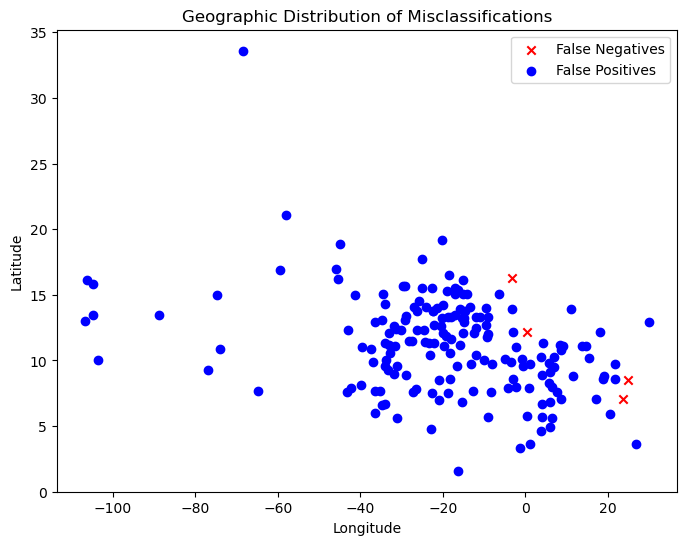

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(lon_false_neg, lat_false_neg, marker='x', color='red', label='False Negatives')
plt.scatter(lon_false_pos, lat_false_pos, marker='o', color='blue', label='False Positives')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Misclassifications')
plt.legend()
plt.show()


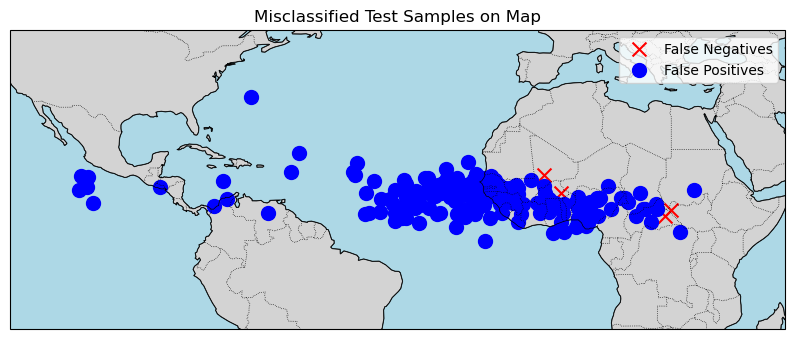

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())



lon_min, lon_max = np.min(lon_test)-15, np.max(lon_test)+15
lat_min, lat_max = np.min(lat_test)-15, np.max(lat_test)+15
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot misclassified points:
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')

plt.title("Misclassified Test Samples on Map")
plt.legend()
plt.show()

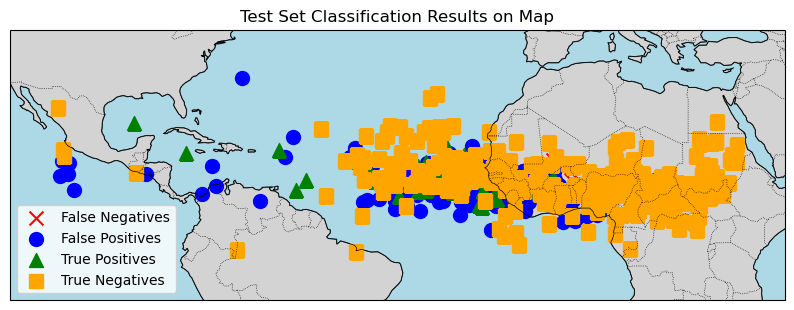

In [43]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent (adjust margins as desired)
lon_min, lon_max = np.min(lon_test) - 10, np.max(lon_test) + 10
lat_min, lat_max = np.min(lat_test) - 10, np.max(lat_test) + 10
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
# Plot misclassified points
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')



# Plot correctly classified points
ax.scatter(lon_true_pos, lat_true_pos, color='green', marker='^', s=100,
           transform=ccrs.PlateCarree(), label='True Positives')
ax.scatter(lon_true_neg, lat_true_neg, color='orange', marker='s', s=100,
           transform=ccrs.PlateCarree(), label='True Negatives')

plt.title("Test Set Classification Results on Map")
plt.legend()
plt.show()


In [44]:
print("Total samples:", len(sample_lat))
print("Unique latitudes:", len(np.unique(sample_lat)))
print("Unique longitudes:", len(np.unique(sample_lon)))


Total samples: 2750
Unique latitudes: 251
Unique longitudes: 913


In [45]:
print("First 10 latitudes:", sample_lat[:10])
print("First 10 longitudes:", sample_lon[:10])


First 10 latitudes: <xarray.DataArray 'lat_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample      (sample) int64 80B 1 1 1 1 1 1 1 1 1 1
    time        (sample) datetime64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
First 10 longitudes: <xarray.DataArray 'lon_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample 

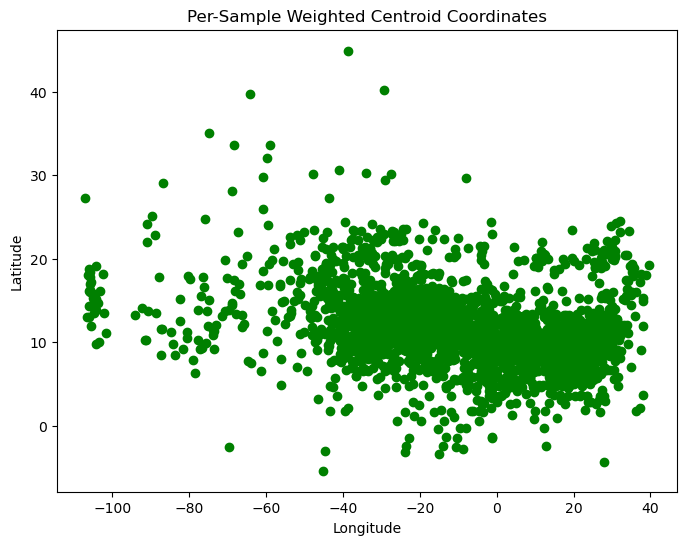

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(sample_lon, sample_lat, c='green', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Per-Sample Weighted Centroid Coordinates')
plt.show()


In [47]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.16369715332984924


Feature 0 - Increase in Loss: 0.04398027956485748


Feature 1 - Increase in Loss: -0.0011671781539916992


Feature 2 - Increase in Loss: 0.027254498004913336


Feature 3 - Increase in Loss: 0.0314125508069992


Feature 4 - Increase in Loss: -0.003744730353355402


Feature 5 - Increase in Loss: 0.0034801095724105724


Feature 6 - Increase in Loss: 0.0058693766593932994


Feature 7 - Increase in Loss: 0.0030156373977661133


Feature 8 - Increase in Loss: -0.02076457440853119


Feature 9 - Increase in Loss: 0.0


Feature 10 - Increase in Loss: 0.0
Permutation Importances (increase in loss) for all features: [ 0.04398028 -0.00116718  0.0272545   0.03141255 -0.00374473  0.00348011
  0.00586938  0.00301564 -0.02076457  0.          0.        ]


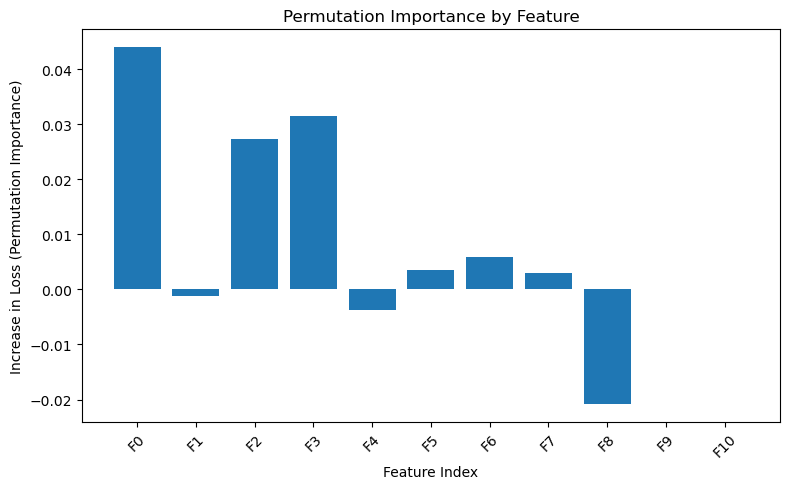

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


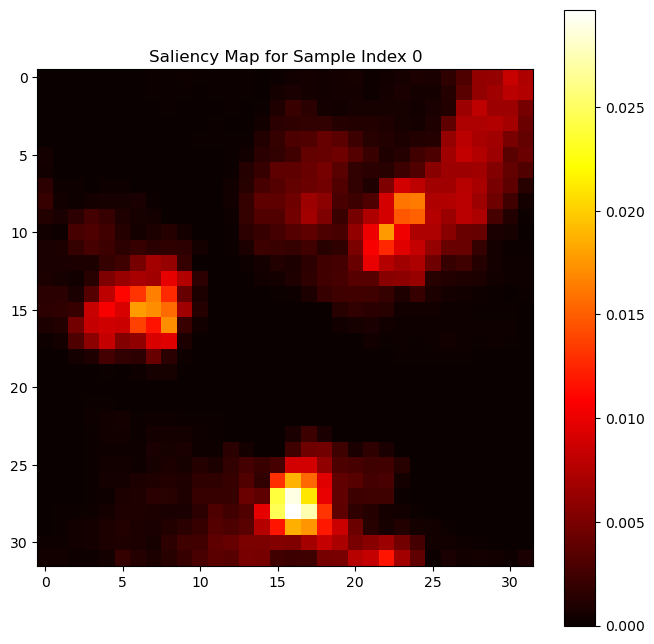

In [49]:
sample_index = 0
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute the saliency map for the selected test sample
saliency_map = compute_saliency_map(model, sample_input)

# Plot the saliency map
plt.figure(figsize=(8, 8))
plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.title(f"Saliency Map for Sample Index {sample_index}")
plt.show()



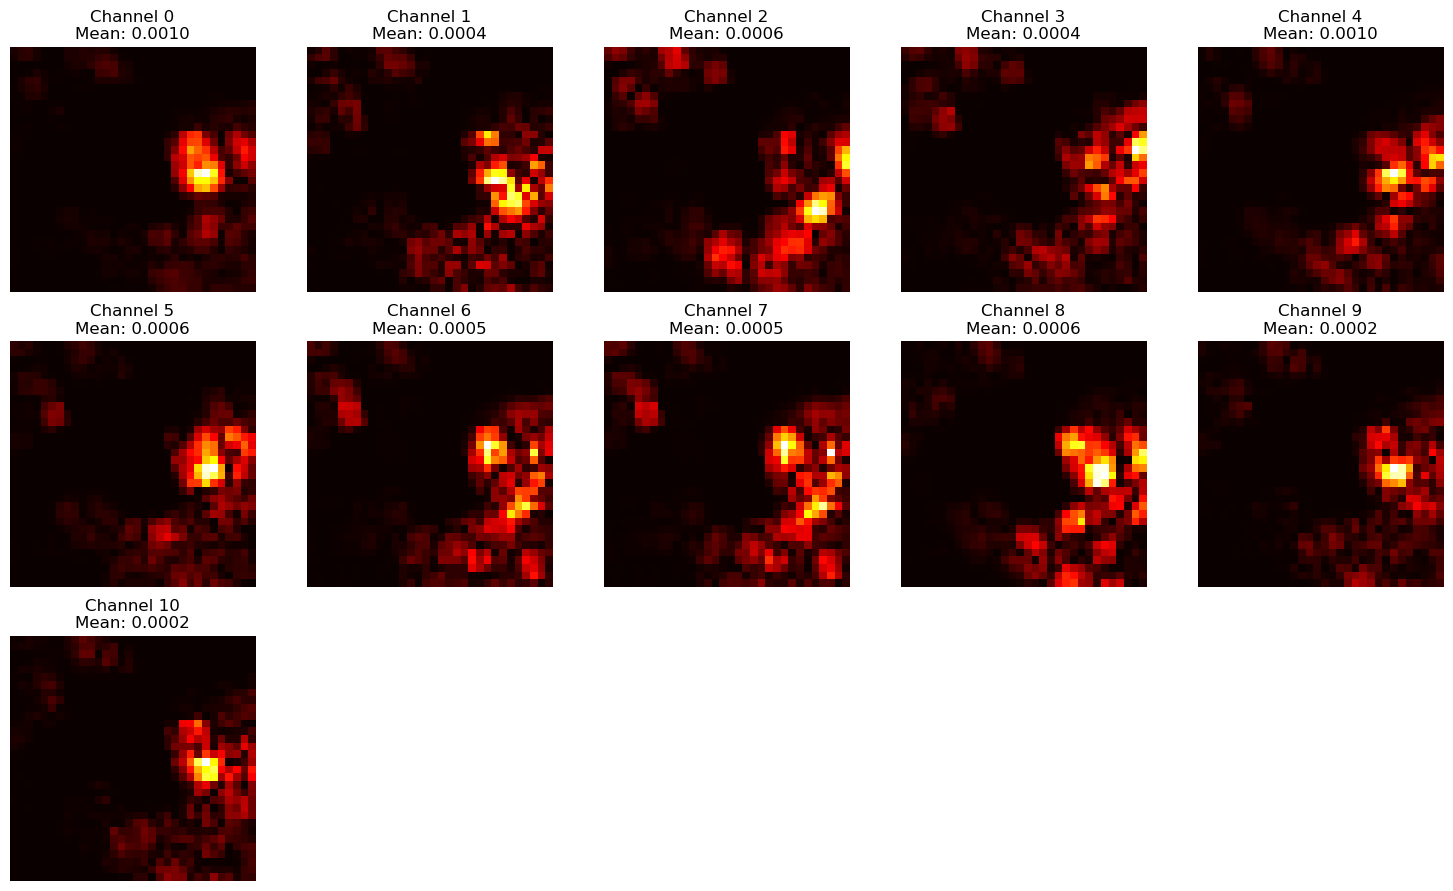

Channel importance (mean saliency per channel):
Channel 0: 0.0010
Channel 1: 0.0004
Channel 2: 0.0006
Channel 3: 0.0004
Channel 4: 0.0010
Channel 5: 0.0006
Channel 6: 0.0005
Channel 7: 0.0005
Channel 8: 0.0006
Channel 9: 0.0002
Channel 10: 0.0002


In [50]:
sample_index = 1
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute saliency maps per channel for the selected input sample
saliency_maps, channel_importance = compute_saliency_per_channel(model, sample_input)

# Plot the saliency maps for each channel
num_channels = saliency_maps.shape[-1]
cols = 5  # Set number of columns for plotting
rows = int(np.ceil(num_channels / cols))
plt.figure(figsize=(15, rows * 3))
for c in range(num_channels):
    plt.subplot(rows, cols, c + 1)
    plt.imshow(saliency_maps[:, :, c], cmap='hot')
    plt.title(f'Channel {c}\nMean: {channel_importance[c]:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print aggregated channel importance values
print("Channel importance (mean saliency per channel):")
for c, imp in enumerate(channel_importance):
    print(f"Channel {c}: {imp:.4f}")


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute per‑sample, per‑channel saliency importances
all_imps = []
for x in input_test_scaled:             # each x has shape (32,32,channels)
    _, imp = compute_saliency_per_channel(best_model, x[np.newaxis,...])
    all_imps.append(imp)               # imp.shape == (channels,)
all_imps = np.stack(all_imps)          # shape (N_samples, channels)

# 2) Average importance across samples
mean_imp = all_imps.mean(axis=0)       # shape (channels,)

# 3) Build a DataFrame mapping feature→plevel→importance
df = pd.DataFrame({
    "feature": var_list,
    "plevel": plevel_list,
    "importance": mean_imp
})

# 4) Group by pressure level and plot
grouped = df.groupby("plevel")["importance"].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(grouped["plevel"].astype(str), grouped["importance"])
plt.xlabel("Pressure level (hPa or False=surface)")
plt.ylabel("Mean saliency importance")
plt.title("Average feature importance by pressure level")
plt.show()


ValueError: All arrays must be of the same length

In [ ]:
# 1) Print out full test‐set metrics by name
test_results = model.evaluate(
    input_test_scaled,
    label_test_scaled,
    batch_size=label_test_scaled.shape[0],
    verbose=0
)
print(dict(zip(model.metrics_names, test_results)))

# 2) Peek at the end of your training history for F1 improvements
import pandas as pd
hist_df = pd.DataFrame(history.history)
print(hist_df[['f1_score','val_f1_score']].tail())

# 3) (Optional) Plot train vs. val F1 over epochs
import matplotlib.pyplot as plt
plt.plot(hist_df['f1_score'],    label='train F1')
plt.plot(hist_df['val_f1_score'],label='val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Focal‐Loss Training F1 Curves')
plt.show()


In [ ]:
# Replace your rebuild logic:
# top_hps = tuner.get_best_hyperparameters(num_trials=5)
# models  = [MyHyperModel().build(hp) for hp in top_hps]

# With this single line:
models = tuner.get_best_models(num_models=5)

# Then stack and average as before:
all_preds     = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)
ensemble_probs= all_preds.mean(axis=0)
ensemble_preds= (ensemble_probs >= 0.5).astype(int)
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))
